In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import itertools, os, sys

sys.path.append('..')
from data.load_data import *
from src.map import *
from src.robot import *
from src.slam import *
from src.utils import *

In [2]:
import pickle

MAP_XLIM = (-20, 20)
MAP_YLIM = (-15, 30)
MAP_RESOLUTION = 0.1

belief = 0.8
MAP_LOGODDS_OCCUPIED_DIFF = np.log(belief/(1-belief))
MAP_LOGODDS_FREE_DIFF = np.log((1-belief)/belief)*.5
MAP_LOGODDS_LIM = (-100, 100)

N_PARTICLES = 128
N_EFF_THRESHOLD = 4
PREDICT_NOISE_SIGMA = np.diag([1e-3, 1e-3, 1e-3])
MAP_LOGODDS_OCCUPIED_THRESHOLD = np.log(9)

SAVE_MAP_FIG_FNAME_TEMPLATE = '../fig/MAP_1/{}.jpg'
SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE = None

with open('../data/train1.pkl', 'rb') as f:
    datas = pickle.load(f)

In [3]:
from p2_utils import *
from multiprocessing import Pool
import cv2

logodds = Map2D(xlim=MAP_XLIM, ylim=MAP_YLIM, resolution=MAP_RESOLUTION)

state = { 'x': 0, 'y': 0, 'theta': 0 }
for di, data in enumerate(datas):
    for i, key in enumerate(['x', 'y', 'theta']):
        state[key] += data['lidar_delta_pose'][0, i]
        
    if di % 1 == 0:
        lidar_scan = data['lidar_scan']
        lidar_scan_points = np.hstack([data['lidar_scan_points'], np.ones((data['lidar_scan_points'].shape[0], 1))])
        t = Transform(**state, **data)
        lidar_scan_points_w = t.chain('wTb', 'bTh', 'hTl') @ lidar_scan_points.T
        lidar_scan_points_w = lidar_scan_points_w.T[:, :3]
        lidar_scan_points_w = lidar_scan_points_w[lidar_scan_points_w[:, 2] > 0.1, :]
        lidar_scan_points_w = lidar_scan_points_w[logodds.in_map(lidar_scan_points_w), :2]
        
        lidar_scan_indices = logodds.coordinate_to_index(lidar_scan_points_w)
        
        mask = cv2.drawContours(image=np.zeros_like(logodds.data), 
                                contours=[lidar_scan_indices.reshape((-1,1,2)).astype(np.int32)], 
                                contourIdx =-1, 
                                color = MAP_LOGODDS_FREE_DIFF, 
                                thickness=-1)
        logodds.data += mask
        logodds.data[lidar_scan_indices[:, 1], lidar_scan_indices[:, 0]] += MAP_LOGODDS_OCCUPIED_DIFF - MAP_LOGODDS_FREE_DIFF
        logodds.data = np.clip(logodds.data, *MAP_LOGODDS_LIM)
        
logodds.data.max()

100.0

1.0 0.0
(401, 451)


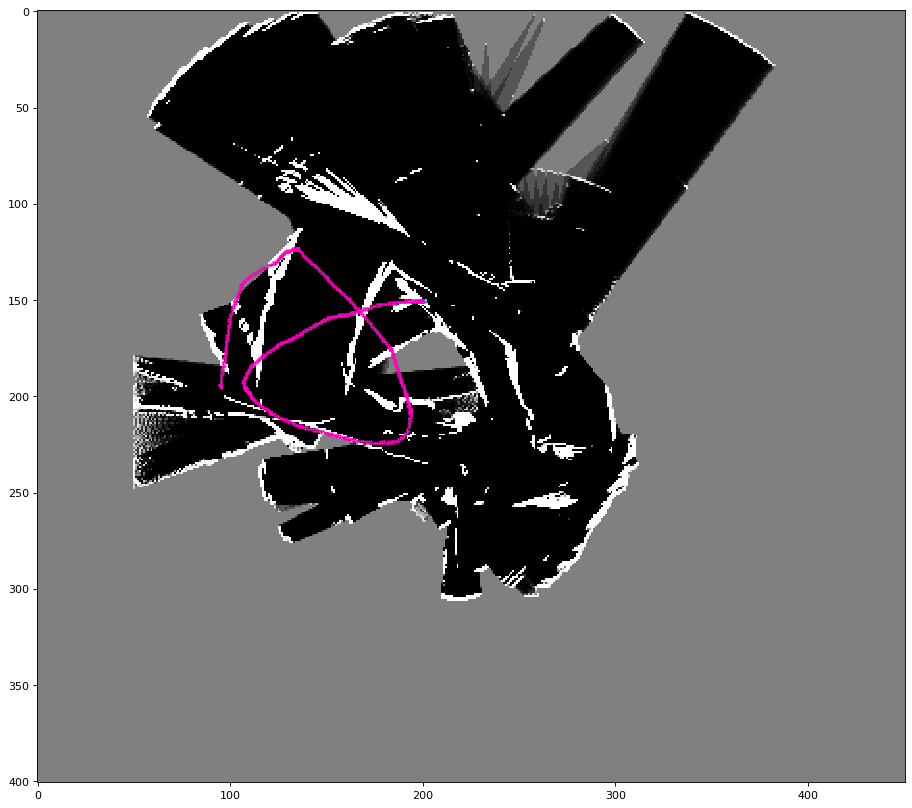

In [4]:
import pylab
from src.util import *

gamma = 1.0 - 1.0/(1.0 + np.exp(logodds.data))
print(gamma.max(), gamma.min())
print(logodds.data.shape)

state = np.array([0, 0, 0], dtype=np.float64)
posx = []
posy = []

for i, data in enumerate(datas):
    state[0] += data['lidar_delta_pose'][0, 0]
    state[1] += data['lidar_delta_pose'][0, 1]
    state[2] += data['lidar_delta_pose'][0, 2]
    
    x, y = logodds.coordinate_to_index([state[0], state[1]]).reshape(-1)
    if i % 20 == 0:
        posx.append(x)
        posy.append(y)

plot_map(gamma, [posx, posy], 20)

In [32]:
%load_ext autoreload
%autoreload 2
from src.slam import ParticleFilterSLAM

slam = ParticleFilterSLAM(
    n_particles=N_PARTICLES,
    n_efficient_threshold=N_EFF_THRESHOLD,
    map_xlim=MAP_XLIM,
    map_ylim=MAP_YLIM,
    map_resolution=MAP_RESOLUTION,
    map_logodds_lim=MAP_LOGODDS_LIM,
    map_logodds_occupied_diff=MAP_LOGODDS_OCCUPIED_DIFF,
    map_logodds_free_diff=MAP_LOGODDS_FREE_DIFF,
    map_logodds_occupied_threshold=MAP_LOGODDS_OCCUPIED_THRESHOLD,
    predict_noise_sigma=PREDICT_NOISE_SIGMA
)

states = [np.array([0, 0, 0])]
for i, data in enumerate(datas):
    with slam.set_robot_data(**data):
        u = slam.predict_particles(data['lidar_delta_pose'][0, :])
        corr, neff = slam.update_particles()

        states.append(slam.robot_state)

        if i % 1 == 0:
            print(i, slam.robot_state, neff, corr.max(), corr.min())
            slam.update_map_logodds()
        
#         if i % 1000 == 0:
#             slam.update_map_texture()

        if i % 50 == 0:
            if SAVE_MAP_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(1.0 - slam.map_prob, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
                
            if SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(slam.map_texture_trimmed, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
        plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0 [-0.11246551 -0.20438619 -0.00082057] 127.99999999999997 0.0 0.0
1 [-0.34222334 -0.31818837 -0.0103973 ] 127.99999999999997 0.0 0.0
2 [-0.16217218 -0.2644403  -0.01492964] 6.018117324854611 10.0 0.0
3 [-0.14948578 -0.26627989 -0.01853831] 1.0049574738935776 238.0 25.0
4 [-0.15761955 -0.27095646 -0.02172744] 1.000339294667009 399.0 148.0
5 [-0.16024208 -0.27871817 -0.0191502 ] 1.6480545815345866 708.0 246.0
6 [-0.15547713 -0.27750229 -0.02154975] 1.0000000015168098 699.0 209.0
7 [-0.15100062 -0.28267522 -0.01343593] 1.0000090525348388 692.0 240.0
8 [-0.15226663 -0.2722873  -0.017497  ] 1.0 734.0 266.0
9 [-0.13863439 -0.27323252 -0.01904458] 1.0000016640258418 718.0 227.0
10 [-0.14848066 -0.26666084 -0.01863673] 1.00025134082472 737.0 269.0
11 [-0.1529329  -0.26384771 -0.01934612] 1.0143992498131642 740.0 231.0
12 [-0.16655163 -0.27394305 -0.01988157] 1.0000000345821722 733.0 238.0
13 [-0.17342713 -

115 [-0.12658873 -0.28539416 -0.01622109] 1.0993676529494278 706.0 235.0
116 [-0.15384619 -0.2755839  -0.01936991] 1.0000457337738302 719.0 262.0
117 [-0.1153964  -0.27841408 -0.01992147] 1.0272902552119636 696.0 223.0
118 [-0.13202979 -0.28395391 -0.01524941] 1.000181634894627 692.0 268.0
119 [-0.13373805 -0.2803914  -0.01703187] 1.0993279274195933 701.0 251.0
120 [-0.1337623  -0.27312339 -0.0176429 ] 1.1141547232283315 699.0 233.0
121 [-0.14276211 -0.28020624 -0.02367364] 1.001857810138198 698.0 247.0
122 [-0.1364615  -0.27517379 -0.02127482] 1.0056424636185055 698.0 223.0
123 [-0.12400277 -0.27930262 -0.0175621 ] 2.13577607464161 703.0 245.0
124 [-0.14017775 -0.28320732 -0.01619078] 1.00019461198555 705.0 252.0
125 [-0.13379152 -0.27487757 -0.01968522] 1.0036544096929572 697.0 252.0
126 [-0.11533586 -0.29081069 -0.01875362] 1.0000914742342548 694.0 252.0
127 [-0.1525058  -0.28981209 -0.01646319] 1.9595729097864265 696.0 265.0
128 [-0.14399239 -0.28423586 -0.01498152] 1.0000380381096

229 [-0.13126819 -0.31158906  0.00948007] 1.0993408118024424 692.0 274.0
230 [-0.13858472 -0.31880404  0.0100936 ] 1.2185722713312128 693.0 297.0
231 [-0.08676121 -0.32100432  0.01423012] 1.0000122886310785 679.0 249.0
232 [-0.11767506 -0.30887772  0.0080172 ] 1.0443971608816554 690.0 285.0
233 [-0.11528069 -0.31162685  0.01467214] 1.000673200805852 702.0 294.0
234 [-0.1307953  -0.30620243  0.01050033] 2.000090810034815 696.0 269.0
235 [-0.14170193 -0.30872716  0.00991382] 1.0050737545480282 684.0 273.0
236 [-0.12870351 -0.30348351  0.01676975] 1.000000113262563 711.0 254.0
237 [-0.09691525 -0.30003786  0.0140385 ] 1.0000907998632904 702.0 288.0
238 [-0.0873662  -0.29172575  0.00939805] 1.000001892894439 679.0 233.0
239 [-0.13999276 -0.27986347  0.01502916] 1.0993978874263293 705.0 268.0
240 [-0.12891917 -0.28141572  0.01582964] 1.2658394707228537 717.0 273.0
241 [-0.15332888 -0.26592613  0.00987116] 1.000001663090425 694.0 224.0
242 [-0.15103659 -0.26251216  0.01411146] 1.265802333641

343 [-0.10630568 -0.3030247  -0.01612988] 1.0006715484788904 673.0 264.0
344 [-0.10637668 -0.31282402 -0.00719054] 1.6524496881831765 693.0 286.0
345 [-0.11380381 -0.32280253 -0.00581924] 1.3068269033761533 686.0 252.0
346 [-0.13576057 -0.32846916 -0.00944294] 1.6980314082534125 671.0 296.0
347 [-0.09853428 -0.33875398 -0.00521756] 1.0002468312219945 676.0 277.0
348 [-0.12741355 -0.34170181 -0.00828937] 1.0049575799512913 679.0 300.0
349 [-0.09538913 -0.33095487 -0.0050069 ] 1.0993280192430013 671.0 244.0
350 [-0.13473158 -0.32838659 -0.01000558] 1.0994582292109034 679.0 254.0
351 [-0.10871263 -0.34106916 -0.00847035] 1.0000000000006821 675.0 248.0
352 [-0.12373958 -0.33457724 -0.00705898] 1.0134755087982055 675.0 244.0
353 [-0.12219966 -0.33988824 -0.00505606] 1.099327940742617 662.0 265.0
354 [-0.1057307  -0.33205677 -0.00627158] 1.0135089413540816 677.0 295.0
355 [-0.11791433 -0.33150991 -0.0040733 ] 1.0020389800070835 654.0 230.0
356 [-0.06394558 -0.32185671 -0.00468221] 3.03649552

457 [ 0.00187195 -0.2317977  -0.03570627] 1.0000670327853958 700.0 271.0
458 [ 0.00093792 -0.23115327 -0.03373804] 1.0006754479132294 701.0 278.0
459 [-0.0090638  -0.24532413 -0.0287404 ] 1.0000008368749769 708.0 253.0
460 [-0.01170542 -0.23852249 -0.0264027 ] 1.0375658513369557 696.0 298.0
461 [ 0.01158513 -0.23885341 -0.02868631] 1.965153972371161 709.0 280.0
462 [ 0.00591264 -0.24625305 -0.03211451] 1.0000000000140972 712.0 295.0
463 [-0.00468643 -0.25150251 -0.03574899] 1.0135122882586456 704.0 297.0
464 [-0.00398907 -0.25645536 -0.03631048] 1.0000334041651238 714.0 296.0
465 [-0.00563134 -0.25941284 -0.03361528] 1.0366189934735863 713.0 253.0
466 [-0.00809283 -0.26839739 -0.03282144] 1.099328020245334 698.0 203.0
467 [-0.02337353 -0.26530825 -0.04028807] 1.0051395385374489 686.0 231.0
468 [-0.01709363 -0.28332765 -0.03915763] 1.0000459283509369 690.0 235.0
469 [-0.02973759 -0.29638039 -0.03752723] 1.0006777357892016 687.0 266.0
470 [ 0.01231956 -0.29399392 -0.03505641] 1.036623683

570 [ 0.03885845 -0.21062393 -0.05435175] 1.0503394534757406 735.0 258.0
571 [ 0.03565895 -0.1991126  -0.04878819] 1.654138706465723 739.0 267.0
572 [ 0.0341027  -0.20817903 -0.05102492] 1.0000000345823996 755.0 262.0
573 [ 0.04748466 -0.20579563 -0.05333078] 1.2030989147974465 750.0 266.0
574 [ 0.06142634 -0.20420565 -0.04677519] 1.271524630722012 739.0 237.0
575 [ 0.06314848 -0.21671404 -0.05170807] 1.000000611804674 757.0 297.0
576 [ 0.04600931 -0.20509538 -0.0531108 ] 1.0000000833570102 759.0 247.0
577 [ 0.02987372 -0.2040525  -0.05670126] 1.0384801430921973 754.0 291.0
578 [ 0.06585823 -0.22091417 -0.05179976] 1.0503394528882446 742.0 285.0
579 [ 0.09950363 -0.21949374 -0.05257575] 1.044211847960378 728.0 301.0
580 [ 0.07810077 -0.2231017  -0.0539117 ] 1.0006753183193926 725.0 199.0
581 [ 0.08603763 -0.22472847 -0.05168414] 1.2808165548344266 714.0 242.0
582 [ 0.03556511 -0.23406537 -0.05191783] 1.0023577444235297 711.0 273.0
583 [ 0.01838555 -0.22282954 -0.05396595] 1.09932792741

684 [ 0.01713923 -0.2721177  -0.1106423 ] 1.036870248892516 694.0 266.0
685 [ 0.03189504 -0.27653912 -0.10637804] 1.0135667738604477 695.0 291.0
686 [-0.00161931 -0.25752359 -0.1075742 ] 1.5578515176324628 679.0 253.0
687 [ 0.01201254 -0.2580235  -0.11081253] 1.0000000000557066 688.0 291.0
688 [ 0.03231528 -0.25526064 -0.10856668] 1.000033404997339 688.0 273.0
689 [ 0.02201648 -0.24543477 -0.10674418] 1.0005845265204711 691.0 255.0
690 [ 0.01503309 -0.23310018 -0.10735065] 1.649685850070554 691.0 294.0
691 [ 0.01198295 -0.22713048 -0.11200155] 1.7084044658765398 704.0 280.0
692 [ 0.02604927 -0.22177314 -0.11305204] 1.0000125389446228 718.0 258.0
693 [ 0.02118983 -0.22915827 -0.10940963] 1.000248483528354 722.0 269.0
694 [ 0.02486518 -0.22154449 -0.11144439] 1.0049587117658207 723.0 311.0
695 [ 0.0173645  -0.22461557 -0.11139436] 1.0134922043847336 724.0 288.0
696 [ 0.02762408 -0.21979674 -0.11310488] 1.1527085778176347 719.0 285.0
697 [ 0.04885706 -0.22281877 -0.11316555] 1.00067115165

799 [ 0.00523453 -0.25220458 -0.11303672] 1.2658022815744674 722.0 260.0
800 [ 0.01132519 -0.25023106 -0.11581117] 1.6540311199313118 715.0 231.0
801 [ 0.01636995 -0.24168935 -0.11357455] 1.0006709364457556 723.0 280.0
802 [ 0.00099115 -0.23794221 -0.11290566] 1.1012376732524605 708.0 305.0
803 [ 0.02909873 -0.25099988 -0.11102448] 1.000249790982106 716.0 261.0
804 [ 0.01942329 -0.24188237 -0.11313454] 1.03759073153962 717.0 248.0
805 [ 0.0035778  -0.24271118 -0.1123072 ] 1.0367117393215113 716.0 280.0
806 [ 0.03554333 -0.25231851 -0.10904552] 1.648054958100231 712.0 269.0
807 [ 0.02517157 -0.24888385 -0.11117346] 1.000003943561229 715.0 248.0
808 [ 0.02577907 -0.25709075 -0.10812301] 1.0000855165777662 707.0 242.0
809 [ 0.01498669 -0.25073741 -0.11099061] 1.0000006245271484 723.0 248.0
810 [-0.01416692 -0.2379002  -0.11648587] 1.2678727283982638 706.0 231.0
811 [ 0.01389214 -0.25239228 -0.11205033] 1.6540236618617044 725.0 234.0
812 [-0.00854358 -0.24288812 -0.11703385] 1.005882281253

913 [ 0.05492716 -0.24576358 -0.11489673] 1.1054957630876565 630.0 279.0
914 [ 0.03327838 -0.25774117 -0.11378991] 1.6643099954717222 625.0 286.0
915 [ 0.00809681 -0.24840537 -0.11195858] 1.2810935400899965 633.0 284.0
916 [-0.00472708 -0.24755415 -0.11436936] 1.0187150190614747 638.0 308.0
917 [ 0.00327664 -0.25547101 -0.11204897] 1.0185121878998866 634.0 305.0
918 [ 0.03359266 -0.24661672 -0.11610938] 1.0738967076319341 637.0 252.0
919 [ 0.03205769 -0.24036099 -0.11751965] 1.1048066633849283 628.0 293.0
920 [ 0.0409422  -0.25854208 -0.10989147] 1.0050485031559382 627.0 246.0
921 [ 0.02733162 -0.2499593  -0.11431079] 1.000676091355185 643.0 282.0
922 [ 0.02540059 -0.25156717 -0.11539606] 1.8126043514932966 635.0 270.0
923 [ 0.02094531 -0.24629551 -0.11424295] 1.0016028554043754 637.0 234.0
924 [ 0.03875914 -0.24454424 -0.11383722] 1.0049574741624658 637.0 270.0
925 [ 0.04070811 -0.25831735 -0.11155704] 1.203098918680532 628.0 322.0
926 [ 0.03399609 -0.24427494 -0.11118756] 1.558412324

1027 [ 0.02154675 -0.24846323 -0.11663868] 1.000016922578021 662.0 307.0
1028 [ 0.03873247 -0.24818837 -0.11570782] 1.0366189976702227 654.0 259.0
1029 [ 0.01894776 -0.24015149 -0.11349727] 1.1031619660857237 650.0 291.0
1030 [ 0.04455905 -0.24891124 -0.11867547] 1.6024887163602388 651.0 252.0
1031 [-0.00230555 -0.24746437 -0.11751098] 1.477748646404192 650.0 292.0
1032 [ 0.03305672 -0.24393747 -0.11245236] 1.0002521793935704 653.0 281.0
1033 [ 0.05195535 -0.24925163 -0.11837994] 1.0178261076592947 649.0 257.0
1034 [ 0.03690469 -0.24577482 -0.12097067] 1.0000346804857003 654.0 265.0
1035 [ 0.00087053 -0.24023089 -0.11355691] 1.2666517430393474 654.0 302.0
1036 [ 0.05338375 -0.25212902 -0.11469609] 2.2643957118414733 654.0 308.0
1037 [ 0.00649709 -0.24559892 -0.1150031 ] 1.0134752935816878 651.0 226.0
1038 [ 0.012714   -0.241688   -0.11797752] 1.6673300816599337 651.0 270.0
1039 [-1.02142173e-04 -2.46325470e-01 -1.19050272e-01] 2.2232963510147314 648.0 293.0
1040 [ 0.03470787 -0.2366614

1139 [ 0.01238753 -0.25350564 -0.11161828] 1.0000135136460184 642.0 260.0
1140 [ 0.02797889 -0.25946181 -0.11388886] 1.3121597631431203 640.0 237.0
1141 [ 0.04838821 -0.24397068 -0.12022965] 1.1000359271047526 649.0 213.0
1142 [ 0.06109971 -0.24962114 -0.11337702] 1.2815665852217444 646.0 252.0
1143 [ 0.03599855 -0.25968179 -0.11205933] 2.3647853323728456 648.0 290.0
1144 [ 0.01825207 -0.24429102 -0.11123683] 1.0000122895517256 644.0 260.0
1145 [ 0.05211357 -0.23952847 -0.12059324] 1.0000022876743186 635.0 314.0
1146 [ 0.03528094 -0.25005868 -0.11414438] 1.002161700844291 654.0 279.0
1147 [ 0.02540877 -0.25294121 -0.11125285] 1.099328195253606 653.0 286.0
1148 [ 0.018169   -0.24412417 -0.11481764] 1.1020360697134544 659.0 275.0
1149 [ 0.02975531 -0.24530518 -0.11469531] 1.050600324280653 652.0 243.0
1150 [ 0.03319166 -0.24638985 -0.11403834] 1.0000019298040779 644.0 292.0
1151 [ 0.02400485 -0.2517817  -0.11621447] 1.03661922315888 640.0 241.0
1152 [ 0.02167997 -0.24751196 -0.11808228] 

1251 [ 0.04052989 -0.24348338 -0.11800152] 2.857245194183337 648.0 239.0
1252 [ 0.01476542 -0.25016397 -0.11447296] 1.0099317181599303 652.0 286.0
1253 [ 0.03388511 -0.25273526 -0.11611747] 1.0384818221421008 640.0 239.0
1254 [ 0.03555505 -0.24199778 -0.11461678] 1.6483519239040123 641.0 255.0
1255 [ 0.04874815 -0.24443636 -0.11741469] 1.0451203289196622 644.0 253.0
1256 [ 0.00618224 -0.24540367 -0.11617289] 1.0366331962991993 651.0 248.0
1257 [ 0.05126248 -0.24430202 -0.11867563] 1.4184016626490108 639.0 293.0
1258 [ 0.02632021 -0.24492514 -0.11666089] 1.0000006180194825 647.0 290.0
1259 [ 0.01408281 -0.24898968 -0.11710273] 2.3722591853570423 657.0 259.0
1260 [ 0.03983637 -0.24602616 -0.11467764] 1.0006709605949344 656.0 238.0
1261 [ 0.03107016 -0.25879446 -0.11255356] 1.0010254978536168 645.0 280.0
1262 [ 0.04696339 -0.24970718 -0.11254023] 1.3065420373242311 649.0 246.0
1263 [ 0.02182379 -0.24408449 -0.1189206 ] 1.0000334034120368 646.0 301.0
1264 [ 0.02432895 -0.25563407 -0.114554

1365 [ 0.04403818 -0.25721664 -0.10980251] 1.286377335176121 643.0 296.0
1366 [ 0.03652647 -0.25299799 -0.11382375] 1.0009512468285446 648.0 259.0
1367 [ 0.03670819 -0.25277991 -0.11320114] 1.0993538998858128 643.0 277.0
1368 [ 0.01304685 -0.2414658  -0.11572139] 1.6540236568778732 647.0 277.0
1369 [ 0.03949771 -0.25070701 -0.11043362] 2.625763804958677 634.0 258.0
1370 [ 0.048207   -0.24390054 -0.11514512] 2.9521854416932327 648.0 244.0
1371 [ 0.04209342 -0.24407671 -0.11598534] 1.0056307071653228 644.0 222.0
1372 [ 0.02178722 -0.26293925 -0.11098793] 1.6642645503810292 633.0 252.0
1373 [ 0.03055655 -0.24641993 -0.1181892 ] 1.4057404494635481 646.0 261.0
1374 [ 0.04926279 -0.25336282 -0.11685205] 1.0049575352099034 631.0 247.0
1375 [ 0.04179781 -0.25360055 -0.11135215] 1.0067858910701108 622.0 305.0
1376 [ 0.01014746 -0.25283291 -0.11410594] 1.6660108859186624 588.0 239.0
1377 [ 0.01259104 -0.24512109 -0.11470522] 1.0028471067094877 561.0 238.0
1378 [ 0.02037402 -0.25501472 -0.1138105

1479 [-0.00286979 -0.25570878 -0.11206286] 1.2658464652075214 570.0 269.0
1480 [ 0.0239487  -0.25035285 -0.11686632] 1.0002474426914356 577.0 279.0
1481 [ 0.03459137 -0.25517201 -0.1100302 ] 2.713247957705136 577.0 239.0
1482 [ 0.03661937 -0.23993071 -0.11700259] 1.4186259419153329 579.0 256.0
1483 [ 0.01205205 -0.24297547 -0.11913162] 1.0237646618870788 579.0 262.0
1484 [ 0.03465445 -0.24779707 -0.11448229] 1.1000720199908183 583.0 247.0
1485 [ 0.02062952 -0.24625239 -0.1132968 ] 1.000246892030811 581.0 267.0
1486 [ 0.03475187 -0.24323529 -0.11752845] 1.0004962358638396 578.0 284.0
1487 [ 0.03359465 -0.24349536 -0.11719182] 1.7671927145687842 577.0 246.0
1488 [ 0.01977552 -0.24982511 -0.11183487] 2.006784884898559 569.0 247.0
1489 [-0.00173633 -0.25007348 -0.11590906] 1.5369984780578612 561.0 271.0
1490 [ 0.0210451  -0.26041197 -0.11007433] 1.001862335863947 566.0 218.0
1491 [ 0.03064537 -0.25442547 -0.1151933 ] 1.0000917202127861 563.0 281.0
1492 [ 0.02661711 -0.24526492 -0.11101176]

1592 [ 0.03649827 -0.25115479 -0.11585816] 1.7663512114206508 555.0 229.0
1593 [ 0.05874807 -0.25332888 -0.11078528] 1.6645638991718101 548.0 260.0
1594 [ 0.02949566 -0.24976443 -0.11405895] 1.0184996018623922 553.0 268.0
1595 [ 0.03900125 -0.25511124 -0.1136501 ] 1.0039344653527253 559.0 255.0
1596 [ 0.01676513 -0.24962684 -0.11258914] 2.421208893068599 557.0 293.0
1597 [ 0.03962727 -0.23981984 -0.11552097] 1.0367115426574252 558.0 251.0
1598 [ 0.05962502 -0.25128917 -0.11315274] 1.0000002266167614 561.0 286.0
1599 [ 0.06079348 -0.263098   -0.11363942] 2.5054511050612103 557.0 247.0
1600 [ 0.04414941 -0.24356006 -0.11636862] 2.0061369927530013 570.0 299.0
1601 [ 0.04164851 -0.25162858 -0.1147311 ] 1.00996551714666 576.0 264.0
1602 [ 0.01891555 -0.25489492 -0.11296616] 1.0053294437336562 578.0 266.0
1603 [ 0.03074495 -0.24031718 -0.11900491] 1.0403809830827977 574.0 261.0
1604 [ 0.02611061 -0.25344806 -0.11713837] 1.099458080789884 571.0 271.0
1605 [ 0.05802539 -0.25589321 -0.11470291]

1704 [ 0.01815226 -0.2549086  -0.1119214 ] 1.0141777452624976 642.0 321.0
1705 [ 0.03938843 -0.24835375 -0.11762952] 1.664562644725632 623.0 287.0
1706 [ 0.02627192 -0.25210314 -0.11320472] 1.0000173427465082 639.0 242.0
1707 [ 0.03483188 -0.24698085 -0.11580959] 1.5582661372110302 629.0 243.0
1708 [ 0.03119598 -0.26450784 -0.10730436] 1.2038696674317304 628.0 266.0
1709 [ 0.0166596  -0.24061394 -0.1161465 ] 1.0018243763049774 631.0 260.0
1710 [ 0.02219934 -0.24345164 -0.11350136] 1.03915972098707 626.0 278.0
1711 [ 0.01910469 -0.2442909  -0.11327177] 1.2658446226946953 638.0 283.0
1712 [ 0.03549872 -0.24699444 -0.11538314] 1.0049682062742769 629.0 261.0
1713 [ 0.00896185 -0.2548825  -0.11159453] 1.0018243867563688 629.0 285.0
1714 [ 0.0194091  -0.24927706 -0.11447358] 1.30682225568607 636.0 265.0
1715 [ 0.00792838 -0.26055914 -0.11024905] 1.3973321194536952 629.0 293.0
1716 [ 0.03679371 -0.25166433 -0.11583768] 1.0001031305962316 629.0 260.0
1717 [ 0.02131696 -0.25296953 -0.11520726] 

1817 [ 0.00375582 -0.24523491 -0.11785694] 1.102746036004766 619.0 282.0
1818 [ 0.01972294 -0.24521873 -0.11415868] 2.6257483616923256 619.0 282.0
1819 [ 0.05811967 -0.2484274  -0.11264639] 2.4116897039173266 614.0 239.0
1820 [ 0.03325389 -0.25481558 -0.11100879] 1.0000397900514555 622.0 301.0
1821 [ 0.04670439 -0.26246091 -0.11329368] 1.0006726062036577 606.0 205.0
1822 [ 0.02006975 -0.25355917 -0.11511835] 1.000181831005937 620.0 279.0
1823 [ 0.04005476 -0.24983589 -0.11450593] 1.0001247722854851 623.0 272.0
1824 [ 0.04552617 -0.25586636 -0.11450385] 2.0056277935065925 619.0 277.0
1825 [ 0.04140279 -0.26422231 -0.1071172 ] 1.2713696248211046 608.0 271.0
1826 [ 0.04085603 -0.25155734 -0.1165179 ] 1.0050087263742913 616.0 225.0
1827 [ 0.03042764 -0.24925806 -0.11552793] 1.102199645430865 618.0 247.0
1828 [ 0.01474589 -0.2459064  -0.11626966] 1.0002481163397252 625.0 265.0
1829 [ 0.01965884 -0.24363064 -0.11653256] 1.203104652572328 627.0 249.0
1830 [ 0.02178878 -0.24232278 -0.11652554]

1929 [ 0.02746589 -0.2559161  -0.11338235] 1.0003624578648918 682.0 273.0
1930 [ 0.03220268 -0.24270612 -0.11523798] 1.267872633337072 681.0 239.0
1931 [ 0.00212544 -0.24732191 -0.11330048] 1.0000000015172645 702.0 279.0
1932 [ 0.01137813 -0.23979242 -0.11473093] 2.0000045679606737 700.0 274.0
1933 [ 0.01350278 -0.24482742 -0.11602477] 1.0134752890210972 700.0 268.0
1934 [ 0.01017493 -0.24704751 -0.11177607] 1.2038331079999445 695.0 289.0
1935 [ 0.02477746 -0.25832403 -0.11424016] 1.0000334040568901 692.0 289.0
1936 [ 0.02608278 -0.24754406 -0.1110027 ] 1.0006732899430966 703.0 272.0
1937 [ 0.04867129 -0.25253631 -0.11333529] 1.014155864986803 698.0 296.0
1938 [ 0.01311974 -0.26561352 -0.10612291] 1.265915399322111 667.0 275.0
1939 [ 0.02111302 -0.24573654 -0.11176453] 2.3962293381493724 684.0 314.0
1940 [ 0.02177675 -0.25415738 -0.11492368] 1.479604384788637 689.0 304.0
1941 [ 0.03714575 -0.24354041 -0.11658433] 1.0050498911697692 691.0 257.0
1942 [ 0.04472219 -0.24654184 -0.11151139]

2043 [ 0.03253427 -0.24996225 -0.11176132] 1.115407370852388 631.0 258.0
2044 [ 0.04477142 -0.25515074 -0.11158797] 1.00028114700985 635.0 318.0
2045 [ 0.04049693 -0.2553871  -0.11312939] 1.0994220879508747 630.0 288.0
2046 [ 0.03932543 -0.24885807 -0.11370337] 1.000042670519404 629.0 262.0
2047 [ 0.05106689 -0.25269519 -0.1144437 ] 1.100030573034874 620.0 284.0
2048 [ 0.05620151 -0.25054548 -0.11738272] 1.0134770183284079 620.0 253.0
2049 [ 0.04171351 -0.25379459 -0.11688478] 1.648069084182874 614.0 284.0
2050 [ 0.06285861 -0.25359192 -0.11551496] 1.000099846316117 619.0 303.0
2051 [ 0.04420705 -0.25833308 -0.11754656] 1.0135446640943608 607.0 257.0
2052 [ 0.05463232 -0.25662314 -0.11512063] 1.654834435532081 608.0 267.0
2053 [ 0.04640744 -0.25028559 -0.11409705] 1.3219107046111058 613.0 241.0
2054 [ 0.05227004 -0.25166328 -0.11581467] 1.001823805033567 620.0 262.0
2055 [ 0.04427927 -0.24522133 -0.11360728] 1.10503700871148 613.0 298.0
2056 [ 0.04749358 -0.24731269 -0.11360522] 1.0000

2156 [ 0.04580982 -0.24145157 -0.11740288] 1.000012288452588 720.0 266.0
2157 [ 0.04611736 -0.25945481 -0.11029867] 1.1012798177083523 703.0 250.0
2158 [ 0.05373988 -0.24244299 -0.11885502] 1.0024953596368462 715.0 269.0
2159 [ 0.01827759 -0.24539758 -0.11151657] 1.0025909638080934 713.0 290.0
2160 [ 0.0275907  -0.24944775 -0.10868125] 2.1119821189673096 700.0 275.0
2161 [ 0.03367838 -0.25061297 -0.11139921] 1.0001838789124826 723.0 282.0
2162 [ 0.05162311 -0.24789813 -0.11429496] 1.01540792363811 723.0 292.0
2163 [ 0.0356679  -0.25319565 -0.11486879] 1.0641448287888744 718.0 318.0
2164 [ 0.05211959 -0.24479042 -0.12058551] 1.099360139843409 709.0 275.0
2165 [ 0.05880029 -0.24944679 -0.11394386] 1.3112971355618972 723.0 272.0
2166 [ 0.04893507 -0.24466562 -0.11282426] 1.7694589183418394 717.0 286.0
2167 [ 0.03217915 -0.24748427 -0.11473418] 1.3065420842909206 724.0 253.0
2168 [ 0.04256859 -0.25962804 -0.11523913] 1.0006754629218373 705.0 301.0
2169 [ 0.04358604 -0.24705125 -0.1166033 ]

2268 [ 0.04680948 -0.2484437  -0.11502805] 1.0000122886401732 758.0 294.0
2269 [ 0.03376605 -0.24342152 -0.1159652 ] 1.0384772010585515 751.0 253.0
2270 [ 0.0468774  -0.2523772  -0.11582154] 1.0008074649163328 749.0 301.0
2271 [ 0.03706943 -0.24655748 -0.12173064] 1.2668629969191496 741.0 303.0
2272 [ 0.0213406  -0.24096224 -0.11522887] 1.0993279407418672 734.0 254.0
2273 [ 0.05641674 -0.24542399 -0.1154189 ] 2.666208903466886 749.0 271.0
2274 [ 0.04447561 -0.24556094 -0.11486802] 1.0002469024450482 751.0 301.0
2275 [ 0.05183147 -0.2481206  -0.11890635] 1.0366189934752363 749.0 288.0
2276 [ 0.03426554 -0.2556575  -0.11425396] 1.0993279280039958 746.0 282.0
2277 [ 0.04541154 -0.23445847 -0.11405639] 1.3759181713777846 724.0 297.0
2278 [ 0.05423671 -0.24769985 -0.11811588] 1.2033690353026603 743.0 250.0
2279 [ 0.04534853 -0.25740087 -0.11308467] 1.0000000015168098 739.0 265.0
2280 [ 0.04097709 -0.25084542 -0.11272697] 1.0000379241738206 739.0 295.0
2281 [ 0.02515427 -0.2424211  -0.118122

2381 [ 0.040389   -0.24665205 -0.1115543 ] 1.000033486858009 665.0 251.0
2382 [ 0.03924374 -0.24193017 -0.11735085] 1.376195700494899 683.0 307.0
2383 [ 0.05829911 -0.24527446 -0.12145053] 1.0000334154461905 677.0 289.0
2384 [ 0.05881395 -0.24755505 -0.11485961] 1.0134752863717562 692.0 270.0
2385 [ 0.0528092  -0.25274316 -0.11359534] 1.0000336300220432 692.0 312.0
2386 [ 0.0205698  -0.24148602 -0.11715419] 1.26580727070589 684.0 286.0
2387 [ 0.04793497 -0.25281221 -0.11822127] 1.0000047457297117 692.0 312.0
2388 [ 0.03844711 -0.25445016 -0.11406941] 1.6480570144731541 699.0 273.0
2389 [ 0.04413815 -0.24957798 -0.12157464] 1.0000000000291038 688.0 252.0
2390 [ 0.0415545  -0.25022428 -0.11183603] 1.2713418036422093 685.0 248.0
2391 [ 0.06268733 -0.24701269 -0.11689428] 1.0006877440537436 695.0 253.0
2392 [ 0.02456853 -0.24495606 -0.11467266] 1.0993296712105765 694.0 288.0
2393 [ 0.03244669 -0.24413574 -0.11494603] 1.0995863943581181 695.0 315.0
2394 [ 0.05398234 -0.24820475 -0.11451483]

2493 [ 0.06472957 -0.24871713 -0.11294172] 1.0000000305353753 737.0 272.0
2494 [ 0.01678519 -0.24387899 -0.11504884] 1.0000000097613793 745.0 275.0
2495 [ 0.02819483 -0.2412809  -0.11861771] 2.2060140767588323 741.0 265.0
2496 [ 0.02818525 -0.24457668 -0.11869202] 1.0052431561596602 747.0 274.0
2497 [ 0.05412276 -0.24182821 -0.11658867] 1.0191429220726407 743.0 257.0
2498 [ 0.01515241 -0.24246574 -0.1152514 ] 1.651169479797695 745.0 260.0
2499 [ 0.02080388 -0.24778877 -0.11492116] 1.004990959918327 742.0 297.0
2500 [ 0.03097694 -0.24871995 -0.11307722] 1.0270407526849878 756.0 254.0
2501 [ 0.02022679 -0.24704    -0.11758806] 1.0099272600860945 743.0 261.0
2502 [ 0.0641874  -0.25966322 -0.11221816] 1.101239417881559 737.0 273.0
2503 [ 0.0479462  -0.24805623 -0.11764502] 1.0187318965385925 745.0 305.0
2504 [ 0.0337817  -0.24542287 -0.1159808 ] 1.0000000000002274 745.0 252.0
2505 [ 0.00844786 -0.25725137 -0.11268494] 1.005210275254311 733.0 264.0
2506 [ 0.04742014 -0.25389256 -0.11409146]

2605 [ 0.03686333 -0.24007874 -0.11170574] 1.6491681849486168 738.0 279.0
2606 [ 0.04014663 -0.2557778  -0.11520326] 1.6480617381284457 750.0 299.0
2607 [ 0.04732245 -0.26389803 -0.11094976] 1.2659178812919993 734.0 284.0
2608 [ 0.051121   -0.25255831 -0.11484534] 1.0007625968060692 749.0 330.0
2609 [ 0.01786137 -0.24408112 -0.10974488] 1.6482738215995758 729.0 306.0
2610 [ 0.02913191 -0.25121368 -0.11415996] 1.0018254311137076 753.0 285.0
2611 [ 0.04076785 -0.24298136 -0.11520381] 1.0000006118074025 752.0 271.0
2612 [ 0.03320685 -0.24533506 -0.1112074 ] 1.0000907999349198 743.0 261.0
2613 [ 0.03419025 -0.24112064 -0.11516205] 1.0000000000002274 754.0 297.0
2614 [ 0.02401476 -0.24988589 -0.11643671] 1.0000002265869754 746.0 260.0
2615 [ 0.02923206 -0.24292273 -0.11916541] 1.0000008398199234 741.0 295.0
2616 [ 0.04792931 -0.25454823 -0.11378823] 1.0000908608174766 756.0 299.0
2617 [ 0.04080958 -0.25812789 -0.11028333] 1.0000045208658945 744.0 298.0
2618 [ 0.04593269 -0.24967787 -0.11337

2717 [ 0.07670579 -0.24457814 -0.09374385] 1.0135258318410374 731.0 292.0
2718 [ 0.05210951 -0.23778253 -0.09396262] 1.0018249872274236 727.0 282.0
2719 [ 0.04350122 -0.23987762 -0.09845284] 1.0416699619198224 718.0 260.0
2720 [ 0.06315806 -0.25078327 -0.08964557] 1.000034028506899 719.0 291.0
2721 [ 0.07205898 -0.26296204 -0.09140807] 1.0000123755837078 714.0 259.0
2722 [ 0.10192653 -0.25643377 -0.0910991 ] 1.265802983462547 698.0 247.0
2723 [ 0.04434107 -0.26314397 -0.08868284] 1.0019489489253457 695.0 277.0
2724 [ 0.06114271 -0.26808931 -0.0921056 ] 1.0192741098169062 702.0 233.0
2725 [ 0.0732472  -0.27574532 -0.08317041] 2.0003428377659183 694.0 286.0
2726 [ 0.04509509 -0.28330911 -0.08612777] 1.0 699.0 273.0
2727 [ 0.04130964 -0.29868151 -0.08714193] 1.000033630002943 710.0 296.0
2728 [ 0.03652357 -0.30446158 -0.08602892] 1.0002470559096845 703.0 272.0
2729 [ 0.05857864 -0.30308014 -0.09055042] 3.082041821345959 691.0 254.0
2730 [ 0.05528912 -0.32308245 -0.08915641] 1.766365759760

2829 [ 0.05007591 -0.2072343  -0.13499237] 1.2808196335309294 672.0 265.0
2830 [ 0.06233535 -0.2028664  -0.12945211] 2.0344523678620785 683.0 249.0
2831 [ 0.076251   -0.20270658 -0.12815352] 1.6486693010055895 693.0 277.0
2832 [ 0.07560814 -0.20189662 -0.13066867] 1.0006774230812991 697.0 302.0
2833 [ 0.08028817 -0.20826865 -0.13040001] 1.1048731409761923 696.0 282.0
2834 [ 0.0671341  -0.20102217 -0.13099462] 1.0000340981717895 693.0 283.0
2835 [ 0.11039591 -0.21189959 -0.13505283] 1.0013438266376593 709.0 239.0
2836 [ 0.04776302 -0.21464769 -0.1326349 ] 1.0191431614058062 704.0 243.0
2837 [ 0.07555345 -0.2234977  -0.13271959] 3.138411329852694 723.0 316.0
2838 [ 0.09222387 -0.22991533 -0.13730018] 1.0373036686962058 722.0 280.0
2839 [ 0.07306169 -0.23978776 -0.13796494] 1.000004551129013 731.0 286.0
2840 [ 0.04892787 -0.23121535 -0.14264818] 1.0187155802966965 702.0 236.0
2841 [ 0.10072552 -0.25037221 -0.13727644] 1.0024953291351426 720.0 285.0
2842 [ 0.08516654 -0.2548426  -0.1322605

2942 [ 0.124129   -0.30903361 -0.15556874] 1.0000145943588201 653.0 264.0
2943 [ 0.16280698 -0.29355496 -0.1509073 ] 1.0052066022004709 669.0 253.0
2944 [ 0.15641167 -0.29315146 -0.15827747] 2.374823377715503 680.0 240.0
2945 [ 0.15593815 -0.28923126 -0.15505277] 1.9613964206588923 677.0 237.0
2946 [ 0.19931503 -0.27937963 -0.15872535] 1.0025004380563067 674.0 278.0
2947 [ 0.15660206 -0.27561852 -0.16528129] 1.0067859689891965 690.0 258.0
2948 [ 0.14625425 -0.27171121 -0.16120661] 1.000247129038389 689.0 235.0
2949 [ 0.15273229 -0.26533501 -0.16533795] 1.0134758986818826 690.0 231.0
2950 [ 0.17178979 -0.26520667 -0.1640919 ] 1.0018361009349788 695.0 285.0
2951 [ 0.14070744 -0.2626722  -0.16303129] 1.00093012182028 695.0 248.0
2952 [ 0.1617637  -0.25099257 -0.16318092] 1.00026077433893 703.0 252.0
2953 [ 0.15637228 -0.2617546  -0.16741268] 1.265807281476075 685.0 256.0
2954 [ 0.22905108 -0.25256392 -0.1664803 ] 1.2728272551706887 684.0 288.0
2955 [ 0.15923453 -0.24358218 -0.17083803] 1.

3056 [ 0.17941131 -0.35424411 -0.18134085] 1.099332665735919 612.0 214.0
3057 [ 0.1744207  -0.35443779 -0.17758683] 1.3065420153954714 605.0 222.0
3058 [ 0.19492935 -0.36704885 -0.17588477] 1.0368702717130864 608.0 205.0
3059 [ 0.18159495 -0.36144195 -0.17974394] 1.0141630908386015 603.0 218.0
3060 [ 0.19816996 -0.35672822 -0.17581835] 1.0000046986060767 617.0 181.0
3061 [ 0.19799052 -0.36148289 -0.17386868] 2.001847967524329 610.0 212.0
3062 [ 0.23378015 -0.34903615 -0.1681836 ] 1.101250561457173 621.0 181.0
3063 [ 0.21993923 -0.3446124  -0.17240978] 1.0605403157727613 639.0 206.0
3064 [ 0.21824474 -0.33731977 -0.17768733] 2.098899751788524 630.0 219.0
3065 [ 0.26139284 -0.34161161 -0.17776281] 1.0416653488222385 629.0 211.0
3066 [ 0.2746405  -0.33443472 -0.17606153] 1.376190712909912 630.0 236.0
3067 [ 0.23369993 -0.33421284 -0.17732151] 1.0002470447781306 635.0 222.0
3068 [ 0.23862884 -0.31967156 -0.18034675] 1.099429723572509 626.0 192.0
3069 [ 0.22459004 -0.31918648 -0.17799405] 2

3170 [ 0.34318699 -0.27545703 -0.18154741] 1.7663525590034386 608.0 262.0
3171 [ 0.37353509 -0.27637776 -0.17808976] 2.589883628745527 610.0 258.0
3172 [ 0.35798931 -0.27379939 -0.18219569] 1.2678372119708432 607.0 248.0
3173 [ 0.32885331 -0.28306258 -0.18291796] 1.0387316048027115 606.0 244.0
3174 [ 0.310014   -0.28859081 -0.18043661] 1.043632303039006 605.0 218.0
3175 [ 0.323384   -0.28462886 -0.18220655] 2.36296080585267 608.0 242.0
3176 [ 0.34395598 -0.29557316 -0.18620016] 1.0135095257110065 608.0 209.0
3177 [ 0.35519862 -0.30252061 -0.18536607] 1.6848199220789932 611.0 225.0
3178 [ 0.31917162 -0.30538505 -0.19151596] 1.0739100047532906 617.0 198.0
3179 [ 0.32187527 -0.31673766 -0.1927873 ] 1.000263631081125 592.0 234.0
3180 [ 0.31751545 -0.31459854 -0.18880791] 1.0009440795862166 590.0 230.0
3181 [ 0.30311029 -0.3217518  -0.18871017] 1.0741413215049314 600.0 254.0
3182 [ 0.30441181 -0.33398558 -0.18782368] 1.0002468196044259 598.0 232.0
3183 [ 0.30526196 -0.33677507 -0.18347514] 

3283 [ 0.33748774 -0.20827346 -0.15685969] 1.9294362666505116 641.0 238.0
3284 [ 0.33992355 -0.21110022 -0.15442966] 1.0063051481245062 647.0 275.0
3285 [ 0.31469073 -0.20751074 -0.15816991] 1.2720203598939017 643.0 300.0
3286 [ 0.40493966 -0.20918235 -0.15677414] 1.2658431916189234 648.0 289.0
3287 [ 0.3750785  -0.21665131 -0.15714647] 1.028993091823802 659.0 276.0
3288 [ 0.36774479 -0.22207382 -0.16140817] 2.4210948920066184 670.0 288.0
3289 [ 0.34887021 -0.22333828 -0.16553143] 1.265853424081241 674.0 257.0
3290 [ 0.34695527 -0.22581957 -0.17767934] 1.0051154738587844 664.0 254.0
3291 [ 0.36130416 -0.23619605 -0.17132777] 1.0050068502970544 685.0 298.0
3292 [ 0.35767977 -0.25358827 -0.17339449] 1.6480546460396146 666.0 249.0
3293 [ 0.35582848 -0.24525104 -0.17243077] 1.0000000000848104 675.0 283.0
3294 [ 0.36789346 -0.25049112 -0.17336079] 1.265807269620266 676.0 330.0
3295 [ 0.39784395 -0.26393028 -0.17477109] 3.005627100489225 677.0 279.0
3296 [ 0.40931996 -0.26761831 -0.1708056 ]

3395 [ 0.44995023 -0.33565713 -0.17587126] 1.0000953289689007 590.0 218.0
3396 [ 0.48537218 -0.33120121 -0.17810516] 1.0006709251854826 584.0 205.0
3397 [ 0.41702114 -0.32827466 -0.17449258] 1.0000908167336753 569.0 231.0
3398 [ 0.49120821 -0.32705763 -0.17539168] 2.001823347408693 577.0 241.0
3399 [ 0.48471287 -0.32069974 -0.17536059] 1.6541755935384266 573.0 196.0
3400 [ 0.51157073 -0.30799823 -0.17912441] 1.0000668114873554 594.0 249.0
3401 [ 0.5399812  -0.30694897 -0.17323718] 1.000033434653087 600.0 240.0
3402 [ 0.50813688 -0.29640029 -0.17706324] 1.2665553044678184 599.0 226.0
3403 [ 0.51478124 -0.2868285  -0.18094277] 1.0255911555015307 587.0 218.0
3404 [ 0.5308821  -0.27787528 -0.17563031] 1.0002591213245111 593.0 230.0
3405 [ 0.49515866 -0.27072828 -0.18005055] 1.2658041314721853 601.0 257.0
3406 [ 0.54213593 -0.26477425 -0.18079277] 2.0989140664507397 610.0 282.0
3407 [ 0.50244788 -0.25706491 -0.1814368 ] 1.0000006118153606 617.0 262.0
3408 [ 0.52290277 -0.25061021 -0.1845497

3509 [ 0.59628824 -0.336327   -0.0633226 ] 1.2095437873283978 578.0 234.0
3510 [ 0.55023063 -0.33222372 -0.06320047] 1.5743516192276612 581.0 241.0
3511 [ 0.58997411 -0.32691337 -0.06074341] 1.6480582810605184 585.0 217.0
3512 [ 0.57992014 -0.32128815 -0.06479088] 1.0049592024179679 578.0 198.0
3513 [ 0.61330729 -0.32781251 -0.06155564] 1.0001260951349937 582.0 213.0
3514 [ 0.6033443  -0.32657388 -0.06556594] 2.6928774382793956 584.0 237.0
3515 [ 0.56363639 -0.31825927 -0.07288033] 2.1355566491328664 580.0 213.0
3516 [ 0.57085733 -0.31733611 -0.07505297] 1.9354663027723589 588.0 220.0
3517 [ 0.62633765 -0.31565509 -0.07323381] 2.555480920751095 577.0 219.0
3518 [ 0.6287207  -0.31621013 -0.07276797] 1.0006833122008054 577.0 231.0
3519 [ 0.61382372 -0.31271011 -0.07073271] 1.2658445265698144 581.0 230.0
3520 [ 0.58695082 -0.31250147 -0.06852684] 1.4191013335298228 598.0 225.0
3521 [ 0.59282533 -0.29611523 -0.07010772] 1.1383611531394473 599.0 197.0
3522 [ 0.58059358 -0.30437703 -0.062752

3623 [ 0.81763732 -0.35138651 -0.07143248] 1.0007891125372155 574.0 258.0
3624 [ 0.79501385 -0.34510306 -0.06972057] 1.6555916725121125 557.0 259.0
3625 [ 0.77915804 -0.34966217 -0.06970246] 1.014740010892072 567.0 271.0
3626 [ 0.75511855 -0.34174634 -0.07619154] 1.000293244688464 572.0 261.0
3627 [ 0.73375314 -0.31341529 -0.07866463] 3.7901011361919346 560.0 251.0
3628 [ 0.73649815 -0.34133734 -0.07482879] 1.2659113898652266 565.0 264.0
3629 [ 0.73892292 -0.32272653 -0.07614647] 1.321690779620892 561.0 252.0
3630 [ 0.74175778 -0.31953944 -0.07881948] 1.7352367140628067 556.0 237.0
3631 [ 0.78382224 -0.35643025 -0.07523174] 1.0045315472134144 560.0 240.0
3632 [ 0.72194847 -0.34367605 -0.07252312] 1.7051893951367658 559.0 264.0
3633 [ 0.73551989 -0.3385533  -0.07412831] 2.5967843184793584 559.0 256.0
3634 [ 0.72957669 -0.36773691 -0.07352413] 2.266676973104737 549.0 240.0
3635 [ 0.74674274 -0.35289289 -0.07244417] 1.0069473961736646 555.0 238.0
3636 [ 0.71826338 -0.3478569  -0.07489353]

3736 [ 0.90043394 -0.3005126  -0.06011325] 1.0366190276099991 632.0 276.0
3737 [ 0.9136861  -0.29988269 -0.06024531] 1.1396837633808443 626.0 260.0
3738 [ 0.86682963 -0.29541869 -0.06470821] 1.9021576105549651 621.0 198.0
3739 [ 0.89704668 -0.30745805 -0.06289432] 1.0019149056727001 622.0 288.0
3740 [ 0.90396225 -0.31040449 -0.06306107] 1.0011815804531523 622.0 221.0
3741 [ 0.89655925 -0.31337259 -0.06408732] 1.1190942224510383 612.0 233.0
3742 [ 0.89020081 -0.32660188 -0.07188841] 2.0913678058583924 572.0 248.0
3743 [ 0.90692571 -0.33889836 -0.06514162] 1.266294417814255 569.0 237.0
3744 [ 0.89761551 -0.34015407 -0.06552386] 2.2960366039307103 565.0 235.0
3745 [ 0.92797799 -0.33575985 -0.07160347] 1.658255074371638 551.0 250.0
3746 [ 0.90361548 -0.34281203 -0.07013988] 1.7149396968019046 548.0 231.0
3747 [ 0.91987974 -0.35391685 -0.06376718] 1.0406070262471443 544.0 234.0
3748 [ 0.97693591 -0.35488698 -0.06330309] 1.654984140009612 549.0 237.0
3749 [ 0.95380576 -0.35872853 -0.05889205

3850 [ 0.99152976 -0.35368941 -0.07644903] 1.208971560060961 535.0 258.0
3851 [ 0.94244082 -0.33795453 -0.0811683 ] 1.0551806069407117 527.0 258.0
3852 [ 1.01839001 -0.34020253 -0.07840832] 2.7181350625349996 528.0 254.0
3853 [ 1.00852225 -0.3471125  -0.07808255] 1.7853939510102512 535.0 210.0
3854 [ 1.02349502 -0.34200935 -0.07997554] 1.266931413370439 536.0 244.0
3855 [ 1.05100463 -0.34056411 -0.08317981] 1.0996918671666105 528.0 222.0
3856 [ 0.99339597 -0.33951115 -0.07997439] 1.0177390123090198 534.0 220.0
3857 [ 1.0351867  -0.3441126  -0.07640616] 1.0050532960838645 549.0 237.0
3858 [ 1.01913111 -0.32524776 -0.08259363] 2.3739263956435988 551.0 264.0
3859 [ 1.02546173 -0.32689295 -0.0866547 ] 1.0009214989408237 550.0 228.0
3860 [ 1.00545237 -0.31920995 -0.08511454] 1.0007078017921938 553.0 241.0
3861 [ 1.00535804 -0.31694739 -0.08227667] 1.000681865605873 561.0 213.0
3862 [ 1.00675294 -0.32453479 -0.07838281] 2.513479960095902 571.0 224.0
3863 [ 1.02978588 -0.30339978 -0.08352343]

3963 [ 1.13829964 -0.40429715 -0.06893213] 1.1122132653422616 475.0 229.0
3964 [ 1.12613591 -0.39920253 -0.07401366] 1.6925922237837696 477.0 226.0
3965 [ 1.08961731 -0.39914319 -0.07212526] 3.216508900265 475.0 225.0
3966 [ 1.11695274 -0.4081728  -0.07333143] 1.1189731749494287 479.0 236.0
3967 [ 1.1119057  -0.39562021 -0.0744993 ] 1.3923583254216298 485.0 249.0
3968 [ 1.14783237 -0.38759986 -0.07965827] 1.4205817749550016 480.0 235.0
3969 [ 1.12416666 -0.39334297 -0.08252683] 1.0053210977865359 488.0 228.0
3970 [ 1.13306612 -0.39621344 -0.07801746] 2.0982478687596497 487.0 243.0
3971 [ 1.11007906 -0.39299    -0.07790378] 1.0000385723794767 491.0 228.0
3972 [ 1.18414189 -0.37612243 -0.08570131] 1.0137333143379135 479.0 245.0
3973 [ 1.16943343 -0.37443183 -0.08207145] 1.0472090544378865 493.0 230.0
3974 [ 1.16572463 -0.38269112 -0.07871369] 1.2671207958001427 499.0 222.0
3975 [ 1.13576205 -0.37627678 -0.07970446] 1.0026302872449977 503.0 255.0
3976 [ 1.14540347 -0.36912132 -0.07672916]

4075 [ 1.29253669 -0.36974562 -0.07040225] 1.4303240315249457 512.0 271.0
4076 [ 1.29344903 -0.36935901 -0.07458089] 2.0006776511495086 511.0 256.0
4077 [ 1.26799525 -0.35862675 -0.0772827 ] 1.6951322184986073 512.0 233.0
4078 [ 1.34503794 -0.36786351 -0.07474571] 1.6494643838991145 512.0 218.0
4079 [ 1.33024694 -0.37708073 -0.07586943] 1.766511127829871 507.0 238.0
4080 [ 1.295359   -0.37480283 -0.07447019] 1.1048796724708068 506.0 236.0
4081 [ 1.33049903 -0.39920546 -0.06831888] 3.5854893862325175 499.0 233.0
4082 [ 1.26382531 -0.38225382 -0.07452222] 1.1968561925840158 498.0 218.0
4083 [ 1.25940111 -0.38746175 -0.0753507 ] 3.5504542301303057 494.0 233.0
4084 [ 1.27240478 -0.39592369 -0.07565527] 1.7840262181951725 488.0 234.0
4085 [ 1.25279949 -0.38894074 -0.07866465] 1.0015900941763123 482.0 214.0
4086 [ 1.26931484 -0.38886466 -0.07654831] 2.1402343136753377 489.0 244.0
4087 [ 1.2632699  -0.39010283 -0.07464975] 1.65061085794542 471.0 242.0
4088 [ 1.28944309 -0.40890714 -0.06925535

4189 [ 1.40323615 -0.33178966 -0.10388738] 1.7960864860867194 606.0 284.0
4190 [ 1.44508379 -0.34965568 -0.09748178] 3.09977172928674 598.0 278.0
4191 [ 1.44654596 -0.3451194  -0.09886842] 1.0001367354005846 581.0 267.0
4192 [ 1.45986589 -0.34313934 -0.09800727] 1.3065856472541624 572.0 284.0
4193 [ 1.41931883 -0.35319357 -0.09525501] 1.978096181887246 561.0 259.0
4194 [ 1.39604465 -0.36161271 -0.0957028 ] 1.0773029302388435 538.0 262.0
4195 [ 1.37702056 -0.35272508 -0.09856767] 1.1141569543012606 531.0 246.0
4196 [ 1.4286762  -0.37509907 -0.09307388] 2.508084483414729 522.0 202.0
4197 [ 1.41871577 -0.36205156 -0.09841148] 2.0038363618773722 523.0 266.0
4198 [ 1.44181535 -0.37505524 -0.09369201] 1.079755194872774 511.0 231.0
4199 [ 1.46446292 -0.37796238 -0.0946104 ] 2.7423941098559887 512.0 260.0
4200 [ 1.45873369 -0.3861444  -0.09201336] 1.0674081302312015 509.0 238.0
4201 [ 1.45787216 -0.37700405 -0.09393797] 1.0386788169858758 514.0 246.0
4202 [ 1.43897286 -0.37344519 -0.09552497] 

4301 [ 1.60924431 -0.34479319 -0.0925156 ] 1.1083607262367825 567.0 277.0
4302 [ 1.60014667 -0.35217619 -0.09411951] 1.137940991578498 566.0 225.0
4303 [ 1.5982365  -0.35435892 -0.09380298] 1.1595007572070175 564.0 278.0
4304 [ 1.6384244  -0.35466274 -0.09961731] 1.0337203945448898 562.0 250.0
4305 [ 1.64078881 -0.36447246 -0.09765432] 2.3710069587906757 553.0 264.0
4306 [ 1.60788121 -0.37528198 -0.09429377] 1.0446162797772915 546.0 258.0
4307 [ 1.59477833 -0.36528635 -0.0977833 ] 2.000094417071801 545.0 252.0
4308 [ 1.60125579 -0.37639626 -0.09356557] 2.2977277722368736 535.0 254.0
4309 [ 1.63363096 -0.37139123 -0.09542617] 1.277245283599005 542.0 262.0
4310 [ 1.63450464 -0.37628222 -0.09277041] 1.4925177867089472 532.0 236.0
4311 [ 1.61306648 -0.37854707 -0.0963811 ] 1.2749632933955244 533.0 248.0
4312 [ 1.59784795 -0.36932613 -0.1035755 ] 1.0742383578681174 536.0 247.0
4313 [ 1.65602197 -0.3637978  -0.10666564] 2.6869617758750928 535.0 238.0
4314 [ 1.58658419 -0.34829584 -0.10631572

4413 [ 1.77565194 -0.41823431 -0.10823121] 1.648540483703059 559.0 238.0
4414 [ 1.80096148 -0.40486206 -0.10955049] 2.447218091654506 563.0 250.0
4415 [ 1.80765421 -0.42140745 -0.10542566] 1.9772331803427352 561.0 279.0
4416 [ 1.78517948 -0.41950241 -0.1020045 ] 1.137765385249239 555.0 266.0
4417 [ 1.7974194  -0.41414274 -0.10716264] 1.6701322115091946 555.0 278.0
4418 [ 1.82273195 -0.41449549 -0.11014959] 2.2592542960198365 549.0 277.0
4419 [ 1.78786933 -0.42194447 -0.10918041] 1.1157256283976917 559.0 290.0
4420 [ 1.80450945 -0.41662053 -0.11521594] 2.013589870763255 559.0 243.0
4421 [ 1.83785388 -0.40873667 -0.12683752] 3.3735683353133523 556.0 296.0
4422 [ 1.7825426  -0.40111246 -0.13060086] 1.0184669258127672 561.0 286.0
4423 [ 1.74486143 -0.40609688 -0.1267173 ] 2.54734538012056 561.0 251.0
4424 [ 1.84939657 -0.4092313  -0.12975805] 1.7025373924475082 568.0 254.0
4425 [ 1.80515425 -0.39339384 -0.13070968] 1.560168760455129 564.0 264.0
4426 [ 1.81721188 -0.41082683 -0.12544519] 1.

4527 [ 1.9958485  -0.36566433 -0.16093798] 1.5720094724163844 626.0 312.0
4528 [ 1.98065344 -0.36487408 -0.16102924] 1.0013438225193971 625.0 320.0
4529 [ 1.96461221 -0.36955256 -0.16225945] 1.378146078748624 625.0 297.0
4530 [ 2.01323702 -0.36705268 -0.16173705] 1.7003834053021591 626.0 294.0
4531 [ 2.00308067 -0.36681341 -0.16200644] 2.203843859060268 625.0 300.0
4532 [ 2.02490935 -0.36368027 -0.16551948] 2.173646226898604 625.0 303.0
4533 [ 2.01781919 -0.37263271 -0.16492432] 1.0206535919147914 626.0 282.0
4534 [ 2.03238135 -0.36750195 -0.1713502 ] 1.2872283282404586 623.0 302.0
4535 [ 1.99497872 -0.37830644 -0.16798434] 1.2054152503898126 627.0 292.0
4536 [ 2.04065595 -0.39118527 -0.16606052] 1.0384801177996412 630.0 298.0
4537 [ 2.03475352 -0.38903518 -0.17179853] 1.9571336052642847 632.0 311.0
4538 [ 1.98676876 -0.4015982  -0.16211441] 1.0102001606056745 634.0 297.0
4539 [ 2.00810995 -0.40395705 -0.16032854] 2.04325848563171 634.0 307.0
4540 [ 2.01460866 -0.41281231 -0.15108145] 

4640 [ 2.15027988 -0.37877145 -0.02440249] 3.23777317774729 610.0 319.0
4641 [ 2.1648101  -0.37929059 -0.02276683] 1.273483267829145 612.0 318.0
4642 [ 2.16790464 -0.38856437 -0.02098061] 2.354101007659346 607.0 308.0
4643 [ 2.15331796 -0.38321468 -0.01855661] 1.349019142028363 598.0 330.0
4644 [ 2.1648851  -0.37662152 -0.01482798] 2.061025077568746 606.0 325.0
4645 [ 2.18547489 -0.36676937 -0.01569244] 2.3183546161534094 604.0 297.0
4646 [ 2.15099935 -0.36553451 -0.01404987] 1.0170741642861234 603.0 326.0
4647 [ 2.18403316 -0.37426577 -0.00928871] 1.6727749740602167 602.0 330.0
4648 [ 2.17412803 -0.36134068 -0.01783858] 1.6147596008499696 598.0 327.0
4649 [ 2.16865064 -0.37430909 -0.01108475] 1.4076802945623759 603.0 292.0
4650 [ 2.18240587 -0.36125643 -0.01785535] 2.0011674668298607 603.0 280.0
4651 [ 2.16509754 -0.36267277 -0.01685683] 1.4930369096923137 603.0 321.0
4652 [ 2.22740936 -0.37835339 -0.01648675] 1.695297900316922 608.0 336.0
4653 [ 2.20023735 -0.3757473  -0.01979099] 1.

4754 [ 2.36000204 -0.45166422 -0.02704064] 2.671129756308907 623.0 324.0
4755 [ 2.39330462 -0.43394941 -0.02573514] 3.250587664028123 626.0 292.0
4756 [ 2.40719645 -0.4250503  -0.02929803] 1.7768795050787314 628.0 299.0
4757 [ 2.40629174 -0.43945438 -0.03432102] 3.881429378283712 621.0 298.0
4758 [ 2.39777681 -0.4236482  -0.03041031] 3.151451831558078 630.0 327.0
4759 [ 2.42415124 -0.41503289 -0.02867087] 1.6168773699636572 624.0 360.0
4760 [ 2.4358045  -0.40933865 -0.02918674] 1.275980895176874 619.0 358.0
4761 [ 2.37594998 -0.40452699 -0.03504528] 4.269103846948679 619.0 325.0
4762 [ 2.38918207 -0.41723603 -0.02828676] 1.0000000000004547 626.0 254.0
4763 [ 2.42130883 -0.38475802 -0.0381233 ] 1.0004508698690207 623.0 254.0
4764 [ 2.39150854 -0.38510334 -0.03970117] 1.3543241185508468 627.0 303.0
4765 [ 2.39334839 -0.38126299 -0.04163958] 1.0524192307714535 623.0 291.0
4766 [ 2.4313708  -0.38313613 -0.04279283] 2.712992577970838 622.0 299.0
4767 [ 2.42280864 -0.38019295 -0.04735174] 2.

4866 [ 2.55035062 -0.44177038 -0.01504042] 2.140892915880779 590.0 297.0
4867 [ 2.54912185 -0.4671424  -0.01587315] 3.7486274801207276 590.0 296.0
4868 [ 2.58822914 -0.45098875 -0.02244739] 1.8987713297149384 585.0 265.0
4869 [ 2.53903377 -0.47712725 -0.01576189] 2.2999243585662588 590.0 256.0
4870 [ 2.53087865 -0.45406404 -0.02353848] 3.246280544910059 599.0 309.0
4871 [ 2.56087678 -0.47089198 -0.01852253] 1.0956308817643063 573.0 295.0
4872 [ 2.5503459  -0.4632235  -0.01890622] 1.4192542940143482 566.0 289.0
4873 [ 2.55070677 -0.45993546 -0.01740133] 1.8949961942103923 573.0 257.0
4874 [ 2.56809437 -0.46268551 -0.01667437] 1.0005572926954793 561.0 295.0
4875 [ 2.58117315 -0.46443087 -0.01856693] 1.8481686761014275 576.0 308.0
4876 [ 2.56461363 -0.4692818  -0.0187937 ] 1.167278810585125 585.0 311.0
4877 [ 2.57848636 -0.46663043 -0.02030723] 1.7407353320175265 587.0 297.0
4878 [ 2.56728609 -0.46122701 -0.02498464] 2.7289480341559806 592.0 315.0
4879 [ 2.59972934 -0.47166368 -0.02080172

4978 [ 2.73535617 -0.413231   -0.03610623] 6.715986319282538 610.0 336.0
4979 [ 2.79610269 -0.39302492 -0.04903642] 1.0000048286596528 609.0 283.0
4980 [ 2.79551531 -0.39987111 -0.03765522] 2.668501304653515 617.0 310.0
4981 [ 2.75264215 -0.41430133 -0.03241168] 2.431648473021821 617.0 310.0
4982 [ 2.74898482 -0.41609202 -0.03322423] 1.8223362441075042 609.0 327.0
4983 [ 2.75186715 -0.40917426 -0.03686449] 2.937807073403926 609.0 322.0
4984 [ 2.74656623 -0.40869854 -0.03491191] 1.3758101363950828 603.0 300.0
4985 [ 2.75926881 -0.40560068 -0.03921679] 1.8634453785335825 606.0 314.0
4986 [ 2.78837539 -0.43301606 -0.03788561] 1.6274535794300236 605.0 330.0
4987 [ 2.75815986 -0.43172265 -0.04036826] 2.4077273910451007 603.0 323.0
4988 [ 2.76689309 -0.46292227 -0.03434878] 2.0257842070957093 599.0 324.0
4989 [ 2.77353982 -0.43459255 -0.04240682] 1.3332889339763305 598.0 308.0
4990 [ 2.76488239 -0.42736857 -0.04725922] 1.079389470320984 591.0 295.0
4991 [ 2.7875876  -0.44621426 -0.04311945] 

5091 [ 2.93463054 -0.39518805 -0.04188355] 1.17866996931729 640.0 327.0
5092 [ 2.91384655 -0.38358491 -0.04322383] 1.2969954753006143 641.0 275.0
5093 [ 2.93556624 -0.368949   -0.04305368] 1.6622508799643672 647.0 340.0
5094 [ 2.90774094 -0.36353407 -0.04058397] 1.345470488887277 646.0 327.0
5095 [ 2.90874853 -0.39076109 -0.03029699] 3.170009422318791 641.0 327.0
5096 [ 2.92814703 -0.36688216 -0.03151029] 2.3140968203456027 641.0 354.0
5097 [ 2.9001899  -0.37383785 -0.03202578] 2.2634414903230105 638.0 291.0
5098 [ 2.91242812 -0.37543674 -0.03024979] 2.2115558551607246 641.0 285.0
5099 [ 2.91456931 -0.3964219  -0.0303647 ] 4.711640783407487 637.0 341.0
5100 [ 2.91042834 -0.38384671 -0.02965985] 1.036723948117783 646.0 246.0
5101 [ 2.92421854 -0.39778263 -0.03322044] 2.263145398375714 620.0 315.0
5102 [ 2.94274709 -0.41090049 -0.03648646] 2.122434528410416 587.0 272.0
5103 [ 2.94174746 -0.42533157 -0.04031583] 2.232253888006386 574.0 298.0
5104 [ 2.96071383 -0.4177174  -0.04289518] 3.05

5204 [ 3.15988722 -0.3944752  -0.02620344] 1.8175859991436014 622.0 306.0
5205 [ 3.15887358 -0.38850365 -0.03229514] 2.39753499413939 620.0 312.0
5206 [ 3.15187247 -0.3769803  -0.03531495] 1.6930009131717023 619.0 351.0
5207 [ 3.1311869  -0.37772133 -0.04051953] 1.0675677507814554 623.0 311.0
5208 [ 3.13537963 -0.37538192 -0.04276837] 3.2166232562606254 619.0 357.0
5209 [ 3.13022899 -0.39788904 -0.04550009] 1.7139380424276598 620.0 345.0
5210 [ 3.11895051 -0.390495   -0.05118843] 1.0937338220817663 622.0 312.0
5211 [ 3.12172026 -0.41475377 -0.04928525] 1.7836430700963632 626.0 294.0
5212 [ 3.13739537 -0.41372685 -0.04774126] 1.9837428109504742 626.0 322.0
5213 [ 3.13802125 -0.40247679 -0.05287286] 2.5152539138031482 629.0 313.0
5214 [ 3.13259004 -0.42832014 -0.04650012] 2.100187029771969 617.0 297.0
5215 [ 3.11372409 -0.41883271 -0.04359031] 1.7896185413319816 611.0 310.0
5216 [ 3.10856021 -0.41436258 -0.04632031] 3.5770681319161883 607.0 316.0
5217 [ 3.11754725 -0.43013233 -0.048624  

5316 [ 3.24581082 -0.42240468 -0.03793534] 1.0068780765706908 627.0 302.0
5317 [ 3.24750623 -0.40784095 -0.03398223] 2.907421731070753 614.0 306.0
5318 [ 3.27223894 -0.41895663 -0.0313758 ] 4.478770893353346 623.0 312.0
5319 [ 3.24315162 -0.41368871 -0.0348501 ] 1.2658024797700123 617.0 258.0
5320 [ 3.24418207 -0.41519479 -0.02812523] 1.8515468646518038 620.0 332.0
5321 [ 3.24711781 -0.39830768 -0.03134992] 1.6983746150970478 617.0 309.0
5322 [ 3.27520392 -0.38862644 -0.03714967] 1.1155050653812506 619.0 332.0
5323 [ 3.26280762 -0.40516378 -0.03116076] 1.3263846113396451 614.0 297.0
5324 [ 3.2573841  -0.37569428 -0.04336814] 1.2879886219419823 611.0 305.0
5325 [ 3.2782832  -0.37747909 -0.04572574] 1.163729631182804 609.0 313.0
5326 [ 3.2785883  -0.36743424 -0.04031324] 2.1626135569727474 609.0 290.0
5327 [ 3.27311794 -0.35393825 -0.04135486] 1.9082384205340843 611.0 321.0
5328 [ 3.2863395  -0.34160007 -0.04356538] 2.6661138347512887 604.0 310.0
5329 [ 3.27842474 -0.31679943 -0.04716448

5429 [ 3.33402242 -0.46810627 -0.01438582] 1.1064680742497597 610.0 313.0
5430 [ 3.33966089 -0.44213482 -0.01762051] 1.0025412502158904 611.0 312.0
5431 [ 3.33228438 -0.44500661 -0.00967649] 1.4399027053600386 606.0 342.0
5432 [ 3.34699896e+00 -4.64787248e-01  1.80037548e-03] 1.0029910369823305 606.0 345.0
5433 [ 3.37814217 -0.44710898  0.00374613] 2.5798924714906035 603.0 278.0
5434 [ 3.34200839 -0.43249181  0.00423411] 2.666110607285685 607.0 285.0
5435 [ 3.33509701 -0.44680981  0.01708874] 1.0210195156168158 606.0 352.0
5436 [ 3.36810442 -0.44410223  0.02131535] 1.5650528122556195 610.0 345.0
5437 [ 3.35382037 -0.43148861  0.01904662] 1.1010953046188923 607.0 289.0
5438 [ 3.32950661 -0.41715727  0.02328243] 1.306665774505849 603.0 282.0
5439 [ 3.31836413 -0.42300236  0.02681535] 1.989874092259105 600.0 291.0
5440 [ 3.32831848 -0.40919645  0.02927562] 1.9532802255615438 604.0 303.0
5441 [ 3.31716069 -0.40332872  0.02694843] 2.2650521449146748 607.0 351.0
5442 [ 3.32368704 -0.40003574

5542 [ 3.32593271 -0.34102048 -0.00841017] 1.6665983147326056 595.0 275.0
5543 [ 3.31309955 -0.36977059 -0.00556756] 1.5852676916677197 592.0 280.0
5544 [ 3.29865595 -0.35526717 -0.00783271] 1.0203241353717842 598.0 299.0
5545 [ 3.29174301 -0.37322152 -0.00432393] 1.0619509733867198 596.0 310.0
5546 [ 3.30353837e+00 -3.79993971e-01 -2.54838401e-03] 1.1179668054038971 604.0 289.0
5547 [ 3.28514698e+00 -3.89450588e-01  5.68130167e-04] 1.314570959707128 608.0 292.0
5548 [ 3.30073385e+00 -3.65684843e-01 -1.63405631e-03] 1.267496182405744 599.0 292.0
5549 [ 3.29127986e+00 -3.82505268e-01 -2.21821602e-03] 1.0469556734680905 606.0 295.0
5550 [ 3.29236475e+00 -3.91763295e-01 -3.28877546e-03] 1.0052507579692098 609.0 311.0
5551 [ 3.28998898e+00 -3.96040303e-01 -2.48410015e-03] 1.3239055051050943 606.0 308.0
5552 [ 3.28864497e+00 -4.00193873e-01 -1.64938453e-03] 3.603400788723848 607.0 298.0
5553 [ 3.28744521 -0.40483194 -0.00371937] 1.0145670740621546 607.0 294.0
5554 [ 3.36303124 -0.40866774 -

5649 [ 3.26926503 -0.437748    0.00872658] 1.1063523481024478 608.0 310.0
5650 [ 3.27118363 -0.44914882  0.0101776 ] 1.1190205570340563 615.0 309.0
5651 [ 3.30412994 -0.44511505  0.00368051] 2.040476174523106 612.0 305.0
5652 [ 3.25939608e+00 -4.28231051e-01 -3.90999792e-04] 1.6821696412534803 609.0 299.0
5653 [ 3.29177438e+00 -4.26394532e-01 -2.07147612e-03] 1.005913670580959 615.0 294.0
5654 [ 3.27921841 -0.42829684 -0.00398393] 1.3503408142033235 616.0 311.0
5655 [ 3.29161604 -0.4351053  -0.00459371] 2.7782471037373435 618.0 311.0
5656 [ 3.33713954 -0.43709772 -0.00689081] 1.1448717424211794 608.0 297.0
5657 [ 3.31687122 -0.42282623 -0.00929997] 1.3073023222046494 615.0 306.0
5658 [ 3.29894983 -0.41977796 -0.00925063] 1.3296931946140458 615.0 306.0
5659 [ 3.30504913 -0.41974843 -0.00979807] 1.0017637880198003 610.0 296.0
5660 [ 3.35488105e+00 -4.28109312e-01 -1.50869427e-03] 2.0039980013404763 603.0 293.0
5661 [ 3.3128231  -0.43229532 -0.00343854] 1.9719498668635178 610.0 286.0
5662

5759 [ 3.38410000e+00 -4.09467618e-01 -2.60186399e-03] 1.0008140220229942 609.0 359.0
5760 [ 3.36022462 -0.40721771 -0.00703879] 2.2173846003074567 601.0 304.0
5761 [ 3.37898769e+00 -4.02804011e-01 -3.00933388e-03] 1.28120538188663 607.0 298.0
5762 [ 3.34173546 -0.41815312  0.00485379] 3.3356916797339218 597.0 296.0
5763 [ 3.351657   -0.43228341  0.00516626] 1.0366661648685227 603.0 300.0
5764 [ 3.33820666e+00 -4.12354494e-01 -1.30693856e-03] 1.6793030095798867 606.0 308.0
5765 [ 3.38118347 -0.41815771 -0.00656577] 1.6484067359302876 614.0 296.0
5766 [ 3.36216917e+00 -4.24505234e-01 -2.88704219e-03] 1.3929612766586061 614.0 327.0
5767 [ 3.35173293e+00 -4.34712594e-01 -1.22238266e-03] 1.2808261943190802 615.0 295.0
5768 [ 3.34935487 -0.42294057 -0.00767434] 1.983048440639856 614.0 303.0
5769 [ 3.36457923 -0.44349064 -0.00546938] 1.0209849143923342 619.0 291.0
5770 [ 3.38720925e+00 -4.58507216e-01 -3.22631040e-03] 1.0797632309632548 614.0 312.0
5771 [ 3.35721426 -0.45732658 -0.00463217] 

5868 [ 3.43056124 -0.3641959  -0.01312906] 1.3770749901472294 571.0 319.0
5869 [ 3.45419269 -0.35264214 -0.01253921] 1.0208985795682048 566.0 307.0
5870 [ 3.4219659  -0.35841733 -0.01102412] 1.6937694251121873 561.0 281.0
5871 [ 3.42556036 -0.36869131 -0.00365333] 1.3066500888276555 561.0 211.0
5872 [ 3.45806589 -0.34855312 -0.01140332] 2.6996960640546437 565.0 284.0
5873 [ 3.45200322e+00 -3.68250138e-01 -3.25593102e-03] 1.6389385679029207 566.0 281.0
5874 [ 3.43328019 -0.37039814 -0.00496874] 1.9255984088428904 566.0 246.0
5875 [ 3.46236901e+00 -3.77852508e-01 -1.22494980e-03] 1.2809541672159706 571.0 273.0
5876 [ 3.47530361 -0.37912122 -0.00745731] 1.044763431869846 565.0 292.0
5877 [ 3.46668468e+00 -3.91073170e-01 -6.91411902e-05] 1.6703097519535164 566.0 295.0
5878 [ 3.46363063 -0.39691595 -0.00528762] 1.377509783291921 571.0 261.0
5879 [ 3.4888189  -0.38677089 -0.01296161] 2.7162186857875317 571.0 277.0
5880 [ 3.48030744 -0.39767374 -0.01227411] 1.0006709587638034 573.0 281.0
5881

5976 [ 3.58979816 -0.40495841 -0.01320412] 2.2675973758131573 553.0 280.0
5977 [ 3.60653537 -0.3985754  -0.00853289] 1.4525915413704809 553.0 264.0
5978 [ 3.64086955 -0.39885927 -0.01443505] 1.343586896993856 547.0 211.0
5979 [ 3.58733768 -0.39323836 -0.01549152] 1.6511077322118501 556.0 275.0
5980 [ 3.58999651 -0.38433149 -0.01785296] 1.430098114498464 552.0 255.0
5981 [ 3.59874215 -0.40394446 -0.01202494] 1.8398069964891828 555.0 263.0
5982 [ 3.58954259 -0.37738904 -0.02546557] 1.0049610817201595 553.0 282.0
5983 [ 3.59957189 -0.37720725 -0.02575764] 1.3275332632907995 554.0 283.0
5984 [ 3.59534591 -0.37842017 -0.03598879] 2.3847569307071828 552.0 289.0
5985 [ 3.59711779 -0.38781327 -0.03068728] 2.266249043142128 554.0 271.0
5986 [ 3.60941794 -0.38988951 -0.03202844] 1.6055901201677893 555.0 279.0
5987 [ 3.60505328 -0.39454029 -0.03596603] 1.106630941377233 561.0 264.0
5988 [ 3.60312689 -0.40536188 -0.03580011] 2.5864798975240264 559.0 289.0
5989 [ 3.5962609  -0.39596202 -0.0363523 ]

6088 [ 3.80053974 -0.41606868 -0.23332066] 2.2719011699385194 579.0 277.0
6089 [ 3.73258554 -0.4298423  -0.23085523] 2.7330427115885034 579.0 293.0
6090 [ 3.77920995 -0.41245129 -0.23816115] 2.35835428444115 581.0 214.0
6091 [ 3.77800339 -0.42919855 -0.22936603] 2.8318747716629895 582.0 310.0
6092 [ 3.7845632  -0.44133433 -0.2281642 ] 2.2771508178622644 580.0 289.0
6093 [ 3.79025399 -0.44250633 -0.22645393] 2.1076214639769777 579.0 282.0
6094 [ 3.79691956 -0.44642351 -0.22189428] 1.8816218140045367 578.0 291.0
6095 [ 3.78063287 -0.44546339 -0.21987594] 3.257052756815909 575.0 282.0
6096 [ 3.79734084 -0.45543022 -0.21560361] 2.6014708352261806 577.0 308.0
6097 [ 3.81214682 -0.46973582 -0.21031254] 1.7219975046484117 579.0 278.0
6098 [ 3.82060648 -0.45397735 -0.21181366] 2.1642058758724194 578.0 276.0
6099 [ 3.78739766 -0.44620638 -0.21728219] 2.713104401444315 578.0 267.0
6100 [ 3.76567739 -0.46891249 -0.2102851 ] 1.0189946041851317 581.0 274.0
6101 [ 3.74984423 -0.44490162 -0.21989566]

6201 [ 3.82146517 -0.41969429 -0.08792763] 1.3999852840829143 561.0 307.0
6202 [ 3.86154255 -0.43052498 -0.08436646] 1.0486971950873907 564.0 282.0
6203 [ 3.91227486 -0.43581124 -0.08219915] 1.1798866039890006 567.0 318.0
6204 [ 3.87351642 -0.43944142 -0.08059905] 1.0204009190191397 564.0 294.0
6205 [ 3.8324662  -0.44781762 -0.07787815] 1.0054771512289173 572.0 266.0
6206 [ 3.83300254 -0.44630063 -0.07651518] 1.0070774711421149 563.0 262.0
6207 [ 3.85122231 -0.4490517  -0.07056484] 1.177475677876029 564.0 287.0
6208 [ 3.86701939 -0.45383665 -0.06891473] 2.4879148088127705 561.0 306.0
6209 [ 3.89063166 -0.44045987 -0.06845465] 4.1354218048556275 559.0 297.0
6210 [ 3.85510534 -0.44537369 -0.06342989] 1.00185719680684 560.0 222.0
6211 [ 3.84757626 -0.43129073 -0.06195501] 1.1221647475612755 550.0 251.0
6212 [ 3.82517941 -0.43377134 -0.05868343] 2.5186460278205702 544.0 288.0
6213 [ 3.88369584 -0.46212893 -0.05369162] 2.1086596536435938 543.0 255.0
6214 [ 3.86372517 -0.44597372 -0.05425933

6313 [ 3.91923386 -0.43812417 -0.03085396] 2.21276855086795 572.0 276.0
6314 [ 3.88496333 -0.42898905 -0.03071157] 1.24591522408384 571.0 287.0
6315 [ 3.89626734 -0.43060222 -0.02953729] 2.4792407146152153 571.0 305.0
6316 [ 3.90052131 -0.41897654 -0.02995065] 3.3169857098244666 568.0 290.0
6317 [ 3.87545586 -0.42389968 -0.02716786] 2.3046717243041144 566.0 309.0
6318 [ 3.89046483 -0.40911982 -0.0342891 ] 2.6472755337469063 563.0 268.0
6319 [ 3.89132537 -0.41543657 -0.03400896] 2.9321012987932478 570.0 275.0
6320 [ 3.88737997 -0.41186109 -0.03049678] 2.140389579249683 570.0 282.0
6321 [ 3.9030627  -0.40042325 -0.03565778] 3.777342462479471 555.0 247.0
6322 [ 3.87654078 -0.39953669 -0.03307187] 2.969396505681271 548.0 295.0
6323 [ 3.9032701  -0.39223816 -0.03152691] 1.9172863062891476 548.0 271.0
6324 [ 3.89237873 -0.38773289 -0.03314308] 1.162208573682391 558.0 291.0
6325 [ 3.92863942 -0.41558522 -0.02240665] 1.536567366156404 556.0 263.0
6326 [ 3.92821014 -0.41425121 -0.02214858] 4.00

6426 [ 3.89843834 -0.51510062 -0.04705271] 1.889826481005467 597.0 318.0
6427 [ 3.90658397 -0.54103734 -0.03818869] 2.12162143167748 602.0 292.0
6428 [ 3.92005779 -0.51193346 -0.04998211] 1.966035881969924 598.0 306.0
6429 [ 3.91957515 -0.52964588 -0.04498152] 1.6743341481714615 597.0 305.0
6430 [ 3.91022593 -0.53856736 -0.04046288] 1.2181381307359394 602.0 317.0
6431 [ 3.9586685  -0.54292034 -0.04354522] 2.3639122579902487 582.0 313.0
6432 [ 3.9271189  -0.5335152  -0.04241059] 1.983186369878428 583.0 307.0
6433 [ 3.92915109 -0.53645674 -0.04394632] 1.675599787621292 580.0 263.0
6434 [ 3.92984958 -0.51017813 -0.04957134] 1.0000008525242108 582.0 314.0
6435 [ 3.92536647 -0.51825284 -0.04575124] 1.3332772989590531 567.0 289.0
6436 [ 3.94663051 -0.53123315 -0.04099639] 1.276626188428503 565.0 287.0
6437 [ 3.92888392 -0.50348897 -0.04794133] 1.3144467068330232 560.0 283.0
6438 [ 3.94290506 -0.5255944  -0.03559107] 2.418917129873666 560.0 295.0
6439 [ 3.97036315 -0.51234087 -0.0373659 ] 1.0

6538 [ 4.05296602 -0.4776728  -0.09180574] 1.5100604915197977 555.0 270.0
6539 [ 4.0302456  -0.45434258 -0.10150909] 1.9389825875165618 558.0 244.0
6540 [ 4.03612737 -0.46269484 -0.10690352] 2.257451459868438 558.0 296.0
6541 [ 4.06775681 -0.46247965 -0.11222235] 2.9958166867358904 558.0 286.0
6542 [ 4.01931168 -0.46747861 -0.11396303] 1.3497799139557516 557.0 273.0
6543 [ 4.08542311 -0.47255686 -0.11997364] 1.2755080896120876 553.0 272.0
6544 [ 4.10022245 -0.5067829  -0.11026528] 3.4421256169418903 553.0 301.0
6545 [ 4.01499563 -0.50449409 -0.11484142] 1.2631602084428695 555.0 269.0
6546 [ 4.02169994 -0.49614215 -0.11333231] 2.979931420331763 567.0 301.0
6547 [ 4.02350554 -0.51201479 -0.11021649] 3.681837855659239 553.0 291.0
6548 [ 4.0185515  -0.52112665 -0.10167297] 1.1889340568126563 559.0 294.0
6549 [ 4.01936879 -0.51291462 -0.10380365] 1.0573273857777157 559.0 248.0
6550 [ 4.00317931 -0.52455339 -0.10231353] 1.4163697615773567 560.0 221.0
6551 [ 4.02312992 -0.53344833 -0.10114761

6651 [ 4.18219342 -0.42384843 -0.11480363] 1.4043872309858443 570.0 290.0
6652 [ 4.15322859 -0.43666342 -0.11154593] 2.6717284850497034 578.0 292.0
6653 [ 4.16746856 -0.41611592 -0.11958061] 1.2865366603752846 574.0 304.0
6654 [ 4.21032477 -0.4234186  -0.11787899] 3.038351836306086 568.0 317.0
6655 [ 4.1829004  -0.43881624 -0.11730981] 2.949323150228797 570.0 225.0
6656 [ 4.20283095 -0.43489815 -0.1208732 ] 2.134211111884156 573.0 283.0
6657 [ 4.20590994 -0.45935562 -0.11463511] 1.2479174313941348 572.0 259.0
6658 [ 4.17192998 -0.45163705 -0.11680444] 1.4718797525457923 575.0 309.0
6659 [ 4.18794865 -0.48057341 -0.10910092] 1.1077273859018846 579.0 275.0
6660 [ 4.16851325 -0.44479304 -0.11847763] 1.2698730036551684 582.0 280.0
6661 [ 4.17015586 -0.44425672 -0.11407949] 2.582322725326834 581.0 316.0
6662 [ 4.18568178 -0.46694377 -0.10761954] 1.923541035635984 584.0 260.0
6663 [ 4.18105073 -0.46793787 -0.1095577 ] 1.0374448349929049 585.0 286.0
6664 [ 4.19482316 -0.45837909 -0.11205223] 

6763 [ 4.31326342 -0.4638997  -0.16148961] 2.0772883413896577 608.0 247.0
6764 [ 4.29917362 -0.46344441 -0.15803433] 1.6571143971490854 604.0 321.0
6765 [ 4.32130851 -0.46053078 -0.16176862] 1.665820567142573 599.0 310.0
6766 [ 4.30018422 -0.45447789 -0.16323483] 1.3845243994131966 594.0 259.0
6767 [ 4.30137523 -0.45653034 -0.16272489] 1.1158451352335803 594.0 325.0
6768 [ 4.31222755 -0.46594762 -0.16160085] 3.0367905001832747 591.0 247.0
6769 [ 4.28776099 -0.45117183 -0.16393047] 2.8895817178765006 590.0 279.0
6770 [ 4.29474711 -0.44766754 -0.16479621] 1.883937681668299 585.0 281.0
6771 [ 4.29260504 -0.45300748 -0.16473037] 1.5876378117674668 584.0 284.0
6772 [ 4.31016938 -0.43496772 -0.16741808] 2.8840620711834637 581.0 324.0
6773 [ 4.29630283 -0.43711351 -0.16690786] 2.8206193539632896 581.0 318.0
6774 [ 4.31840289 -0.44631021 -0.16478849] 1.2812708282980505 578.0 245.0
6775 [ 4.31625331 -0.41704687 -0.16987806] 1.1082683886368958 578.0 275.0
6776 [ 4.33738721 -0.43850472 -0.1580324

6875 [ 4.38083798 -0.50977743 -0.24384274] 2.016486576205469 547.0 220.0
6876 [ 4.41117672 -0.49869449 -0.24854464] 2.5048148042355245 547.0 265.0
6877 [ 4.40233648 -0.51010296 -0.24760851] 4.382151939874187 551.0 279.0
6878 [ 4.3938972  -0.51292448 -0.24552166] 1.0000034130374675 557.0 222.0
6879 [ 4.39484003 -0.50552781 -0.25113521] 1.1948585900340947 567.0 286.0
6880 [ 4.42449843 -0.5096557  -0.24994597] 2.580508266524436 578.0 268.0
6881 [ 4.39669078 -0.48450134 -0.26410332] 4.28340466740642 591.0 315.0
6882 [ 4.46776858 -0.50855022 -0.25788395] 1.0006711503274741 604.0 232.0
6883 [ 4.43497092 -0.49658664 -0.25518436] 3.6904507150510275 626.0 314.0
6884 [ 4.46121684 -0.49694013 -0.2563648 ] 1.178953843731404 625.0 315.0
6885 [ 4.46201003 -0.50050238 -0.25424608] 2.1014345126759295 632.0 325.0
6886 [ 4.45725396 -0.49556897 -0.25092536] 1.0196810656847362 634.0 307.0
6887 [ 4.4812067  -0.49349672 -0.25413617] 2.3335499873351155 630.0 303.0
6888 [ 4.50271261 -0.49079565 -0.2525286 ] 3

6987 [ 4.54038848 -0.52250245 -0.28746669] 1.9585724828731104 624.0 294.0
6988 [ 4.57478523 -0.52672645 -0.29071889] 3.9477779912485134 627.0 318.0
6989 [ 4.56606416 -0.50678878 -0.29798688] 3.9625107788190945 631.0 290.0
6990 [ 4.53396507 -0.51370001 -0.29550261] 3.2542838084573247 633.0 266.0
6991 [ 4.52284769 -0.5015294  -0.29936305] 1.69575565385128 647.0 291.0
6992 [ 4.52695759 -0.52616118 -0.29012768] 1.1046882070177604 644.0 295.0
6993 [ 4.53976168 -0.5199221  -0.2881904 ] 1.3145148738357721 645.0 323.0
6994 [ 4.51562128 -0.50742919 -0.28952424] 1.684209371238433 637.0 306.0
6995 [ 4.52424325 -0.50965196 -0.28536002] 1.1638212044941392 644.0 311.0
6996 [ 4.50823558 -0.50442282 -0.28551531] 1.3015845780185227 642.0 202.0
6997 [ 4.50960537 -0.50863254 -0.27817722] 2.4422903422780244 653.0 326.0
6998 [ 4.5001927  -0.51472735 -0.27660741] 2.085049692859039 639.0 329.0
6999 [ 4.49282885 -0.51787489 -0.27015534] 4.655660587642356 639.0 289.0
7000 [ 4.54501831 -0.49082691 -0.28197009] 

7100 [ 4.62808599 -0.50590297 -0.07645908] 5.162913703675243 641.0 308.0
7101 [ 4.63849125 -0.46259842 -0.089902  ] 1.0000045318644637 643.0 247.0
7102 [ 4.63508528 -0.48616345 -0.08109646] 1.5491902674050722 645.0 305.0
7103 [ 4.61430029 -0.49733931 -0.0803377 ] 2.4883480775031304 646.0 384.0
7104 [ 4.64636041 -0.49575049 -0.07917748] 3.4499816901570184 646.0 343.0
7105 [ 4.59152527 -0.46102943 -0.0930882 ] 1.3848398857953388 658.0 322.0
7106 [ 4.6109085  -0.50377191 -0.08723166] 1.784978854545047 665.0 306.0
7107 [ 4.60797067 -0.48758602 -0.09725336] 1.3980273189777828 663.0 265.0
7108 [ 4.60351591 -0.48443791 -0.10559883] 2.1358999268287095 669.0 322.0
7109 [ 4.60678876 -0.50062441 -0.10322185] 1.7115571389635078 671.0 358.0
7110 [ 4.61085388 -0.50967991 -0.10749936] 1.3082245243997528 674.0 313.0
7111 [ 4.60668537 -0.51289512 -0.10507268] 1.0150137585781815 649.0 332.0
7112 [ 4.66232081 -0.53569117 -0.09893235] 3.6229011006645373 608.0 316.0
7113 [ 4.63047689 -0.52523333 -0.1033366

7213 [ 4.74000952 -0.61917133 -0.08420287] 2.3811830275349615 552.0 251.0
7214 [ 4.74279146 -0.57974628 -0.10016336] 2.993016636591272 558.0 260.0
7215 [ 4.75835748 -0.56614338 -0.10019349] 3.1250516236626074 560.0 283.0
7216 [ 4.74379278 -0.57478787 -0.09610242] 2.8759903877785007 563.0 312.0
7217 [ 4.73247273 -0.55524859 -0.09881908] 1.2279484559752574 566.0 274.0
7218 [ 4.78064571 -0.55264345 -0.09190095] 1.7193453435889736 569.0 280.0
7219 [ 4.74404286 -0.55142033 -0.09182338] 2.135811038200351 569.0 254.0
7220 [ 4.73282884 -0.53332125 -0.09403708] 1.4092898278855188 588.0 302.0
7221 [ 4.73645305 -0.50641893 -0.10183768] 2.7802622454074206 598.0 302.0
7222 [ 4.74271888 -0.5124242  -0.09540124] 3.7323050892285345 614.0 287.0
7223 [ 4.77458763 -0.5094866  -0.09505379] 2.563678319573605 619.0 318.0
7224 [ 4.79223815 -0.4886911  -0.10550329] 6.783067223913863 617.0 272.0
7225 [ 4.78782044 -0.48639881 -0.11377611] 1.0000000005584297 617.0 165.0
7226 [ 4.79324429 -0.49554208 -0.10992266]

7326 [ 4.81803797 -0.57863715 -0.08266237] 1.1537202351115907 487.0 230.0
7327 [ 4.82916719 -0.58474181 -0.08035029] 1.7501678123977356 485.0 227.0
7328 [ 4.81756376 -0.59762698 -0.07709359] 2.352657880863977 482.0 236.0
7329 [ 4.8106074  -0.56994206 -0.08287422] 2.6525235621208876 482.0 230.0
7330 [ 4.82283457 -0.60973248 -0.0693273 ] 1.2676126549625355 480.0 260.0
7331 [ 4.81802228 -0.58256682 -0.07926931] 2.1363955448854024 482.0 220.0
7332 [ 4.8375144  -0.61092095 -0.07183181] 1.991309629562825 484.0 254.0
7333 [ 4.83867088 -0.59284447 -0.07483839] 2.2011352575517713 488.0 198.0
7334 [ 4.84421512 -0.54959639 -0.0940874 ] 3.2198819486673007 473.0 248.0
7335 [ 4.86228054 -0.59863689 -0.07229876] 3.031772272926919 486.0 227.0
7336 [ 4.89090969 -0.59513376 -0.0775194 ] 1.3259676394718305 484.0 227.0
7337 [ 4.91175495 -0.60003739 -0.07542783] 4.206396726441517 484.0 256.0
7338 [ 4.88204635 -0.58294257 -0.08571692] 1.0018254574856063 484.0 193.0
7339 [ 4.86985074 -0.58696863 -0.07797103]

7439 [ 5.0328567 -0.573023  -0.059153 ] 1.3875598074660518 527.0 242.0
7440 [ 4.99514141 -0.54265595 -0.06885299] 1.7364482414492504 533.0 258.0
7441 [ 4.98943428 -0.55397011 -0.0641938 ] 1.4146116659638495 541.0 234.0
7442 [ 5.00196086 -0.54741436 -0.06510111] 4.624877034226692 538.0 260.0
7443 [ 4.97220049 -0.5360589  -0.07304572] 1.0000334338620274 534.0 209.0
7444 [ 5.00713915 -0.55178806 -0.06585034] 2.115936860582769 536.0 252.0
7445 [ 5.03761895 -0.5557352  -0.06167169] 2.511391447467749 524.0 282.0
7446 [ 4.96715438 -0.54251752 -0.06767657] 2.673001905723625 530.0 210.0
7447 [ 4.98431104 -0.57648664 -0.05637719] 1.0071750293833766 526.0 254.0
7448 [ 4.99429261 -0.56990114 -0.06291952] 1.1524664919753431 534.0 230.0
7449 [ 5.04165061 -0.56702071 -0.06716203] 2.5388992391720895 507.0 270.0
7450 [ 4.95677444 -0.55988787 -0.07296159] 2.433342775573042 505.0 238.0
7451 [ 4.99937037 -0.59553313 -0.06088067] 2.9202031365134675 497.0 254.0
7452 [ 4.98437917 -0.58272904 -0.06775605] 1.0

7551 [ 5.0604968  -0.49334024 -0.06848288] 1.6481115325106928 603.0 249.0
7552 [ 5.12343368 -0.50037894 -0.06436673] 1.738194563733981 582.0 238.0
7553 [ 5.12599417 -0.5017519  -0.05566297] 1.1547627926812019 572.0 238.0
7554 [ 5.16187867 -0.50004349 -0.05668582] 2.7495994856319665 575.0 208.0
7555 [ 5.10488174 -0.5223009  -0.04786113] 3.014686030365691 581.0 204.0
7556 [ 5.09949211 -0.50622268 -0.05515975] 2.055033636629069 583.0 289.0
7557 [ 5.12632553 -0.51261361 -0.05589171] 1.657095440284184 597.0 302.0
7558 [ 5.07567554 -0.50403223 -0.06398657] 1.8206693778669505 614.0 276.0
7559 [ 5.07794753 -0.51860134 -0.06198947] 1.0657803039081546 623.0 245.0
7560 [ 5.07600956 -0.51887854 -0.06355066] 3.00578719793049 618.0 325.0
7561 [ 5.08615745 -0.52728893 -0.06635242] 1.0154958392009708 615.0 294.0
7562 [ 5.11060398 -0.5458291  -0.06650543] 1.0033041093088633 561.0 270.0
7563 [ 5.13703378 -0.5584956  -0.062166  ] 1.0049612076492942 546.0 254.0
7564 [ 5.18009826 -0.56558891 -0.06110812] 5

7663 [ 5.19477691 -0.5613804  -0.07708471] 1.016073957356791 567.0 253.0
7664 [ 5.21853862 -0.53985207 -0.08794073] 1.2813116961111743 557.0 271.0
7665 [ 5.19521175 -0.5578634  -0.07266827] 1.2545397158642315 564.0 252.0
7666 [ 5.18526364 -0.56669944 -0.0719943 ] 2.2664435420059963 566.0 271.0
7667 [ 5.20277028 -0.56203583 -0.07378448] 2.204401826614066 553.0 284.0
7668 [ 5.21672468 -0.5564815  -0.07608647] 3.2807317090611234 544.0 226.0
7669 [ 5.21191595 -0.55310963 -0.07815106] 1.3332517878667363 542.0 283.0
7670 [ 5.2236539  -0.5499055  -0.07999088] 2.848011846119939 553.0 263.0
7671 [ 5.23282317 -0.56466342 -0.07004288] 1.3018883938787889 576.0 287.0
7672 [ 5.21604307 -0.5557183  -0.07268576] 1.9643327257925955 589.0 281.0
7673 [ 5.21611468 -0.53766667 -0.0766608 ] 1.0213137787852256 609.0 302.0
7674 [ 5.2064949  -0.52908427 -0.08444489] 2.0262953488522526 626.0 332.0
7675 [ 5.19726018 -0.5382499  -0.07373667] 2.4539591774494824 635.0 305.0
7676 [ 5.20649105 -0.5307683  -0.07060341

7777 [ 5.33450695 -0.5758417  -0.0665643 ] 2.10051079762987 581.0 279.0
7778 [ 5.32651662 -0.56756866 -0.07453263] 1.0194279872352523 563.0 287.0
7779 [ 5.34597557 -0.56114742 -0.07637201] 1.2748074410194306 565.0 284.0
7780 [ 5.34329971 -0.5563965  -0.08104389] 2.5121972097827316 554.0 254.0
7781 [ 5.35067301 -0.57041695 -0.07667988] 2.136984036384635 558.0 258.0
7782 [ 5.32254586 -0.58526917 -0.07689227] 3.195125213117119 562.0 260.0
7783 [ 5.32946676 -0.57845664 -0.07585847] 1.118807644332604 558.0 251.0
7784 [ 5.35361877 -0.577267   -0.07937693] 1.1468307638348574 561.0 241.0
7785 [ 5.33737556 -0.59016178 -0.07220688] 1.5763320492659243 557.0 250.0
7786 [ 5.3546292  -0.58789794 -0.07582643] 2.9082807711992538 562.0 252.0
7787 [ 5.35708094 -0.59634586 -0.07088594] 1.9106063345776254 554.0 270.0
7788 [ 5.35470927 -0.58458327 -0.07517366] 1.6844109730587908 555.0 250.0
7789 [ 5.34260541 -0.59504415 -0.07067762] 1.6061396408944277 555.0 255.0
7790 [ 5.36297931 -0.58791407 -0.07581345] 

7889 [ 5.54283377 -0.55817209 -0.08030094] 3.1410485546383216 564.0 285.0
7890 [ 5.53632255 -0.54892753 -0.08535676] 2.9293720984899907 556.0 240.0
7891 [ 5.59634967 -0.56598412 -0.0761721 ] 2.7134397668517134 550.0 297.0
7892 [ 5.56256916 -0.56243642 -0.07276612] 1.2092952382588225 557.0 267.0
7893 [ 5.57171627 -0.58135587 -0.05792751] 2.3550228361988337 544.0 252.0
7894 [ 5.56399864 -0.56548513 -0.06406592] 2.685953115530738 560.0 273.0
7895 [ 5.57152536 -0.56889559 -0.05399669] 2.0062761126739255 570.0 262.0
7896 [ 5.55103266 -0.56386888 -0.05184705] 1.1519884964623153 562.0 303.0
7897 [ 5.56428969 -0.5530479  -0.05733276] 4.206694145899405 576.0 249.0
7898 [ 5.57260775 -0.55461813 -0.05121373] 1.0000122884246203 570.0 232.0
7899 [ 5.55492435 -0.56427257 -0.04557146] 2.7888846456811796 596.0 307.0
7900 [ 5.55529609 -0.5623609  -0.04523907] 1.1013363623804333 591.0 270.0
7901 [ 5.55314824 -0.55216183 -0.05439355] 1.0194399876272728 598.0 270.0
7902 [ 5.57853526 -0.55466903 -0.0548461

8001 [ 5.73384273 -0.56341609 -0.05665058] 1.3842548840114586 564.0 338.0
8002 [ 5.70535755 -0.53998191 -0.06872707] 2.7585342167577696 561.0 321.0
8003 [ 5.77011403 -0.55173177 -0.05801239] 1.7582013494417978 584.0 262.0
8004 [ 5.71639345 -0.53284872 -0.06786663] 1.4928159301098143 623.0 323.0
8005 [ 5.69983409 -0.52785861 -0.07214721] 3.2955618380128686 621.0 334.0
8006 [ 5.7183664  -0.54345545 -0.0576197 ] 1.2330466169565153 619.0 325.0
8007 [ 5.70670279 -0.50764994 -0.07286082] 2.954938801286509 609.0 298.0
8008 [ 5.71428046 -0.52743153 -0.05994131] 1.2817078165068272 617.0 295.0
8009 [ 5.71460399 -0.52726711 -0.05319192] 1.0018715864365306 616.0 366.0
8010 [ 5.71212472 -0.54225702 -0.04837214] 2.3662465541558233 620.0 311.0
8011 [ 5.7015328  -0.51137118 -0.06865749] 1.8363237416283837 615.0 351.0
8012 [ 5.70073371 -0.54253091 -0.04608834] 2.7898318821994623 618.0 349.0
8013 [ 5.69766363 -0.54738869 -0.05075694] 2.050381797173285 633.0 353.0
8014 [ 5.70369155 -0.52436738 -0.0662211

8113 [ 5.92734483 -0.57756329 -0.04709546] 1.6072994584095304 524.0 269.0
8114 [ 5.92687844 -0.57241197 -0.04563582] 1.0523944930326323 520.0 293.0
8115 [ 5.91012802 -0.5492651  -0.06411804] 1.6485463724153306 541.0 302.0
8116 [ 5.92072119 -0.566586   -0.0480153 ] 1.0149537460341223 547.0 261.0
8117 [ 5.88569408 -0.560084   -0.05323416] 1.8159803274371666 559.0 294.0
8118 [ 5.96183454 -0.56801669 -0.05337037] 1.9587109337734259 542.0 300.0
8119 [ 5.94249912 -0.55279774 -0.0672731 ] 2.3400158357701013 559.0 283.0
8120 [ 5.94167787 -0.56198749 -0.06331891] 1.1021090399902462 565.0 272.0
8121 [ 5.91945036 -0.56205976 -0.06800879] 1.1135345947946087 562.0 314.0
8122 [ 5.92798224 -0.55891389 -0.07059877] 1.4638007252887302 569.0 274.0
8123 [ 5.93585698 -0.57558345 -0.06248594] 1.477416813453669 538.0 263.0
8124 [ 5.91948835 -0.55853644 -0.0825579 ] 1.2188461262392667 536.0 264.0
8125 [ 5.91141037 -0.56613807 -0.08107835] 1.1410169494860023 526.0 265.0
8126 [ 5.91561915 -0.55427821 -0.092466

8226 [ 6.08333594 -0.58466329 -0.07423163] 2.103290348030809 526.0 254.0
8227 [ 6.06997078 -0.5926604  -0.06400953] 1.0050728715395876 523.0 288.0
8228 [ 6.07719335 -0.57838693 -0.07594873] 1.2982301841790553 515.0 202.0
8229 [ 6.10810305 -0.59243841 -0.06045973] 3.229154383332366 516.0 277.0
8230 [ 6.06594319 -0.58808844 -0.06036587] 1.0212561786582082 506.0 281.0
8231 [ 6.12333271 -0.58674811 -0.06706126] 1.249143758061083 518.0 267.0
8232 [ 6.13090644 -0.59082433 -0.06004216] 2.6638575296561497 512.0 272.0
8233 [ 6.07197648 -0.58125245 -0.06999088] 3.023365050859934 497.0 242.0
8234 [ 6.14443183 -0.58633905 -0.06080783] 1.2838883749689378 508.0 283.0
8235 [ 6.10549077 -0.58983374 -0.0601348 ] 1.6939641922406083 518.0 288.0
8236 [ 6.08865103 -0.57714048 -0.06408073] 1.3759814679172315 520.0 288.0
8237 [ 6.13217986 -0.57538269 -0.06515227] 2.380863335385076 537.0 280.0
8238 [ 6.11550247 -0.5678759  -0.06878244] 1.099844905852321 549.0 290.0
8239 [ 6.09765172 -0.56227034 -0.0693444 ] 1

8340 [ 6.29587789 -0.58456098 -0.11454384] 1.5862743115851188 496.0 240.0
8341 [ 6.30938238 -0.58945176 -0.11444822] 2.6596545811296988 482.0 229.0
8342 [ 6.28134569 -0.58915259 -0.11338782] 1.0651217767969525 485.0 269.0
8343 [ 6.2698845  -0.60109502 -0.09573273] 1.0203282251925638 495.0 262.0
8344 [ 6.28111357 -0.60079218 -0.09335147] 1.8093588678542316 513.0 181.0
8345 [ 6.29390126 -0.58961122 -0.10140263] 1.0068027190965476 509.0 257.0
8346 [ 6.30356652 -0.58817668 -0.09987704] 1.2668627908853074 522.0 311.0
8347 [ 6.33434796 -0.59628279 -0.08474287] 1.1139628753982396 510.0 262.0
8348 [ 6.29751554 -0.58225917 -0.09261114] 2.1000932705950994 485.0 234.0
8349 [ 6.28153552 -0.58245247 -0.09254742] 2.9161640797740835 541.0 227.0
8350 [ 6.29048695 -0.58288251 -0.0842567 ] 2.143291198645071 527.0 285.0
8351 [ 6.28003742 -0.56416274 -0.10113505] 1.0555780797238836 529.0 231.0
8352 [ 6.3100134  -0.59004164 -0.07638281] 1.8128763127578758 520.0 281.0
8353 [ 6.30601881 -0.59006212 -0.077690

8454 [ 6.37722256 -0.52350403 -0.10834512] 1.2090726645834367 583.0 323.0
8455 [ 6.36187094 -0.52918947 -0.1033706 ] 2.334411387208264 569.0 344.0
8456 [ 6.33797794 -0.52656857 -0.12275447] 1.0695550928215318 602.0 352.0
8457 [ 6.37375171 -0.53474506 -0.12150969] 1.3929384236280509 599.0 321.0
8458 [ 6.35457712 -0.54473997 -0.11681942] 1.7406396606655656 602.0 380.0
8459 [ 6.37386234 -0.53180512 -0.12619666] 1.8001081268358967 590.0 349.0
8460 [ 6.41055336 -0.53253771 -0.13419436] 3.1431234017591696 588.0 339.0
8461 [ 6.32537242 -0.53801116 -0.12951661] 1.0733221181232158 601.0 303.0
8462 [ 6.3470587  -0.54267459 -0.1203702 ] 3.93594299156984 596.0 314.0
8463 [ 6.36554403 -0.53940829 -0.12522027] 2.4032734000077745 591.0 362.0
8464 [ 6.33973264 -0.54769665 -0.1250822 ] 2.0370087274991575 593.0 314.0
8465 [ 6.34763333 -0.55206807 -0.11848737] 1.1045993976495225 613.0 355.0
8466 [ 6.38907768 -0.57943187 -0.09639903] 2.412427562734438 615.0 351.0
8467 [ 6.40303846 -0.56723712 -0.10925104]

8566 [ 6.46797805 -0.60299734 -0.14853057] 1.5697606090388037 450.0 186.0
8567 [ 6.53833632 -0.60433065 -0.14038539] 1.1395909186136843 458.0 186.0
8568 [ 6.49461847 -0.59813862 -0.15625428] 2.7386435535280547 449.0 245.0
8569 [ 6.55947091 -0.61499112 -0.12964098] 1.8188710024217676 461.0 214.0
8570 [ 6.53737242 -0.60842173 -0.13580432] 1.3066457304703643 466.0 236.0
8571 [ 6.5218076  -0.60605067 -0.13894607] 3.415961524037992 467.0 230.0
8572 [ 6.52954924 -0.60762416 -0.13166328] 1.7255973244295093 483.0 255.0
8573 [ 6.53943066 -0.60361815 -0.13327487] 2.7176444791377175 470.0 200.0
8574 [ 6.56032102 -0.60225629 -0.13784562] 3.039515056712525 469.0 212.0
8575 [ 6.52145603 -0.59122778 -0.13627657] 3.2356980747402817 515.0 270.0
8576 [ 6.52638076 -0.59761082 -0.12995592] 2.6278761123542353 482.0 264.0
8577 [ 6.5413228  -0.58461919 -0.1309006 ] 1.9779846638973682 535.0 310.0
8578 [ 6.56581549 -0.58836981 -0.12506275] 1.0089030934335532 508.0 234.0
8579 [ 6.55428655 -0.57835491 -0.1253860

/home/jevan0307/ECE276A-PR2-SLAM/src/slam.py:168: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(self.weights) + corr


8660 [ 6.67214002 -0.57519106 -0.16847356] 8.256086582046137 614.0 273.0
8661 [ 6.68420533 -0.62533312 -0.1351401 ] 2.62864680017131 642.0 264.0
8662 [ 6.65786446 -0.62302685 -0.13837615] 10.165472305395424 628.0 313.0
8663 [ 6.66226398 -0.54965275 -0.15238217] 2.1561976953872013 642.0 266.0
8664 [ 6.66260993 -0.58523628 -0.13994832] 8.953994664564883 643.0 383.0
8665 [ 6.70207966 -0.57797581 -0.14608829] 3.91341702016867 604.0 257.0
8666 [ 6.66916526 -0.57769929 -0.14305028] 9.52966628238583 596.0 290.0
8667 [ 6.66341809 -0.56905456 -0.16274976] 2.370397490207945 601.0 256.0
8668 [ 6.65835026 -0.613181   -0.14473317] 4.422982708507353 600.0 294.0
8669 [ 6.6590125  -0.58833897 -0.15171897] 1.1245841270878971 590.0 254.0
8670 [ 6.67242905 -0.59261307 -0.15746341] 11.963725283436712 607.0 352.0
8671 [ 6.66430786 -0.62527454 -0.14579085] 1.38306768385892 611.0 301.0
8672 [ 6.65616529 -0.60068859 -0.15404923] 7.697801027691041 605.0 315.0
8673 [ 6.68326899 -0.62649215 -0.15714527] 1.598929

8774 [ 6.7516449  -0.64448467 -0.13903654] 2.7521423320871854 605.0 250.0
8775 [ 6.72920232 -0.62366288 -0.15347911] 4.808885659705086 589.0 303.0
8776 [ 6.72867997 -0.58742676 -0.15748635] 2.024853149917864 604.0 263.0
8777 [ 6.73974124 -0.6003594  -0.15644329] 4.914316044238461 623.0 341.0
8778 [ 6.76199081 -0.58650181 -0.16812127] 1.3065600478271107 598.0 298.0
8779 [ 6.72978059 -0.61913599 -0.14762765] 5.725628981344439 617.0 299.0
8780 [ 6.75121864 -0.61355433 -0.16048395] 1.3942845554557413 609.0 229.0
8781 [ 6.71459478 -0.60358883 -0.15026104] 2.88150322946463 630.0 334.0
8782 [ 6.71897707 -0.59982602 -0.15007223] 2.0239036779097885 603.0 236.0
8783 [ 6.72278323 -0.59727064 -0.16290833] 4.308236540546999 615.0 243.0
8784 [ 6.75327906 -0.60037491 -0.15043632] 1.0005994543966374 621.0 277.0
8785 [ 6.72000064 -0.58542552 -0.15380066] 6.693387371933221 621.0 322.0
8786 [ 6.7328628  -0.54049815 -0.17757081] 2.2832803179097994 617.0 252.0
8787 [ 6.72974118 -0.60351906 -0.153459  ] 5.5

8886 [ 6.82388332 -0.66776552 -0.15309312] 8.32471248932643 599.0 283.0
8887 [ 6.8521857  -0.64784213 -0.14640766] 1.2774259588382735 597.0 264.0
8888 [ 6.87199757 -0.7016704  -0.13612451] 3.6298512621083145 589.0 292.0
8889 [ 6.82780256 -0.65585778 -0.15690584] 5.251258752508692 573.0 238.0
8890 [ 6.83560911 -0.68377681 -0.13731737] 1.036996706116521 584.0 191.0
8891 [ 6.84227632 -0.6443992  -0.16158241] 9.094456021895185 587.0 254.0
8892 [ 6.87147987 -0.64724862 -0.16237102] 2.958443243254729 567.0 220.0
8893 [ 6.83625948 -0.65666872 -0.15720996] 8.100659934314155 585.0 267.0
8894 [ 6.87512612 -0.67564821 -0.15297983] 1.001837730953319 562.0 244.0
8895 [ 6.85485486 -0.67134029 -0.14137978] 8.101623853275905 568.0 279.0
8896 [ 6.83658226 -0.68613739 -0.14242585] 1.4211745733422267 569.0 249.0
8897 [ 6.87553557 -0.65561078 -0.14777176] 5.021401393998428 581.0 256.0
8898 [ 6.88713867 -0.67305492 -0.13509624] 1.0253188071419408 551.0 189.0
8899 [ 6.86772171 -0.68915231 -0.13219152] 3.666

9000 [ 6.99417422 -0.63967922 -0.17300994] 5.521245855567343 585.0 324.0
9001 [ 6.97550581 -0.65423548 -0.1617028 ] 1.1048146290482201 582.0 260.0
9002 [ 7.00717499 -0.67496804 -0.15600792] 2.539718098664352 572.0 249.0
9003 [ 7.00590451 -0.66091491 -0.16749023] 3.9957813195582266 577.0 275.0
9004 [ 6.98940283 -0.64180471 -0.17676599] 4.993727914546399 580.0 270.0
9005 [ 6.98524377 -0.62454363 -0.15924682] 1.041679232183325 577.0 245.0
9006 [ 6.9990938  -0.65083608 -0.16655559] 5.239084958834275 570.0 231.0
9007 [ 7.01384165 -0.66015277 -0.16504168] 1.6513677846152295 578.0 248.0
9008 [ 7.01192975 -0.67209161 -0.16527033] 8.830288259960337 573.0 294.0
9009 [ 6.97532121 -0.65398657 -0.16141581] 1.027382509593213 577.0 218.0
9010 [ 6.98516949 -0.67061323 -0.15376899] 4.899924177496976 558.0 271.0
9011 [ 6.96468453 -0.65379061 -0.16262715] 1.391542314654842 552.0 230.0
9012 [ 6.99094516 -0.67033932 -0.16829216] 8.371338629901295 555.0 264.0
9013 [ 6.9898019  -0.66693553 -0.14585715] 1.002

9112 [ 7.12393498 -0.61305069 -0.17555289] 1.0000334034058975 674.0 275.0
9113 [ 7.09298449 -0.63421638 -0.15461457] 5.056478751965718 663.0 260.0
9114 [ 7.14801316 -0.6429471  -0.14367785] 1.5575992530108773 618.0 162.0
9115 [ 7.13595583 -0.63551925 -0.15190111] 3.1610406570545435 585.0 281.0
9116 [ 7.10927183 -0.65550524 -0.15478054] 6.229922970741234 576.0 282.0
9117 [ 7.12740319 -0.67177965 -0.14657344] 1.4183340207321742 556.0 211.0
9118 [ 7.13373299 -0.68235057 -0.14706092] 5.7972644677290175 551.0 298.0
9119 [ 7.14270824 -0.69609678 -0.13016811] 1.064140207276583 549.0 248.0
9120 [ 7.15542999 -0.69342569 -0.14655402] 3.5481320719208087 548.0 270.0
9121 [ 7.13558885 -0.69899888 -0.13530748] 1.236851490508953 533.0 298.0
9122 [ 7.12851233 -0.70562646 -0.13837448] 4.260103625696494 530.0 242.0
9123 [ 7.1313712  -0.68051182 -0.1400605 ] 1.0002474330395366 537.0 225.0
9124 [ 7.14100006 -0.70895127 -0.1372335 ] 1.7635200512993212 533.0 279.0
9125 [ 7.12936697 -0.69510569 -0.12554741] 

9225 [ 7.25311979 -0.69659292 -0.12008788] 6.131543626899594 534.0 251.0
9226 [ 7.25159017 -0.69919599 -0.10707885] 1.0993279398962583 543.0 222.0
9227 [ 7.25582761 -0.68877739 -0.12018647] 5.621093140366087 545.0 252.0
9228 [ 7.2682468  -0.67654462 -0.11324108] 1.099341436561442 559.0 163.0
9229 [ 7.24777714 -0.6989539  -0.11140307] 5.769369708087702 554.0 258.0
9230 [ 7.26689676 -0.64684028 -0.11648771] 1.0171507591058024 566.0 241.0
9231 [ 7.2633863  -0.65655207 -0.11803702] 2.1749396967179746 573.0 271.0
9232 [ 7.26150562 -0.6673228  -0.10294959] 4.108414457068274 582.0 267.0
9233 [ 7.2649191  -0.63368796 -0.11544921] 1.0994430417427727 596.0 249.0
9234 [ 7.24028153 -0.66074738 -0.11219969] 2.537337340565861 616.0 251.0
9235 [ 7.25794195 -0.64274098 -0.1041568 ] 5.782205337296633 656.0 340.0
9236 [ 7.26128327 -0.62198983 -0.11438967] 1.000853213272629 662.0 296.0
9237 [ 7.23884726 -0.63776585 -0.10275567] 4.749376521726962 654.0 371.0
9238 [ 7.25630545 -0.60376728 -0.0848282 ] 2.62

9339 [ 7.35791489 -0.69392001 -0.11475151] 4.915678402669821 540.0 283.0
9340 [ 7.38668276 -0.69539034 -0.11689192] 1.0002469029992946 539.0 214.0
9341 [ 7.37285369 -0.7029199  -0.12181978] 4.510314543908052 541.0 253.0
9342 [ 7.36475446 -0.6977523  -0.1091577 ] 1.7663920698768643 536.0 239.0
9343 [ 7.38351511 -0.7287613  -0.11262656] 5.87335892735475 542.0 259.0
9344 [ 7.40387198 -0.69551241 -0.10149693] 2.1257965743831084 538.0 265.0
9345 [ 7.3804719  -0.73630113 -0.09984891] 3.6263628903771856 530.0 281.0
9346 [ 7.38845374 -0.71565872 -0.11171462] 2.6363471095203477 533.0 269.0
9347 [ 7.38609897 -0.72405776 -0.10115694] 3.5906884083054376 535.0 282.0
9348 [ 7.42636795 -0.73393605 -0.10707287] 1.9204778040711035 532.0 278.0
9349 [ 7.4296656  -0.71463294 -0.11555671] 2.1668452838865813 532.0 210.0
9350 [ 7.43118127 -0.69337815 -0.11125551] 3.728180553281631 530.0 243.0
9351 [ 7.41749897 -0.69625588 -0.10730837] 7.701705725854973 530.0 264.0
9352 [ 7.42985432 -0.69334327 -0.08741352] 1

9451 [ 7.58967974 -0.71963181 -0.10485804] 1.0134752822213446 540.0 219.0
9452 [ 7.58865571 -0.68280911 -0.11451768] 3.120923652447522 531.0 243.0
9453 [ 7.59485992 -0.70810836 -0.11102606] 5.967715922264397 528.0 265.0
9454 [ 7.57833377 -0.72377004 -0.09457366] 1.0053004760033517 527.0 221.0
9455 [ 7.59496807 -0.72492087 -0.10898   ] 3.242563934217934 527.0 253.0
9456 [ 7.57672579 -0.72370303 -0.11280418] 3.972174038871778 520.0 256.0
9457 [ 7.56862762 -0.75495188 -0.11053421] 4.47504817495154 513.0 202.0
9458 [ 7.58301956 -0.75819766 -0.11284829] 1.014652614478098 511.0 228.0
9459 [ 7.58002333 -0.74958554 -0.1135955 ] 3.4886760473123015 509.0 241.0
9460 [ 7.57187362 -0.74339648 -0.11819875] 2.2298957599336986 510.0 241.0
9461 [ 7.56866859 -0.76412354 -0.11619403] 2.017720842761772 510.0 263.0
9462 [ 7.56880732 -0.77206486 -0.10630723] 1.7002753160037434 508.0 220.0
9463 [ 7.58189631 -0.77598081 -0.11690523] 4.309756704624231 502.0 243.0
9464 [ 7.55063096 -0.75621292 -0.11331052] 1.69

9563 [ 7.71299268 -0.67248546 -0.13371065] 1.2808567158605666 546.0 181.0
9564 [ 7.71235464 -0.66176834 -0.12380889] 3.307676668221621 549.0 237.0
9565 [ 7.73214407 -0.69047015 -0.11384565] 4.26091354014588 552.0 313.0
9566 [ 7.728928   -0.713936   -0.12385467] 1.0373019738457663 552.0 187.0
9567 [ 7.72714152 -0.71734088 -0.11102023] 1.3473666708751069 546.0 288.0
9568 [ 7.73466822 -0.66449113 -0.13055588] 1.4069131916292967 546.0 227.0
9569 [ 7.73443636 -0.70934138 -0.12660992] 3.332546205731513 542.0 230.0
9570 [ 7.75962281 -0.67766219 -0.1349479 ] 1.3255013751548674 542.0 253.0
9571 [ 7.74300995 -0.71248056 -0.12038675] 1.0761673233973363 549.0 220.0
9572 [ 7.74648237 -0.68559933 -0.13107035] 1.7277544854542304 542.0 232.0
9573 [ 7.75584932 -0.67289491 -0.13163204] 1.37513827825296 540.0 218.0
9574 [ 7.75442576 -0.71481974 -0.1221566 ] 2.537925866444438 558.0 244.0
9575 [ 7.76965563 -0.68702147 -0.12984365] 5.294369680659061 562.0 310.0
9576 [ 7.76993372 -0.67932273 -0.12690847] 1.0

9676 [ 7.94485723 -0.81657878 -0.13036185] 1.1008211880310157 505.0 275.0
9677 [ 7.94404329 -0.8266187  -0.12505567] 2.6515298559079397 504.0 249.0
9678 [ 7.93315839 -0.7980043  -0.13513294] 1.8246989159992215 501.0 195.0
9679 [ 7.94951733 -0.76059536 -0.13700435] 3.1111775826265253 498.0 243.0
9680 [ 7.94055152 -0.76483642 -0.13812112] 1.4840804142275559 498.0 223.0
9681 [ 7.95285807 -0.77853177 -0.12947988] 2.797728231647862 499.0 210.0
9682 [ 7.92674087 -0.78683845 -0.12293181] 1.377854860201316 507.0 211.0
9683 [ 7.94252879 -0.77594464 -0.12106086] 1.6658408423281204 507.0 233.0
9684 [ 7.9383134  -0.72719716 -0.12677488] 3.2838401157996495 512.0 242.0
9685 [ 7.94372514 -0.68921697 -0.13279312] 4.434415682018364 514.0 269.0
9686 [ 7.95287555 -0.70685531 -0.12509282] 1.0373068071405172 510.0 233.0
9687 [ 7.94729505 -0.68469911 -0.13193932] 2.1391464687585446 515.0 241.0
9688 [ 7.94740066 -0.67869301 -0.13437399] 1.2615408878891015 518.0 252.0
9689 [ 7.92802199 -0.71231779 -0.11976301

9784 [ 8.04483451e+00 -8.06351349e-01  3.04083305e-03] 1.0018368565780014 494.0 270.0
9785 [ 8.07173124e+00 -8.12156745e-01 -5.74602705e-03] 1.0001410151401586 495.0 200.0
9786 [ 8.05848001e+00 -8.14840735e-01 -3.02090943e-04] 1.6030900664333543 503.0 227.0
9787 [ 8.05175653e+00 -8.17787240e-01  6.31890760e-03] 2.378118531328621 490.0 270.0
9788 [ 8.05328602 -0.81850758  0.00877768] 1.375948381566069 480.0 203.0
9789 [ 8.05675863e+00 -8.22957028e-01 -2.77564734e-03] 2.962971889939125 484.0 190.0
9790 [ 8.03549995e+00 -8.23077518e-01 -2.27829337e-03] 1.0000107054716048 493.0 230.0
9791 [ 8.03961320e+00 -8.32284585e-01  2.04419463e-03] 2.0415534121124863 486.0 257.0
9792 [ 8.05387886e+00 -8.27042810e-01 -7.46790100e-03] 1.003668453071387 487.0 241.0
9793 [ 8.06116431e+00 -8.18585622e-01  3.11984648e-03] 1.0067858896675392 488.0 204.0
9794 [ 8.05976208e+00 -8.19875253e-01  3.54901218e-03] 1.7663504557995233 487.0 252.0
9795 [ 8.0554986  -0.81858189 -0.01076916] 1.971960242204077 482.0 212

9883 [ 8.16453538 -0.74114494 -0.02108567] 1.376011537207901 482.0 215.0
9884 [ 8.19462525 -0.72629701 -0.02427301] 1.0554144861693568 488.0 205.0
9885 [ 8.17792428 -0.72098684 -0.01903414] 1.0000002281275462 486.0 213.0
9886 [ 8.17649039e+00 -7.22625963e-01 -7.74986562e-03] 1.4906722183210557 482.0 266.0
9887 [ 8.17086682e+00 -7.25771003e-01 -3.68862241e-03] 1.274217124217637 484.0 218.0
9888 [ 8.17026747e+00 -7.30123374e-01 -3.26656237e-03] 1.000095320732755 484.0 208.0
9889 [ 8.17626797e+00 -7.34219853e-01  8.06281478e-03] 1.0134923863132008 475.0 243.0
9890 [ 8.18106903e+00 -7.26023841e-01  1.79143211e-05] 1.0153113539386929 478.0 220.0
9891 [ 8.18036796e+00 -7.47714926e-01  4.24427807e-03] 1.0993283988837588 482.0 233.0
9892 [ 8.18397199 -0.7530412  -0.01067161] 1.0000908014345853 483.0 206.0
9893 [ 8.18300142e+00 -7.53018387e-01 -6.83551723e-03] 2.086110772857993 485.0 189.0
9894 [ 8.19218147 -0.75999199 -0.01123916] 2.000591554080025 485.0 253.0
9895 [ 8.20806421e+00 -7.69021493

9990 [ 8.35456969 -0.83980978 -0.02641832] 2.0127476412223535 470.0 199.0
9991 [ 8.34482291 -0.82985184 -0.02198923] 1.0546376570910792 465.0 187.0
9992 [ 8.34347362 -0.8409779  -0.02675992] 3.0794924929071783 466.0 173.0
9993 [ 8.37854702 -0.82484081 -0.02284723] 1.665295949673193 455.0 183.0
9994 [ 8.37270343 -0.83768013 -0.02679623] 2.7171051518497618 459.0 201.0
9995 [ 8.37105785 -0.8373214  -0.02256281] 2.951927227586198 452.0 173.0
9996 [ 8.3687837  -0.81177865 -0.02817191] 1.0049574796615681 465.0 174.0
9997 [ 8.38163079 -0.81598979 -0.03059802] 1.2659044096903775 472.0 170.0
9998 [ 8.36979472 -0.81273529 -0.02831211] 1.5597861094959826 482.0 217.0
9999 [ 8.36029081 -0.81631046 -0.03503706] 2.0025279764379738 478.0 170.0
10000 [ 8.37301152 -0.79943346 -0.03313366] 1.6480711827401588 482.0 200.0
10001 [ 8.36061909 -0.8094582  -0.0360244 ] 1.000000094563805 482.0 196.0
10002 [ 8.36707271 -0.80764036 -0.03582906] 1.0006834429764193 492.0 158.0
10003 [ 8.37382221 -0.79729876 -0.0309

10101 [ 8.53470691 -0.79891266 -0.05737003] 1.6492757385549452 515.0 235.0
10102 [ 8.53678571 -0.81277497 -0.05434866] 1.6502551359251298 512.0 197.0
10103 [ 8.55069579 -0.81866543 -0.04771888] 2.2620194987664615 502.0 192.0
10104 [ 8.54766333 -0.84061114 -0.0476647 ] 1.7813257259710429 504.0 209.0
10105 [ 8.54854532 -0.86385729 -0.0475629 ] 1.3825124978908154 494.0 179.0
10106 [ 8.53429175 -0.8535298  -0.05496065] 4.270115700938881 487.0 195.0
10107 [ 8.54485988 -0.86041874 -0.05111403] 1.0000000005578613 489.0 138.0
10108 [ 8.53897554 -0.8533729  -0.04797706] 1.1430274473992925 488.0 187.0
10109 [ 8.54324836 -0.87898808 -0.04795911] 1.2678417766760743 491.0 151.0
10110 [ 8.52107986 -0.86392292 -0.05168406] 1.2665657844819835 487.0 185.0
10111 [ 8.51497016 -0.86909554 -0.05078453] 1.0009178395494258 497.0 189.0
10112 [ 8.52685024 -0.89639203 -0.05320664] 1.2659043972339583 498.0 191.0
10113 [ 8.51106959 -0.89723446 -0.06051369] 1.0235070585062864 493.0 230.0
10114 [ 8.52184714 -0.8925

10213 [ 8.62674433 -0.77639061 -0.01835459] 3.964041148860058 550.0 227.0
10214 [ 8.62966127 -0.75452315 -0.0174543 ] 1.181973629740355 551.0 206.0
10215 [ 8.63868945e+00 -7.68247829e-01 -8.05685747e-03] 1.1429949649479447 551.0 181.0
10216 [ 8.65304423e+00 -7.86299098e-01 -7.93874499e-03] 1.9651553646540965 551.0 185.0
10217 [ 8.65580497 -0.77045987 -0.01074659] 3.7798184526561003 549.0 162.0
10218 [ 8.66982844e+00 -7.98483768e-01 -4.28258723e-03] 1.4917694975500158 547.0 199.0
10219 [ 8.6775231  -0.79039464 -0.01104313] 1.7445736076969878 540.0 194.0
10220 [ 8.67448034 -0.80486866 -0.02069168] 1.0121086635055139 554.0 160.0
10221 [ 8.67449493 -0.81506269 -0.01603673] 1.0401804615129124 552.0 204.0
10222 [ 8.67750814 -0.80979915 -0.01436836] 1.4365344186328048 548.0 228.0
10223 [ 8.67867084 -0.8060514  -0.01470137] 1.0018245426026586 559.0 195.0
10224 [ 8.69260549 -0.81436039 -0.01245775] 1.0000379246954356 557.0 207.0
10225 [ 8.68521429 -0.81123316 -0.01108551] 1.6492246505988215 555

10324 [ 8.80248466 -0.77893699  0.21714244] 1.3759098644927572 626.0 206.0
10325 [ 8.80084983 -0.78429978  0.21632501] 1.0000006313160759 622.0 220.0
10326 [ 8.80246207 -0.7764902   0.22533586] 1.0000000120244297 624.0 196.0
10327 [ 8.80347916 -0.76430905  0.21522587] 1.0000023751406262 622.0 189.0
10328 [ 8.80319894 -0.75270359  0.21596073] 1.0072812180832944 616.0 223.0
10329 [ 8.80419844 -0.75890713  0.21942281] 1.243483405710214 614.0 232.0
10330 [ 8.78900841 -0.7417362   0.21730296] 2.5042974519837715 610.0 240.0
10331 [ 8.79068877 -0.75155473  0.22007079] 1.105223237824489 611.0 208.0
10332 [ 8.80303401 -0.74374609  0.21792805] 2.4807912439482798 607.0 210.0
10333 [ 8.79951777 -0.74097371  0.2140108 ] 1.0135669168783221 603.0 213.0
10334 [ 8.79597068 -0.72256096  0.20891002] 1.0013482936581548 595.0 224.0
10335 [ 8.801515   -0.72995088  0.20880338] 1.440137654394111 592.0 209.0
10336 [ 8.7944891  -0.70892967  0.21557527] 1.787072929154236 589.0 214.0
10337 [ 8.78556097 -0.7119868

10434 [ 8.92998433 -0.7965267   0.20164672] 1.0141524540160913 677.0 244.0
10435 [ 8.92151649 -0.78480465  0.20831233] 1.0993299138261827 674.0 224.0
10436 [ 8.90740768 -0.78729828  0.20455309] 1.0069170266014067 680.0 188.0
10437 [ 8.93149272 -0.77027584  0.19599193] 1.1141679134716733 671.0 247.0
10438 [ 8.90699653 -0.79608241  0.20367461] 1.0000002265869754 680.0 206.0
10439 [ 8.90619161 -0.78875852  0.20431904] 1.113474718433693 680.0 243.0
10440 [ 8.90039171 -0.79901563  0.2044671 ] 1.0021153055459162 684.0 252.0
10441 [ 8.90954664 -0.78007962  0.19851253] 1.272077411077223 673.0 281.0
10442 [ 8.91315407 -0.7987792   0.19999659] 1.002019819596211 679.0 246.0
10443 [ 8.90607604 -0.77862689  0.20762673] 1.306542260013324 675.0 237.0
10444 [ 8.90693262 -0.79621657  0.20201071] 1.6689909455598588 675.0 262.0
10445 [ 8.90668228 -0.78013359  0.20167296] 1.0019177945410842 681.0 251.0
10446 [ 8.92234239 -0.77631291  0.19881664] 1.3065559195686844 675.0 229.0
10447 [ 8.92742543 -0.7617453

10545 [ 9.08258599 -0.6772625   0.30047566] 1.099471047529423 732.0 287.0
10546 [ 9.08041594 -0.68426343  0.29993245] 1.0002818920218894 754.0 283.0
10547 [ 9.08345212 -0.66917218  0.30467962] 1.7831138979137782 755.0 254.0
10548 [ 9.08770276 -0.68713469  0.30639014] 1.326645280097446 745.0 265.0
10549 [ 9.09247524 -0.69734103  0.30889525] 1.1136947441269618 746.0 269.0
10550 [ 9.09809927 -0.67878037  0.30248405] 1.3760112541187377 755.0 290.0
10551 [ 9.09127904 -0.6795477   0.31108911] 1.0006713757052335 751.0 287.0
10552 [ 9.10100822 -0.68570618  0.31104602] 1.1012552918264695 752.0 298.0
10553 [ 9.11170038 -0.68324272  0.32073623] 1.557607087258449 750.0 272.0
10554 [ 9.10209268 -0.67587006  0.32171105] 1.6649188152392884 756.0 277.0
10555 [ 9.10581753 -0.6733363   0.3211428 ] 1.2665502965816802 755.0 244.0
10556 [ 9.10385862 -0.68661716  0.32963979] 1.2685848808909825 758.0 269.0
10557 [ 9.10149515 -0.69898118  0.33031531] 3.601249062012889 759.0 275.0
10558 [ 9.11685018 -0.6984229

10655 [ 9.15831344 -0.62253566  0.3318491 ] 1.0436191092507443 798.0 315.0
10656 [ 9.14946177 -0.64917394  0.32883656] 1.000000000585942 803.0 295.0
10657 [ 9.14221186 -0.64715937  0.32725286] 1.0000334037271874 801.0 285.0
10658 [ 9.14220791 -0.61383277  0.32747421] 1.0020714514065738 786.0 310.0
10659 [ 9.14375027 -0.63032553  0.32519445] 1.0366240182448447 793.0 285.0
10660 [ 9.11814282 -0.61394826  0.3260436 ] 1.000000312019472 792.0 308.0
10661 [ 9.11154987 -0.62302593  0.32820696] 1.7832240072562322 791.0 285.0
10662 [ 9.13275646 -0.62472693  0.33438593] 1.0000791299573606 784.0 261.0
10663 [ 9.11862655 -0.60804523  0.32824072] 1.2445901872913407 791.0 232.0
10664 [ 9.13043227 -0.60374256  0.33108302] 1.1022125181634033 791.0 255.0
10665 [ 9.12595842 -0.59400303  0.32915626] 2.086931748611745 788.0 234.0
10666 [ 9.12163871 -0.61969096  0.33461779] 1.0416778932746915 784.0 274.0
10667 [ 9.14291473 -0.63444884  0.33471132] 1.6984871882686792 790.0 289.0
10668 [ 9.1315267  -0.638888

10765 [ 9.2650429  -0.64724976  0.35206806] 1.0002531214834194 807.0 320.0
10766 [ 9.27906086 -0.63565958  0.35256719] 1.315266739663528 822.0 303.0
10767 [ 9.27413053 -0.65185559  0.34901591] 2.0134775601036274 834.0 325.0
10768 [ 9.28398071 -0.63775562  0.35040548] 1.013475282634519 842.0 305.0
10769 [ 9.29952572 -0.64440587  0.35768336] 1.0367286216107745 835.0 307.0
10770 [ 9.28903992 -0.60073477  0.34786889] 1.6502918552334118 838.0 294.0
10771 [ 9.29913122 -0.63407183  0.35326769] 1.6488657190549223 837.0 284.0
10772 [ 9.3026746  -0.61523662  0.35121256] 1.8739489891352101 846.0 254.0
10773 [ 9.30457271 -0.62839606  0.35544757] 1.8031001262768873 836.0 267.0
10774 [ 9.30991229 -0.61231851  0.35599586] 1.0522035304712125 821.0 325.0
10775 [ 9.30563031 -0.62105925  0.3519757 ] 1.0506011819331467 830.0 284.0
10776 [ 9.31216236 -0.61537337  0.35095361] 1.0143992500027565 833.0 349.0
10777 [ 9.30912939 -0.62737946  0.35123174] 1.3066448547554073 829.0 258.0
10778 [ 9.30405416 -0.61824

10875 [ 9.38493183 -0.55215988  0.33894524] 1.0366282945702159 827.0 350.0
10876 [ 9.3889468  -0.53784191  0.33827848] 1.0000924757185352 818.0 323.0
10877 [ 9.38216659 -0.55736904  0.3421992 ] 1.7663507296297476 843.0 306.0
10878 [ 9.38938595 -0.53553521  0.34140399] 1.0000000304598873 833.0 268.0
10879 [ 9.39196275 -0.55766226  0.33996309] 1.1376418247833897 834.0 284.0
10880 [ 9.38175313 -0.5630811   0.3405986 ] 1.000092552197287 831.0 317.0
10881 [ 9.38624865 -0.57338128  0.33885286] 1.0018237624145936 838.0 293.0
10882 [ 9.39173893 -0.57980271  0.34291464] 3.296957031042769 842.0 292.0
10883 [ 9.40157443 -0.60209682  0.33947802] 1.001857231071452 837.0 293.0
10884 [ 9.38856882 -0.60332671  0.34102502] 1.0001816038406581 838.0 277.0
10885 [ 9.40228207 -0.60558307  0.34802249] 1.0000457102025155 835.0 294.0
10886 [ 9.40251592 -0.59407138  0.34856501] 1.0384755175205926 831.0 313.0
10887 [ 9.39939174 -0.60153923  0.34750143] 1.001916534954949 841.0 292.0
10888 [ 9.4079112  -0.6144556

10987 [ 9.45273973 -0.54316224  0.52406667] 1.0003427657205695 838.0 294.0
10988 [ 9.45431894 -0.55846691  0.5242479 ] 1.6502512121855257 845.0 321.0
10989 [ 9.45938977 -0.56357458  0.53781991] 1.6480542736638317 851.0 292.0
10990 [ 9.45857786 -0.54728154  0.54136091] 1.0366190244850901 874.0 283.0
10991 [ 9.46669918 -0.52614412  0.54540993] 2.260112273563059 864.0 269.0
10992 [ 9.47022015 -0.54809165  0.54021895] 1.271328471040333 856.0 277.0
10993 [ 9.48177357 -0.53560422  0.54079169] 1.1134346415647678 877.0 333.0
10994 [ 9.48376786 -0.54316569  0.54304567] 1.2030989140812847 882.0 291.0
10995 [ 9.50609033 -0.51534115  0.53957446] 1.1045187424531118 856.0 296.0
10996 [ 9.49552485 -0.50567685  0.5424856 ] 1.000000311991505 867.0 292.0
10997 [ 9.50175381 -0.51088135  0.54694107] 1.0018237629729028 864.0 322.0
10998 [ 9.51241943 -0.49550826  0.5486522 ] 1.0049574760325173 843.0 283.0
10999 [ 9.50888987 -0.53259986  0.54968086] 1.0002470447781306 852.0 339.0
11000 [ 9.51338623 -0.517759

11098 [ 9.48832153 -0.38457726  0.8355776 ] 2.625748583243913 754.0 297.0
11099 [ 9.49515304 -0.37868818  0.8296176 ] 1.0007634195953197 752.0 302.0
11100 [ 9.50771106 -0.39766519  0.83425872] 1.2658024799970942 757.0 277.0
11101 [ 9.49358489 -0.41896978  0.83341518] 1.0049581702238033 762.0 312.0
11102 [ 9.49313325 -0.42275749  0.83647556] 1.0000170357001537 772.0 303.0
11103 [ 9.50144552 -0.40411784  0.84340637] 1.265802246038553 779.0 310.0
11104 [ 9.5058147  -0.4420737   0.85337595] 1.0000034985011188 776.0 267.0
11105 [ 9.50892205 -0.43505546  0.85738752] 1.648351639221172 783.0 307.0
11106 [ 9.52469377 -0.42895734  0.86333537] 1.7909942636450347 772.0 312.0
11107 [ 9.52142654 -0.43037324  0.86135847] 1.1379095279009324 802.0 281.0
11108 [ 9.51435185 -0.41780395  0.8610031 ] 1.0994365260319099 788.0 275.0
11109 [ 9.52847027 -0.41482221  0.85910397] 1.0135673071617495 786.0 289.0
11110 [ 9.52768388 -0.46068482  0.85343044] 1.0006709251816146 817.0 287.0
11111 [ 9.54033861 -0.448915

11209 [ 9.62370527 -0.34194807  0.94816111] 2.2736431424062644 796.0 273.0
11210 [ 9.61577512 -0.36901389  0.94622979] 1.000251340896588 806.0 306.0
11211 [ 9.62504098 -0.3520267   0.95280248] 1.3088946730384925 791.0 265.0
11212 [ 9.61776132 -0.34415754  0.95261618] 1.0049605938963935 797.0 340.0
11213 [ 9.62479675 -0.35283917  0.95218893] 1.0052055186323965 790.0 338.0
11214 [ 9.62944313 -0.3555004   0.95524728] 1.0049577016090505 791.0 322.0
11215 [ 9.61379018 -0.35378288  0.95172179] 1.0006805233348999 822.0 316.0
11216 [ 9.61472634 -0.35925037  0.94757683] 1.0000122886854212 831.0 275.0
11217 [ 9.61128871 -0.33857208  0.94806433] 1.0004984475876875 823.0 321.0
11218 [ 9.60858007 -0.3869607   0.94173327] 1.1430312674847347 816.0 322.0
11219 [ 9.606702   -0.36881482  0.9469868 ] 1.0000000000291038 838.0 324.0
11220 [ 9.61051785 -0.3631515   0.95137651] 1.0000045206589836 809.0 298.0
11221 [ 9.60623153 -0.36458948  0.95017673] 1.7748150525083055 819.0 309.0
11222 [ 9.60783597 -0.3528

11319 [ 9.60105385 -0.30090436  0.97108724] 2.0364574337146966 823.0 282.0
11320 [ 9.61375923 -0.29714214  0.97213345] 1.0000914443032305 817.0 285.0
11321 [ 9.60329519 -0.26343685  0.97135322] 1.000034852216536 821.0 261.0
11322 [ 9.60953161 -0.28216653  0.97793833] 1.1012727703209522 829.0 306.0
11323 [ 9.61868231 -0.28912444  0.98012681] 1.073883910258197 825.0 325.0
11324 [ 9.61588624 -0.29129703  0.98211507] 1.01352128005106 815.0 290.0
11325 [ 9.61325321 -0.25781606  0.98215852] 2.3710779050699444 824.0 310.0
11326 [ 9.60917838 -0.27262259  0.98381841] 1.0993281631224683 815.0 322.0
11327 [ 9.60414741 -0.27399985  0.98264121] 1.000007847399699 824.0 303.0
11328 [ 9.60074122 -0.28401467  0.97752538] 1.0 820.0 361.0
11329 [ 9.6123989  -0.28982996  0.9784061 ] 1.0002730669678639 836.0 330.0
11330 [ 9.59932828 -0.30259106  0.97932492] 1.1395890289254478 811.0 268.0
11331 [ 9.60512172 -0.29875257  0.98004945] 1.0993299046506995 815.0 326.0
11332 [ 9.61002436 -0.30488506  0.98335918] 1

11431 [ 9.56731329 -0.17605133  0.99021101] 1.0000016648546202 764.0 281.0
11432 [ 9.56209005 -0.15801726  0.99644734] 1.0184658541069536 751.0 333.0
11433 [ 9.53967386 -0.18363777  0.99443313] 1.0000340152164555 746.0 313.0
11434 [ 9.55924801 -0.16507958  1.0042691 ] 1.8577163405458803 736.0 292.0
11435 [ 9.54885431 -0.1902305   0.99802461] 1.0006709252123305 740.0 304.0
11436 [ 9.54740791 -0.18571139  0.99715072] 1.036712048136674 736.0 269.0
11437 [ 9.55721625 -0.17347177  1.00381191] 1.6843214797140553 732.0 267.0
11438 [ 9.54550962 -0.17150115  1.00375622] 1.2030989157376482 743.0 293.0
11439 [ 9.55168103 -0.17126683  1.00237283] 1.0366317475199913 751.0 219.0
11440 [ 9.55685879 -0.16899927  0.99819274] 1.6942247411897913 756.0 311.0
11441 [ 9.57244757 -0.19294289  0.99910548] 1.0000456925909373 751.0 316.0
11442 [ 9.57554229 -0.21095303  0.99305141] 2.0134545572894247 771.0 290.0
11443 [ 9.59009526 -0.16166709  0.99432628] 1.0000334862054248 768.0 266.0
11444 [ 9.59154705 -0.1800

11541 [ 9.60735437 -0.13897278  1.17999347] 1.0090795456209338 702.0 345.0
11542 [ 9.59968209 -0.14291896  1.17263946] 1.0331815831395537 696.0 341.0
11543 [ 9.60997016 -0.11932712  1.17414589] 1.7426171391878262 712.0 311.0
11544 [ 9.59841297 -0.13802345  1.17287307] 1.0366242613263115 708.0 306.0
11545 [ 9.61003015 -0.12387824  1.17483815] 2.533740332766592 713.0 327.0
11546 [ 9.61850895 -0.11793741  1.17351056] 3.647464802006995 715.0 279.0
11547 [ 9.60224234 -0.12269716  1.16074319] 1.0136642367012962 705.0 330.0
11548 [ 9.61451933 -0.14278644  1.1657765 ] 1.0394124569197145 705.0 345.0
11549 [ 9.62659654 -0.13073735  1.16219875] 1.7667711095909393 720.0 330.0
11550 [ 9.61585201 -0.11801844  1.15364171] 1.0510367974611747 703.0 338.0
11551 [ 9.62888491 -0.13367791  1.16036653] 1.0000068911889453 730.0 270.0
11552 [ 9.64007239 -0.12587039  1.15862379] 1.036870492581575 716.0 334.0
11553 [ 9.64130779 -0.13603393  1.15282354] 1.3073638171727564 728.0 349.0
11554 [ 9.64485805 -0.132329

11651 [ 9.65811881 -0.12101156  1.20383104] 2.0000000225688916 711.0 279.0
11652 [ 9.65437773 -0.11245114  1.20174064] 1.3948511306302533 696.0 288.0
11653 [ 9.63958814 -0.11736421  1.20274746] 1.0006716318636657 690.0 283.0
11654 [ 9.62851282 -0.1215969   1.19843398] 1.2665521710870589 680.0 276.0
11655 [ 9.62990788 -0.14194489  1.19924621] 1.7686695565937027 678.0 245.0
11656 [ 9.62433821 -0.12586381  1.20610589] 1.2863722114369796 684.0 286.0
11657 [ 9.61454901 -0.10366897  1.20253003] 1.66426485235142 698.0 339.0
11658 [ 9.60886668 -0.10587037  1.20188987] 1.6502534261813266 676.0 305.0
11659 [ 9.62951139 -0.08108244  1.20622633] 1.1000479453932097 675.0 310.0
11660 [ 9.6167991  -0.11216221  1.20055807] 1.6921005688733166 681.0 295.0
11661 [ 9.61875004 -0.08306692  1.20709156] 1.0000177593673414 678.0 261.0
11662 [ 9.59290064 -0.09121903  1.2015113 ] 1.0068385530278983 676.0 271.0
11663 [ 9.60593189 -0.10127119  1.19741278] 1.0002468196901668 674.0 282.0
11664 [ 9.58492573 -0.10427

11761 [ 9.59574904 -0.04204813  1.21991672] 1.6950291370361823 687.0 263.0
11762 [9.60572997e+00 3.90529348e-03 1.22057888e+00] 1.3767215862226696 699.0 250.0
11763 [9.62482411e+00 5.19056623e-03 1.22130944e+00] 1.0000001147761897 689.0 242.0
11764 [9.63564333e+00 5.93028639e-03 1.22487763e+00] 1.2659041793624348 703.0 322.0
11765 [9.64359097 0.01318571 1.22463044] 1.0007623675553934 707.0 267.0
11766 [9.65221165e+00 2.43237768e-03 1.22365718e+00] 1.0166635127494186 715.0 235.0
11767 [ 9.67061247 -0.02105032  1.22028734] 1.0018579236264435 698.0 335.0
11768 [9.65750509 0.01556348 1.21636991] 1.0000122890585461 734.0 307.0
11769 [9.67054190e+00 9.53747722e-03 1.21509799e+00] 1.0019275617085304 729.0 315.0
11770 [ 9.67823530e+00 -4.68357147e-03  1.21132174e+00] 1.0001031718014997 733.0 279.0
11771 [ 9.68014698 -0.02030686  1.20499613] 1.0100229979133926 729.0 351.0
11772 [ 9.67954924e+00 -2.72112934e-03  1.19863561e+00] 1.6480604715773957 735.0 256.0
11773 [9.69337522e+00 6.08513589e-03 

11867 [9.69555612 0.01969591 1.14706799] 1.2685976670067494 680.0 217.0
11868 [9.68920499 0.01019469 1.14562352] 1.0000461767258182 666.0 222.0
11869 [9.69419575 0.03207748 1.14819501] 1.708567808075115 656.0 251.0
11870 [9.69235602 0.01911787 1.14819505] 1.0435994583533224 662.0 201.0
11871 [ 9.69496702e+00 -1.66161790e-03  1.14897191e+00] 1.2658072735903345 667.0 232.0
11872 [9.69912540e+00 3.26184248e-03 1.15184066e+00] 1.0135667266118684 683.0 246.0
11873 [9.70337895e+00 1.92821604e-03 1.15688592e+00] 1.0738839565382468 675.0 260.0
11874 [9.69310022e+00 9.21298631e-03 1.15492205e+00] 1.0018286077447776 647.0 250.0
11875 [ 9.69495883 -0.0183112   1.15828826] 1.6642666276010385 659.0 230.0
11876 [ 9.6955056  -0.02775287  1.1570842 ] 2.0061542013033264 634.0 291.0
11877 [ 9.69802811 -0.03641386  1.16431879] 1.0423763782899906 641.0 242.0
11878 [9.71054137e+00 8.63005429e-03 1.16478624e+00] 1.7694748422917745 632.0 221.0
11879 [ 9.68960669 -0.0106191   1.16276162] 1.9590205867358041 64

11975 [ 9.71352157 -0.04737324  1.16607326] 1.0007785725530236 711.0 232.0
11976 [ 9.7227722  -0.03336188  1.16690311] 1.036711440925943 696.0 248.0
11977 [ 9.7186958  -0.04732904  1.16673203] 1.099376043487798 694.0 287.0
11978 [ 9.73043304 -0.02264309  1.17137842] 1.711464373742856 706.0 298.0
11979 [ 9.74279966 -0.04616989  1.16945799] 1.0049580872123538 729.0 257.0
11980 [ 9.74617929 -0.01343288  1.17095422] 1.013827544827504 718.0 264.0
11981 [ 9.74364603 -0.05649939  1.16495387] 1.0198202193329797 725.0 307.0
11982 [ 9.74631819 -0.02711279  1.16504702] 1.557548727474797 726.0 262.0
11983 [ 9.74449967e+00 -3.56528669e-03  1.16570697e+00] 1.000000023582743 706.0 307.0
11984 [9.75041162e+00 9.50962795e-03 1.16898901e+00] 1.0006709674739627 693.0 283.0
11985 [ 9.75067107e+00 -4.79417555e-03  1.16646278e+00] 2.2591413659511788 711.0 288.0
11986 [ 9.76087157 -0.01338818  1.17300186] 1.0019146796107314 732.0 285.0
11987 [ 9.76301227e+00 -6.73730459e-03  1.17176658e+00] 1.015311269184644

12089 [9.734716   0.11157405 1.1794564 ] 1.6480542737597612 681.0 286.0
12090 [9.74701884 0.1309846  1.18304812] 1.1448731613031469 660.0 229.0
12091 [9.75726874 0.10474392 1.18058384] 1.0993629072385314 678.0 277.0
12092 [9.75761241 0.13652178 1.18131331] 1.0050842664200166 655.0 281.0
12093 [9.75145859 0.1314827  1.180262  ] 1.0003422354724136 658.0 269.0
12094 [9.75137575 0.11898481 1.18247721] 1.0004939065934149 655.0 269.0
12095 [9.75029566 0.10540777 1.18305432] 1.5593049842066224 652.0 329.0
12096 [9.76376462 0.10287473 1.18750821] 1.0368844715749401 647.0 244.0
12097 [9.75370803 0.13678622 1.18424041] 1.0053340697486481 645.0 322.0
12098 [9.75272626 0.13068323 1.18273891] 1.0000911702147899 649.0 314.0
12099 [9.75938386 0.12977572 1.18312169] 1.005634592314624 659.0 279.0
12100 [9.75680394 0.13947911 1.1799192 ] 1.0135712542085933 655.0 269.0
12101 [9.77529397 0.11993314 1.18434209] 1.2826150317218215 654.0 266.0
12102 [9.76523817 0.12566364 1.17976215] 1.0373947866984397 656.0

12204 [9.72862273 0.26197847 1.16208845] 1.648060004937826 622.0 333.0
12205 [9.73072906 0.27722356 1.16586064] 1.001954949108216 651.0 316.0
12206 [9.7328856  0.26118935 1.16849404] 1.1279934929240794 636.0 321.0
12207 [9.73143607 0.26479366 1.17417448] 1.557992784972123 646.0 318.0
12208 [9.71954144 0.29073229 1.17607173] 1.557664079384658 630.0 302.0
12209 [9.72087288 0.27532753 1.16994578] 1.3761984253243242 630.0 315.0
12210 [9.73030244 0.25645082 1.17444467] 1.0001031322603238 634.0 308.0
12211 [9.74162992 0.26201451 1.17593884] 1.0137573844905718 616.0 305.0
12212 [9.74417471 0.261773   1.17349733] 1.2189472014923177 624.0 267.0
12213 [9.76976492 0.2901704  1.1781859 ] 1.9357327689038017 612.0 286.0
12214 [9.7607979  0.27767204 1.17346644] 1.0007743577857369 627.0 253.0
12215 [9.76959243 0.2821624  1.17674967] 1.6943208218175942 625.0 300.0
12216 [9.76745819 0.25463517 1.17454489] 1.6942271430560547 626.0 339.0
12217 [9.77256145 0.2600475  1.17064327] 1.6488682038416471 625.0 30

12319 [9.85720638 0.36626477 1.39434566] 1.1000851122797881 501.0 213.0
12320 [9.84161511 0.37870534 1.38906844] 2.2983947614726774 492.0 253.0
12321 [9.82979334 0.4087179  1.39243869] 1.2828681970451408 498.0 254.0
12322 [9.83769962 0.40806735 1.39529584] 1.0000341022267962 513.0 261.0
12323 [9.83490153 0.40479865 1.39647177] 1.001294186256834 511.0 216.0
12324 [9.83340418 0.3975358  1.40047644] 1.1001275477362351 511.0 255.0
12325 [9.81801115 0.40001911 1.40068135] 1.154199183100371 495.0 241.0
12326 [9.8083497  0.40527874 1.40171387] 1.071904375012555 498.0 221.0
12327 [9.8084077  0.38938254 1.40475947] 2.0500521964148657 506.0 223.0
12328 [9.79574846 0.44246453 1.40415999] 1.3218327865206734 512.0 238.0
12329 [9.78961394 0.41618185 1.40156294] 1.0369313909081725 508.0 242.0
12330 [9.78414273 0.43323162 1.4046069 ] 1.00635132387828 506.0 213.0
12331 [9.7766269  0.43796893 1.3991385 ] 1.0000435911790988 499.0 228.0
12332 [9.77702335 0.4344958  1.40146737] 1.0389298088547516 506.0 223

12434 [9.87881637 0.48379429 1.44742465] 1.6703873800750089 526.0 258.0
12435 [9.88780054 0.47174952 1.4532107 ] 1.006823770722301 536.0 256.0
12436 [9.87399166 0.48284735 1.45316602] 1.2733653453544587 533.0 252.0
12437 [9.87115062 0.50469085 1.45691972] 2.7200620265608157 521.0 221.0
12438 [9.86454277 0.47685298 1.45603409] 1.0049574851586136 510.0 202.0
12439 [9.86827598 0.49500813 1.46031706] 1.0018239878986503 511.0 194.0
12440 [9.87201095 0.52187313 1.46444643] 1.3950215924278835 504.0 214.0
12441 [9.87293556 0.51296707 1.47102751] 1.0741818827455585 500.0 264.0
12442 [9.85663879 0.5138263  1.46900968] 1.0203102945102975 502.0 245.0
12443 [9.86560988 0.53294398 1.46828285] 1.0993327288249 500.0 220.0
12444 [9.85213563 0.53633629 1.46846387] 1.0158424582332901 500.0 262.0
12445 [9.85388662 0.53459459 1.46991499] 1.3036486025698826 501.0 194.0
12446 [9.86304184 0.53720399 1.47149971] 1.0002468201715218 514.0 224.0
12447 [9.85094663 0.53607274 1.47477337] 1.2032915775328468 505.0 25

12549 [9.80724662 0.69493233 1.55089372] 1.3371249290340035 496.0 227.0
12550 [9.81112279 0.69497016 1.55394258] 1.3088200972573643 508.0 268.0
12551 [9.80868241 0.69637996 1.54946249] 1.1000305953797895 496.0 227.0
12552 [9.82466139 0.72124913 1.54780201] 1.6480547542905166 500.0 298.0
12553 [9.8313908  0.70842912 1.55414764] 2.734470364870432 499.0 298.0
12554 [9.82306137 0.69485308 1.54650616] 2.509968563860192 514.0 252.0
12555 [9.82289164 0.71073551 1.54771621] 1.866505603394653 515.0 273.0
12556 [9.83774336 0.72861948 1.54890075] 1.9615583733948936 515.0 299.0
12557 [9.85155921 0.67494499 1.55734049] 1.64816757542875 535.0 212.0
12558 [9.85602759 0.69737704 1.55306863] 1.0366210014392379 544.0 283.0
12559 [9.85840751 0.67279904 1.55309709] 1.7843900444324798 531.0 306.0
12560 [9.85260319 0.70520636 1.55054366] 1.5072052644021996 545.0 245.0
12561 [9.85752841 0.6921374  1.5534512 ] 2.00025195628525 551.0 252.0
12562 [9.85890596 0.69296288 1.55386211] 3.041672723562613 534.0 288.0


12666 [9.75091523 0.86394309 1.55331257] 1.006878344559537 530.0 246.0
12667 [9.7553235  0.86489771 1.54915578] 1.045735974808067 523.0 267.0
12668 [9.76906003 0.87563422 1.54987774] 1.0019343771116718 525.0 268.0
12669 [9.7616316  0.85297245 1.54242767] 1.8908909428798415 520.0 255.0
12670 [9.78531755 0.85399507 1.55005466] 1.0013772482183585 518.0 279.0
12671 [9.77077513 0.88238589 1.54025425] 1.2714694828184723 519.0 290.0
12672 [9.7860787  0.8720278  1.54524721] 1.2962682656329714 515.0 216.0
12673 [9.7716653  0.86137056 1.54414761] 1.000145855083683 516.0 255.0
12674 [9.79149796 0.88172709 1.54689357] 2.060999494759435 511.0 278.0
12675 [9.77019494 0.86273954 1.53470234] 1.781302387790179 510.0 264.0
12676 [9.78036431 0.8614309  1.54048093] 1.27209007111597 514.0 257.0
12677 [9.78430502 0.85359037 1.53855907] 1.0076547987599191 514.0 275.0
12678 [9.79282914 0.84952636 1.53980943] 1.6923796967538798 509.0 277.0
12679 [9.78544232 0.83729393 1.53252502] 1.0746794390917198 541.0 248.0

12781 [9.73145076 1.03486413 1.53913715] 1.1192066830240874 493.0 259.0
12782 [9.7208649  1.01407811 1.52962081] 1.0368765887654723 490.0 238.0
12783 [9.71429528 1.00708398 1.53127104] 1.0426371208772045 494.0 182.0
12784 [9.72162529 0.99963401 1.537114  ] 1.2665925941190426 500.0 243.0
12785 [9.7177233  1.00083241 1.54214342] 1.6642638946528587 493.0 245.0
12786 [9.72125046 1.01913051 1.54388805] 1.306821573932014 499.0 260.0
12787 [9.72142071 0.99984809 1.54227521] 1.648408840825192 505.0 250.0
12788 [9.72698158 0.99583403 1.54793088] 1.0068237942708411 506.0 255.0
12789 [9.72174161 0.99609759 1.54013585] 1.6919841224973453 514.0 254.0
12790 [9.73116469 1.00321673 1.54648588] 2.931031924815613 519.0 266.0
12791 [9.73482632 0.9880495  1.54193863] 1.014219735135399 518.0 220.0
12792 [9.7446297  1.01405172 1.54584756] 1.2680163225825023 518.0 221.0
12793 [9.75795942 1.0234697  1.54186642] 1.105239876988583 512.0 276.0
12794 [9.76033026 1.03475277 1.54804638] 1.9621494916468964 509.0 242

12897 [9.71300715 1.22049675 1.54994129] 1.0392644296556968 611.0 315.0
12898 [9.70568287 1.21503654 1.54366683] 1.7535011031504157 628.0 327.0
12899 [9.70099387 1.22659003 1.54051738] 2.037136038243572 635.0 297.0
12900 [9.70968224 1.20304025 1.53675297] 1.2682292316850705 618.0 306.0
12901 [9.71493377 1.19458886 1.53500222] 2.374628349490134 611.0 274.0
12902 [9.69971215 1.20892109 1.52310499] 1.0390080112998816 617.0 299.0
12903 [9.70816712 1.21908804 1.52421928] 2.3741221986582133 610.0 299.0
12904 [9.71307835 1.19869971 1.53063768] 3.618489276718996 600.0 289.0
12905 [9.71470568 1.15586102 1.52724989] 2.2978877556690565 594.0 210.0
12906 [9.72120843 1.16838801 1.53234752] 1.1479085007106429 590.0 277.0
12907 [9.72164235 1.1534419  1.52908296] 1.0149093466431545 592.0 306.0
12908 [9.73443414 1.16833062 1.52646491] 2.099191890435358 592.0 271.0
12909 [9.73330664 1.17109512 1.52155277] 1.6645635344893952 587.0 264.0
12910 [9.74198287 1.16505055 1.52534409] 1.000046304056341 590.0 293

13014 [9.71064119 1.34441829 1.57017557] 2.7501173364792786 513.0 262.0
13015 [9.69334624 1.3567639  1.57648429] 1.2115809711200862 524.0 278.0
13016 [9.68901389 1.38667888 1.57655274] 1.8002776016188604 552.0 314.0
13017 [9.68343302 1.4272818  1.58713246] 1.985510848638727 551.0 231.0
13018 [9.66414604 1.39680496 1.58430752] 1.551183670577153 526.0 268.0
13019 [9.66258028 1.35885736 1.58695124] 5.4902599164235575 487.0 234.0
13020 [9.65763244 1.38937571 1.59305392] 1.4518501761308436 481.0 238.0
13021 [9.67548953 1.40955348 1.59029859] 1.3196106558503933 488.0 252.0
13022 [9.66188529 1.41677747 1.58614207] 3.3205851998360285 497.0 265.0
13023 [9.64813408 1.39845024 1.58423764] 2.2200249369232337 508.0 281.0
13024 [9.6396698  1.42142012 1.57198918] 2.640847009067939 524.0 249.0
13025 [9.63403169 1.43344734 1.56260941] 1.582975522564509 542.0 288.0
13026 [9.65319315 1.42244788 1.56488398] 1.0526655441543564 556.0 275.0
13027 [9.64804019 1.40252322 1.55577161] 1.1862946800204988 565.0 28

13129 [9.7403034  1.628247   1.61773669] 1.2918707961998537 518.0 220.0
13130 [9.74816725 1.59604355 1.60578296] 1.0101764854163324 530.0 264.0
13131 [9.74003606 1.60612708 1.60390029] 1.2694531597587217 538.0 254.0
13132 [9.74531155 1.58822702 1.5855332 ] 2.098225884671811 534.0 260.0
13133 [9.73338904 1.59067946 1.58370092] 1.05542751514099 530.0 292.0
13134 [9.75455044 1.58809314 1.56868043] 1.2681487241240808 538.0 278.0
13135 [9.75203721 1.59523136 1.56567569] 1.0185591659915825 532.0 256.0
13136 [9.75675501 1.59824608 1.55961098] 1.9356836641328974 532.0 208.0
13137 [9.76162332 1.61699152 1.54660928] 1.036884102460818 533.0 209.0
13138 [9.76110933 1.58441736 1.52555934] 1.00521008139206 541.0 262.0
13139 [9.76337168 1.62584779 1.50219653] 3.0537812020941173 520.0 219.0
13140 [9.76675792 1.6132106  1.49544917] 1.0002996256173473 543.0 249.0
13141 [9.7742013  1.5944102  1.48443634] 1.7618577096387051 530.0 207.0
13142 [9.75379694 1.58078909 1.45734873] 1.9661263246188105 542.0 240.

13245 [9.74061844 1.42767548 1.28701909] 1.0049574739216258 614.0 252.0
13246 [9.72494826 1.369136   1.27473735] 2.411771086073391 604.0 246.0
13247 [9.72979385 1.38440923 1.27089178] 2.801975401515202 598.0 292.0
13248 [9.74312248 1.37924014 1.27429689] 3.251755548258344 595.0 283.0
13249 [9.73019396 1.37487835 1.27089066] 2.0071916002863017 608.0 282.0
13250 [9.73299164 1.39084324 1.27381903] 1.3557296081033088 600.0 252.0
13251 [9.72862138 1.36962835 1.27054655] 3.11438018435422 612.0 269.0
13252 [9.73749798 1.39232015 1.2825266 ] 1.6920286313249828 622.0 253.0
13253 [9.7217726  1.40492561 1.27744903] 2.032195160614466 621.0 304.0
13254 [9.72553696 1.39566929 1.27449813] 2.9207431448303733 625.0 284.0
13255 [9.72438112 1.42258894 1.27546292] 1.0073862172340278 631.0 279.0
13256 [9.71738495 1.38946265 1.26387652] 1.013612920339225 629.0 272.0
13257 [9.71819512 1.38359642 1.2743071 ] 3.1825060534655583 636.0 282.0
13258 [9.7183978  1.38437072 1.2703104 ] 2.2096534526279017 638.0 282.0

13360 [9.65971444 1.37984026 1.26487011] 1.2808142096300845 720.0 338.0
13361 [9.66525749 1.39821468 1.27119872] 1.1046290167882156 724.0 294.0
13362 [9.67548134 1.42089778 1.26810232] 3.173496409823727 727.0 282.0
13363 [9.67415217 1.41442629 1.26595956] 2.036561602458791 723.0 353.0
13364 [9.67247192 1.39439504 1.26792775] 1.6653809758209355 727.0 363.0
13365 [9.68628836 1.40133388 1.26695312] 2.266719452048078 729.0 370.0
13366 [9.68756464 1.39455708 1.25528573] 1.7005834920010328 727.0 362.0
13367 [9.69755446 1.36714565 1.26022677] 2.2104267411274714 726.0 345.0
13368 [9.69488159 1.37492723 1.2490801 ] 1.527339555333154 692.0 325.0
13369 [9.68811785 1.3888564  1.24831889] 5.1636933161709555 681.0 334.0
13370 [9.69593846 1.34753946 1.24923234] 1.0 668.0 228.0
13371 [9.71025028 1.35613021 1.25323844] 1.6744248019853105 650.0 265.0
13372 [9.70018227 1.39398786 1.24590867] 2.4961016745927234 640.0 266.0
13373 [9.72014111 1.35949932 1.25008621] 1.7840236688468851 626.0 285.0
13374 [9.72

13475 [9.68707465 1.39832582 1.31047595] 1.3974777483028644 715.0 350.0
13476 [9.68701038 1.43146497 1.31865139] 1.1331878980503918 711.0 333.0
13477 [9.68967655 1.39329419 1.31283239] 1.9917976686297252 711.0 325.0
13478 [9.67337086 1.42050068 1.31394221] 1.0136971257850245 716.0 347.0
13479 [9.67752971 1.41185667 1.30268782] 2.165644207287974 706.0 330.0
13480 [9.68817885 1.39105813 1.31463308] 2.383836209872993 713.0 324.0
13481 [9.67460506 1.3989816  1.30709249] 1.6480691525028222 719.0 336.0
13482 [9.68752322 1.41134639 1.31540606] 1.0360693839180848 717.0 322.0
13483 [9.67768864 1.3861632  1.31475169] 2.3974569492965383 718.0 325.0
13484 [9.68508049 1.37045322 1.31731364] 1.7333031882538479 714.0 340.0
13485 [9.68391973 1.37149074 1.31693136] 1.0010422179570828 719.0 369.0
13486 [9.68965088 1.37334548 1.32062185] 1.76864848160904 716.0 368.0
13487 [9.67349915 1.39393619 1.31599197] 1.0001010979411413 712.0 335.0
13488 [9.67780048 1.38845538 1.31255625] 1.0439066621689312 716.0 33

13592 [9.67731314 1.40859031 1.3375537 ] 2.6315520789987246 723.0 310.0
13593 [9.67154649 1.37695709 1.33794693] 2.746179196282197 722.0 350.0
13594 [9.66767738 1.37067518 1.33719762] 1.039286775722784 713.0 307.0
13595 [9.66345091 1.39940185 1.33520305] 1.873895748480708 720.0 314.0
13596 [9.66190082 1.37926655 1.33536231] 1.266572701356565 715.0 325.0
13597 [9.64302784 1.38814882 1.33415088] 3.308371252840157 707.0 328.0
13598 [9.65114151 1.40021162 1.33288872] 1.301504827492065 713.0 339.0
13599 [9.65434029 1.37278666 1.33854733] 1.1376466448269464 717.0 317.0
13600 [9.65252107 1.38517856 1.34200795] 1.0531454718392184 717.0 359.0
13601 [9.64006138 1.38066441 1.33565285] 1.029270691491243 716.0 354.0
13602 [9.62678973 1.37243246 1.32961032] 3.311002169850968 713.0 335.0
13603 [9.64398131 1.36932814 1.33550952] 1.0367161134823673 717.0 343.0
13604 [9.63669344 1.38025809 1.3334267 ] 1.6710768105433698 718.0 310.0
13605 [9.64614007 1.36936353 1.33142014] 1.8885448086659908 718.0 349.0


13707 [9.71366891 1.38281535 1.34380678] 1.1172805885563084 676.0 320.0
13708 [9.70573307 1.36792814 1.33383213] 2.0114929316708055 686.0 307.0
13709 [9.69783656 1.36847311 1.3375313 ] 1.2856596817633839 693.0 316.0
13710 [9.69892329 1.40452548 1.33626986] 1.5345083448062746 702.0 284.0
13711 [9.68786478 1.36819342 1.33120537] 1.2842705881418726 723.0 299.0
13712 [9.69818445 1.38058185 1.33392052] 2.2617834658303475 732.0 373.0
13713 [9.69658988 1.39761873 1.33177324] 2.62778463128338 720.0 327.0
13714 [9.69772651 1.3901744  1.3348274 ] 1.0376064546484152 728.0 351.0
13715 [9.68681996 1.40126263 1.32566308] 1.0994277478597412 733.0 357.0
13716 [9.68216714 1.42986013 1.32749599] 1.2185729635057203 739.0 319.0
13717 [9.68236838 1.44020103 1.33518601] 2.0371377184924664 734.0 326.0
13718 [9.67721082 1.41695717 1.33302235] 2.956802712528817 734.0 368.0
13719 [9.66254864 1.41649246 1.3324864 ] 1.2092577534648188 727.0 348.0
13720 [9.65358044 1.42751263 1.32316633] 2.0005850632432165 724.0 3

13822 [9.6922076  1.46663165 1.48107242] 1.768950936770335 637.0 281.0
13823 [9.70485938 1.49048515 1.47974579] 1.011760270999706 629.0 272.0
13824 [9.71576401 1.47408881 1.48505229] 1.0373365471741127 627.0 304.0
13825 [9.72288615 1.47533045 1.48869531] 2.000040650915501 630.0 310.0
13826 [9.72954318 1.44595522 1.48375564] 1.9704671876829802 625.0 276.0
13827 [9.71893566 1.48098246 1.48367835] 1.6675897087612277 623.0 296.0
13828 [9.73027213 1.46806022 1.49303356] 2.6404611985023334 625.0 274.0
13829 [9.72900024 1.49400369 1.4894441 ] 2.1890993956398277 624.0 295.0
13830 [9.72342637 1.4495571  1.48904772] 1.0000262763885936 617.0 259.0
13831 [9.72525514 1.50459135 1.49006668] 1.766618446954845 603.0 250.0
13832 [9.70603889 1.50451287 1.48953847] 1.354670997719211 608.0 294.0
13833 [9.7111501  1.48085824 1.49674242] 1.0053059230496764 613.0 284.0
13834 [9.71735786 1.47430707 1.50052465] 2.084938963430188 614.0 298.0
13835 [9.71251968 1.47496462 1.50106111] 2.0990888579837015 609.0 287.

13939 [9.6757512  1.57808791 1.53459556] 1.0118676884070763 679.0 351.0
13940 [9.6752425  1.59431992 1.53933383] 1.001836067560386 680.0 293.0
13941 [9.65290461 1.57245288 1.53182851] 1.1188164007239294 692.0 353.0
13942 [9.65394177 1.55085843 1.53857071] 3.139149806665003 692.0 348.0
13943 [9.64292689 1.58380391 1.53795913] 2.265390550360169 689.0 334.0
13944 [9.65373731 1.58335667 1.5376576 ] 1.0374458334628707 694.0 359.0
13945 [9.67007583 1.56777779 1.54137318] 2.531660729752616 688.0 383.0
13946 [9.64520116 1.55266576 1.52823113] 2.7763285627009124 696.0 314.0
13947 [9.65892006 1.58204009 1.52754232] 2.508731379954512 694.0 343.0
13948 [9.66611468 1.55491773 1.53023293] 1.0423893242466333 694.0 363.0
13949 [9.66013675 1.59162312 1.5297099 ] 1.2797027209299874 693.0 314.0
13950 [9.64869557 1.56874771 1.53453931] 1.0373457344215782 691.0 355.0
13951 [9.65187235 1.59850346 1.52657299] 1.0739154050409314 676.0 290.0
13952 [9.65739602 1.59626004 1.53958063] 2.086505989903436 684.0 347.

14055 [9.63681128 1.71207901 1.52580037] 1.8983919486546026 691.0 338.0
14056 [9.63488386 1.7110797  1.51719088] 3.3579119971842277 700.0 360.0
14057 [9.64971543 1.72247698 1.52100568] 1.9774464852197913 696.0 372.0
14058 [9.64624092 1.71736288 1.51713842] 2.5746078799002956 695.0 281.0
14059 [9.6676157  1.72354811 1.51186264] 4.401501622904366 697.0 326.0
14060 [9.67757685 1.71464871 1.52280915] 1.0000334120582097 683.0 281.0
14061 [9.66966798 1.74058672 1.51492505] 2.956074439948536 673.0 330.0
14062 [9.67216091 1.7451797  1.50920662] 2.5046650641761894 645.0 267.0
14063 [9.67569903 1.76848797 1.51109242] 1.287230914060622 671.0 349.0
14064 [9.67389465 1.7820647  1.51456062] 1.4466226084475782 634.0 301.0
14065 [9.670982   1.76582272 1.51117189] 1.0417580509401045 638.0 298.0
14066 [9.6789787  1.77397517 1.52047673] 1.0590145633618848 659.0 316.0
14067 [9.68651148 1.75761787 1.53093855] 1.3874832891337634 659.0 261.0
14068 [9.67111579 1.75934111 1.52614622] 1.9615309923493047 676.0 3

14171 [9.67942623 1.88440906 1.46456254] 1.55088539531598 671.0 356.0
14172 [9.66889943 1.90724753 1.47137569] 2.4239481719005456 677.0 276.0
14173 [9.66622729 1.88917547 1.47039004] 3.016444595163055 687.0 278.0
14174 [9.67315768 1.89833806 1.46659753] 1.314802284197757 697.0 361.0
14175 [9.64574167 1.92360162 1.45592904] 1.3968645985941543 689.0 285.0
14176 [9.64379451 1.92210054 1.45495819] 2.0585396407013836 699.0 310.0
14177 [9.65115291 1.88911793 1.4614845 ] 2.857086456043124 696.0 347.0
14178 [9.64692753 1.92354311 1.4566693 ] 1.9766672456286258 696.0 351.0
14179 [9.63598408 1.8959668  1.46081645] 1.2108068279434996 693.0 301.0
14180 [9.63957782 1.88159018 1.46509503] 1.0365819359734947 694.0 312.0
14181 [9.65318211 1.90641409 1.47250583] 2.915291711397315 684.0 332.0
14182 [9.64454464 1.89850047 1.46710046] 3.353495700041294 690.0 351.0
14183 [9.63891472 1.88992863 1.46599393] 1.871950773558504 689.0 314.0
14184 [9.63176033 1.90364072 1.46554706] 1.0002513578840788 692.0 345.0


14401 [9.72564657 2.3095712  1.47370945] 1.617554421200827 618.0 273.0
14402 [9.73156966 2.33021092 1.48310751] 3.4104799296638775 616.0 285.0
14403 [9.71794378 2.28890854 1.47626298] 1.1607027862972819 612.0 249.0
14404 [9.70917545 2.29057938 1.47867349] 5.294168540415633 613.0 293.0
14405 [9.71363503 2.29561757 1.47981562] 1.0049591411387289 602.0 213.0
14406 [9.73138301 2.2879229  1.48332872] 5.542856422862174 602.0 290.0
14407 [9.72483065 2.281624   1.47429092] 1.0117644952349667 607.0 231.0
14408 [9.72737164 2.3195916  1.48000898] 2.381370834993368 614.0 253.0
14409 [9.72642178 2.32130679 1.47848973] 2.409911745998494 614.0 277.0
14410 [9.72291748 2.3507895  1.48205746] 1.0012620958978542 616.0 307.0
14411 [9.71320685 2.32140622 1.47713054] 1.6482702923194408 630.0 243.0
14412 [9.70971073 2.3251911  1.47730249] 1.069604093139004 635.0 268.0
14413 [9.70131119 2.34852204 1.47948376] 2.0521456095130506 646.0 318.0
14414 [9.69571262 2.32262715 1.46953805] 2.9153219344875505 656.0 270.

14517 [9.68807141 2.50237813 1.42606589] 2.723280443235925 711.0 284.0
14518 [9.69432652 2.49421261 1.42982526] 1.0003500986006202 733.0 374.0
14519 [9.69662174 2.45800208 1.42988005] 2.4210833119250554 717.0 340.0
14520 [9.69179573 2.48701788 1.43448887] 1.1052237700462004 715.0 342.0
14521 [9.70025603 2.49548633 1.43253747] 1.7145369211416535 698.0 320.0
14522 [9.69647543 2.46430707 1.44059668] 1.6513585930150703 691.0 341.0
14523 [9.71523294 2.48996252 1.44073384] 2.2591413863197065 685.0 336.0
14524 [9.72274352 2.4779985  1.44709336] 1.9170633603081044 680.0 318.0
14525 [9.71598652 2.46588383 1.43255056] 1.959525790473894 690.0 328.0
14526 [9.72580517 2.47662365 1.43378655] 2.6261409648378904 673.0 335.0
14527 [9.71683274 2.48257205 1.43208663] 1.000007852716192 658.0 313.0
14528 [9.74435674 2.44525338 1.43475396] 1.0144180209902962 645.0 302.0
14529 [9.73795693 2.44651611 1.42560849] 2.9152972469060052 641.0 259.0
14530 [9.73934691 2.48100446 1.42295146] 1.0003376508945834 626.0 2

14633 [9.69657733 2.64370746 1.41919706] 1.6651880023013221 790.0 393.0
14634 [9.70064489 2.6594753  1.41942137] 1.002742426606525 797.0 397.0
14635 [9.70848887 2.65919177 1.41725228] 2.1119824972784857 798.0 387.0
14636 [9.72124611 2.6986125  1.42275873] 1.0142561953620863 788.0 401.0
14637 [9.72465109 2.66678428 1.4124946 ] 1.002541672182589 775.0 372.0
14638 [9.74320839 2.68239796 1.41719832] 2.5556150194490015 746.0 384.0
14639 [9.73789453 2.71076891 1.42002714] 1.2694081275896414 728.0 357.0
14640 [9.74688586 2.6625348  1.41537151] 1.037089868813473 730.0 391.0
14641 [9.74627573 2.70892291 1.40557517] 1.3201700490440411 703.0 355.0
14642 [9.75014792 2.68260908 1.40671869] 1.6727350233151255 700.0 317.0
14643 [9.75303663 2.71733576 1.41980799] 2.50403761029586 698.0 372.0
14644 [9.77807112 2.7260209  1.42156216] 1.7919578358571386 696.0 307.0
14645 [9.75773451 2.72192722 1.42027667] 3.082627749074128 697.0 341.0
14646 [9.7648525  2.73308234 1.4191395 ] 2.0394993390974867 690.0 362.

14749 [9.72542041 2.8770675  1.59221479] 1.0135712414959908 789.0 370.0
14750 [9.73295054 2.80850217 1.58799022] 1.766486610691759 789.0 436.0
14751 [9.73739875 2.84584712 1.59590418] 1.0099323461968117 791.0 425.0
14752 [9.72976124 2.8257297  1.59494926] 1.0504278600111834 795.0 428.0
14753 [9.73179242 2.8354392  1.59388864] 1.6483519104021365 812.0 443.0
14754 [9.72900574 2.84646439 1.59602514] 1.9591385841495657 789.0 398.0
14755 [9.72997437 2.84845176 1.59157349] 3.2136187341294162 810.0 503.0
14756 [9.7280617  2.84444903 1.5867687 ] 2.278628329952309 805.0 440.0
14757 [9.72316465 2.83453785 1.57997632] 1.5575487279093339 829.0 456.0
14758 [9.72022995 2.82336388 1.57845482] 1.2691399860095338 844.0 437.0
14759 [9.7222518  2.82429007 1.58450736] 1.704533156004451 841.0 372.0
14760 [9.72729831 2.85393402 1.59076847] 1.036619004882639 851.0 457.0
14761 [9.71602522 2.82548006 1.59200164] 2.4210856832512833 850.0 464.0
14762 [9.71980659 2.81516402 1.59116637] 2.390612706737407 851.0 448

14865 [9.78332354 3.02358811 1.57632268] 1.265802267859452 718.0 405.0
14866 [9.76817127 3.03138225 1.57924096] 1.9631526365464154 718.0 386.0
14867 [9.77896596 3.04912706 1.58326362] 1.0387612782892977 718.0 358.0
14868 [9.76088499 3.05386786 1.5668732 ] 2.1068752991816395 702.0 334.0
14869 [9.76494687 3.04807939 1.575567  ] 1.0159885802236772 715.0 302.0
14870 [9.77602837 3.05014076 1.58473978] 1.0416673181002518 711.0 343.0
14871 [9.77176247 3.06803955 1.57962904] 1.0067859718202083 723.0 353.0
14872 [9.76827242 3.0650702  1.57985914] 1.2661150914941368 722.0 335.0
14873 [9.77046324 3.06395242 1.58090316] 1.0135258326137333 722.0 337.0
14874 [9.76331733 3.06860222 1.57612466] 2.0141773137498755 723.0 411.0
14875 [9.76014807 3.06884183 1.57707605] 1.0006710082164023 728.0 390.0
14876 [9.75582116 3.10681349 1.58791818] 2.1351507817919035 727.0 329.0
14877 [9.73413492 3.0635854  1.57326566] 3.295647635778497 742.0 342.0
14878 [9.74006292 3.05855488 1.57481598] 1.2127381592184223 745.0 

14981 [9.73808471 3.22879586 1.58737013] 1.0000334090408602 806.0 420.0
14982 [9.74184945 3.23688875 1.59319985] 1.000248487095824 803.0 347.0
14983 [9.7436767  3.24416235 1.58697019] 1.0018366863801964 787.0 382.0
14984 [9.74591888 3.23737057 1.58908173] 1.0007623686749247 774.0 382.0
14985 [9.75493982 3.24482768 1.60597254] 1.2430978798743775 765.0 390.0
14986 [9.75412215 3.23484499 1.60049927] 1.3759867277034832 770.0 373.0
14987 [9.75685038 3.24877872 1.59792574] 1.6481115991827948 778.0 392.0
14988 [9.76599143 3.25244771 1.60128037] 2.224450126090685 762.0 410.0
14989 [9.76023727 3.24415875 1.60025721] 1.0993805433402088 774.0 358.0
14990 [9.76139946 3.25116875 1.59160162] 1.6480597223390374 776.0 356.0
14991 [9.75921439 3.23402089 1.59285612] 1.000505961194586 772.0 426.0
14992 [9.74943734 3.23935295 1.58742918] 1.000246854413921 793.0 364.0
14993 [9.74711146 3.23963472 1.58632372] 1.0049581864210992 786.0 406.0
14994 [9.75386065 3.27304831 1.5813802 ] 1.0368765445364823 789.0 37

15097 [9.696341   3.43622043 1.55711481] 1.6499712908228836 885.0 509.0
15098 [9.6881828  3.4537548  1.55186707] 1.6650910063834723 874.0 519.0
15099 [9.68663621 3.45996916 1.55568327] 1.0018573629193042 865.0 488.0
15100 [9.67425701 3.44784089 1.54189201] 1.9587858310985655 855.0 499.0
15101 [9.69697953 3.46207283 1.56481585] 1.008708529968991 857.0 439.0
15102 [9.71735851 3.46881869 1.55185582] 2.279338610893919 844.0 485.0
15103 [9.71049651 3.45709965 1.55711961] 1.7315453183356964 866.0 506.0
15104 [9.72477736 3.45984692 1.55724207] 1.2808286858765272 859.0 476.0
15105 [9.7416491  3.46621766 1.55734384] 2.0089929698458575 845.0 446.0
15106 [9.74045643 3.47256075 1.55742107] 1.3087140404026931 842.0 412.0
15107 [9.72606373 3.46748721 1.54938818] 2.273368170405277 835.0 479.0
15108 [9.73074851 3.47232477 1.55149511] 1.0368055543946073 831.0 464.0
15109 [9.72871896 3.4673061  1.54893494] 1.0419174553527035 819.0 418.0
15110 [9.75101603 3.46364272 1.55635946] 1.0000334338620274 818.0 4

15213 [9.79541618 3.55604169 1.54850567] 1.0049575682136571 793.0 391.0
15214 [9.80373714 3.54789986 1.54381263] 1.1144166270483928 789.0 410.0
15215 [9.81019883 3.56223486 1.55412975] 1.0134783969345946 784.0 396.0
15216 [9.81513049 3.56059173 1.54851817] 2.0134995889498497 771.0 420.0
15217 [9.81095653 3.57098189 1.56028352] 2.734256114902951 765.0 420.0
15218 [9.81986652 3.57647716 1.55569134] 2.7295478025874766 765.0 300.0
15219 [9.82892554 3.58313628 1.56663149] 1.0000028867126414 757.0 265.0
15220 [9.8151156  3.57642573 1.55764644] 1.0442479144049408 744.0 392.0
15221 [9.80465785 3.59348233 1.5520389 ] 2.304749781850078 751.0 420.0
15222 [9.81398646 3.59405488 1.55570562] 1.0134752971179832 747.0 426.0
15223 [9.81956415 3.60053089 1.55637689] 1.6480745256549194 749.0 314.0
15224 [9.83036354 3.61632583 1.57543614] 1.0018243762983714 749.0 411.0
15225 [9.81765726 3.589897   1.56562425] 1.2811342986324723 741.0 438.0
15226 [9.81408191 3.59712366 1.57443346] 1.0000000113566332 763.0 

15329 [9.7277886  3.68508896 1.57304966] 2.0061377288022375 816.0 358.0
15330 [9.7028172  3.65296242 1.55956477] 1.3859036515049 820.0 415.0
15331 [9.71629661 3.66202461 1.55683434] 1.2032225293219838 818.0 445.0
15332 [9.69952998 3.67552091 1.55815023] 2.104344743323717 827.0 448.0
15333 [9.71132681 3.66989867 1.55919255] 1.5772694176997226 826.0 337.0
15334 [9.69009956 3.66374401 1.55422084] 1.0205608070033054 822.0 423.0
15335 [9.6963603  3.66894131 1.5608389 ] 2.628360792552236 829.0 426.0
15336 [9.68600762 3.65672208 1.56254974] 1.2893797117949304 828.0 448.0
15337 [9.67708442 3.64913908 1.55439968] 1.0467290200691741 831.0 422.0
15338 [9.6776141  3.66210425 1.55832471] 2.315934883647022 827.0 493.0
15339 [9.67491885 3.6425215  1.56152422] 2.888064472114757 827.0 458.0
15340 [9.68532716 3.67356224 1.57184259] 1.9763407433535272 815.0 461.0
15341 [9.6838964  3.66646849 1.55719349] 1.0018250288553405 809.0 324.0
15342 [9.6893368  3.64607781 1.56724649] 1.0074593923591633 817.0 371.0

15444 [9.71875245 3.83527642 1.57174387] 1.665557857836561 748.0 381.0
15445 [9.71095607 3.84804329 1.57623766] 1.0081327069506105 748.0 361.0
15446 [9.70960707 3.8587068  1.57176049] 2.0417610136454125 741.0 373.0
15447 [9.69723366 3.86753673 1.55673476] 1.3923743829266813 743.0 428.0
15448 [9.70484833 3.8648615  1.55256504] 1.109758679662138 743.0 399.0
15449 [9.70706162 3.8770824  1.55961513] 1.0013420997832998 742.0 329.0
15450 [9.69458561 3.88183081 1.5511961 ] 2.043665329061647 740.0 324.0
15451 [9.71037466 3.86606909 1.54529914] 1.1000804795699402 742.0 401.0
15452 [9.70861551 3.88942346 1.54518344] 1.271367023607765 739.0 419.0
15453 [9.70236361 3.87739461 1.52896858] 1.1141438699029624 739.0 368.0
15454 [9.70425605 3.88260568 1.53850454] 1.042207916642091 743.0 420.0
15455 [9.71729579 3.87510752 1.54300302] 1.2675113938902065 741.0 403.0
15456 [9.70837894 3.88488525 1.52867267] 2.9186002402358935 743.0 312.0
15457 [9.70344437 3.88144702 1.51815267] 2.909517256085233 746.0 357.

15559 [9.7317256  4.00685483 1.54129735] 1.1404240405019812 738.0 370.0
15560 [9.72575717 4.01985855 1.53326062] 1.038660784437281 738.0 362.0
15561 [9.7432239  4.02655379 1.54108033] 2.6210467497697905 740.0 436.0
15562 [9.73964048 4.025306   1.53670578] 1.0417638686177009 736.0 327.0
15563 [9.75156153 4.0290574  1.53317821] 2.316891238411389 734.0 377.0
15564 [9.75452539 4.01629912 1.54885881] 2.734193078516418 733.0 381.0
15565 [9.76140028 4.01602707 1.54395511] 1.648800717571149 728.0 384.0
15566 [9.75518041 4.03023953 1.53805656] 1.8126063456238442 730.0 388.0
15567 [9.76848735 4.01578429 1.55054516] 1.3918216059765378 731.0 392.0
15568 [9.7755273  4.03339443 1.53879898] 2.4057215113815116 724.0 420.0
15569 [9.76141785 4.02743128 1.53629432] 2.43496607121012 726.0 360.0
15570 [9.7741657  4.03279359 1.53511428] 1.166438850546038 730.0 360.0
15571 [9.76050253 4.02045092 1.53206202] 1.4242526007066683 732.0 395.0
15572 [9.7576548  4.02296538 1.52850378] 1.1398997019996906 730.0 378.0

15675 [9.69195103 4.23490609 1.51462298] 2.860191394425591 724.0 323.0
15676 [9.69212153 4.24500143 1.52312194] 1.678017886541719 714.0 351.0
15677 [9.68850693 4.23602297 1.51860637] 2.3736318893740416 726.0 335.0
15678 [9.68730019 4.24622017 1.51858361] 1.9864164072574673 723.0 341.0
15679 [9.68261119 4.244972   1.52364216] 1.2865307883974708 722.0 347.0
15680 [9.69212244 4.24596075 1.53265558] 1.000103101780696 732.0 401.0
15681 [9.69661013 4.22064113 1.53166183] 1.1488771483145164 731.0 309.0
15682 [9.69730549 4.23276082 1.54016605] 1.6600496582927744 726.0 338.0
15683 [9.69992272 4.23569877 1.5286691 ] 2.088604712730547 727.0 374.0
15684 [9.69765107 4.2208712  1.53405775] 1.0692527273512513 726.0 242.0
15685 [9.70770915 4.22126873 1.52892711] 1.9716446051386451 733.0 351.0
15686 [9.70742726 4.23197421 1.52701141] 1.000000011438715 732.0 343.0
15687 [9.7148775  4.22218622 1.53042475] 2.086448493547781 727.0 315.0
15688 [9.72196613 4.23920309 1.52831205] 2.921264862946918 726.0 349.0

15791 [9.69461133 4.30038436 1.52525481] 1.0993279930866218 721.0 284.0
15792 [9.6945699  4.32560611 1.52091111] 1.0000068262021486 717.0 322.0
15793 [9.70003813 4.33544706 1.52241871] 5.238256306845474 720.0 359.0
15794 [9.69587423 4.34307224 1.52346178] 1.0000006230107925 711.0 328.0
15795 [9.71291069 4.34538399 1.51470263] 2.4580802625479965 707.0 308.0
15796 [9.71684427 4.36842517 1.51173184] 3.680468290215689 710.0 408.0
15797 [9.7296894  4.35383298 1.51181325] 1.0582831352854685 713.0 365.0
15798 [9.730442   4.35422131 1.51239357] 1.1000314441095367 707.0 304.0
15799 [9.73952219 4.36850961 1.51732975] 1.049310881430807 706.0 372.0
15800 [9.75214255 4.37210529 1.50862152] 2.1000920244038044 700.0 343.0
15801 [9.73373645 4.40360579 1.51326066] 1.006332938047807 695.0 374.0
15802 [9.73626778 4.40645878 1.51418546] 1.1794425307609044 693.0 313.0
15803 [9.73401982 4.40641998 1.50642751] 1.8334648009535148 687.0 346.0
15804 [9.7398693  4.40757609 1.52034596] 1.064442507127042 671.0 290

16021 [9.73376557 4.71472546 1.52974137] 3.063660252174527 589.0 253.0
16022 [9.723048   4.72727364 1.52133313] 1.7729501443054003 592.0 272.0
16023 [9.71554927 4.7288957  1.51485102] 2.9044964897465273 584.0 224.0
16024 [9.71944279 4.73202198 1.51621821] 1.6817424187368883 578.0 267.0
16025 [9.73019375 4.74537876 1.52208658] 3.32069731775846 578.0 262.0
16026 [9.71950739 4.75230871 1.52032973] 3.894358793473848 579.0 261.0
16027 [9.71543745 4.75719911 1.52003233] 4.385039827200303 579.0 258.0
16028 [9.72705442 4.79815721 1.52031274] 1.6480542786660248 574.0 237.0
16029 [9.74023358 4.76731953 1.53233178] 1.0012901288764946 574.0 280.0
16030 [9.73628329 4.75123641 1.53596481] 2.5176811056311 574.0 271.0
16031 [9.7415502  4.74625513 1.53659805] 2.3737215582357774 578.0 292.0
16032 [9.73607688 4.75206244 1.53505216] 1.1667308758653505 579.0 261.0
16033 [9.74507448 4.74376246 1.53469578] 2.5545303292382244 573.0 247.0
16034 [9.72878967 4.7421639  1.53628666] 2.0573634652767923 581.0 273.0


16136 [9.73109304 5.0154663  1.28189158] 2.9188118099525218 610.0 246.0
16137 [9.7270651  5.00659958 1.28238212] 2.423873195347663 605.0 276.0
16138 [9.71661886 5.00137086 1.28625404] 1.0744877582464822 606.0 245.0
16139 [9.69826176 5.01374723 1.2815652 ] 1.2894423271520477 602.0 272.0
16140 [9.71101972 5.00796515 1.30075042] 2.1275628089329794 558.0 257.0
16141 [9.69483786 5.00097133 1.30032377] 1.4739910064045387 581.0 248.0
16142 [9.69695018 5.00374799 1.31229148] 1.7921229072017022 570.0 244.0
16143 [9.69165888 5.01454069 1.32163067] 2.2553824273932075 558.0 248.0
16144 [9.67182809 5.01648189 1.32553992] 1.0633712310688497 552.0 276.0
16145 [9.67320246 5.02714536 1.32946915] 4.875375345469039 550.0 308.0
16146 [9.66031554 5.05442495 1.33910691] 1.0993279276343075 567.0 201.0
16147 [9.65050441 5.03282377 1.3426509 ] 1.9274755854471404 564.0 238.0
16148 [9.64952388 5.00671647 1.36245855] 1.4689509439315838 571.0 272.0
16149 [9.62897604 5.01965864 1.35879157] 1.8373327623342177 565.0 

16251 [9.71659079 5.11383252 1.49314975] 2.277517753181522 635.0 276.0
16252 [9.72950701 5.11755333 1.49544552] 2.005260291201044 633.0 282.0
16253 [9.7082187  5.11549167 1.48894685] 2.023480951052732 647.0 257.0
16254 [9.70715924 5.11258021 1.48601928] 1.0479405879709887 647.0 289.0
16255 [9.71130387 5.11784853 1.48643308] 1.044556843494745 648.0 265.0
16256 [9.68063977 5.11416997 1.48095124] 3.925171077751976 648.0 236.0
16257 [9.69063387 5.1351544  1.4779117 ] 1.2661955864972942 644.0 235.0
16258 [9.68180074 5.14689647 1.47908489] 1.600667648964677 647.0 308.0
16259 [9.70059372 5.10649172 1.49152739] 1.2488860550186054 658.0 304.0
16260 [9.67569473 5.10610297 1.48532413] 4.180761568060352 655.0 251.0
16261 [9.69938199 5.12312482 1.47809613] 1.0000033373217798 660.0 227.0
16262 [9.68515565 5.10123562 1.48399091] 1.105043286655442 665.0 260.0
16263 [9.69950777 5.10805073 1.48326599] 2.911847872857665 660.0 288.0
16264 [9.69453228 5.10615511 1.48536391] 2.068627524027964 663.0 261.0
16

16367 [9.66371634 5.24113205 1.46835534] 1.0 686.0 257.0
16368 [9.66525856 5.23331991 1.46803964] 2.373568876441432 697.0 265.0
16369 [9.6787649  5.23550579 1.47375785] 3.20538251772566 698.0 313.0
16370 [9.68291817 5.25452494 1.47441058] 1.041713101816282 699.0 235.0
16371 [9.69806789 5.23109296 1.48205723] 1.0057620920985488 705.0 268.0
16372 [9.70333392 5.23201828 1.48339115] 2.1183749788927653 708.0 269.0
16373 [9.6875096  5.25652031 1.48343862] 2.1076634854571714 701.0 277.0
16374 [9.69036431 5.24705712 1.4787761 ] 1.0767352015378084 704.0 279.0
16375 [9.72720582 5.25198759 1.48857282] 1.153983502467785 713.0 328.0
16376 [9.73787424 5.26182144 1.48557422] 1.0049973960764411 727.0 336.0
16377 [9.74044734 5.27275851 1.49212258] 1.235208672625992 716.0 333.0
16378 [9.73412606 5.26468278 1.4818206 ] 1.1419278431268207 722.0 330.0
16379 [9.74919055 5.27489577 1.48473293] 1.0008395378748576 720.0 289.0
16380 [9.7512659  5.27872991 1.47945482] 2.135779578682304 725.0 306.0
16381 [9.72858

16483 [9.72772598 5.47037245 1.53318694] 1.0510363682425379 758.0 329.0
16484 [9.73148754 5.4637419  1.53339503] 2.3417569305753174 754.0 393.0
16485 [9.71255903 5.46333456 1.53058248] 1.0185007964120474 744.0 412.0
16486 [9.71544666 5.45917167 1.5305392 ] 1.1667099842994069 739.0 267.0
16487 [9.71922961 5.44994303 1.52532685] 1.5620232393361977 731.0 348.0
16488 [9.72832511 5.44917188 1.52715014] 1.0050584028633127 729.0 358.0
16489 [9.73523867 5.45287824 1.52890598] 1.6954198607482611 717.0 300.0
16490 [9.72485777 5.4421154  1.52114721] 1.9653217269768102 716.0 238.0
16491 [9.73634187 5.4406814  1.52737758] 1.7590377586536383 708.0 304.0
16492 [9.71825926 5.44371795 1.52202062] 1.0002473018102664 712.0 299.0
16493 [9.72433139 5.45398327 1.5284263 ] 1.2658043512063246 707.0 297.0
16494 [9.71741273 5.44249586 1.52120271] 2.3798160628424507 708.0 312.0
16495 [9.71632389 5.45140519 1.51786688] 1.965940421318947 694.0 275.0
16496 [9.69195379 5.44450852 1.51229411] 1.0996089420865478 689.0

16599 [9.79093444 5.65555942 1.52876001] 1.0146478343589513 797.0 395.0
16600 [9.77752469 5.65828482 1.53067622] 1.6480542786990002 790.0 387.0
16601 [9.78230806 5.66051679 1.52377812] 1.0000090413315819 797.0 376.0
16602 [9.77612921 5.6648599  1.51870691] 1.000012371374969 802.0 423.0
16603 [9.77178738 5.66880077 1.52003952] 1.0099272057526771 794.0 423.0
16604 [9.77063186 5.6736502  1.5094473 ] 1.000000011205657 804.0 388.0
16605 [9.78234967 5.66983836 1.50840815] 1.0416653490316115 798.0 411.0
16606 [9.7671249  5.6747544  1.49855476] 2.000688292963851 781.0 409.0
16607 [9.75639148 5.68003796 1.50372306] 1.0002530040977562 808.0 391.0
16608 [9.75286196 5.68171657 1.50590603] 1.001824605724447 808.0 464.0
16609 [9.77504603 5.701178   1.50346349] 1.004959141273316 785.0 458.0
16610 [9.7724105  5.70374635 1.49740383] 1.050349201368174 793.0 398.0
16611 [9.7505598  5.68823497 1.50335766] 1.6480550108144787 799.0 389.0
16612 [9.76803853 5.6899704  1.49983265] 1.0018282929120272 794.0 384.

16715 [9.74387961 5.83104    1.47724312] 1.3789073907667047 895.0 430.0
16716 [9.72677602 5.84448045 1.46778846] 1.0103577395545928 899.0 473.0
16717 [9.74513712 5.83958132 1.46708658] 1.203135462514008 903.0 469.0
16718 [9.743188   5.83088691 1.47274102] 1.0393570313949851 901.0 460.0
16719 [9.73553732 5.83387529 1.47119877] 1.0000245769249838 905.0 484.0
16720 [9.74074962 5.8288743  1.47300488] 1.0000907998594248 902.0 451.0
16721 [9.7482815  5.83169435 1.48118374] 1.1000353300251853 906.0 454.0
16722 [9.74148669 5.85154665 1.47403985] 2.752720615969684 897.0 450.0
16723 [9.75201785 5.84480283 1.48248407] 1.0049867266994743 900.0 499.0
16724 [9.73838605 5.8338064  1.49074371] 1.2808142184261968 894.0 476.0
16725 [9.74575362 5.84936345 1.4754732 ] 1.1134346421966694 902.0 469.0
16726 [9.74301559 5.8512733  1.47218144] 1.0014375018328447 904.0 408.0
16727 [9.75154544 5.8440929  1.46782829] 2.336635635648496 903.0 477.0
16728 [9.73772527 5.84733958 1.47707525] 1.0000006133212571 901.0 4

16831 [9.76504112 6.02653723 1.49730352] 1.266842468601352 887.0 504.0
16832 [9.76336973 6.03420526 1.49253816] 1.0046356456900263 890.0 459.0
16833 [9.76204659 6.04274561 1.49265709] 1.0019192530699046 893.0 453.0
16834 [9.76915461 6.05420682 1.49076199] 1.0153933343530461 883.0 434.0
16835 [9.76245239 6.06077712 1.48922716] 1.1379056474856175 868.0 507.0
16836 [9.73447015 6.07055541 1.48442661] 1.6525684722875837 872.0 505.0
16837 [9.73112268 6.06073566 1.48640637] 2.0024945529271094 882.0 441.0
16838 [9.74979766 6.07100345 1.47912318] 1.1135710250905226 865.0 465.0
16839 [9.73735822 6.06471146 1.4833062 ] 1.7106974939381157 873.0 435.0
16840 [9.73199285 6.06606931 1.47543412] 1.0298341486283766 861.0 399.0
16841 [9.71916875 6.06649615 1.48287394] 2.0031664531806315 886.0 433.0
16842 [9.73543012 6.05821608 1.48367608] 1.0049592608427718 895.0 516.0
16843 [9.7265233  6.06595085 1.47688391] 1.6929138434141124 899.0 485.0
16844 [9.71543059 6.05655795 1.46817078] 1.6645626970581258 895.0

16947 [9.69356754 6.18268428 1.66242124] 1.0018242129656771 891.0 477.0
16948 [9.68464497 6.18124912 1.66575574] 1.2658397574177993 881.0 390.0
16949 [9.68971995 6.17076347 1.66927877] 3.0229396321499316 879.0 452.0
16950 [9.68038546 6.18532521 1.66955582] 1.0071768375830494 881.0 504.0
16951 [9.69111236 6.18517608 1.67132514] 1.265844511174913 880.0 479.0
16952 [9.69210776 6.19992244 1.6759499 ] 1.3121546451149613 885.0 461.0
16953 [9.67776407 6.19384436 1.6845197 ] 1.3422074809048057 883.0 457.0
16954 [9.67681352 6.20058763 1.68633526] 1.0144118527919002 888.0 439.0
16955 [9.69114645 6.22414646 1.67899275] 1.0435280765583275 893.0 422.0
16956 [9.7007342  6.22369322 1.68556995] 1.0049967184588056 893.0 416.0
16957 [9.71080702 6.23555894 1.67739032] 1.6489783384928838 896.0 436.0
16958 [9.71501369 6.22605563 1.68192171] 1.3075942398636418 892.0 476.0
16959 [9.72038582 6.24208676 1.68880545] 2.01397606632225 882.0 490.0
16960 [9.73173692 6.2341664  1.68220201] 1.2436659840804627 883.0 4

17063 [9.63050603 6.32305286 1.65068728] 2.6407664341031385 855.0 431.0
17064 [9.64160378 6.34099725 1.63754609] 1.9587318140138137 865.0 436.0
17065 [9.63134618 6.33400898 1.63546982] 1.5658786674635008 871.0 452.0
17066 [9.64787085 6.31275958 1.64244316] 1.6843958908549694 867.0 463.0
17067 [9.65584291 6.32111606 1.63116   ] 1.2665509108693895 868.0 427.0
17068 [9.66774675 6.31215375 1.6317973 ] 1.3916430321692639 864.0 446.0
17069 [9.64081542 6.3174242  1.63240718] 1.000774144370053 859.0 456.0
17070 [9.67137612 6.30835523 1.62900787] 1.753528986926843 865.0 443.0
17071 [9.66487981 6.30685758 1.63013753] 1.0153175061706103 871.0 424.0
17072 [9.6705143  6.31633837 1.62819451] 1.00195286177152 869.0 458.0
17073 [9.67517934 6.3013034  1.63096586] 1.0387398220067605 878.0 408.0
17074 [9.67062009 6.31672729 1.62654613] 1.011988596276229 870.0 429.0
17075 [9.68883474 6.30308844 1.62493874] 1.0784545732412167 868.0 442.0
17076 [9.67720298 6.31191784 1.61915385] 1.0025017574690078 869.0 445

17179 [9.73572018 6.47560337 1.64503469] 1.0366907124459808 818.0 370.0
17180 [9.74787806 6.46073627 1.6511628 ] 1.6922961932888854 805.0 363.0
17181 [9.71622479 6.48611705 1.64502182] 1.0141525486716279 806.0 368.0
17182 [9.72003923 6.47219538 1.64619783] 3.029898980185534 801.0 389.0
17183 [9.72169573 6.46227932 1.65311442] 1.380284093155096 805.0 367.0
17184 [9.73012503 6.47254461 1.65641997] 1.0002319123227772 794.0 335.0
17185 [9.70953734 6.498931   1.64469999] 1.0000025001423267 803.0 378.0
17186 [9.70669179 6.50841587 1.64066468] 1.708642920018443 796.0 312.0
17187 [9.70876334 6.51922941 1.63990868] 1.2809324064834953 782.0 376.0
17188 [9.71154006 6.50427782 1.64108641] 1.2031357541993457 792.0 370.0
17189 [9.68272098 6.50564016 1.63731338] 1.003757053243662 779.0 404.0
17190 [9.6724416  6.51973998 1.63592152] 1.0223337241959225 770.0 357.0
17191 [9.68674885 6.52033995 1.65008492] 1.0137582273374932 767.0 355.0
17192 [9.68376026 6.52334853 1.6500542 ] 2.092767642962994 782.0 343

17294 [9.66503844 6.72366399 1.60968629] 3.1501997976419167 721.0 299.0
17295 [9.66602575 6.74772737 1.6021621 ] 2.1545535061755885 726.0 277.0
17296 [9.66226599 6.73936153 1.60814068] 1.027382903110651 729.0 280.0
17297 [9.67522286 6.74921033 1.60951583] 3.001375194317418 720.0 290.0
17298 [9.69007368 6.75446463 1.60110845] 1.9058020826666984 716.0 288.0
17299 [9.69853834 6.75806965 1.60445036] 1.4135986836646817 730.0 310.0
17300 [9.688745   6.74952515 1.60427711] 1.0004937322704832 725.0 270.0
17301 [9.72978793 6.75730147 1.61121769] 2.3788956920127355 728.0 292.0
17302 [9.7296314  6.75767921 1.61142925] 1.6480550129597757 732.0 301.0
17303 [9.70838071 6.75471796 1.61456385] 2.2977761402683394 729.0 303.0
17304 [9.72087204 6.75304287 1.61444832] 2.42739709309816 737.0 324.0
17305 [9.71507396 6.75150882 1.60930913] 1.3065420085268407 737.0 246.0
17306 [9.70744215 6.74067149 1.60637213] 1.0020742195801124 733.0 280.0
17307 [9.73184163 6.7576969  1.60298034] 1.3759040409316243 741.0 30

17409 [9.66968138 6.89094366 1.56129077] 4.71609790894224 729.0 243.0
17410 [9.64730939 6.8991997  1.55282888] 1.0 712.0 210.0
17411 [9.63928233 6.8971549  1.55784981] 2.002496268828738 707.0 243.0
17412 [9.66211657 6.91048808 1.55935703] 1.1000322458462954 719.0 254.0
17413 [9.67127103 6.92947158 1.55854759] 1.0000381619343175 719.0 271.0
17414 [9.66990442 6.92420923 1.561372  ] 1.41831109427354 717.0 235.0
17415 [9.63035474 6.93638989 1.55436461] 1.018467539554473 713.0 234.0
17416 [9.6590813  6.93761665 1.56479777] 1.0134762086158364 718.0 257.0
17417 [9.6492782  6.93065971 1.57112916] 1.8805350874904432 709.0 273.0
17418 [9.64610165 6.93551351 1.56920573] 1.9771419519319817 719.0 258.0
17419 [9.63173722 6.93292365 1.56969735] 1.648366482862396 719.0 240.0
17420 [9.6253484  6.94580059 1.57131893] 1.958698653549075 723.0 271.0
17421 [9.61186184 6.94399084 1.57583324] 2.024752995951082 727.0 259.0
17422 [9.6112722  6.95908152 1.57413643] 2.0085528233844476 719.0 235.0
17423 [9.6187976

17525 [9.60136441 7.04737498 1.77378648] 4.292170879151967 741.0 263.0
17526 [9.64030298 7.05486547 1.77862651] 1.0000045206587562 725.0 233.0
17527 [9.59322646 7.03285287 1.77083778] 1.8353169717239315 729.0 230.0
17528 [9.58105423 7.03960202 1.77005843] 1.8894601039066357 726.0 316.0
17529 [9.58636198 7.01609829 1.78075131] 3.0000000121761876 721.0 328.0
17530 [9.56349392 7.02977612 1.77547077] 3.0221979367148704 719.0 273.0
17531 [9.59081724 7.03666594 1.78099173] 2.719584853661644 726.0 359.0
17532 [9.60459989 7.03679139 1.78251238] 2.2097274576683588 728.0 309.0
17533 [9.61431577 7.03308697 1.79021131] 2.055026700473757 736.0 283.0
17534 [9.59430587 7.03850231 1.78344391] 1.3923157725229127 733.0 310.0
17535 [9.59892478 7.04179563 1.78627057] 2.006137796945881 742.0 313.0
17536 [9.62210741 7.0601115  1.7960505 ] 1.3143595749012185 742.0 245.0
17537 [9.61647696 7.07043465 1.79561135] 1.13764359614031 738.0 289.0
17538 [9.61438991 7.04799048 1.79459253] 2.642799070470647 725.0 333.0

17641 [9.61040524 7.22970046 1.83143811] 1.036711426851285 728.0 286.0
17642 [9.60444668 7.24459517 1.8345144 ] 1.0039092330713575 730.0 295.0
17643 [9.59749002 7.24881623 1.82598048] 1.321831327400048 732.0 292.0
17644 [9.59232634 7.24624692 1.82695156] 1.1137952120234407 732.0 326.0
17645 [9.60431583 7.24474611 1.82353513] 1.2713296811487984 737.0 227.0
17646 [9.59053641 7.2538917  1.82135562] 1.2497704404902434 737.0 299.0
17647 [9.58513148 7.23191656 1.82161062] 1.6480545975664134 734.0 303.0
17648 [9.58042589 7.24715014 1.82304779] 1.0284343265768232 738.0 303.0
17649 [9.59708923 7.22602739 1.82342495] 2.0500646974394185 737.0 354.0
17650 [9.58120085 7.21607239 1.82600819] 1.1419987973221746 739.0 321.0
17651 [9.56896582 7.22864565 1.83300225] 1.2451259556047578 741.0 330.0
17652 [9.57583656 7.21844365 1.83292409] 1.3759046153895722 740.0 351.0
17653 [9.57926609 7.23572936 1.8329637 ] 1.014151539404457 742.0 308.0
17654 [9.57890916 7.24320199 1.83276001] 1.3065445808958127 740.0 2

17757 [9.56288583 7.38825346 2.13523061] 1.0270424801803655 750.0 356.0
17758 [9.57881796 7.39768161 2.14160091] 1.0416653488224754 782.0 354.0
17759 [9.5734792  7.38490439 2.13852627] 1.0000174548254235 776.0 366.0
17760 [9.57539863 7.3831316  2.13788943] 1.0002468309249712 770.0 331.0
17761 [9.56495905 7.40443909 2.13454642] 1.000284748430473 789.0 353.0
17762 [9.56892206 7.40741008 2.12870097] 1.0006709313792015 790.0 324.0
17763 [9.56318072 7.3858161  2.12684799] 1.2658031620470938 780.0 382.0
17764 [9.56731178 7.40609794 2.13164517] 1.0049597544848574 793.0 350.0
17765 [9.54748728 7.41013179 2.1363816 ] 1.0000045208918151 796.0 339.0
17766 [9.55276317 7.42216407 2.12982895] 1.0512759078910143 780.0 345.0
17767 [9.54353868 7.41764615 2.13661621] 1.0993279319620843 803.0 323.0
17768 [9.53727499 7.40946148 2.1391631 ] 1.0366192309860032 799.0 328.0
17769 [9.54252531 7.41150199 2.14383851] 1.00043750633496 783.0 364.0
17770 [9.53436968 7.43216838 2.15063248] 1.0052385946020652 774.0 3

17873 [9.38953003 7.54514164 2.10223704] 1.036711448691061 811.0 362.0
17874 [9.41586686 7.54916755 2.09883076] 2.006142843315631 814.0 385.0
17875 [9.40352998 7.54977999 2.10242149] 1.051022320849991 818.0 325.0
17876 [9.40524529 7.55249893 2.10035631] 1.0049574851273089 810.0 386.0
17877 [9.43560262 7.5555273  2.10354843] 1.038514146338485 799.0 358.0
17878 [9.43670562 7.57320331 2.10517989] 2.0070272794290642 802.0 357.0
17879 [9.41636889 7.56978038 2.10010952] 1.0049698787748198 806.0 389.0
17880 [9.44630053 7.56241525 2.10606933] 1.0006709562400824 811.0 349.0
17881 [9.43344541 7.57590314 2.10015093] 1.0009517851062377 811.0 353.0
17882 [9.43821257 7.56464931 2.10905308] 1.000795171636908 811.0 384.0
17883 [9.44429789 7.57963879 2.10742864] 1.0000002570571016 797.0 361.0
17884 [9.46231954 7.58274079 2.10921665] 2.0000008409973233 813.0 316.0
17885 [9.47315199 7.57681636 2.10153929] 1.0366315914935014 809.0 398.0
17886 [9.47486753 7.58552409 2.10416897] 1.000000000058435 810.0 378.

17989 [9.3481981  7.68594356 2.32981338] 1.0049911967513951 775.0 335.0
17990 [9.34906667 7.69294729 2.32542658] 2.0019476375411744 775.0 399.0
17991 [9.34526904 7.70125512 2.33467438] 1.6480543741273792 775.0 384.0
17992 [9.3451171  7.6960102  2.32982809] 1.1376435967086085 788.0 371.0
17993 [9.33436118 7.68581815 2.33482423] 1.3073184048427227 759.0 389.0
17994 [9.32499908 7.71457054 2.3349883 ] 1.0002468228532606 790.0 391.0
17995 [9.31188508 7.70927599 2.32866544] 1.152028836011787 780.0 344.0
17996 [9.31290727 7.69343744 2.34078289] 1.013479833237403 786.0 370.0
17997 [9.3080172  7.70677603 2.34017672] 1.0049574740249085 805.0 399.0
17998 [9.29545596 7.69896326 2.3522473 ] 1.6491608326960576 788.0 433.0
17999 [9.30915598 7.69569509 2.35297666] 1.2658161141268953 794.0 414.0
18000 [9.30226929 7.69655265 2.35117044] 1.0000006120104472 806.0 366.0
18001 [9.30356585 7.68702135 2.36006848] 1.265802479802535 798.0 378.0
18002 [9.30139605 7.69923595 2.36788389] 1.0049698040392632 798.0 3

18104 [9.20113094 7.75759233 2.66486131] 1.0366189936998582 692.0 404.0
18105 [9.18953569 7.76024273 2.66238697] 1.1045650858213891 693.0 356.0
18106 [9.19961757 7.77203966 2.65414507] 1.0060613851802114 698.0 371.0
18107 [9.18999351 7.76429804 2.65818551] 1.2665503571692571 696.0 349.0
18108 [9.18485006 7.75714129 2.66017558] 1.6497285409858164 696.0 372.0
18109 [9.1850289  7.76845262 2.65515585] 1.9612363975344649 685.0 402.0
18110 [9.20695912 7.77199596 2.66271109] 1.0000139946786484 692.0 406.0
18111 [9.19851882 7.7796906  2.67070132] 1.0135807583274195 682.0 400.0
18112 [9.20516004 7.7750491  2.67745161] 1.038953306785956 690.0 418.0
18113 [9.17669688 7.7789542  2.69149734] 1.0994265156533043 680.0 391.0
18114 [9.18223755 7.78351121 2.69272789] 1.2894922808925369 678.0 418.0
18115 [9.20475477 7.7846781  2.69914992] 1.0234692944870756 680.0 354.0
18116 [9.18452361 7.79277164 2.708405  ] 1.005549193651104 688.0 396.0
18117 [9.14554063 7.79413813 2.70223408] 4.006635386406917 679.0 3

18219 [8.98806774 7.85186433 2.77142105] 1.9316371856454064 760.0 480.0
18220 [8.99070295 7.83934497 2.77013228] 1.0180786779630004 758.0 446.0
18221 [9.0081838  7.85677558 2.7787652 ] 1.1290729175422274 761.0 439.0
18222 [9.02448661 7.8329244  2.77339807] 2.0086022804279073 761.0 395.0
18223 [8.95895937 7.83980846 2.77013379] 1.3403760340635242 758.0 385.0
18224 [9.02226592 7.84925562 2.77283766] 3.9332612173703514 757.0 445.0
18225 [8.98394819 7.84569055 2.77662512] 1.042494689662575 762.0 381.0
18226 [8.9975303  7.83697269 2.77388825] 1.0000759365780452 774.0 437.0
18227 [8.99669122 7.82536426 2.77401097] 1.4097898299235732 771.0 430.0
18228 [8.98229886 7.81427971 2.77579351] 1.3821656158070332 769.0 403.0
18229 [8.98213694 7.81096019 2.77737887] 1.013507212595764 760.0 392.0
18230 [8.99274593 7.81381644 2.78167685] 1.1047466368386973 755.0 405.0
18231 [8.99607962 7.80356753 2.78190127] 1.0369566433223758 760.0 461.0
18232 [8.97501708 7.82382968 2.78764014] 1.6986754162187006 760.0 

18335 [8.90585052 7.90668406 2.65839844] 1.8951914207870344 696.0 353.0
18336 [8.89614277 7.89953041 2.6553107 ] 1.1986785775023219 687.0 414.0
18337 [8.90843698 7.92590574 2.65370986] 1.7009116689427308 686.0 314.0
18338 [8.903328   7.92147718 2.65586277] 1.6244193156128162 671.0 385.0
18339 [8.89739668 7.92357988 2.655871  ] 1.001843762738543 665.0 364.0
18340 [8.88535463 7.92855307 2.66059786] 1.1137936365937293 667.0 375.0
18341 [8.88248233 7.92063937 2.65900144] 2.000280345581495 670.0 368.0
18342 [8.87129993 7.94507516 2.66167403] 2.6088827590728902 669.0 371.0
18343 [8.86384276 7.92497339 2.66191544] 1.3065645046513572 677.0 352.0
18344 [8.86509962 7.92888546 2.66321312] 1.0373174620543633 691.0 382.0
18345 [8.86589451 7.94044864 2.66253012] 1.7589324600966878 679.0 344.0
18346 [8.85694618 7.9018348  2.66445607] 1.3763039307442746 674.0 355.0
18347 [8.83313831 7.93157693 2.66914002] 1.1134382665514508 698.0 387.0
18348 [8.8280848  7.92244553 2.66776082] 1.1647314755727705 694.0 

18451 [8.66164493 7.95690515 2.70142994] 1.99194531601781 611.0 309.0
18452 [8.60027027 7.93750895 2.70650005] 3.6226610119108456 598.0 256.0
18453 [8.62033052 7.95507156 2.70906325] 2.0119874553975414 597.0 322.0
18454 [8.63832489 7.93420904 2.70226198] 1.7777113189223792 607.0 336.0
18455 [8.62823192 7.93907928 2.69653566] 4.503298275495894 609.0 325.0
18456 [8.60188058 7.93178047 2.68846439] 1.0000124016840277 602.0 281.0
18457 [8.64237428 7.93354263 2.69316355] 1.4041120931268882 601.0 301.0
18458 [8.63836175 7.94112662 2.68729206] 5.269925193291332 601.0 297.0
18459 [8.66157129 7.95456252 2.69312008] 1.9811122903568326 597.0 262.0
18460 [8.64700895 7.94956394 2.69267997] 3.6613414222797775 600.0 346.0
18461 [8.66272244 7.94909794 2.69477174] 2.0106192839325496 591.0 296.0
18462 [8.66826701 7.95076511 2.70210513] 7.619006821698474 587.0 306.0
18463 [8.64234358 7.92351728 2.70318161] 1.0000000000293312 592.0 281.0
18464 [8.68168636 7.9445441  2.70707556] 4.189989005068145 581.0 283.

18566 [8.47634683 8.00063177 2.67316107] 4.552233222561627 591.0 295.0
18567 [8.45372737 8.03241169 2.67832985] 1.014152454216706 563.0 253.0
18568 [8.45069375 8.03990185 2.68651445] 4.281178937773579 558.0 276.0
18569 [8.46200911 8.03728895 2.68099015] 1.6703455899264839 552.0 244.0
18570 [8.49114979 8.03868932 2.68243147] 3.7048860862176487 542.0 263.0
18571 [8.50408506 8.05060493 2.68911812] 1.4652306643966726 541.0 270.0
18572 [8.49372164 8.03825476 2.68528491] 4.702188125193208 543.0 262.0
18573 [8.50478572 8.02537156 2.69159456] 1.2665503334157862 536.0 232.0
18574 [8.474825   8.07718788 2.70806198] 8.600536831680772 528.0 286.0
18575 [8.47875421 8.04617803 2.70546111] 1.0506815204179756 539.0 265.0
18576 [8.48965459 8.06467181 2.71753352] 7.613189414056979 532.0 269.0
18577 [8.47923305 8.0564662  2.72055943] 1.2660833815715833 532.0 247.0
18578 [8.46298281 8.04728465 2.73430658] 8.72927816361523 528.0 245.0
18579 [8.48106209 8.02621234 2.74034008] 1.1136953873625208 525.0 214.0


18683 [8.34182704 8.01421108 2.95510945] 1.8190774425079506 450.0 206.0
18684 [8.31775952 8.0412024  2.96664348] 1.5920506557897038 446.0 246.0
18685 [8.34239307 8.02326423 2.96373863] 2.7524784621586282 455.0 202.0
18686 [8.32252594 8.02238387 2.9690071 ] 5.916245459823409 447.0 225.0
18687 [8.32285636 8.01611566 2.97395394] 1.0134753673839398 452.0 180.0
18688 [8.31459067 8.00820318 2.97524732] 3.008310375985518 454.0 229.0
18689 [8.33226056 8.01245603 2.97616553] 3.127400837885896 459.0 231.0
18690 [8.30364301 8.02269261 2.98223311] 1.6877161392944333 455.0 243.0
18691 [8.35258256 7.99915752 2.97715281] 3.218423655186348 458.0 273.0
18692 [8.329766   8.02241964 2.98045033] 1.463896593550049 459.0 258.0
18693 [8.35346199 8.01667113 2.97943666] 3.9811057795464815 455.0 223.0
18694 [8.2988608  8.01546928 2.97550804] 2.44012305249536 454.0 221.0
18695 [8.30509351 8.01136889 2.97688495] 1.8483107884647672 453.0 224.0
18696 [8.33883578 8.01823608 2.97888351] 8.994718501059797 451.0 217.0


18798 [8.40504536 8.04117055 3.12791096] 1.0001816273975515 426.0 207.0
18799 [8.44318612 8.05609158 3.12404027] 8.211625754726075 442.0 225.0
18800 [8.3691002  8.03803053 3.1216284 ] 1.0342598210118237 448.0 201.0
18801 [8.40431868 8.03264911 3.12411524] 1.3234603899934871 446.0 234.0
18802 [8.40838679 8.0680765  3.13155488] 2.3816945630691047 453.0 260.0
18803 [8.41917635 8.05045598 3.12620051] 3.2089672703307137 456.0 241.0
18804 [8.41055565 8.02117212 3.12518938] 2.9139585100748713 455.0 234.0
18805 [8.41282456 8.0160428  3.1252799 ] 1.5002816195810937 451.0 239.0
18806 [8.4359059  8.0259945  3.13037015] 1.4951633018151986 446.0 255.0
18807 [8.41226017 8.02149881 3.12704115] 1.2526150570022405 449.0 239.0
18808 [8.41946193 7.99044766 3.13002602] 1.9861370296707705 455.0 244.0
18809 [8.42821781 8.00266401 3.13075763] 1.176160740199096 445.0 243.0
18810 [8.44766319 7.98608282 3.12982977] 1.1379230793476403 429.0 229.0
18811 [8.39880572 7.99130327 3.13403531] 4.324034762163822 431.0 2

18913 [8.27268346 7.9995964  3.07663099] 5.093553194666547 452.0 261.0
18914 [8.27665175 8.04913168 3.09698434] 1.866378336911492 447.0 218.0
18915 [8.26997444 8.03292541 3.08024488] 2.1615949282788494 445.0 219.0
18916 [8.26143801 8.01414315 3.08564465] 2.947741142365234 447.0 249.0
18917 [8.2561738  8.02625895 3.08877625] 2.2913133550383282 449.0 274.0
18918 [8.25829528 8.0216923  3.08208893] 1.7731645318129052 451.0 229.0
18919 [8.27558089 8.01050533 3.08580705] 1.8403552732036186 457.0 230.0
18920 [8.27126902 8.01329058 3.09268079] 2.6240298789287135 459.0 255.0
18921 [8.25544997 8.00607375 3.08831887] 5.5927912010726795 457.0 263.0
18922 [8.22830774 7.97378224 3.08889697] 1.0000000004105232 455.0 241.0
18923 [8.30180286 8.00541227 3.09467722] 1.7284972090800217 465.0 292.0
18924 [8.25392324 7.97482411 3.09088573] 6.298958557587726 460.0 253.0
18925 [8.30213191 7.95750007 3.09166891] 1.7109435596392288 464.0 226.0
18926 [8.31149975 7.97379504 3.09529431] 2.036814783769124 462.0 268

19030 [8.04019062 7.8405053  3.81658768] 1.5826271778490049 467.0 280.0
19031 [8.02313642 7.83961407 3.82991081] 1.1388262125349016 459.0 278.0
19032 [8.00569528 7.83322101 3.83956857] 2.04887626465271 454.0 287.0
19033 [8.02737731 7.83029238 3.85592852] 1.049732649448755 449.0 275.0
19034 [8.00882043 7.82421217 3.87160177] 3.950756114330422 449.0 255.0
19035 [8.03841149 7.82395537 3.88105408] 1.8659168466002156 443.0 263.0
19036 [8.04141596 7.83085113 3.89287743] 1.0624511022047103 448.0 277.0
19037 [8.03413937 7.82423505 3.90980987] 1.0991384593270856 447.0 250.0
19038 [8.0581468  7.83104246 3.91876629] 2.3421363673447098 445.0 220.0
19039 [8.02955159 7.81134151 3.92756154] 3.599273955172202 446.0 267.0
19040 [8.0537482  7.82609212 3.92923216] 2.967669535612872 440.0 293.0
19041 [8.0181032  7.82686619 3.93791167] 1.8640202321282429 446.0 261.0
19042 [8.059874   7.83347992 3.94702967] 2.0508789837503025 442.0 286.0
19043 [8.03981894 7.80945421 3.94981925] 2.9373415946845256 438.0 291.

19146 [8.27651166 7.99248055 3.20842855] 1.000124205336778 378.0 180.0
19147 [8.29212641 7.9930225  3.21350725] 3.9001558441121347 378.0 211.0
19148 [8.26497754 8.0051367  3.20976105] 1.0154431674428495 381.0 219.0
19149 [8.24684268 8.00944581 3.21374963] 6.16582763806493 375.0 203.0
19150 [8.27341658 8.01623691 3.21929742] 1.0007635046423604 374.0 178.0
19151 [8.30047179 8.00668904 3.21981171] 1.7306985684580183 381.0 231.0
19152 [8.31260601 8.00541492 3.21634914] 1.1066257585325148 376.0 193.0
19153 [8.26820523 8.0146124  3.22044372] 3.1980285722141737 381.0 232.0
19154 [8.2839189  8.00383345 3.21918375] 1.4098711525595662 376.0 222.0
19155 [8.29044766 8.00729232 3.21302826] 1.6875549663888725 378.0 224.0
19156 [8.30898793 7.99836987 3.21764507] 7.385998823288975 373.0 213.0
19157 [8.28290032 8.0120122  3.22121456] 1.0000215705659092 374.0 184.0
19158 [8.28698272 7.99401514 3.20890198] 3.22845855041822 373.0 227.0
19159 [8.28134458 7.98404997 3.21419027] 3.7541354585393494 375.0 218.

19263 [8.26269022 7.97480593 3.21283386] 1.0484771641425157 425.0 242.0
19264 [8.25314632 7.97643458 3.21397194] 3.5376398425671427 421.0 270.0
19265 [8.29788614 7.97942749 3.21300364] 1.4004302999648293 430.0 260.0
19266 [8.27664324 7.98415878 3.21071403] 1.2676957947679817 430.0 270.0
19267 [8.26157003 7.98751629 3.20806998] 2.1411088453961566 428.0 235.0
19268 [8.276567   7.98225831 3.20482872] 1.1071379542544049 434.0 263.0
19269 [8.28938391 7.98211349 3.21001923] 2.368960905478856 427.0 243.0
19270 [8.29944417 7.99031791 3.20632314] 1.006552626961133 432.0 265.0
19271 [8.30278185 7.98064223 3.20653489] 2.07326326964783 432.0 237.0
19272 [8.31708797 7.98508693 3.212358  ] 1.038204467210358 432.0 239.0
19273 [8.28325667 7.98328412 3.21208075] 1.317161885788352 433.0 263.0
19274 [8.27355812 7.97866475 3.20917124] 2.0572133102505257 428.0 211.0
19275 [8.26988402 7.9951477  3.21134181] 1.8101563559759442 427.0 272.0
19276 [8.26291742 7.99729198 3.207799  ] 1.6543631752657662 427.0 260.

19380 [8.30279902 8.015724   3.0697988 ] 1.647744261730828 433.0 261.0
19381 [8.29833996 8.01675529 3.07906674] 1.6231576070882379 435.0 225.0
19382 [8.31089723 8.01987539 3.07276852] 3.4343409203838786 437.0 275.0
19383 [8.24739288 8.00959033 3.07418696] 1.9924595991143703 447.0 259.0
19384 [8.29012247 8.00934172 3.07557063] 1.8133980537871215 442.0 248.0
19385 [8.25435571 7.998209   3.07869522] 1.1456820423175695 452.0 253.0
19386 [8.25616177 8.00018268 3.08168843] 3.1587999672310625 444.0 209.0
19387 [8.29165586 8.00561961 3.08799101] 1.4234252932292628 448.0 255.0
19388 [8.29323259 7.98879331 3.08434919] 2.089497188032061 453.0 218.0
19389 [8.27859452 7.97849911 3.08483954] 1.019430046499054 454.0 253.0
19390 [8.29199764 7.98205789 3.08264801] 2.7206155483789995 449.0 265.0
19391 [8.30435325 7.9930702  3.09525882] 1.490833996402081 450.0 212.0
19392 [8.29664785 7.96984059 3.08741577] 2.291282435561409 452.0 272.0
19393 [8.32256564 7.95371601 3.09155375] 1.0581110743500484 448.0 244

19497 [8.30209993 7.98992835 3.00874706] 3.274243010124335 502.0 254.0
19498 [8.30455923 7.98740599 3.01978872] 1.1060649471038788 500.0 194.0
19499 [8.27776415 7.99973163 3.02149437] 2.6334675014322024 490.0 235.0
19500 [8.29259693 8.00210135 3.01432256] 1.9909935926481435 491.0 199.0
19501 [8.29971619 8.00932842 3.01429988] 1.9346321514548417 480.0 295.0
19502 [8.27613786 8.00765468 3.01782301] 1.819246819971587 480.0 266.0
19503 [8.26295931 8.00867151 3.02209557] 1.6732599233134096 480.0 276.0
19504 [8.28821384 7.99768498 3.01690245] 1.7876994821377465 482.0 268.0
19505 [8.28307524 8.00690255 3.02403562] 3.7728538178832443 484.0 269.0
19506 [8.27248736 8.00329863 3.01861387] 2.1725314860519207 485.0 287.0
19507 [8.2766305  7.99446269 3.01581773] 1.7713901573557418 489.0 272.0
19508 [8.28499179 7.98821972 3.0130611 ] 1.5786563971299168 487.0 306.0
19509 [8.29427596 7.98584121 3.02116999] 1.1197425831668406 496.0 258.0
19510 [8.32303712 7.99186298 3.01092434] 2.271369753342355 497.0 2

19613 [8.15852267 8.00611255 2.99743511] 2.9053787855107096 490.0 285.0
19614 [8.1635462  7.99890251 2.99889236] 1.5429966480955288 493.0 285.0
19615 [8.19244244 7.9879279  3.0078378 ] 1.093010076390269 503.0 207.0
19616 [8.21543801 7.98410613 3.00025907] 1.9051428670635542 506.0 244.0
19617 [8.18174734 7.97697411 3.0085402 ] 1.3944465514522277 513.0 247.0
19618 [8.19619782 7.96471991 3.00366462] 2.0241333099958605 523.0 236.0
19619 [8.26165727 7.97050156 2.99932665] 2.734914225287131 512.0 296.0
19620 [8.25686327 7.97157201 2.99905759] 1.0191766492048333 515.0 262.0
19621 [8.23959318 7.96241809 3.00147634] 1.1449039150930695 516.0 217.0
19622 [8.2252708  7.96319155 2.99708117] 1.0021617393888278 512.0 263.0
19623 [8.22948096 7.94434367 2.9922007 ] 1.304577425161397 516.0 247.0
19624 [8.24080932 7.93967126 2.990269  ] 1.000126100182075 516.0 201.0
19625 [8.20817993 7.9298133  3.00228052] 1.3981173852870175 513.0 206.0
19626 [8.19781192 7.9267423  3.00603331] 1.9587428084393679 507.0 23

19729 [8.01388528 7.91975133 2.9722765 ] 1.2438511743805682 508.0 170.0
19730 [8.00319136 7.9232422  2.97047228] 1.470307648189123 510.0 222.0
19731 [8.03002459 7.93373457 2.96859852] 1.2038332894791606 501.0 163.0
19732 [7.99950077 7.94397245 2.97238252] 1.9793931063954222 500.0 158.0
19733 [7.99338578 7.9446528  2.97663677] 1.001884515040096 499.0 197.0
19734 [8.03712746 7.95851585 2.98023763] 1.378309851530672 496.0 222.0
19735 [8.0284616 7.9664811 2.9739488] 4.036454220595859 489.0 171.0
19736 [8.00592743 7.97618694 2.98421387] 1.1376418247832603 486.0 166.0
19737 [7.9708851  7.97807794 2.98538707] 1.2884319687612846 482.0 162.0
19738 [7.96302892 7.97061913 2.98721653] 1.1053762595547687 483.0 178.0
19739 [8.03132793 7.9666242  2.98228582] 2.7251022632932367 475.0 186.0
19740 [8.00717227 7.97805418 2.99044914] 1.8181197645152003 479.0 202.0
19741 [8.01288687 7.97351875 2.99170445] 1.6502934028963632 476.0 202.0
19742 [7.97461527 7.98118184 3.0007178 ] 2.4434343094299127 480.0 193.0

19844 [7.94642631 7.97705241 2.96118022] 3.080661395127699 510.0 137.0
19845 [7.96077013 7.97631236 2.96878909] 1.9597423073822766 508.0 167.0
19846 [7.91804991 7.95930407 2.96653154] 1.9893155155274984 524.0 181.0
19847 [7.92920967 7.96066839 2.97328405] 1.0052391056181267 530.0 158.0
19848 [7.9581334  7.95224622 2.97645008] 2.7170721963388016 553.0 205.0
19849 [7.92806632 7.95000197 2.97129117] 1.0081665089167182 555.0 185.0
19850 [7.96349777 7.93940471 2.95622029] 1.626123729823056 557.0 230.0
19851 [7.95847317 7.9344022  2.96722647] 2.0730757447229613 545.0 159.0
19852 [7.97133209 7.91876324 2.95296565] 2.102861397138492 540.0 174.0
19853 [7.98240638 7.91380824 2.94811944] 1.038509542349749 542.0 140.0
19854 [7.98072572 7.91047892 2.9519316 ] 2.542222809153301 544.0 159.0
19855 [8.0008956  7.91147084 2.94854502] 1.2678413298148956 539.0 165.0
19856 [7.99623894 7.92681448 2.96338174] 1.3178275336602592 530.0 193.0
19857 [7.97622284 7.91486562 2.95256325] 1.113478890200681 536.0 156.

19960 [7.83545673 8.02565378 2.97628907] 1.0020724733575062 478.0 172.0
19961 [7.82348432 8.02791134 2.98310057] 1.8646195821741958 478.0 182.0
19962 [7.82754354 8.02503584 2.9808996 ] 2.625750297167076 481.0 198.0
19963 [7.84662505 8.01680436 2.98080364] 1.0254072335332645 485.0 148.0
19964 [7.84419721 8.01865448 2.9811475 ] 3.387476460223774 488.0 128.0
19965 [7.84930961 8.00629813 2.97824658] 2.1349943531645486 492.0 162.0
19966 [7.82367658 8.01887015 2.98141271] 1.2872331737149483 496.0 157.0
19967 [7.82840039 8.01494032 2.97883055] 1.744615732826665 501.0 170.0
19968 [7.8070826  8.01731058 2.9794585 ] 1.0026227756205195 496.0 133.0
19969 [7.79969766 8.00947685 2.97394651] 2.0401553408423143 499.0 190.0
19970 [7.80869664 8.00005319 2.97009661] 1.82062472024116 505.0 218.0
19971 [7.81835585 7.99928972 2.97385422] 1.559654440677538 500.0 160.0
19972 [7.7937531  7.99687751 2.97928158] 1.05245691924204 498.0 170.0
19973 [7.80091573 7.99579614 2.97550577] 1.1586781936064803 491.0 167.0


20075 [7.75685336 8.02875048 2.97287028] 2.5316106817946307 465.0 144.0
20076 [7.79443061 8.02572038 2.96624845] 1.1171892964485557 472.0 176.0
20077 [7.8278373  8.04497885 2.97166566] 1.0148263656939334 470.0 156.0
20078 [7.85043146 8.04386674 2.97438704] 3.522652798524133 461.0 152.0
20079 [7.83216341 8.04399977 2.97285818] 1.1001606150346097 458.0 156.0
20080 [7.8197051  8.04500765 2.97682865] 3.050605400733101 457.0 161.0
20081 [7.85641363 8.0575851  2.98069495] 1.667664179213458 460.0 188.0
20082 [7.85011963 8.04554624 2.97478291] 1.3816962962607784 455.0 167.0
20083 [7.81622957 8.04587256 2.96899033] 1.715722042635241 451.0 182.0
20084 [7.82949219 8.04998657 2.96955133] 1.3065441755130227 455.0 159.0
20085 [7.81292402 8.04740421 2.97723001] 2.0948352173228266 458.0 133.0
20086 [7.79226367 8.03903144 2.9721468 ] 1.2059283604919753 462.0 145.0
20087 [7.81837084 8.03857154 2.97791869] 2.2825188431269456 455.0 195.0
20088 [7.79902588 8.03906668 2.97343674] 1.1529718694390203 462.0 16

20190 [7.75014935 8.01155554 2.98622017] 1.038568102184761 478.0 145.0
20191 [7.77090015 8.02133128 2.99790391] 1.1136953922923054 482.0 182.0
20192 [7.77645895 8.00656627 2.99640055] 1.6488653009964132 483.0 145.0
20193 [7.77151828 8.00393398 2.99560189] 1.396539319106114 476.0 127.0
20194 [7.75281764 8.01033093 3.00395039] 1.6923982880179698 466.0 152.0
20195 [7.77090085 7.99527222 2.99885904] 1.0059139022757293 473.0 138.0
20196 [7.77434451 8.0065272  3.00350443] 1.038329192658996 457.0 117.0
20197 [7.78850346 8.01413759 3.00617944] 1.0669685826950557 457.0 162.0
20198 [7.78076118 8.00809985 3.00253236] 3.0390613307732717 454.0 160.0
20199 [7.78793855 7.99042236 2.99146463] 2.6433736418892737 453.0 179.0
20200 [7.77948516 8.00788236 2.99516914] 2.619327026608798 454.0 141.0
20201 [7.77313506 7.99421265 2.98904754] 5.630930684932228 453.0 155.0
20202 [7.80412221 8.00858076 2.9882301 ] 1.2658023228383788 447.0 118.0
20203 [7.79918503 8.01353419 2.98748507] 3.912240299133019 444.0 135.

20307 [7.76218431 7.97544063 2.99380458] 1.577583421444178 468.0 181.0
20308 [7.76763306 7.98119802 2.99102777] 1.114243921787741 472.0 158.0
20309 [7.77294668 7.97552015 2.98310992] 1.027436184923089 467.0 185.0
20310 [7.76537669 7.98082595 2.98964585] 1.6808570244357768 471.0 150.0
20311 [7.75418516 7.9941402  2.9889933 ] 2.7683037587583725 471.0 155.0
20312 [7.77621493 7.99965099 2.99524308] 1.000000318315224 473.0 136.0
20313 [7.76139388 7.99115342 2.98271119] 1.6492059780644068 468.0 137.0
20314 [7.73386838 7.99818907 2.99006611] 2.5151719355069218 461.0 162.0
20315 [7.73441426 8.00335668 2.98647221] 2.324591348008623 458.0 127.0
20316 [7.73328779 8.00249655 2.99077854] 2.086464938527011 458.0 141.0
20317 [7.73020283 8.0052381  2.98703796] 1.1142697333498273 457.0 138.0
20318 [7.75589686 8.01751121 2.99317604] 1.2663672533527774 462.0 122.0
20319 [7.759654   8.00972269 2.98734398] 2.6489485961736 454.0 171.0
20320 [7.76571889 8.00249771 2.99129325] 1.0932665967984978 456.0 150.0
2

20422 [7.78048809 8.0057162  2.97837456] 1.0897891956293728 479.0 159.0
20423 [7.75578404 7.98857337 2.97681127] 1.0067863575938194 481.0 160.0
20424 [7.76229148 7.98402834 2.98232666] 1.0134769611201038 475.0 175.0
20425 [7.78920332 7.96973728 2.98131219] 1.1137272853428972 483.0 124.0
20426 [7.78031087 7.97267006 2.98891023] 1.280821384807886 486.0 157.0
20427 [7.76516163 7.98092405 3.00125875] 1.2715108946643703 474.0 137.0
20428 [7.76963447 7.96481116 2.99755285] 1.283111405583957 469.0 152.0
20429 [7.74236276 7.94747971 2.98697159] 2.2910414474182064 474.0 146.0
20430 [7.77444728 7.9593166  2.99400572] 2.056563108895149 475.0 142.0
20431 [7.76251741 7.95596981 3.00350633] 1.109059094150248 470.0 148.0
20432 [7.78242836 7.93895305 2.99816692] 1.3218275388326006 463.0 176.0
20433 [7.71370585 7.95243751 3.01237729] 2.8131877818234057 459.0 156.0
20434 [7.73388984 7.92677464 3.00787712] 1.7106614878069768 461.0 140.0
20435 [7.72887058 7.93772335 3.02059255] 4.1798889011847065 456.0 15

20538 [7.67268055 8.02719426 3.08204958] 1.099327929252912 438.0 132.0
20539 [7.67459571 8.02839742 3.08624218] 1.8034894741756662 439.0 149.0
20540 [7.63991788 8.01504472 3.07830926] 1.0049909604738314 442.0 138.0
20541 [7.64329314 8.01366316 3.08170523] 1.2666063406047035 443.0 111.0
20542 [7.66165798 8.01078545 3.08130512] 1.0000002250703928 445.0 134.0
20543 [7.68338902 8.00190072 3.08219644] 1.8008064077325703 450.0 134.0
20544 [7.66666945 7.99752011 3.08020957] 1.0000068813591723 456.0 172.0
20545 [7.66416844 7.99430336 3.08219661] 1.4925378135792364 453.0 137.0
20546 [7.64559563 7.98266243 3.0829753 ] 2.259849380145999 453.0 139.0
20547 [7.64728154 7.99006864 3.08723287] 1.2666247302470328 466.0 162.0
20548 [7.64938836 7.98890039 3.09089811] 1.1383601435114121 461.0 172.0
20549 [7.64972719 7.97907229 3.08457508] 1.0366240050686868 472.0 141.0
20550 [7.63156725 7.96872622 3.08418008] 1.7448649589638068 474.0 154.0
20551 [7.61847446 7.97429777 3.08833381] 1.577133230534336 472.0 1

20654 [7.5106495  7.99737434 3.06749004] 1.6022969208514544 457.0 142.0
20655 [7.50807388 7.98616369 3.06332663] 1.0024969637939205 460.0 152.0
20656 [7.52845738 7.98797283 3.06401341] 1.670264597147881 455.0 154.0
20657 [7.52849892 8.00703347 3.07536792] 1.000340142235229 455.0 177.0
20658 [7.51207013 8.00809472 3.0699521 ] 1.0369081365504569 456.0 179.0
20659 [7.50386276 8.01727615 3.07668558] 1.6867371869035546 458.0 179.0
20660 [7.5035616  8.01110789 3.07373518] 1.7170459328525534 455.0 150.0
20661 [7.50381245 8.01226403 3.07432243] 1.3066561215856944 458.0 148.0
20662 [7.48899969 8.01783599 3.07531984] 1.3086267099078028 454.0 175.0
20663 [7.5311458  8.01368613 3.07322704] 1.0998451571358552 457.0 187.0
20664 [7.51619508 8.0183314  3.07327251] 1.266550236526004 459.0 156.0
20665 [7.50896562 8.02510777 3.07486755] 1.0209998053052012 461.0 182.0
20666 [7.51301202 8.02184341 3.07920617] 1.0052295459645963 456.0 144.0
20667 [7.52472513 8.01342296 3.0668167 ] 1.3824765849863472 463.0 1

20771 [7.34892731 8.05009172 3.06606749] 3.617677861364594 472.0 152.0
20772 [7.37152017 8.04620274 3.07040885] 3.390426066874726 462.0 184.0
20773 [7.36769737 8.04082873 3.08240943] 1.0993344029567282 460.0 158.0
20774 [7.36762062 8.04486692 3.09229334] 1.0503491163156313 460.0 153.0
20775 [7.38010589 8.03670439 3.09796303] 1.1148489694218127 460.0 149.0
20776 [7.35815543 8.02032708 3.0987344 ] 1.0013482632233406 468.0 165.0
20777 [7.37933562 8.01132446 3.10277114] 1.3918201717143968 476.0 161.0
20778 [7.3625826  8.00337407 3.10915543] 1.766352535005717 453.0 171.0
20779 [7.35025608 8.0110358  3.11324498] 1.1430203429016363 459.0 170.0
20780 [7.36431007 7.99443827 3.10464469] 3.1191856679705015 468.0 189.0
20781 [7.38846873 8.01187652 3.11359704] 1.1064986805593593 476.0 174.0
20782 [7.38679968 7.99883985 3.10788655] 3.097845386170848 473.0 163.0
20783 [7.37374232 7.98765624 3.10500181] 2.0003383112906024 473.0 164.0
20784 [7.36851286 7.9857409  3.10787254] 1.0025862160090844 479.0 17

20887 [5.93806173 7.7012335  3.47539717] 1.7006071423349864 413.0 138.0
20888 [5.99553673 7.72517323 3.48743498] 3.0336715874185343 413.0 189.0
20889 [5.98211598 7.72231213 3.48398298] 2.002381508075512 410.0 183.0
20890 [5.95885195 7.72322528 3.48760747] 2.5743250485924505 409.0 151.0
20891 [5.95234478 7.72976028 3.48487447] 1.6666057369427008 413.0 183.0
20892 [5.9597576  7.75786284 3.49012621] 2.021148303105742 411.0 169.0
20893 [5.92265262 7.74860783 3.4850216 ] 2.9582979916813 417.0 209.0
20894 [5.93495997 7.77113002 3.49007558] 1.0097382886260913 417.0 212.0
20895 [5.91969854 7.78443482 3.50011334] 4.010942751417584 417.0 178.0
20896 [5.9398982  7.78487921 3.49647629] 1.0052068815527526 422.0 139.0
20897 [5.93124241 7.78530904 3.48655589] 5.657866545263122 427.0 225.0
20898 [5.94042967 7.77809867 3.48777055] 1.2658032344798862 427.0 162.0
20899 [5.91873773 7.79473661 3.48170776] 3.5890780882291966 423.0 225.0
20900 [5.90553246 7.78622783 3.47500552] 2.7793446819004477 425.0 183.0

21004 [7.11146075 7.94227725 3.333817  ] 1.0138151721961683 434.0 154.0
21005 [7.09044085 7.93916523 3.33249554] 2.9438244005132113 435.0 157.0
21006 [7.17060105 7.93827338 3.33392422] 1.0391940577161005 441.0 151.0
21007 [7.11633356 7.92102243 3.32303487] 1.0002591929129008 440.0 157.0
21008 [7.15020826 7.93170019 3.32955853] 1.1376431325391712 451.0 136.0
21009 [7.0975652  7.92811114 3.32784878] 1.0153449849865799 447.0 173.0
21010 [7.11509863 7.92261385 3.31553835] 1.0416996762874944 444.0 168.0
21011 [7.15026959 7.92042607 3.31729395] 1.6642637944107843 452.0 169.0
21012 [7.14742581 7.92813602 3.31671672] 1.0004943646489632 464.0 187.0
21013 [7.13805252 7.91338909 3.30668532] 1.3075814170961007 471.0 145.0
21014 [7.12177896 7.90928999 3.30257396] 1.680332837404626 460.0 168.0
21015 [7.14453489 7.91124965 3.29977729] 2.237331112099832 463.0 125.0
21016 [7.11092576 7.92771347 3.30681465] 1.0160391079221431 451.0 145.0
21017 [7.16658163 7.91981263 3.29599315] 1.6568612766407165 460.0 

21119 [7.07421437 7.97300917 3.10573851] 1.2808553757223373 477.0 168.0
21120 [7.04910081 7.95838226 3.10033911] 2.0007996254528573 476.0 177.0
21121 [7.06175541 7.95405837 3.10018113] 1.6502687062257555 471.0 189.0
21122 [7.02352192 7.95219166 3.09631566] 1.0416662070248595 471.0 184.0
21123 [7.02908233 7.95729549 3.10226538] 1.0000668188000676 480.0 140.0
21124 [7.04632279 7.96438605 3.10723336] 2.000833636049004 488.0 181.0
21125 [7.0303237  7.95199753 3.09742429] 2.000700587409815 510.0 188.0
21126 [7.02972057 7.95203934 3.09518377] 1.6645744020025128 508.0 153.0
21127 [6.98153577 7.94548886 3.08951431] 1.0000035514955468 500.0 160.0
21128 [7.00709842 7.94476381 3.0889458 ] 1.959574986984521 508.0 182.0
21129 [6.96048567 7.96268114 3.09767075] 1.772523599811244 499.0 195.0
21130 [6.97291637 7.95070659 3.08801996] 1.013566920444436 503.0 183.0
21131 [7.01324264 7.9515415  3.08990104] 1.0006877399290788 500.0 193.0
21132 [7.00415529 7.95973354 3.09643802] 1.0000000002169145 506.0 186

21236 [6.91494575 7.99865532 3.08420807] 1.0002468196190948 456.0 168.0
21237 [6.84401914 8.00715789 3.08392646] 1.0000000346102529 425.0 167.0
21238 [6.8496934  8.01317045 3.08871094] 1.2658787198907047 431.0 169.0
21239 [6.86738506 8.01647921 3.08179823] 2.3735714621804243 422.0 169.0
21240 [6.94087397 8.01932925 3.08377295] 1.004991800397471 420.0 165.0
21241 [6.85654096 8.02870139 3.08607415] 1.005634503497854 412.0 142.0
21242 [6.93619145 8.03215157 3.08338408] 1.0001816425764776 415.0 175.0
21243 [6.92213407 8.03546225 3.08246758] 1.000047983038144 416.0 169.0
21244 [6.87943337 8.03560749 3.07990899] 1.1045237558940018 409.0 169.0
21245 [6.9228457  8.03105538 3.08281237] 1.3218035586470016 412.0 164.0
21246 [6.90962961 8.03026935 3.08450204] 2.0141261155633616 406.0 157.0
21247 [6.91371467 8.02669355 3.08282091] 1.0739097527085621 408.0 170.0
21248 [6.91901128 8.02771659 3.0859504 ] 1.0002212058666118 414.0 171.0
21249 [6.87765238 8.01024684 3.08056727] 1.0187166113704107 399.0 1

21351 [6.71737264 8.02600596 3.05909121] 1.9762194289986021 457.0 152.0
21352 [6.67977108 8.02847383 3.06275316] 1.0018237929782097 443.0 169.0
21353 [6.7020587  8.02563776 3.07108932] 1.0006709251802495 452.0 171.0
21354 [6.74997344 8.02600307 3.07615448] 1.6489038333378883 449.0 172.0
21355 [6.74568846 8.01633779 3.078047  ] 1.0018237625003559 448.0 176.0
21356 [6.70343138 8.01042257 3.08218203] 1.0002469039300514 455.0 171.0
21357 [6.69660457 8.00629879 3.08745759] 1.6922853251099261 458.0 140.0
21358 [6.73317262 8.00322124 3.09032883] 1.0000122997815069 446.0 161.0
21359 [6.70765791 7.99953906 3.08896999] 1.2665521053449746 443.0 180.0
21360 [6.71548463 7.99389433 3.08831807] 1.0000000041223984 448.0 177.0
21361 [6.72255232 7.99998737 3.08977051] 1.1376566906062646 447.0 186.0
21362 [6.70854233 7.99060777 3.08676628] 1.000033630095601 448.0 142.0
21363 [6.71092711 7.9907334  3.08970092] 1.000012288452588 464.0 169.0
21364 [6.70489414 7.9867147  3.092426  ] 1.9586986593424955 461.0 

21467 [6.57156153 7.98452446 3.06326436] 1.1012424981256381 468.0 197.0
21468 [6.62846456 7.98251011 3.0668729 ] 1.0000000015164687 478.0 167.0
21469 [6.6100246  7.97846859 3.0597755 ] 2.2594013611603585 472.0 170.0
21470 [6.62826568 7.98830058 3.07443149] 1.0137285320351863 479.0 197.0
21471 [6.63164694 7.98493072 3.06872865] 1.000033403401691 471.0 154.0
21472 [6.61672287 7.99127419 3.07257116] 1.0000338552174477 475.0 181.0
21473 [6.56131223 7.99447028 3.07497104] 1.6981424248964578 463.0 159.0
21474 [6.5579738  8.00200753 3.07939959] 1.0000168093208304 452.0 194.0
21475 [6.58835512 8.00557683 3.07228743] 2.107803698494657 452.0 176.0
21476 [6.60007537 8.00982636 3.07765851] 1.0049597561347516 437.0 174.0
21477 [6.58766877 8.01050755 3.07025885] 1.0000000000052296 453.0 178.0
21478 [6.55728983 8.00874543 3.0713303 ] 1.0503348229381329 446.0 160.0
21479 [6.53816902 7.99492851 3.06728107] 1.0000000000278533 461.0 174.0
21480 [6.54639061 8.00278334 3.07470468] 1.0001816455099033 461.0 

21583 [6.36064096 7.90605223 3.14048785] 1.0135991589498257 472.0 205.0
21584 [6.31231034 7.92989738 3.14827777] 1.0049959849339876 458.0 137.0
21585 [6.35262261 7.94099338 3.14774112] 1.8311496985430846 458.0 190.0
21586 [6.36038039 7.92665948 3.13473574] 1.041678518850336 453.0 185.0
21587 [6.31993032 7.94325151 3.14135632] 1.0000051366251088 457.0 167.0
21588 [6.32717288 7.95981007 3.14154031] 1.266568970197417 463.0 184.0
21589 [6.34790479 7.95232864 3.1222737 ] 1.9224229835121247 453.0 193.0
21590 [6.36403598 7.95712507 3.12475487] 1.8884823304647782 461.0 173.0
21591 [6.35771637 7.96651875 3.11161862] 1.1134347827884647 455.0 190.0
21592 [6.33654253 7.96091774 3.10474269] 2.041560440816894 470.0 166.0
21593 [6.32056609 7.96272607 3.09753821] 1.6480062377656493 459.0 196.0
21594 [6.39295995 7.96074472 3.07645554] 1.1002893859850897 456.0 180.0
21595 [6.38731471 7.95647672 3.06984809] 2.086443281579512 467.0 223.0
21596 [6.34364391 7.96687455 3.06567762] 1.0993629071805395 480.0 20

21699 [6.22623793 7.85612437 3.17844887] 1.5512891007605436 503.0 184.0
21700 [6.20170283 7.84088828 3.17812119] 2.76929900006326 516.0 219.0
21701 [6.18883475 7.83820382 3.18309734] 1.768795790011451 499.0 206.0
21702 [6.21180138 7.83918002 3.18478325] 1.0681775068394779 511.0 231.0
21703 [6.141073   7.83324794 3.18202165] 1.024535489399916 502.0 204.0
21704 [6.16202252 7.84236086 3.1849215 ] 1.0575670095379632 505.0 165.0
21705 [6.18159132 7.8282679  3.17960778] 2.717253175893735 503.0 211.0
21706 [6.15614424 7.80778182 3.17212759] 1.12223216999906 494.0 236.0
21707 [6.19403862 7.8170785  3.17623108] 1.6565503619686077 498.0 203.0
21708 [6.17909342 7.81348122 3.17598383] 1.6827888933347817 491.0 194.0
21709 [6.142054   7.82891744 3.18078843] 3.255990838556736 490.0 214.0
21710 [6.20484798 7.80201727 3.16936797] 2.0724189287272825 494.0 230.0
21711 [6.18662818 7.81698119 3.1723894 ] 2.8808899443584983 480.0 239.0
21712 [6.1568795  7.8323252  3.17671094] 1.0582760147101178 481.0 213.0


21814 [6.017783   7.95151532 3.19290311] 2.1054682654250043 450.0 122.0
21815 [6.01389685 7.94725723 3.18551518] 3.358229827050347 469.0 207.0
21816 [6.02009837 7.94750206 3.1900921 ] 1.1629453910161989 465.0 192.0
21817 [6.01094906 7.9340842  3.18468091] 1.2417448624273342 476.0 135.0
21818 [6.01202411 7.96039356 3.19969132] 4.543554463055474 460.0 131.0
21819 [6.00646912 7.9435614  3.19554448] 1.0000045815789207 463.0 121.0
21820 [6.03309943 7.94545498 3.19701251] 2.1414152702005627 441.0 192.0
21821 [5.99474245 7.95102889 3.19717849] 2.342147880896088 444.0 142.0
21822 [6.02083885 7.94309946 3.18864712] 1.001914870356599 453.0 189.0
21823 [6.01023852 7.95726052 3.19515766] 1.7842799096198507 444.0 135.0
21824 [5.97567495 7.96586592 3.20376783] 1.0670826249241403 447.0 172.0
21825 [6.02410795 7.93846567 3.18605998] 1.0087225716027126 457.0 168.0
21826 [6.0252724  7.95959073 3.19544015] 1.0410872619938616 459.0 144.0
21827 [5.97178587 7.94120731 3.19404464] 1.8079206038281035 474.0 13

21929 [5.87244258 8.10520487 2.88682235] 1.000315612099238 454.0 176.0
21930 [5.85656422 8.11028382 2.86725378] 2.0732473595869334 462.0 195.0
21931 [5.86037428 8.09389157 2.84463299] 1.6480542743409585 467.0 181.0
21932 [5.88809534 8.08697124 2.82210835] 1.0008526011424932 468.0 182.0
21933 [5.88993719 8.07637339 2.80654642] 1.0153162473986366 446.0 176.0
21934 [5.89970376 8.06474281 2.78871709] 2.154506648056628 452.0 182.0
21935 [5.92547896 8.05425158 2.77663794] 1.6942106532162826 458.0 131.0
21936 [5.90291908 8.0434178  2.77599337] 1.1724114199395292 459.0 187.0
21937 [5.92627193 8.03596347 2.7794982 ] 1.0000953629588214 478.0 176.0
21938 [5.92010489 8.00968277 2.78062188] 2.0733069003122173 479.0 178.0
21939 [5.90802845 7.99987427 2.78734132] 1.006328222827781 483.0 161.0
21940 [5.91677437 8.00824234 2.7945564 ] 1.0000008522035 489.0 185.0
21941 [5.88578563 7.99834065 2.79728606] 1.2768657981118046 493.0 161.0
21942 [5.90063511 7.99093114 2.79290668] 2.0117596935721465 497.0 199.

22046 [5.80671159 7.93246656 3.00919751] 1.1000354791776916 497.0 219.0
22047 [5.7934719  7.92593834 3.01383873] 1.2658142896522915 501.0 164.0
22048 [5.77787943 7.93641053 3.02709946] 1.387724516099305 495.0 203.0
22049 [5.81567335 7.94405485 3.0368338 ] 1.0373060610263127 506.0 236.0
22050 [5.78626675 7.94127387 3.04102674] 1.0503862992841764 519.0 216.0
22051 [5.7468764  7.94444247 3.04748238] 2.2596477800245602 511.0 227.0
22052 [5.72971577 7.94546738 3.04716462] 1.0002484829502267 517.0 244.0
22053 [5.78147352 7.93928501 3.03988341] 1.2665524220215751 530.0 242.0
22054 [5.77281493 7.95584079 3.04910245] 1.0049575127510086 517.0 199.0
22055 [5.77585901 7.95471004 3.05186047] 1.2154790112689464 521.0 264.0
22056 [5.7582438  7.95624119 3.04641083] 1.0153449798645442 518.0 240.0
22057 [5.73015732 7.96435525 3.05621205] 1.3759046149531537 505.0 243.0
22058 [5.74349484 7.95449954 3.04683095] 1.221863859327586 516.0 162.0
22059 [5.75713012 7.96334575 3.05750305] 1.7489114143928746 518.0 

22162 [5.72247157 7.98689464 3.06316656] 1.0014309757645237 501.0 180.0
22163 [5.70319578 8.00194721 3.07244846] 1.014172175592553 504.0 156.0
22164 [5.69073366 7.98691894 3.07048976] 1.2886362653600647 494.0 195.0
22165 [5.71870206 7.97877676 3.06963596] 1.2828592963287073 505.0 210.0
22166 [5.70498855 7.96430409 3.06280305] 1.9788876590543985 509.0 247.0
22167 [5.72029515 7.96983542 3.0713313 ] 1.0002761464573968 509.0 178.0
22168 [5.70645721 7.96303545 3.07605331] 1.09972961389284 513.0 211.0
22169 [5.70825479 7.95793275 3.07526987] 2.435182532118318 509.0 164.0
22170 [5.70694165 7.96132447 3.0741748 ] 1.0377386371624817 516.0 205.0
22171 [5.67067909 7.93906634 3.06272306] 1.5600239066701826 515.0 157.0
22172 [5.70613221 7.93888935 3.06241413] 1.041367954827787 520.0 186.0
22173 [5.68587449 7.93814103 3.06211125] 2.0751373936955853 522.0 256.0
22174 [5.68142478 7.92713644 3.05807229] 1.0001256883432552 532.0 243.0
22175 [5.6904293  7.94237532 3.05755128] 2.016918552287321 532.0 186.

22277 [5.68190672 8.02022508 3.01244594] 1.00521419858668 496.0 184.0
22278 [5.68563043 8.02089901 3.01617357] 1.6484027982913174 492.0 208.0
22279 [5.66682064 8.02055741 3.01911781] 3.0006199871175463 500.0 197.0
22280 [5.66347189 8.00909891 3.0202603 ] 1.978770476561496 500.0 196.0
22281 [5.6926989  8.00854902 3.0288443 ] 1.1007334020581703 505.0 184.0
22282 [5.66680001 8.00298087 3.02920836] 1.0153573726874496 508.0 208.0
22283 [5.66674802 7.99987081 3.03043978] 1.0022633248653778 508.0 240.0
22284 [5.66756173 7.99766066 3.03013608] 2.000314271076411 506.0 217.0
22285 [5.68803957 7.99826938 3.0354916 ] 1.0113527414926862 504.0 264.0
22286 [5.66700217 7.98435602 3.03428816] 1.1001386437460037 519.0 232.0
22287 [5.67452646 7.9770211  3.02727049] 1.0373366280655114 512.0 229.0
22288 [5.67527514 7.97497976 3.02550087] 1.322553772012361 519.0 192.0
22289 [5.65445617 7.981686   3.0372592 ] 2.002776211260796 507.0 188.0
22290 [5.62920518 7.97927379 3.0347074 ] 1.6931450384328752 523.0 202.

22392 [5.61654254 7.92786342 3.0557567 ] 1.0885449588616565 551.0 192.0
22393 [5.64551135 7.94072513 3.05448957] 1.1376430441347338 562.0 228.0
22394 [5.63207166 7.94524502 3.05699799] 1.0134910018549563 557.0 192.0
22395 [5.64679878 7.94017555 3.04877683] 1.2662121240094841 555.0 260.0
22396 [5.65260976 7.95401071 3.05548819] 1.6555996648935964 551.0 226.0
22397 [5.62352081 7.95058529 3.0526175 ] 1.0000125182326678 551.0 207.0
22398 [5.5810215  7.95743681 3.05436311] 1.1543605575976663 539.0 255.0
22399 [5.62716737 7.97278215 3.06293152] 1.0002003141532896 543.0 226.0
22400 [5.64473974 7.96703893 3.05909799] 2.002318662911383 525.0 233.0
22401 [5.6340336  7.9692745  3.06115214] 1.005334653551851 521.0 248.0
22402 [5.58918098 7.99052368 3.067681  ] 1.1155481817694906 521.0 207.0
22403 [5.57026622 7.99263045 3.06382207] 1.6643739902856163 518.0 255.0
22404 [5.5908796  7.97880529 3.0579424 ] 1.3080834691628052 528.0 247.0
22405 [5.62150647 7.98689189 3.05584235] 3.6378518616675324 531.0 

22507 [5.37666378 8.04480171 2.98605118] 1.3766883057852044 552.0 242.0
22508 [5.33203417 8.02537785 2.9649609 ] 1.3132131037864052 565.0 256.0
22509 [5.36035314 8.01920389 2.97070631] 1.0554159928161557 554.0 287.0
22510 [5.34935173 8.02148262 2.97018728] 1.6630203078856653 578.0 261.0
22511 [5.30418377 8.01492701 2.95884034] 1.1439204480742358 567.0 226.0
22512 [5.30056516 8.00821841 2.95719088] 1.0020892983629255 567.0 271.0
22513 [5.3454804  8.00487865 2.95738552] 1.268621488781406 574.0 264.0
22514 [5.30364536 7.98510329 2.94672671] 2.0861107738744757 574.0 255.0
22515 [5.30003284 7.98040488 2.94293999] 1.3122066590749444 572.0 284.0
22516 [5.32717697 7.96864534 2.9413943 ] 1.2659005998127988 589.0 271.0
22517 [5.35847727 7.94739525 2.92784148] 3.0002476300230967 587.0 260.0
22518 [5.35230366 7.94060691 2.92983298] 1.1064466330167713 603.0 228.0
22519 [5.35008417 7.94413461 2.92300981] 1.1136995076196599 588.0 268.0
22520 [5.31978646 7.938254   2.92804182] 1.014399482175268 587.0 

22622 [5.31546725 7.95123839 3.01874426] 1.3717756185475212 468.0 236.0
22623 [5.24978918 7.94299785 3.01595008] 3.3020760176420207 478.0 213.0
22624 [5.29638865 7.94879041 3.01841024] 1.008971895911314 466.0 195.0
22625 [5.28702074 7.94619087 3.02170273] 1.6502807452774375 474.0 224.0
22626 [5.23920161 7.93881964 3.0203443 ] 1.0373020828331436 473.0 199.0
22627 [5.27568359 7.93374299 3.022295  ] 1.0049944611109687 478.0 192.0
22628 [5.26630627 7.94785884 3.03284827] 1.8150771461428588 467.0 201.0
22629 [5.26536077 7.93938978 3.03090753] 1.267835388489539 470.0 201.0
22630 [5.27776425 7.94474777 3.0368064 ] 1.0000016766289583 462.0 199.0
22631 [5.24265597 7.95486476 3.04186793] 1.6925886387602882 470.0 201.0
22632 [5.23536513 7.95197918 3.03998656] 1.5076759083869575 482.0 196.0
22633 [5.24426227 7.95260864 3.03794383] 1.0057001803865382 480.0 199.0
22634 [5.25421784 7.95619427 3.03583931] 1.6504858454353515 480.0 201.0
22635 [5.20174159 7.96732725 3.04489309] 1.0523963515593138 486.0 

22739 [4.96093553 7.9141331  3.03680131] 1.0000046052798919 558.0 284.0
22740 [4.9492423  7.91411319 3.0335183 ] 1.972811859494544 561.0 244.0
22741 [4.95553785 7.92152157 3.03684471] 1.0387317617520357 559.0 252.0
22742 [4.9423351  7.92685652 3.04459888] 2.6768968668576734 560.0 256.0
22743 [4.9675762  7.93953145 3.04327184] 1.5620782282129888 555.0 262.0
22744 [4.96054092 7.9424578  3.0364292 ] 1.0556866602184583 538.0 272.0
22745 [4.97043642 7.95851567 3.04405438] 1.8184528125324884 534.0 258.0
22746 [4.95473012 7.95962364 3.04481297] 1.1523531303384584 531.0 269.0
22747 [4.91730799 7.9601462  3.04384344] 1.0391517583624688 517.0 266.0
22748 [4.9521313  7.98539466 3.05538728] 1.64924831663207 504.0 251.0
22749 [4.95788617 7.97733752 3.0519668 ] 1.6502648166551708 508.0 254.0
22750 [4.94951489 7.98109273 3.05464319] 1.2106074550659731 496.0 243.0
22751 [4.93854881 8.00155037 3.06271588] 2.3972184211665537 501.0 247.0
22752 [4.92171834 8.00219254 3.0564692 ] 2.508936229184807 500.0 23

22854 [4.92229331 8.00475961 3.1119021 ] 3.7656658935214153 483.0 274.0
22855 [4.9202876  8.01246788 3.10711161] 2.909558512985946 480.0 237.0
22856 [4.92087725 8.01528745 3.10177516] 2.4288230356519436 498.0 261.0
22857 [4.89412443 8.00785983 3.10338354] 1.828084497965929 500.0 266.0
22858 [4.89731738 8.01076773 3.10849106] 1.83124791322282 505.0 247.0
22859 [4.89151744 8.00562243 3.09588594] 2.627784042963542 510.0 266.0
22860 [4.87613559 8.00494546 3.10412853] 1.0134759043624033 513.0 264.0
22861 [4.87415277 8.00528334 3.10503625] 1.26665363556521 516.0 246.0
22862 [4.84946238 8.00223078 3.10369779] 1.020319411855084 503.0 272.0
22863 [4.8650269  8.00121762 3.10887218] 1.0000959325851726 513.0 282.0
22864 [4.87446217 7.99695999 3.10568617] 1.2039326352038555 513.0 277.0
22865 [4.8679542  7.98929796 3.10753605] 1.3374089279939614 503.0 279.0
22866 [4.78982197 7.99418248 3.11441085] 1.9766173653116406 506.0 259.0
22867 [4.82190992 7.99396576 3.1138505 ] 3.29612733014553 499.0 277.0
22

22971 [4.71388873 7.94445648 3.16118328] 2.6480467569186104 483.0 260.0
22972 [4.71774775 7.9295582  3.15204808] 2.1356046071709263 499.0 262.0
22973 [4.68786641 7.93335411 3.1448158 ] 1.000711221401634 506.0 255.0
22974 [4.69107745 7.92905176 3.13947695] 1.2658180361434528 499.0 282.0
22975 [4.68215571 7.94603033 3.12874528] 1.6494977291269388 507.0 284.0
22976 [4.70311277 7.95174558 3.1310651 ] 1.6489979704130198 512.0 238.0
22977 [4.68214077 7.94620313 3.12472326] 2.6416793534643026 511.0 272.0
22978 [4.68342883 7.94960864 3.12696705] 1.1123824985774036 514.0 288.0
22979 [4.69298645 7.95527387 3.13030629] 1.265845421592208 506.0 269.0
22980 [4.71254513 7.95918242 3.13199561] 1.6923358756082099 510.0 245.0
22981 [4.71747645 7.97255943 3.13964386] 1.2749683718779448 494.0 264.0
22982 [4.71182151 7.98143421 3.13979978] 1.766854483964534 490.0 257.0
22983 [4.71473025 7.97782191 3.13990495] 1.0117981096215836 466.0 272.0
22984 [4.68158878 7.98203971 3.12690191] 1.000675562224633 457.0 27

23086 [4.54069279 7.93635002 3.16011442] 3.3009097982501623 447.0 272.0
23087 [4.59236668 7.92949039 3.15740675] 1.3774620889750953 443.0 237.0
23088 [4.53673374 7.93693983 3.17121011] 1.0164317124484044 458.0 244.0
23089 [4.60941508 7.92696037 3.17031595] 1.0151624038612965 458.0 253.0
23090 [4.55755262 7.92391116 3.17546759] 2.038436616812883 468.0 255.0
23091 [4.56552846 7.93128602 3.17827082] 1.6510768368924758 480.0 271.0
23092 [4.5621678  7.91952038 3.18188206] 1.0018295131394095 482.0 289.0
23093 [4.56810902 7.92594031 3.18536277] 1.000246820009933 484.0 243.0
23094 [4.56136857 7.91665804 3.18166492] 1.0385239552749204 480.0 247.0
23095 [4.58430391 7.91867855 3.18105684] 1.0327810241548183 474.0 245.0
23096 [4.5122369  7.92497494 3.1862375 ] 1.0994318599106436 459.0 272.0
23097 [4.57963122 7.93494799 3.18660669] 1.574153826038115 454.0 250.0
23098 [4.55738008 7.93583724 3.19049212] 1.0404962983661779 446.0 269.0
23099 [4.53609237 7.93948639 3.19179567] 4.443635847904249 449.0 24

23201 [4.38336901 7.93546607 3.1763614 ] 1.0006709315941 504.0 254.0
23202 [4.37263069 7.94522114 3.17697678] 2.363233277168899 530.0 272.0
23203 [4.38036805 7.95670858 3.18078343] 1.0153244685710812 520.0 294.0
23204 [4.3904319  7.95956739 3.17457189] 1.976263589801642 503.0 303.0
23205 [4.37256887 7.96971537 3.18187251] 1.0523904858951194 493.0 257.0
23206 [4.3854305  7.97754815 3.18097116] 1.1214862273540607 486.0 309.0
23207 [4.36543389 7.97083329 3.16825546] 1.6481787635592995 483.0 242.0
23208 [4.36659615 7.97825617 3.15861368] 1.1019480745394679 491.0 263.0
23209 [4.35790172 7.98606829 3.16384631] 2.506448213543937 503.0 275.0
23210 [4.34048462 7.98414215 3.1516179 ] 1.0284014112190285 515.0 252.0
23211 [4.39456575 7.99935265 3.14870204] 1.0087996165534268 510.0 308.0
23212 [4.3924122  7.9858855  3.15524763] 1.2696164379044186 510.0 286.0
23213 [4.40382458 7.99473129 3.14961501] 1.8960101242480134 502.0 243.0
23214 [4.39364844 7.99875378 3.15411469] 1.90108885260346 512.0 281.0


23316 [4.20705779 7.98021639 3.14627363] 1.000409049997898 539.0 320.0
23317 [4.21582892 7.98247529 3.15041301] 2.783893462924099 535.0 276.0
23318 [4.17622714 7.97767536 3.14793852] 1.000050274273582 550.0 294.0
23319 [4.19937544 7.97795209 3.13879887] 1.0086261348695122 545.0 322.0
23320 [4.20057164 7.97587663 3.15007138] 2.0009184820765227 545.0 290.0
23321 [4.19026868 7.98056223 3.15446957] 1.0375583569540159 540.0 308.0
23322 [4.18632265 7.98106547 3.14735599] 1.0141509228269547 546.0 331.0
23323 [4.1967869  7.97603339 3.14638639] 1.6486947339830635 543.0 266.0
23324 [4.18524787 7.9690424  3.14772331] 1.1045492888051918 540.0 275.0
23325 [4.19510543 7.96400268 3.1517169 ] 1.0018820539084292 544.0 293.0
23326 [4.19190122 7.95642878 3.15037784] 1.2874839653635073 535.0 343.0
23327 [4.17738007 7.94891947 3.14900479] 1.2735415840799957 533.0 309.0
23328 [4.21426498 7.94167399 3.15299357] 1.6484377257717766 546.0 259.0
23329 [4.2022004  7.9294198  3.14711994] 1.0369627229389706 540.0 3

23432 [4.0201023  7.93868048 3.17093527] 1.0002822849934787 558.0 324.0
23433 [4.0371344  7.94903328 3.16778844] 1.0160049380662894 571.0 329.0
23434 [4.03183461 7.963898   3.17259674] 1.7367094523618423 561.0 318.0
23435 [4.02964271 7.95079195 3.17714496] 1.0995992638020788 582.0 324.0
23436 [4.02816127 7.94682376 3.17582418] 1.0000006120854805 596.0 316.0
23437 [4.01854245 7.951476   3.17933429] 1.0993285696843542 591.0 301.0
23438 [4.01497905 7.94423215 3.18103846] 1.001914645021577 587.0 317.0
23439 [4.0098634  7.94392539 3.18139174] 1.6678992415864347 571.0 310.0
23440 [4.01549181 7.95312856 3.16431045] 1.127993524961269 570.0 286.0
23441 [3.98653081 7.95431305 3.16105936] 1.0002161664291493 569.0 318.0
23442 [3.98647957 7.96890535 3.16258844] 1.6664768503437561 569.0 287.0
23443 [3.99322648 7.95193435 3.15480675] 2.198108493150924 566.0 259.0
23444 [3.99563295 7.93660388 3.14466896] 1.0417725085672902 575.0 319.0
23445 [3.99012859 7.9496904  3.14018045] 1.0018283774685863 576.0 3

23547 [3.83221572 7.93342001 3.05556036] 1.8026570576184995 622.0 317.0
23548 [3.78584696 7.93093365 3.05599177] 2.8768644476226726 618.0 322.0
23549 [3.83386029 7.92735773 3.05299042] 1.1416290222837275 626.0 348.0
23550 [3.83459559 7.92825434 3.04980396] 1.1530522040649653 618.0 344.0
23551 [3.82848948 7.92227007 3.03641934] 1.104782697844669 620.0 331.0
23552 [3.82949924 7.91848049 3.03678728] 2.765666048493443 617.0 349.0
23553 [3.8053048  7.92961932 3.03316508] 1.6482194968620256 612.0 346.0
23554 [3.81978725 7.93222429 3.0249554 ] 1.0800671368293 620.0 330.0
23555 [3.82521323 7.92493284 3.02486605] 2.214583347455261 619.0 355.0
23556 [3.82091168 7.943036   3.01891904] 1.0663300218696754 621.0 358.0
23557 [3.82969555 7.917288   3.0155447 ] 1.1386656143122447 624.0 370.0
23558 [3.80240742 7.93576479 3.01131789] 2.3778912712488762 623.0 375.0
23559 [3.83218787 7.92882876 3.01582163] 1.0068602095969765 636.0 362.0
23560 [3.83608739 7.95221991 3.01926949] 1.0341091892030645 631.0 354.

23664 [3.63110716 7.94515555 3.0281493 ] 3.7426513321847823 656.0 376.0
23665 [3.60021076 7.94287431 3.02291583] 2.94039112979955 665.0 308.0
23666 [3.67147469 7.95923269 3.03266768] 2.0465258523751046 659.0 348.0
23667 [3.6355889  7.95773093 3.02857002] 1.432498498048478 685.0 392.0
23668 [3.63878879 7.95684005 3.03019648] 1.7108000672790113 670.0 367.0
23669 [3.64838208 7.97906881 3.02772048] 1.1270603631018798 693.0 374.0
23670 [3.61189878 7.97292392 3.02303509] 1.3266975626530546 709.0 381.0
23671 [3.62742107 7.97284073 3.03231316] 2.2986721543337403 677.0 359.0
23672 [3.63819269 7.97574069 3.0225135 ] 1.140616447689225 687.0 378.0
23673 [3.62380963 7.96901286 3.01852425] 1.2185883031548046 676.0 356.0
23674 [3.58447397 7.98596766 3.03064749] 1.1157483712378822 677.0 359.0
23675 [3.6038238  7.97635782 3.0240836 ] 3.515243219665613 678.0 390.0
23676 [3.62648594 7.97812971 3.03566637] 1.6484349201357482 673.0 351.0
23677 [3.59766917 7.96599684 3.02892515] 2.0894700015522005 676.0 441

23779 [3.47535811 7.97977841 3.08095053] 2.436338665089933 635.0 381.0
23780 [3.46125041 7.96791951 3.07755716] 1.140376804849772 631.0 349.0
23781 [3.48417563 7.95579575 3.08272383] 1.7667718908322922 624.0 381.0
23782 [3.45716096 7.95549006 3.07690496] 2.3178849407672413 627.0 371.0
23783 [3.46765129 7.9446868  3.08049738] 1.5774687356155603 626.0 400.0
23784 [3.43407953 7.95749373 3.07998353] 2.000858129282599 626.0 379.0
23785 [3.44710435 7.94166819 3.07819761] 3.675351241800048 627.0 366.0
23786 [3.46070098 7.94054589 3.08038115] 1.5630431131953884 619.0 374.0
23787 [3.47894408 7.93654408 3.07590667] 1.3998480571138103 612.0 359.0
23788 [3.48224494 7.92349163 3.06551039] 2.783331015938633 601.0 348.0
23789 [3.49560141 7.92378975 3.07073935] 2.1134378218398853 606.0 360.0
23790 [3.48797295 7.93606422 3.07459162] 1.6702686758960876 611.0 365.0
23791 [3.48519965 7.95280057 3.08279066] 2.320001316617731 612.0 347.0
23792 [3.48389814 7.9585988  3.08513144] 1.0058959967331154 623.0 382.

23895 [3.25569531 7.95491734 2.95824242] 1.0024972792545088 630.0 336.0
23896 [3.24277269 7.96646684 2.96196163] 1.5245720239404132 632.0 351.0
23897 [3.2545947  7.95563402 2.95957241] 1.7843078158403227 629.0 298.0
23898 [3.22990453 7.95979041 2.96119459] 1.7086681678826752 626.0 329.0
23899 [3.24807541 7.93760759 2.95472382] 2.3098096900676985 627.0 326.0
23900 [3.21392635 7.96186194 2.9637902 ] 1.6608777439636822 630.0 322.0
23901 [3.24694465 7.94781429 2.95588113] 1.2714292670387632 630.0 338.0
23902 [3.24714691 7.93191631 2.95401457] 1.2034811844249966 633.0 318.0
23903 [3.24006621 7.94218181 2.95478146] 1.0790319457602884 632.0 345.0
23904 [3.22673139 7.96253637 2.96401904] 1.6933338182498907 632.0 342.0
23905 [3.24858412 7.94615625 2.95786832] 1.069520984525741 655.0 288.0
23906 [3.25395506 7.95383747 2.95188405] 2.03696171374116 651.0 351.0
23907 [3.26744229 7.94540757 2.95914594] 1.2064458098258768 647.0 362.0
23908 [3.28525614 7.96231961 2.95979972] 1.0019628901533992 622.0 3

24011 [3.11224403 8.00126116 3.02939073] 1.8208875962300337 576.0 320.0
24012 [3.10165502 7.9717387  3.02034372] 5.487858426245407 560.0 323.0
24013 [3.07930477 7.97952769 3.01765843] 3.387834132093569 564.0 294.0
24014 [3.09912556 7.97331074 3.03186133] 3.5648580860106147 558.0 303.0
24015 [3.09630451 7.97316647 3.02487024] 2.6332257593654718 568.0 302.0
24016 [3.09512832 7.96972373 3.03054329] 1.080741838964727 564.0 311.0
24017 [3.09960784 7.97881807 3.02403134] 1.8165470469018852 565.0 303.0
24018 [3.08135539 7.97280516 3.02410574] 1.1206311723944 569.0 327.0
24019 [3.10080878 7.95461973 3.02294804] 1.2992645025984753 565.0 321.0
24020 [3.09804222 8.00200475 3.03077269] 1.0222190825265445 572.0 296.0
24021 [3.06953031 7.99092103 3.0313328 ] 2.354193288031376 580.0 296.0
24022 [3.06038004 7.9851907  3.02494338] 3.0560216853479485 577.0 294.0
24023 [3.05584744 7.97947529 3.02675279] 1.9863228262321007 580.0 319.0
24024 [3.07932167 7.97085238 3.02224859] 1.4750274810756507 576.0 340.0

24127 [2.92161469 7.9845476  3.02643598] 4.25495353288576 585.0 338.0
24128 [2.92055588 7.92863052 3.03148232] 2.3925249388306153 583.0 240.0
24129 [2.89238541 7.92899743 3.03295993] 2.4071709297541366 591.0 349.0
24130 [2.89438562 7.95690453 3.0324341 ] 4.702812559559517 594.0 347.0
24131 [2.89480252 7.94097689 3.03331705] 1.0000012238264095 590.0 304.0
24132 [2.89675583 7.93914187 3.03591335] 4.076659045795421 594.0 329.0
24133 [2.88976932 7.96155283 3.04641692] 1.6667707828591354 594.0 270.0
24134 [2.91102357 7.96577673 3.03593335] 3.158158848568346 593.0 344.0
24135 [2.8505054  7.98754514 3.04626012] 8.792563563307555 587.0 347.0
24136 [2.88242784 7.99523402 3.03820149] 1.1399323039141167 586.0 242.0
24137 [2.90475666 7.98150489 3.04256607] 3.681269395752517 604.0 350.0
24138 [2.87919692 7.97250257 3.03617481] 6.833495264200895 595.0 316.0
24139 [2.88485396 7.98773022 3.03217062] 1.3895932396947395 587.0 291.0
24140 [2.88721631 7.97690488 3.03778585] 1.8191770838174475 589.0 324.0


24243 [2.7047685  7.98186904 3.07416653] 2.0550750731909515 499.0 254.0
24244 [2.66305398 7.95647004 3.07538434] 2.920856573347672 490.0 271.0
24245 [2.68810396 7.92813387 3.07442676] 5.564507198379517 501.0 300.0
24246 [2.69684881 7.93588028 3.07592074] 1.0005890139639713 497.0 231.0
24247 [2.67285291 7.9508731  3.09205873] 5.122481704513689 498.0 280.0
24248 [2.61701344 7.96112489 3.08195642] 1.013480143729185 500.0 232.0
24249 [2.64959106 7.96032545 3.09963291] 3.0846710141439613 499.0 267.0
24250 [2.63148648 7.9375606  3.09196032] 3.794955417236551 502.0 275.0
24251 [2.63910916 7.99946805 3.10747804] 2.454437411496731 496.0 247.0
24252 [2.61226103 7.97855433 3.10984478] 3.5320105470471344 497.0 262.0
24253 [2.61681225 7.98942492 3.11417878] 7.193260529975805 496.0 268.0
24254 [2.64271388 7.9472202  3.11381084] 1.0000061949538988 492.0 249.0
24255 [2.62587595 7.99942731 3.12761562] 1.607889899083121 493.0 268.0
24256 [2.61285983 8.00611487 3.13084965] 5.6983290772892055 494.0 261.0


24360 [2.51403487 7.97722586 3.08038156] 2.2340930892066746 534.0 283.0
24361 [2.50983002 8.00191051 3.0882657 ] 2.6467200665037387 536.0 289.0
24362 [2.50982786 7.97972313 3.08639486] 3.4218365991780053 536.0 283.0
24363 [2.53488816 7.98643588 3.07991199] 3.051394622395878 530.0 288.0
24364 [2.49880121 7.97050388 3.09086274] 5.150048317019227 536.0 266.0
24365 [2.52799226 7.97974787 3.09582943] 1.0007043718023436 536.0 218.0
24366 [2.53916327 7.9386644  3.0860345 ] 5.31059583300283 547.0 350.0
24367 [2.52682743 7.92053289 3.06577135] 1.2658044281752228 557.0 305.0
24368 [2.53580623 7.96516954 3.08065237] 3.208436675120345 561.0 286.0
24369 [2.53493685 7.9797733  3.07955918] 4.466932024810747 554.0 313.0
24370 [2.52097487 7.9485054  3.07400927] 2.013492608146857 560.0 262.0
24371 [2.53056153 7.91973875 3.0691876 ] 3.4746858330946 559.0 339.0
24372 [2.55830438 7.92587734 3.07415441] 2.316894573419572 562.0 303.0
24373 [2.54345707 7.90782344 3.0712275 ] 3.321051365335203 552.0 312.0
2437

24475 [2.36126967 7.90606654 3.13556056] 4.380834049875996 602.0 325.0
24476 [2.33413279 7.93936179 3.13847255] 1.0006759521411346 615.0 313.0
24477 [2.35478785 7.9163901  3.13808777] 2.541979923197729 613.0 339.0
24478 [2.34321666 7.89945726 3.13846829] 2.214316527179655 617.0 351.0
24479 [2.35497047 7.90564122 3.13963828] 1.1216500909279394 622.0 341.0
24480 [2.35446807 7.91505135 3.13429279] 1.0131811138562785 623.0 345.0
24481 [2.34394354 7.88881536 3.13344189] 1.0184664688317577 616.0 338.0
24482 [2.34122897 7.89131514 3.13253873] 1.8141449829177445 610.0 334.0
24483 [2.35186607 7.88088859 3.12940678] 2.473187186704422 606.0 340.0
24484 [2.35563374 7.92507096 3.1411544 ] 1.6654979775575742 601.0 340.0
24485 [2.35700093 7.93126651 3.13480695] 3.230620730679873 589.0 331.0
24486 [2.35306641 7.92227797 3.13698943] 1.857439468266788 567.0 318.0
24487 [2.37359445 7.93751975 3.13902756] 1.8787439990093404 550.0 284.0
24488 [2.37402451 7.92864778 3.14537383] 2.7448876325562908 537.0 277.

24590 [2.26900675 7.97136099 3.12360469] 1.0002802318230775 459.0 216.0
24591 [2.25030728 8.02334321 3.13943229] 3.3421180526060517 458.0 206.0
24592 [2.27415753 8.00158247 3.12689988] 2.9014437076025024 438.0 221.0
24593 [2.24544808 8.05029581 3.13612777] 1.7618908290741706 443.0 238.0
24594 [2.24492502 8.02853363 3.14049357] 4.123247784893263 428.0 217.0
24595 [2.20928214 8.02605708 3.13964794] 1.0007049518315467 423.0 177.0
24596 [2.25083754 8.05150719 3.12998465] 4.893738813995155 416.0 235.0
24597 [2.21879958 8.06702248 3.12540728] 2.0364574320016917 420.0 172.0
24598 [2.2192266  8.06309737 3.12918741] 4.1808768534425935 423.0 219.0
24599 [2.21855497 8.04813789 3.12221995] 1.0134876528929149 445.0 176.0
24600 [2.20858909 8.05023992 3.12675393] 3.104807033122627 446.0 225.0
24601 [2.21507571 8.04013749 3.12426184] 3.5305989855100846 455.0 247.0
24602 [2.20815551 8.02156889 3.12210334] 1.0610239765784595 463.0 221.0
24603 [2.19367854 8.00599723 3.11831825] 1.0414564189628013 464.0 2

24707 [1.98577475 8.02069182 3.21708825] 1.000000005649099 479.0 227.0
24708 [1.93386782 8.02298406 3.22662084] 1.9789340190610645 464.0 215.0
24709 [1.99916072 8.01266502 3.22053578] 1.000350538747286 473.0 234.0
24710 [1.98152297 8.01231177 3.22030026] 1.09936290736014 480.0 235.0
24711 [1.94386697 8.02444916 3.23337224] 1.0384896135454682 454.0 237.0
24712 [1.98429746 8.01631188 3.22026908] 1.0002468501447224 475.0 236.0
24713 [1.9917843  8.02070578 3.21972178] 1.0025021346596328 465.0 224.0
24714 [1.96268524 8.0243584  3.22159618] 1.2713296456506615 476.0 218.0
24715 [1.96380613 8.02393542 3.22286686] 1.0006715372180417 472.0 234.0
24716 [1.94648818 8.03333588 3.22502927] 1.0049704101962 457.0 231.0
24717 [1.96599637 8.02928666 3.21545218] 1.2688612841966949 458.0 213.0
24718 [1.94671236 8.04291577 3.21524269] 1.0049594500529198 461.0 231.0
24719 [1.97106006 8.04145617 3.21501403] 1.0503348257423397 463.0 216.0
24720 [1.96350245 8.05072398 3.21605573] 1.0993408284654784 456.0 222.0

24822 [1.86789807 8.0288425  3.22297018] 1.0000045206594383 502.0 244.0
24823 [1.83711699 8.03549418 3.22559998] 1.0760290649505888 493.0 243.0
24824 [1.85445199 8.04137268 3.22492041] 1.000005357639039 487.0 246.0
24825 [1.85808012 8.03911143 3.2279343 ] 1.1766038244383048 480.0 265.0
24826 [1.87370597 8.04721175 3.22925332] 1.104777870986289 479.0 249.0
24827 [1.84794963 8.06049243 3.23737873] 1.0000012278426293 469.0 248.0
24828 [1.87968403 8.06176527 3.23724008] 1.009927289052192 477.0 245.0
24829 [1.8305436  8.0792716  3.24405102] 1.9611994433874624 449.0 263.0
24830 [1.85718791 8.07337466 3.23746407] 1.0002474634675016 465.0 201.0
24831 [1.81954926 8.08392209 3.24525116] 1.000093334855776 454.0 232.0
24832 [1.81713982 8.07929196 3.24612773] 1.0068769680763827 454.0 232.0
24833 [1.8133775  8.08389415 3.24715154] 1.0010086804958716 480.0 247.0
24834 [1.79688762 8.08546357 3.25220032] 1.018569928646937 463.0 211.0
24835 [1.79542805 8.08079326 3.24375897] 1.0092895070771557 476.0 215

24939 [1.5638621  8.00668119 3.18664293] 1.0006709387662955 470.0 232.0
24940 [1.57874513 8.00428355 3.1855017 ] 1.000000001519311 488.0 259.0
24941 [1.55202365 7.9991653  3.19061265] 1.0000006133277373 483.0 248.0
24942 [1.55897607 7.9919105  3.19193679] 1.0018237626957982 491.0 237.0
24943 [1.58964369 7.98044502 3.19539035] 1.2031009851325951 475.0 231.0
24944 [1.53600722 7.98329454 3.18752359] 1.0049697979591232 487.0 217.0
24945 [1.57090763 7.97460409 3.18108941] 1.6480543104583718 501.0 250.0
24946 [1.57772556 7.97383874 3.18551715] 1.0056300733725376 496.0 275.0
24947 [1.58459045 7.96517906 3.17940114] 1.0000122888352625 500.0 249.0
24948 [1.56423439 7.96479703 3.17095615] 1.69199519737007 499.0 286.0
24949 [1.57115203 7.95848467 3.17232087] 2.470907227162096 511.0 278.0
24950 [1.57310682 7.96293723 3.17247174] 1.0272954687202194 512.0 262.0
24951 [1.58524619 7.95731559 3.16557213] 1.0993279275024546 507.0 249.0
24952 [1.58920956 7.9608148  3.17505773] 1.3065420159172805 501.0 26

25054 [1.4901507  7.97826253 3.24833988] 2.7164891457584472 517.0 232.0
25055 [1.39859376 8.00535863 3.25613801] 3.613711593165049 514.0 244.0
25056 [1.47262451 7.991205   3.25160259] 1.695457057550872 510.0 250.0
25057 [1.45965639 8.00759373 3.25203206] 1.2295147474691197 516.0 208.0
25058 [1.46762819 7.95322692 3.24811088] 3.3208853069860367 512.0 238.0
25059 [1.46299031 7.96969198 3.24479722] 4.059050602487857 508.0 231.0
25060 [1.39401867 8.00651883 3.2583376 ] 1.0994294937646671 508.0 225.0
25061 [1.39087764 7.98566014 3.25238743] 2.709160989597403 504.0 204.0
25062 [1.40740052 7.99630352 3.25089927] 1.119873164134872 506.0 261.0
25063 [1.4148858  7.99793124 3.25022097] 2.5857499203376566 503.0 218.0
25064 [1.38368014 8.00114633 3.25468617] 3.2436311315884603 499.0 221.0
25065 [1.45207008 7.95411442 3.24237894] 1.876120256703133 501.0 219.0
25066 [1.4195581  7.99658749 3.24924125] 1.0031075481398235 507.0 217.0
25067 [1.40352862 7.97877408 3.24725909] 1.1814885575776826 494.0 237.

25171 [1.25970029 7.9525443  3.25646369] 1.4718913439180992 456.0 199.0
25172 [1.23042751 7.94063044 3.2621489 ] 6.981632572027754 450.0 211.0
25173 [1.27347541 7.94694598 3.25704365] 1.0000016935278528 448.0 169.0
25174 [1.2086359  7.96861762 3.27208945] 2.5142072577949004 444.0 189.0
25175 [1.21160772 7.97035443 3.27193767] 9.05330933931503 447.0 176.0
25176 [1.26391714 7.93812729 3.25964962] 2.3681696959912792 443.0 166.0
25177 [1.21416299 7.96803982 3.26506084] 3.2299688560032 446.0 176.0
25178 [1.20426411 7.99114737 3.27497686] 4.995199313244643 447.0 174.0
25179 [1.2289062  7.97698207 3.27184301] 1.0000122887054306 449.0 175.0
25180 [1.22799595 7.94356563 3.26226244] 3.2315433524926447 451.0 176.0
25181 [1.24393352 7.9852253  3.26912737] 8.585860304991714 448.0 194.0
25182 [1.22013727 7.93629566 3.26176181] 1.9586986534506519 454.0 177.0
25183 [1.20729781 7.97201942 3.27241708] 8.121488259492398 451.0 195.0
25184 [1.22147253 7.93961548 3.26230968] 1.559783856461466 457.0 174.0
25

25286 [1.09113408 7.89655686 3.16879608] 3.610919167621002 489.0 181.0
25287 [1.0630317  7.92485679 3.17712585] 3.1779795787986322 489.0 207.0
25288 [1.06965957 7.86702453 3.17766043] 1.0700934643105093 493.0 183.0
25289 [1.07182748 7.86649653 3.17803425] 1.6551961255507899 487.0 183.0
25290 [1.05856734 7.89979302 3.18153553] 1.7532999843283608 500.0 201.0
25291 [1.07577101 7.87511159 3.1868674 ] 1.0929150665484306 499.0 206.0
25292 [1.07882535 7.87852333 3.18756107] 2.3267015872628884 498.0 213.0
25293 [1.06014001 7.87271387 3.19382274] 2.5240811942879944 505.0 206.0
25294 [1.10030192 7.84034979 3.18179134] 1.6171683900238296 506.0 220.0
25295 [1.08602173 7.89158366 3.1859668 ] 1.3229271727768428 510.0 211.0
25296 [1.07273604 7.86470649 3.18615652] 2.03907013576239 511.0 229.0
25297 [1.05213994 7.84840784 3.19002458] 3.940757189721168 509.0 183.0
25298 [1.0702836  7.83901257 3.17811337] 2.318208895876985 515.0 199.0
25299 [1.06608229 7.83964731 3.17396887] 1.8162115143380664 510.0 216

25401 [0.97341042 7.82498323 3.11441654] 2.778313133374179 570.0 251.0
25402 [0.98224369 7.81564181 3.12091999] 2.939546403090425 579.0 229.0
25403 [0.98583846 7.80288274 3.12248256] 1.1852159237703288 573.0 236.0
25404 [1.00062116 7.8259441  3.11789646] 1.3882647063828837 567.0 248.0
25405 [0.9654673  7.81469101 3.12250436] 4.461736330931029 560.0 224.0
25406 [0.97334948 7.84522164 3.12260976] 1.0018237624902193 555.0 221.0
25407 [0.98989818 7.82040832 3.12195076] 1.5615948997356415 552.0 227.0
25408 [0.96116184 7.87036504 3.12947857] 4.372013566761524 538.0 206.0
25409 [0.94507754 7.87665561 3.1362555 ] 1.036619222589429 539.0 192.0
25410 [0.95696665 7.87276111 3.12683361] 1.3685212230165151 537.0 240.0
25411 [0.95369694 7.87163915 3.12176425] 2.455029543440443 551.0 216.0
25412 [0.94296283 7.87930879 3.12356931] 1.1035965365144484 552.0 245.0
25413 [0.93898248 7.84566934 3.11474703] 3.2999222716537044 544.0 202.0
25414 [0.94194124 7.84735287 3.11669731] 2.7832551320525942 550.0 246.

25516 [0.77951742 7.81863135 3.08531396] 2.4109180813568516 553.0 193.0
25517 [0.77139119 7.84469007 3.08348071] 2.698255137673544 548.0 168.0
25518 [0.75893302 7.87731873 3.08329161] 1.8444020329890036 553.0 204.0
25519 [0.7638698  7.83805663 3.07822211] 2.8238261382591867 534.0 240.0
25520 [0.77280598 7.86430401 3.07924378] 2.936761089201193 528.0 203.0
25521 [0.79756583 7.83839297 3.0771046 ] 2.709537401367886 536.0 191.0
25522 [0.81520089 7.8312314  3.07717846] 1.158443366673782 542.0 183.0
25523 [0.82037636 7.83292713 3.07651822] 1.4725489168631491 546.0 179.0
25524 [0.81675813 7.84426959 3.07763463] 1.0122728835454053 553.0 233.0
25525 [0.8202007  7.80585783 3.07138979] 1.0477482887543415 559.0 203.0
25526 [0.79894582 7.84408805 3.07383644] 1.0030251179847878 570.0 248.0
25527 [0.77756524 7.81180168 3.07079848] 1.7169657209314015 585.0 254.0
25528 [0.78503665 7.79165345 3.06549182] 3.3065445560431868 605.0 227.0
25529 [0.77720724 7.80078342 3.06681178] 4.574055853442511 616.0 245

25632 [0.63549653 7.90401958 3.07392009] 1.6652850918173123 480.0 152.0
25633 [0.61534518 7.94753439 3.08140311] 4.30012784815401 471.0 171.0
25634 [0.58660558 7.92230657 3.08108844] 1.0993285680973686 474.0 144.0
25635 [0.61317722 7.89710867 3.06405334] 1.972275734433257 477.0 204.0
25636 [0.61422091 7.89608466 3.06495743] 2.0946403927618955 478.0 193.0
25637 [0.61341921 7.87933785 3.05942163] 1.6101409903380783 478.0 164.0
25638 [0.61043185 7.89535906 3.06304713] 2.1428421081733875 506.0 153.0
25639 [0.57921013 7.91046024 3.06845452] 1.0406203256969415 497.0 209.0
25640 [0.57981676 7.9062466  3.07043254] 2.5148396906687784 497.0 200.0
25641 [0.57210907 7.92114361 3.07115514] 2.26831056234226 500.0 169.0
25642 [0.58375552 7.87518889 3.07411894] 1.7728809822918161 503.0 198.0
25643 [0.57840052 7.92096675 3.07554673] 2.3806000618636367 499.0 171.0
25644 [0.54622059 7.90931445 3.07539996] 2.671748087032681 493.0 174.0
25645 [0.56637274 7.88665159 3.07170747] 2.1392424013622655 495.0 203.

25747 [0.36854886 7.84198866 3.05817516] 1.9840118226785182 621.0 196.0
25748 [0.34887287 7.8665421  3.06519661] 3.568314346642581 612.0 196.0
25749 [0.34084769 7.89952058 3.06943331] 3.813129788280415 617.0 213.0
25750 [0.35772679 7.84791665 3.05514161] 1.3542887411003657 606.0 240.0
25751 [0.37784067 7.86235701 3.0580022 ] 2.9836755375921458 598.0 189.0
25752 [0.36475477 7.86035019 3.05810613] 3.3288264541090635 598.0 176.0
25753 [0.35143331 7.86670989 3.06258774] 1.5067900592875383 586.0 176.0
25754 [0.37844274 7.87989533 3.06729048] 1.1152578821065724 587.0 192.0
25755 [0.3753666  7.89436322 3.07065365] 1.8123189682343281 567.0 163.0
25756 [0.40093561 7.91549629 3.0732026 ] 1.7498184059096693 548.0 175.0
25757 [0.36696518 7.88922093 3.0660614 ] 2.171415777370435 546.0 178.0
25758 [0.40615852 7.89832348 3.06506501] 4.945072654126587 545.0 157.0
25759 [0.33494939 7.89178994 3.06928279] 1.0049574740992853 533.0 152.0
25760 [0.37173229 7.94358875 3.07309253] 1.7308675843630659 536.0 16

25863 [0.20644298 7.8138017  3.0509204 ] 1.316686349475206 736.0 259.0
25864 [0.18748212 7.83779173 3.05195176] 2.371424326508813 724.0 266.0
25865 [0.20416988 7.83561896 3.0485674 ] 1.9586987778837075 711.0 224.0
25866 [0.13894189 7.85043582 3.04953439] 1.2439449183068627 698.0 249.0
25867 [0.12549444 7.84647285 3.05031347] 1.6540439490705394 702.0 214.0
25868 [0.14963992 7.8636412  3.05309468] 1.3770801434413709 701.0 193.0
25869 [0.099248   7.86743204 3.05218695] 1.3759039397790385 690.0 190.0
25870 [0.13518953 7.84418757 3.04902915] 1.101272956056732 691.0 226.0
25871 [0.10396368 7.86836153 3.05114157] 1.3819903788360952 690.0 214.0
25872 [0.09314319 7.87546999 3.05721996] 1.1046269501832373 682.0 201.0
25873 [0.11283162 7.85975805 3.05372795] 1.7243205338671714 684.0 214.0
25874 [0.14940188 7.86103997 3.05672812] 1.0321272874329035 699.0 206.0
25875 [0.16634061 7.85864242 3.0596772 ] 2.8570728716563454 686.0 237.0
25876 [0.14239219 7.86834509 3.05940884] 2.651130485520773 683.0 23

25975 [-0.0677404   7.82367642  3.05185007] 1.0067997712271943 715.0 232.0
25976 [-0.06574778  7.83132362  3.05233427] 1.5756975762365615 734.0 238.0
25977 [-0.1178361   7.82999723  3.05080324] 1.0375794573526738 745.0 292.0
25978 [-0.08836883  7.80641069  3.04234036] 1.1004026376955691 764.0 212.0
25979 [-0.06052682  7.8011865   3.03987745] 1.0792805754259065 767.0 268.0
25980 [-0.09653083  7.79890079  3.03331076] 1.2718576679761042 781.0 262.0
25981 [-0.09945286  7.81090007  3.03880343] 1.557814287320783 825.0 258.0
25982 [-0.11188414  7.79817144  3.03492252] 2.290890876626512 824.0 252.0
25983 [-0.08824516  7.8013835   3.04220779] 3.7227880375271933 824.0 287.0
25984 [-0.05945016  7.79495508  3.04219412] 1.0472580008640051 823.0 271.0
25985 [-0.13922846  7.79159913  3.04994809] 1.0881340213011417 825.0 336.0
25986 [-0.12171643  7.77783492  3.04679479] 1.016092110265028 823.0 301.0
25987 [-0.05145844  7.78923352  3.04799609] 2.4342729722870096 815.0 265.0
25988 [-0.10317471  7.787479

26085 [-0.28427307  7.8652341   3.08590528] 1.076523291879379 676.0 227.0
26086 [-0.23278452  7.8806929   3.08440161] 1.0153114961839704 688.0 229.0
26087 [-0.24499872  7.86038244  3.07496796] 2.1003324210703935 709.0 238.0
26088 [-0.25934995  7.84428388  3.06956291] 1.2658082148481837 721.0 267.0
26089 [-0.27033069  7.85008877  3.07133134] 1.2659503880813698 727.0 222.0
26090 [-0.29442074  7.85650478  3.07445956] 1.6485033139404979 726.0 211.0
26091 [-0.28187156  7.84321636  3.07097313] 1.0135840997522947 739.0 224.0
26092 [-0.2615365   7.84891033  3.06414421] 1.4266075608869258 747.0 280.0
26093 [-0.28168796  7.83374878  3.06531045] 1.654323581876224 744.0 243.0
26094 [-0.27553648  7.85360362  3.06749989] 2.366757057186533 738.0 254.0
26095 [-0.28132892  7.84617994  3.06180454] 1.1429699933883273 749.0 311.0
26096 [-0.29866575  7.85346391  3.06189151] 1.3759258183778196 755.0 285.0
26097 [-0.28000132  7.83251818  3.05763697] 1.004962089350673 762.0 268.0
26098 [-0.27756813  7.8586503

26195 [-0.38003253  7.88872386  3.04513855] 1.2665669801199513 758.0 306.0
26196 [-0.4178364   7.88100917  3.04742716] 1.0468296956450458 753.0 304.0
26197 [-0.3980144   7.8727335   3.04457973] 2.911041497639403 760.0 239.0
26198 [-0.39576027  7.88590825  3.04490497] 1.6980334328991125 756.0 247.0
26199 [-0.39722264  7.88762895  3.04630348] 1.0503538339242942 752.0 268.0
26200 [-0.37855702  7.877576    3.03996598] 2.0002653204420624 741.0 298.0
26201 [-0.38768128  7.90065089  3.04613521] 1.0018574271851017 735.0 312.0
26202 [-0.36376759  7.88720916  3.04275842] 1.137914840108736 729.0 236.0
26203 [-0.37523344  7.88345129  3.04593215] 1.2667900240100898 722.0 331.0
26204 [-0.35389527  7.89545134  3.04479812] 1.073888722887806 717.0 237.0
26205 [-0.32766857  7.8827509   3.04262616] 1.0185134344769498 696.0 310.0
26206 [-0.3486752   7.89245107  3.05170496] 1.6189802676551048 690.0 290.0
26207 [-0.34865873  7.89896924  3.05407444] 1.0018237631822404 667.0 275.0
26208 [-0.34341542  7.917382

26305 [-0.32195187  7.82491977  3.3537422 ] 1.0002468196799323 696.0 265.0
26306 [-0.31472816  7.8419317   3.36539588] 1.0000000000075033 685.0 220.0
26307 [-0.31903491  7.84173785  3.37142033] 1.0009180538353042 685.0 298.0
26308 [-0.33286394  7.81922185  3.36926698] 1.5721894141573285 683.0 265.0
26309 [-0.33831117  7.81485113  3.37356184] 1.6919861412834916 681.0 322.0
26310 [-0.31384874  7.82563465  3.37628846] 2.0018567967750456 687.0 291.0
26311 [-0.33437607  7.83191528  3.38441553] 1.0021634530821775 688.0 285.0
26312 [-0.36041636  7.84531262  3.38634127] 2.0006710946168256 690.0 296.0
26313 [-0.34280658  7.83006288  3.38224672] 1.3065422575187997 721.0 262.0
26314 [-0.3326886   7.82963879  3.37763389] 1.660830068853641 715.0 257.0
26315 [-0.33826325  7.82155702  3.38090113] 1.0998502892215691 736.0 286.0
26316 [-0.37877253  7.84171809  3.38857063] 2.62787083124008 731.0 322.0
26317 [-0.37794756  7.82031948  3.38897094] 1.001824376294499 728.0 301.0
26318 [-0.36030385  7.8465221

26415 [-0.39833995  7.86716244  3.69230219] 2.0000021132015697 704.0 274.0
26416 [-0.36626498  7.87020879  3.69795832] 1.0993279918008363 685.0 268.0
26417 [-0.38497048  7.86232093  3.68782112] 1.265815934201315 691.0 284.0
26418 [-0.40172159  7.85959751  3.69693539] 1.0000907998607893 692.0 314.0
26419 [-0.37228057  7.85580381  3.69642251] 2.0000926872045075 710.0 285.0
26420 [-0.393234    7.86026907  3.69886174] 1.6480542736638317 705.0 303.0
26421 [-0.39553049  7.85300407  3.69922801] 1.3768044425817911 701.0 263.0
26422 [-0.39161037  7.85140742  3.70309263] 1.000095344857469 698.0 262.0
26423 [-0.38339761  7.84927216  3.70822217] 1.000096556160323 698.0 284.0
26424 [-0.37083149  7.85114259  3.70808526] 1.0000924753142275 704.0 286.0
26425 [-0.36311764  7.86087807  3.71715813] 1.1134476994551883 699.0 285.0
26426 [-0.36095925  7.8436962   3.71926054] 1.5576601329268314 707.0 296.0
26427 [-0.35915576  7.84360672  3.72729431] 3.0007787104720083 694.0 256.0
26428 [-0.34643793  7.836905

26525 [-0.36000938  7.86175687  3.97030366] 1.0000000000106866 723.0 273.0
26526 [-0.35756712  7.8584266   3.96644694] 1.038727070784219 725.0 282.0
26527 [-0.37512469  7.86413852  3.96479825] 1.0993281964041641 720.0 297.0
26528 [-0.35056019  7.87003431  3.95550717] 1.0000000000277396 724.0 289.0
26529 [-0.37278821  7.87996336  3.96164161] 1.001824376408621 725.0 265.0
26530 [-0.3862574   7.8861163   3.96077473] 1.0993279274300916 726.0 261.0
26531 [-0.36248991  7.88514494  3.9581309 ] 1.0006838643387677 732.0 273.0
26532 [-0.38052699  7.87856858  3.95358607] 1.018714962036508 729.0 276.0
26533 [-0.37885273  7.88209999  3.95410832] 1.0000034201310957 735.0 228.0
26534 [-0.37099334  7.8906671   3.96367531] 1.7087070721744027 739.0 280.0
26535 [-0.36713877  7.88669087  3.96191903] 1.0384755102263121 743.0 249.0
26536 [-0.37951373  7.879899    3.96694029] 1.0134753655743132 749.0 276.0
26537 [-0.42011616  7.87161705  3.96876234] 1.0000334034015772 738.0 235.0
26538 [-0.39148668  7.874851

26635 [-0.32858104  7.85655383  3.97298312] 1.8120634867821945 749.0 247.0
26636 [-0.36360065  7.85530273  3.97456614] 1.0000047457297117 750.0 226.0
26637 [-0.37116291  7.8554109   3.97072197] 1.0000051484920294 744.0 233.0
26638 [-0.36982304  7.85679868  3.9749972 ] 2.402190526334341 767.0 254.0
26639 [-0.36825202  7.85084221  3.97367573] 2.0134531976297945 771.0 306.0
26640 [-0.37126822  7.86238021  3.98157695] 1.0000908167168483 771.0 274.0
26641 [-0.37107583  7.84535495  3.97888047] 1.3759039046278496 754.0 310.0
26642 [-0.3893649   7.84350666  3.98713455] 1.0006709251841173 757.0 263.0
26643 [-0.38766527  7.84649106  3.98628898] 1.0000006422684453 773.0 282.0
26644 [-0.39774537  7.85386954  3.99286541] 1.0000122925574153 775.0 282.0
26645 [-0.37673611  7.85914415  3.99591591] 1.0000000828026732 771.0 263.0
26646 [-0.36438017  7.85698542  3.99648913] 1.0371215461731518 776.0 240.0
26647 [-0.37977205  7.83705994  3.99737492] 1.0000045207349266 764.0 239.0
26648 [-0.35577317  7.8544

26745 [-0.31761583  7.77590522  3.93592199] 1.0007043704799172 677.0 282.0
26746 [-0.32506196  7.79068202  3.9381995 ] 1.1376418601215652 688.0 268.0
26747 [-0.32331768  7.78376989  3.93241667] 1.0134755090044472 687.0 241.0
26748 [-0.31299892  7.79381705  3.92429211] 1.0000000041227395 695.0 212.0
26749 [-0.32881917  7.81106258  3.93034938] 1.004990959886793 703.0 252.0
26750 [-0.33858927  7.80541411  3.92994083] 1.0049909909817714 711.0 292.0
26751 [-0.33588187  7.81572264  3.93164918] 1.0013468242719668 710.0 227.0
26752 [-0.35513901  7.81646003  3.92942907] 1.307404677626353 733.0 200.0
26753 [-0.34923205  7.82476136  3.93121566] 1.0472289074994967 734.0 212.0
26754 [-0.33758168  7.83777456  3.92941833] 1.2659034874000077 735.0 209.0
26755 [-0.3320913   7.83736626  3.92684562] 1.648071367406862 739.0 241.0
26756 [-0.34513844  7.83898228  3.92822528] 1.0 742.0 272.0
26757 [-0.33556389  7.84857     3.92321155] 1.0000000310178623 724.0 232.0
26758 [-0.36285983  7.8447099   3.92521916]

26855 [-0.30022805  7.84056326  3.88123609] 1.0000000000277396 696.0 220.0
26856 [-0.29671255  7.84495509  3.8781939 ] 1.000000000020691 732.0 225.0
26857 [-0.31771941  7.83142445  3.87889124] 1.0366238245035835 725.0 222.0
26858 [-0.317576    7.81883626  3.88446892] 1.0141552488697005 732.0 285.0
26859 [-0.32449516  7.81642505  3.88373068] 1.000090893867878 742.0 223.0
26860 [-0.31624938  7.81774026  3.88619911] 1.013737799977421 741.0 259.0
26861 [-0.33493297  7.80084965  3.88848572] 1.0000000005857146 751.0 277.0
26862 [-0.32182463  7.79318189  3.88737911] 1.0001258791444156 767.0 283.0
26863 [-0.31501465  7.78355064  3.88696586] 1.0000924637555275 761.0 274.0
26864 [-0.32357191  7.78771318  3.89433227] 1.2672984399124017 761.0 227.0
26865 [-0.32135726  7.77493465  3.89459857] 1.1376549176386352 767.0 273.0
26866 [-0.3142525   7.77902245  3.90043416] 1.0000016645740406 768.0 304.0
26867 [-0.30333497  7.77349681  3.90124303] 1.013571244978924 752.0 271.0
26868 [-0.30544377  7.7705666

26967 [-0.40925594  7.81206732  3.89495374] 2.0000016935212317 846.0 304.0
26968 [-0.38465826  7.8056964   3.88665087] 1.0000000000277396 850.0 324.0
26969 [-0.38224697  7.78879633  3.88548513] 1.0366529972626424 866.0 357.0
26970 [-0.36671828  7.79615045  3.88509834] 1.265802910944145 856.0 288.0
26971 [-0.40748181  7.79655878  3.88782716] 1.0 853.0 293.0
26972 [-0.41174815  7.80087467  3.89281386] 2.290890018242559 853.0 277.0
26973 [-0.39764159  7.80065743  3.89039343] 1.0993407973356903 862.0 336.0
26974 [-0.39751785  7.80903609  3.89224382] 1.000000611804674 862.0 255.0
26975 [-0.37212539  7.80696294  3.8883225 ] 1.265804107988573 856.0 311.0
26976 [-0.41060808  7.81560281  3.88867616] 1.036619845390974 851.0 300.0
26977 [-0.38729627  7.81607476  3.8904347 ] 1.0503348207351522 856.0 308.0
26978 [-0.4089691   7.8279998   3.88910971] 1.0000002250703928 827.0 270.0
26979 [-0.39309832  7.83042258  3.8906915 ] 1.0 828.0 270.0
26980 [-0.40049144  7.83265417  3.88454463] 1.66507602478042

27079 [-0.39787343  7.76929731  3.88832189] 2.001823358619331 829.0 289.0
27080 [-0.35985565  7.77578676  3.88589265] 1.003682649115728 810.0 283.0
27081 [-0.37662507  7.76593386  3.89216764] 1.0000123230072175 808.0 261.0
27082 [-0.37210777  7.74945983  3.89070414] 1.654175952956008 802.0 261.0
27083 [-0.37816993  7.748859    3.88722447] 2.0000190840031604 810.0 292.0
27084 [-0.38827208  7.76974577  3.89147857] 1.1376424764195234 808.0 298.0
27085 [-0.37259705  7.75452541  3.8867085 ] 1.1012376734567806 817.0 263.0
27086 [-0.37359206  7.74730509  3.88323959] 1.0000908938731083 835.0 321.0
27087 [-0.3980729   7.76238629  3.88114548] 1.0018239933339093 845.0 316.0
27088 [-0.40837937  7.7589553   3.88688665] 1.307101083562179 856.0 299.0
27089 [-0.42191469  7.75736958  3.87859581] 1.1376418248721136 854.0 322.0
27090 [-0.40462225  7.76599668  3.88120026] 2.297710068267522 868.0 304.0
27091 [-0.43663611  7.76093272  3.88275703] 1.000090799863063 874.0 323.0
27092 [-0.40961835  7.75743889 

27191 [-0.45739841  7.72550035  3.87735676] 1.0993629071445443 877.0 295.0
27192 [-0.45084771  7.72467347  3.87265185] 1.0000000310178623 880.0 342.0
27193 [-0.5134552   7.72544356  3.88510916] 1.0366189934879644 851.0 324.0
27194 [-0.48131     7.72662398  3.8746951 ] 1.000675447355105 882.0 315.0
27195 [-0.48122001  7.72047706  3.87659771] 1.0000045511187812 890.0 289.0
27196 [-0.49597565  7.73087963  3.87462496] 1.0 865.0 333.0
27197 [-0.49451413  7.71022426  3.8770456 ] 1.2658022288341286 888.0 346.0
27198 [-0.48861018  7.71815223  3.87684101] 1.0000334034015772 891.0 323.0
27199 [-0.48504989  7.72134013  3.87539137] 1.0007043397874242 874.0 334.0
27200 [-0.49466069  7.71219336  3.88345606] 2.6322599676549805 863.0 293.0
27201 [-0.46533305  7.71163543  3.87790887] 1.0193920865595452 876.0 307.0
27202 [-0.48881606  7.69714192  3.88200938] 1.0000908000645343 862.0 283.0
27203 [-0.46053366  7.6949355   3.87849576] 1.0141507000309056 862.0 301.0
27204 [-0.44666442  7.69105569  3.8800938

27303 [-0.56693786  7.72453895  4.06146369] 1.1376468800785682 799.0 269.0
27304 [-0.55303386  7.73112008  4.05934283] 1.0366206864232208 765.0 322.0
27305 [-0.56024341  7.7359488   4.05881224] 2.1731501677524085 757.0 344.0
27306 [-0.55523471  7.74848227  4.05928154] 1.1012400575307195 743.0 300.0
27307 [-0.56932385  7.74450236  4.05997155] 1.0007043439453773 758.0 315.0
27308 [-0.5576276   7.74124746  4.06191202] 1.8117542016837627 758.0 308.0
27309 [-0.57056605  7.72372714  4.05855126] 1.0000350681067112 754.0 294.0
27310 [-0.55762806  7.72292135  4.06294447] 1.0 777.0 289.0
27311 [-0.56183743  7.71546917  4.06076721] 1.099327929007578 809.0 317.0
27312 [-0.55626888  7.69279966  4.06168364] 1.000000000031605 825.0 308.0
27313 [-0.54582639  7.69272398  4.06170226] 1.6510599380764974 840.0 316.0
27314 [-0.55891306  7.69271961  4.05674462] 1.013566689707876 838.0 301.0
27315 [-0.5421083   7.67827242  4.05836939] 1.0000006230103378 852.0 329.0
27316 [-0.53652192  7.67189732  4.05331018]

27415 [-0.57603744  7.5718388   4.05817323] 1.0000907998594248 795.0 303.0
27416 [-0.59781328  7.57135245  4.05600675] 1.1045234875985723 796.0 318.0
27417 [-0.6028146   7.56030451  4.0591042 ] 1.0 810.0 320.0
27418 [-0.61261637  7.56101926  4.05942352] 1.0000122899689616 771.0 324.0
27419 [-0.60734611  7.57606183  4.05456796] 1.0000000000038654 778.0 306.0
27420 [-0.59399284  7.56882547  4.05449641] 1.000000611804674 834.0 305.0
27421 [-0.59593521  7.58099624  4.05759384] 1.6480597202600606 792.0 318.0
27422 [-0.61150988  7.57060379  4.05469386] 1.6480542736990558 786.0 338.0
27423 [-0.57679283  7.57180403  4.05625999] 1.0000003078692192 813.0 337.0
27424 [-0.58791635  7.57307651  4.05366138] 1.0 829.0 302.0
27425 [-0.57093339  7.56733141  4.04924077] 1.000000611804674 815.0 274.0
27426 [-0.5822801   7.5761513   4.05271151] 1.0 834.0 303.0
27427 [-0.56397007  7.58007743  4.0494283 ] 1.0000000304598873 818.0 313.0
27428 [-0.58988475  7.58365732  4.0481035 ] 1.0018237624423838 844.0 324

27529 [-0.6412038   7.40930404  4.03545979] 1.0366529978410688 797.0 335.0
27530 [-0.62432925  7.39740067  4.02958466] 1.265802229456086 795.0 319.0
27531 [-0.59233587  7.38858184  4.01553282] 1.000671538707543 785.0 339.0
27532 [-0.59151295  7.40190211  4.02616578] 1.0435263648845283 799.0 275.0
27533 [-0.59794717  7.39006625  4.02554267] 1.3065805256948586 782.0 316.0
27534 [-0.59851179  7.3938253   4.03723681] 1.0007648989121045 790.0 309.0
27535 [-0.60891671  7.3916423   4.03863614] 1.6484758530684738 792.0 328.0
27536 [-0.60071836  7.4039248   4.04159882] 1.001823762424844 804.0 314.0
27537 [-0.60656097  7.38419268  4.04192811] 1.650291655582121 800.0 290.0
27538 [-0.59910325  7.37994367  4.03869155] 1.0000045247810596 795.0 340.0
27539 [-0.61582298  7.39427421  4.04594218] 1.000000225073576 821.0 297.0
27540 [-0.61811329  7.40876534  4.03774485] 1.0000002251458808 803.0 318.0
27541 [-0.64721511  7.41251508  4.04126986] 1.0000000304876269 844.0 329.0
27542 [-0.66535633  7.42637824

27641 [-0.70655651  7.46375647  4.04173322] 1.0000051324648314 890.0 352.0
27642 [-0.70143897  7.45883705  4.04322175] 1.0002468196044259 852.0 286.0
27643 [-0.73784613  7.44716886  4.04399238] 1.0134752952389952 882.0 326.0
27644 [-0.73203684  7.42893466  4.04658588] 1.0000336288899117 884.0 324.0
27645 [-0.73851356  7.42388092  4.04842989] 1.000000004122512 875.0 319.0
27646 [-0.73151267  7.41303606  4.05067243] 1.0134752822250315 864.0 291.0
27647 [-0.73805032  7.40881318  4.04561978] 1.0000926895896298 852.0 353.0
27648 [-0.72206174  7.40331285  4.04831849] 1.0000334034015772 873.0 372.0
27649 [-0.72510577  7.4029572   4.05265307] 1.004990959886793 864.0 292.0
27650 [-0.7178171   7.40590719  4.05516822] 1.0 868.0 290.0
27651 [-0.72091454  7.37500091  4.0556667 ] 1.0000000000038654 830.0 331.0
27652 [-0.71278924  7.38239234  4.05703482] 1.265802228834992 833.0 295.0
27653 [-0.69706977  7.38338357  4.05660595] 1.0 866.0 335.0
27654 [-0.68520479  7.36782454  4.05240304] 1.138356415288

27753 [-0.7242035   7.35877629  4.2491687 ] 1.000684881380644 825.0 296.0
27754 [-0.72436946  7.39819667  4.25004439] 1.0003152985284653 846.0 296.0
27755 [-0.73121292  7.40084157  4.25548397] 1.1134698441806856 842.0 299.0
27756 [-0.72702368  7.41998798  4.25515459] 1.6483939335060744 777.0 306.0
27757 [-0.72557046  7.42800862  4.26452746] 2.0049596428635628 751.0 244.0
27758 [-0.73335886  7.41870726  4.26427136] 1.8117577926907378 744.0 296.0
27759 [-0.73922061  7.44514127  4.27145915] 1.0000045528406898 737.0 259.0
27760 [-0.74631914  7.45245134  4.277421  ] 2.625766991882889 743.0 298.0
27761 [-0.74546299  7.43577675  4.27818821] 1.0000006428243742 743.0 272.0
27762 [-0.76127356  7.42509961  4.28310593] 1.0001939102289825 743.0 215.0
27763 [-0.76164342  7.43018534  4.28582575] 1.648069092539298 745.0 260.0
27764 [-0.75188474  7.42625325  4.28263745] 2.0000000056386473 788.0 309.0
27765 [-0.73859685  7.40398531  4.27656255] 1.2808517725097843 780.0 256.0
27766 [-0.74341861  7.397431

27865 [-0.68227405  7.32040655  4.53742121] 3.0978414198898014 719.0 296.0
27866 [-0.67899341  7.33541623  4.53768003] 1.6650763349401607 758.0 268.0
27867 [-0.70180517  7.31618695  4.53282864] 2.6257627258340634 790.0 291.0
27868 [-0.70685896  7.3097103   4.54629684] 1.6488625563427926 790.0 228.0
27869 [-0.73520791  7.30705558  4.55531057] 1.0738968734109706 780.0 264.0
27870 [-0.72464569  7.29840971  4.5503372 ] 1.0 798.0 229.0
27871 [-0.71893178  7.30042099  4.5556353 ] 2.000090798839336 788.0 308.0
27872 [-0.71188553  7.26076657  4.55261126] 1.0037401501502456 787.0 319.0
27873 [-0.71628353  7.28533944  4.55479896] 1.0000000000013642 792.0 252.0
27874 [-0.72068866  7.29545918  4.56118354] 1.0993279280037458 805.0 246.0
27875 [-0.72226692  7.29130345  4.56756453] 1.0000000002053184 794.0 303.0
27876 [-0.729199    7.28551904  4.56817693] 1.0366189976699869 804.0 254.0
27877 [-0.73062823  7.29094014  4.56700677] 1.0134769564083383 799.0 297.0
27878 [-0.7392949   7.31108745  4.5751315

27977 [-0.69536732  7.31026658  4.54453332] 1.000090799871022 736.0 276.0
27978 [-0.67087945  7.33649224  4.54158404] 1.0007617554917416 699.0 207.0
27979 [-0.66517991  7.31674301  4.54463035] 1.000000000031605 691.0 224.0
27980 [-0.65257584  7.34630468  4.54115486] 1.000000000031605 691.0 255.0
27981 [-0.65100181  7.30061759  4.5435701 ] 1.6642637962413411 625.0 225.0
27982 [-0.63777098  7.33040966  4.5433937 ] 1.0 621.0 202.0
27983 [-0.63444259  7.32748163  4.54767344] 1.265908536741428 604.0 238.0
27984 [-0.62711146  7.35629449  4.55187007] 1.000000450698584 605.0 220.0
27985 [-0.63418808  7.35842879  4.55459766] 1.0203066224035278 603.0 229.0
27986 [-0.6509646   7.34021535  4.56067757] 1.0005243995145878 576.0 245.0
27987 [-0.63284405  7.33284074  4.55974605] 1.0053082603736692 610.0 187.0
27988 [-0.63840905  7.3311781   4.56416514] 1.0134753657807851 610.0 235.0
27989 [-0.63055217  7.356675    4.56047533] 1.0018237625004698 602.0 240.0
27990 [-0.64455528  7.32595883  4.5542142 ] 1

28089 [-0.754316    7.1279024   4.54691877] 1.0006709251802495 811.0 362.0
28090 [-0.75119596  7.1222388   4.54698925] 1.000004524781287 813.0 313.0
28091 [-0.74725496  7.08572207  4.54242175] 1.6480542736638317 801.0 307.0
28092 [-0.75602133  7.09215632  4.5429075 ] 1.0000907998594248 821.0 350.0
28093 [-0.75298769  7.08566693  4.54851573] 1.000670926772933 816.0 347.0
28094 [-0.73561837  7.07263999  4.53929319] 1.0049580082264782 813.0 314.0
28095 [-0.74395358  7.06582702  4.54009611] 1.0000000020745574 850.0 350.0
28096 [-0.7410499   7.0422581   4.53658608] 1.000000225628368 816.0 319.0
28097 [-0.73478316  7.06593115  4.53820556] 1.0000123712278566 829.0 314.0
28098 [-0.74467806  7.04320532  4.53125636] 1.6481784764775949 840.0 350.0
28099 [-0.74746012  7.04892527  4.53037025] 1.0993279274198433 828.0 301.0
28100 [-0.73470432  7.01919165  4.52406376] 1.0 816.0 329.0
28101 [-0.73445937  7.04371735  4.53114789] 1.0001242161889659 852.0 335.0
28102 [-0.72091292  7.03298819  4.52538623]

28203 [-0.6984661   7.0184385   4.51676171] 1.0000122931049378 847.0 356.0
28204 [-0.71376762  7.00301912  4.5163009 ] 1.265802229456086 901.0 327.0
28205 [-0.70837376  7.00538893  4.51393269] 1.099327929007578 896.0 333.0
28206 [-0.69566164  7.0033004   4.51045299] 1.6502511123625234 884.0 355.0
28207 [-0.69908705  6.99793722  4.51486098] 2.0000006118045874 832.0 320.0
28208 [-0.69382763  7.02717866  4.51606662] 1.051022287608357 827.0 329.0
28209 [-0.65181142  7.01830314  4.51473917] 1.2658394707130678 799.0 314.0
28210 [-0.67081083  7.0213663   4.51615932] 1.0049574780261872 818.0 340.0
28211 [-0.66513065  7.01958905  4.51641034] 1.0000051324750634 798.0 283.0
28212 [-0.65785834  7.00806241  4.51896238] 1.0994247538710875 764.0 329.0
28213 [-0.63263249  7.02603414  4.51586383] 1.9611927198464438 785.0 318.0
28214 [-0.6294776   7.01595954  4.51423928] 1.2088060309797093 778.0 321.0
28215 [-0.60788536  7.0192388   4.51372542] 1.0134752837493761 768.0 300.0
28216 [-0.62289975  7.025057

28315 [-0.66428839  7.04986125  4.47163165] 1.0000000000004547 739.0 255.0
28316 [-0.68338379  7.03778266  4.47219845] 1.0049574739051739 762.0 299.0
28317 [-0.68303066  7.03555049  4.46786798] 1.0000122884246203 777.0 311.0
28318 [-0.68441886  7.03371403  4.46627597] 1.6480542761632422 797.0 270.0
28319 [-0.67492584  7.01981979  4.46770179] 1.000000004122512 804.0 304.0
28320 [-0.68154698  6.99529285  4.47062176] 1.271327821250057 782.0 316.0
28321 [-0.66569519  6.98487777  4.466428  ] 1.000000000557975 787.0 311.0
28322 [-0.67931075  7.01377072  4.46989255] 1.0049574738948914 824.0 339.0
28323 [-0.67721076  6.98706193  4.46823274] 1.0000045222044494 826.0 287.0
28324 [-0.68171862  6.99756598  4.46447475] 1.0000000000002274 847.0 263.0
28325 [-0.68368629  6.9773362   4.45903496] 1.0000000005582024 836.0 254.0
28326 [-0.69567128  6.98793562  4.46522587] 1.0366190048845243 891.0 297.0
28327 [-0.70304661  6.99594848  4.46388115] 1.0373359930372297 886.0 313.0
28328 [-0.69826064  6.986120

28427 [-0.69624913  6.93397707  4.47464712] 1.000033629034981 915.0 283.0
28428 [-0.69136578  6.93372035  4.47723281] 1.036942872089469 897.0 341.0
28429 [-0.69327155  6.93930805  4.4741406 ] 1.0141552483356489 902.0 342.0
28430 [-0.68575664  6.92181369  4.47547524] 1.0004936698669986 891.0 399.0
28431 [-0.69091253  6.92437699  4.46920012] 1.724302454013249 862.0 327.0
28432 [-0.69471211  6.93565693  4.47720983] 1.3065425124273198 870.0 329.0
28433 [-0.69106328  6.94393195  4.47459631] 1.00024683493797 834.0 313.0
28434 [-0.66850126  6.9424301   4.46880288] 1.1135353336635816 791.0 296.0
28435 [-0.67053821  6.94858827  4.4673856 ] 1.1046147252590184 763.0 280.0
28436 [-0.68721314  6.98888211  4.47415593] 1.000000442862838 746.0 289.0
28437 [-0.67559577  6.95263836  4.4753077 ] 1.0049574738948914 741.0 290.0
28438 [-0.67919888  6.98138781  4.4785951 ] 1.2768660708367021 743.0 298.0
28439 [-0.67510058  6.99100721  4.47620726] 2.000092466121591 739.0 273.0
28440 [-0.69109259  6.96943275  

28538 [-0.7686158   6.78815364  4.43215317] 1.000181603841113 900.0 273.0
28539 [-0.75210006  6.78516649  4.42900067] 1.6481636753234343 880.0 274.0
28540 [-0.7555762   6.75436072  4.42035302] 1.0000016757897205 903.0 301.0
28541 [-0.75195986  6.75956606  4.41283187] 2.0000000082448044 905.0 325.0
28542 [-0.75023759  6.74953006  4.41246984] 2.371077946678741 894.0 306.0
28543 [-0.72727009  6.74395407  4.40568588] 1.000000255558254 893.0 309.0
28544 [-0.73578747  6.72260389  4.39609444] 1.014150695881187 876.0 378.0
28545 [-0.72128973  6.75905832  4.40196785] 1.6644290469597547 887.0 341.0
28546 [-0.72006735  6.72515546  4.39302526] 1.0049574855386105 897.0 307.0
28547 [-0.73227026  6.75117701  4.39854901] 1.0004936712337338 883.0 318.0
28548 [-0.71835719  6.72188851  4.3860935 ] 1.0000045206626216 901.0 367.0
28549 [-0.71802006  6.73387603  4.38381043] 1.0000000005629772 900.0 293.0
28550 [-0.72192525  6.72384607  4.38407838] 1.0067915106093803 896.0 334.0
28551 [-0.73031963  6.7519368

28649 [-0.80659266  6.62781379  4.15756788] 1.000066807362294 932.0 400.0
28650 [-0.81782924  6.62720089  4.15921647] 1.0993279333243566 937.0 413.0
28651 [-0.82005314  6.63015923  4.15736139] 2.000246894795583 934.0 346.0
28652 [-0.83178539  6.64099217  4.15925081] 1.0000334034015772 937.0 306.0
28653 [-0.83659617  6.63818182  4.15865917] 1.0004936697373317 927.0 399.0
28654 [-0.82256754  6.65031398  4.15941367] 2.0000000000006897 926.0 355.0
28655 [-0.82479252  6.639891    4.15486405] 1.0013420752814146 923.0 332.0
28656 [-0.83043161  6.65558145  4.15874404] 1.000035096947345 912.0 342.0
28657 [-0.84149083  6.64254909  4.15521222] 1.0134753676625388 903.0 341.0
28658 [-0.83397961  6.65692795  4.1561062 ] 1.6650760617588851 907.0 358.0
28659 [-0.82652224  6.6546006   4.15439341] 1.557554622187854 902.0 366.0
28660 [-0.85968172  6.67492381  4.16356855] 1.0001037326643165 902.0 254.0
28661 [-0.84982267  6.67318061  4.16403105] 1.6488801068353889 906.0 362.0
28662 [-0.85000062  6.6637584

28759 [-0.81996216  6.51938295  4.14264961] 1.0273248155370536 938.0 432.0
28760 [-0.81135528  6.54674746  4.14769087] 2.2701207652184032 931.0 351.0
28761 [-0.80525258  6.51454269  4.13959096] 1.6540236929478436 926.0 359.0
28762 [-0.79509329  6.54293697  4.14853281] 2.1352433579638377 918.0 337.0
28763 [-0.82725353  6.56357072  4.15462266] 1.664270280828377 930.0 320.0
28764 [-0.82614377  6.53152916  4.15164564] 1.2486160496765297 932.0 384.0
28765 [-0.82000764  6.5271151   4.15309532] 1.2658040833142883 935.0 322.0
28766 [-0.82193494  6.5194903   4.1489196 ] 2.371094685607885 934.0 405.0
28767 [-0.83922503  6.52602222  4.15396214] 1.1148496145904399 930.0 387.0
28768 [-0.8373226   6.53548021  4.15569659] 1.391548485637597 923.0 391.0
28769 [-0.83687045  6.5434484   4.14690407] 1.0000006134015202 926.0 436.0
28770 [-0.84850022  6.54479782  4.14757194] 1.6480545466616268 938.0 356.0
28771 [-0.86515073  6.55246276  4.15174588] 1.0134798331436146 944.0 389.0
28772 [-0.86777661  6.545574

28869 [-0.95771044  6.39503619  4.15321717] 1.2713415178122025 937.0 396.0
28870 [-0.97147403  6.40169056  4.15909968] 1.041917218632928 934.0 405.0
28871 [-0.95975648  6.40478734  4.15768686] 1.0993279392633644 940.0 378.0
28872 [-0.9630625   6.41246893  4.1604772 ] 1.0000908041971988 937.0 354.0
28873 [-0.97560133  6.37504438  4.15633642] 1.00003340343955 939.0 332.0
28874 [-0.98403114  6.40311826  4.15578478] 1.9061210443344894 950.0 398.0
28875 [-0.97016636  6.38441036  4.15302661] 1.0159872744540948 949.0 397.0
28876 [-0.97941644  6.40216504  4.15453456] 1.0366189934735863 951.0 435.0
28877 [-0.97258839  6.39319536  4.15294451] 2.3711235288893526 956.0 440.0
28878 [-0.97110246  6.37609731  4.15318795] 3.0018232091010755 953.0 331.0
28879 [-0.98303522  6.39725013  4.15825465] 1.0002468196815244 954.0 406.0
28880 [-0.95560669  6.36729131  4.15041754] 1.0000006422648073 953.0 376.0
28881 [-0.95988924  6.38198255  4.15290955] 1.0013420752800486 952.0 322.0
28882 [-0.95963007  6.362646

28979 [-1.07431751  6.25021425  4.15285935] 1.0054585645183538 933.0 429.0
28980 [-1.07202907  6.23972664  4.14920059] 1.0000000000002274 946.0 331.0
28981 [-1.08166545  6.24408771  4.15357192] 1.0000006422650347 944.0 407.0
28982 [-1.0695126   6.24513396  4.15358011] 1.6919840605037888 944.0 349.0
28983 [-1.06069083  6.24853367  4.1541723 ] 2.001914187802642 928.0 399.0
28984 [-1.06168546  6.24653232  4.15800303] 1.0368708723654296 935.0 372.0
28985 [-1.07459086  6.24385769  4.16162294] 1.0000668901625405 941.0 376.0
28986 [-1.07491044  6.24951447  4.16276429] 1.0000000304605694 941.0 344.0
28987 [-1.07620742  6.2534077   4.16471485] 1.0993281764549931 934.0 385.0
28988 [-1.07199773  6.23949047  4.16052741] 1.00277258877201 936.0 366.0
28989 [-1.07575776  6.2371562   4.16271514] 1.0000000828742959 930.0 356.0
28990 [-1.08820493  6.2584585   4.15931615] 1.002772582107679 928.0 385.0
28991 [-1.07807373  6.22506061  4.15524647] 1.0000006463870947 937.0 352.0
28992 [-1.07601891  6.2285982

29089 [-1.11613939  6.09655853  4.13443714] 1.96515398795103 966.0 334.0
29090 [-1.13118545  6.08340485  4.13426275] 1.271327787311629 961.0 387.0
29091 [-1.12902804  6.069067    4.13293933] 1.0049574892873958 963.0 415.0
29092 [-1.14705948  6.06380023  4.13359544] 1.000000000557975 962.0 365.0
29093 [-1.13832482  6.0784662   4.1295584 ] 1.099439364769749 958.0 391.0
29094 [-1.14864079  6.08357396  4.1303184 ] 1.7663504496601348 953.0 400.0
29095 [-1.17546973  6.08337772  4.13452915] 1.0134752822213446 956.0 372.0
29096 [-1.17282411  6.05267397  4.13106552] 1.0134752822213446 950.0 385.0
29097 [-1.14834499  6.04327816  4.12654449] 1.0000168395854576 959.0 413.0
29098 [-1.16291569  6.06705358  4.13300154] 1.0000000159136564 958.0 408.0
29099 [-1.13457514  6.03545841  4.13122394] 1.6796877648467223 937.0 406.0
29100 [-1.1405904   6.0348327   4.13123626] 1.0184783389259922 953.0 402.0
29101 [-1.14488761  6.05014205  4.13256898] 1.6642637951061119 952.0 407.0
29102 [-1.14260585  6.04278998

29199 [-1.2455837   5.9155593   4.10372187] 1.0000000828015363 943.0 311.0
29200 [-1.25659923  5.90978891  4.10196835] 1.0009635405375745 944.0 309.0
29201 [-1.25720076  5.93424237  4.10671034] 1.2686212297182955 939.0 374.0
29202 [-1.24020188  5.90206006  4.09390143] 1.00316714273355 918.0 376.0
29203 [-1.23962699  5.90665577  4.09783644] 1.6480597252292943 939.0 370.0
29204 [-1.23436392  5.90358808  4.10045702] 1.0134798459444807 948.0 384.0
29205 [-1.24784501  5.92087225  4.10534807] 1.2658040830129509 942.0 327.0
29206 [-1.23230754  5.90018333  4.09590292] 1.0134752822213446 947.0 334.0
29207 [-1.23275013  5.91317079  4.0963361 ] 1.001823762424844 954.0 308.0
29208 [-1.2247928   5.88674469  4.09403715] 1.005204903706877 950.0 425.0
29209 [-1.2085145   5.9195751   4.09427567] 1.0000002555341523 937.0 359.0
29210 [-1.21193493  5.88947068  4.08824788] 1.6482740808956429 927.0 385.0
29211 [-1.20705696  5.8905289   4.09533054] 1.2720961973896476 948.0 300.0
29212 [-1.20664506  5.8900749

29311 [-1.36727571  5.76027793  4.09626644] 1.0000000017223556 925.0 333.0
29312 [-1.38077169  5.79507259  4.1003716 ] 1.0 950.0 365.0
29313 [-1.38982961  5.80376173  4.10461649] 1.5575504811349785 934.0 390.0
29314 [-1.38077512  5.76197989  4.09723784] 1.0000016630574557 943.0 328.0
29315 [-1.35890937  5.76316064  4.09369445] 1.013477183061157 917.0 354.0
29316 [-1.37470649  5.77673393  4.09352443] 1.0000000015170372 950.0 358.0
29317 [-1.38483373  5.77803605  4.09723916] 1.000090801376145 947.0 412.0
29318 [-1.37443163  5.7670647   4.09181117] 1.0000000869488324 949.0 297.0
29319 [-1.38568438  5.76989926  4.09611955] 1.000095320723318 942.0 371.0
29320 [-1.36732871  5.7577813   4.08757582] 1.6480544104392767 928.0 314.0
29321 [-1.35790238  5.73279578  4.08781582] 1.0000012236101767 928.0 387.0
29322 [-1.38113487  5.75154011  4.09410902] 1.0001064166462843 918.0 318.0
29323 [-1.3706601   5.75109664  4.08947918] 2.0135456599665957 945.0 397.0
29324 [-1.37330825  5.75272915  4.08621997]

29423 [-1.45536479  5.59718649  4.07802501] 1.0006711620949058 928.0 320.0
29424 [-1.46392274  5.58349759  4.07333409] 1.0000334146073813 945.0 315.0
29425 [-1.43953774  5.57099892  4.06562417] 1.0018237742657383 914.0 307.0
29426 [-1.45487524  5.56893825  4.07062846] 1.0 926.0 431.0
29427 [-1.46248202  5.58615323  4.07232536] 1.000000000075488 934.0 340.0
29428 [-1.46902736  5.61066207  4.07226672] 1.268110751363385 931.0 378.0
29429 [-1.49086367  5.61558088  4.07489607] 1.0000908305299163 903.0 269.0
29430 [-1.47951134  5.61858721  4.07373343] 1.0134752823178979 915.0 347.0
29431 [-1.47335515  5.61939783  4.0711277 ] 1.118671424154337 889.0 371.0
29432 [-1.4745313   5.58849583  4.06726171] 1.0000000000004547 913.0 395.0
29433 [-1.46689161  5.57802723  4.06456839] 2.000000001519546 892.0 387.0
29434 [-1.47977344  5.57228786  4.06811488] 1.000000082854287 906.0 296.0
29435 [-1.48731726  5.60449244  4.0761022 ] 1.000001747372759 913.0 347.0
29436 [-1.49701267  5.61160636  4.08133984] 1.

29535 [-1.53125207  5.51072314  4.05274983] 1.0000000828229094 952.0 348.0
29536 [-1.51652712  5.48921595  4.04899446] 1.7893269496872528 957.0 347.0
29537 [-1.509893    5.45884781  4.0477077 ] 1.0018237645778998 953.0 320.0
29538 [-1.52449952  5.47587774  4.05839027] 1.0134798337229372 952.0 314.0
29539 [-1.53468194  5.48494519  4.06066648] 1.000104756135656 954.0 337.0
29540 [-1.5344363   5.46358913  4.05617501] 1.391599536224178 944.0 313.0
29541 [-1.5388855   5.47530411  4.05555971] 2.086773881611008 953.0 329.0
29542 [-1.55284555  5.48298959  4.05818381] 1.271328819641996 953.0 338.0
29543 [-1.56328971  5.46055903  4.05560641] 1.1045241298104913 957.0 273.0
29544 [-1.55748246  5.43492756  4.05076495] 1.2658022645738116 956.0 363.0
29545 [-1.54213431  5.42551038  4.04521734] 1.6541333505464177 946.0 356.0
29546 [-1.5323337   5.43809301  4.04195897] 1.0367454420306246 918.0 331.0
29547 [-1.5784903   5.42277037  4.0525073 ] 1.0000245881686611 948.0 340.0
29548 [-1.58561116  5.4247418

29645 [-1.63147612  5.30520042  4.19844674] 1.000004603458393 963.0 344.0
29646 [-1.6386967   5.27569478  4.20128458] 1.004957699548429 960.0 336.0
29647 [-1.64124618  5.30115426  4.20536108] 1.2661286076976712 961.0 328.0
29648 [-1.6336969   5.26655968  4.2031102 ] 1.0993279319510862 955.0 359.0
29649 [-1.61765315  5.27133843  4.20390256] 1.004957699520552 948.0 369.0
29650 [-1.62752368  5.29500158  4.20375252] 1.0000336284756226 962.0 326.0
29651 [-1.62385121  5.28790677  4.20138747] 1.6480553089545285 950.0 353.0
29652 [-1.64942091  5.31775443  4.20886286] 2.0002591433818653 955.0 359.0
29653 [-1.64857845  5.33775073  4.21280845] 1.0000003687890135 955.0 324.0
29654 [-1.65204149  5.32638529  4.21922728] 1.0000381492143215 954.0 335.0
29655 [-1.62714351  5.31640017  4.2151873 ] 1.9596048181411898 959.0 305.0
29656 [-1.62327846  5.30443782  4.21940617] 1.0005845224189827 948.0 361.0
29657 [-1.64582303  5.31996073  4.22743999] 1.6480542804594545 967.0 307.0
29658 [-1.63260435  5.330625

29755 [-1.72964416  5.13359259  4.52687428] 1.0134752822231883 963.0 249.0
29756 [-1.73876419  5.12976125  4.53091772] 1.0000016630574557 954.0 275.0
29757 [-1.74776235  5.13405773  4.53811431] 1.0000908039818563 960.0 282.0
29758 [-1.76206606  5.14269621  4.54472761] 1.0993279274193435 949.0 276.0
29759 [-1.76951389  5.17321181  4.54758282] 1.000000695161735 953.0 288.0
29760 [-1.74882065  5.12743381  4.54196632] 1.265815963332618 946.0 254.0
29761 [-1.75475379  5.1476834   4.54302567] 1.000000180936253 955.0 261.0
29762 [-1.77547032  5.16691689  4.55171462] 1.0416670459596575 947.0 325.0
29763 [-1.78107218  5.16575309  4.55260394] 1.0000334034015772 951.0 293.0
29764 [-1.77374102  5.14918853  4.55315974] 1.265802910944145 960.0 273.0
29765 [-1.76657446  5.16362536  4.55709034] 1.0002468196087468 949.0 302.0
29766 [-1.76121379  5.15370375  4.55950269] 1.0002470452882555 951.0 282.0
29767 [-1.75713495  5.13852615  4.56564105] 1.000000000075488 953.0 295.0
29768 [-1.75550794  5.12972458

29867 [-1.74138466  5.0421041   4.72653847] 2.005201534123413 948.0 295.0
29868 [-1.76294125  5.06604322  4.73977507] 1.7666579651314354 945.0 335.0
29869 [-1.74099136  5.02402014  4.73802897] 1.6959671366072386 947.0 258.0
29870 [-1.75437668  5.05233941  4.73942074] 1.6480542737095485 956.0 303.0
29871 [-1.74397335  5.04090051  4.73926811] 1.0000006120104472 949.0 302.0
29872 [-1.74664411  5.01970868  4.738246  ] 1.000000000557975 953.0 306.0
29873 [-1.75539472  5.02935193  4.73997622] 1.3759039068240164 951.0 296.0
29874 [-1.74778139  4.98741883  4.74018173] 1.0000003078694464 946.0 287.0
29875 [-1.75023441  5.03251698  4.74541137] 1.0018238041233247 922.0 266.0
29876 [-1.73642719  5.0380373   4.74221379] 1.0993279274193435 948.0 320.0
29877 [-1.72338564  5.03537447  4.74083861] 1.0049574738935203 947.0 276.0
29878 [-1.7301967   5.03711183  4.7470575 ] 1.0134753283915925 963.0 302.0
29879 [-1.71393167  5.01008381  4.74877781] 1.0398475223343961 941.0 277.0
29880 [-1.71585052  5.03430

29977 [-1.58115604  5.01468486  4.74353344] 1.0000000829511482 950.0 258.0
29978 [-1.58695588  4.99718027  4.74225359] 1.0000954035363854 956.0 242.0
29979 [-1.58679781  4.98053339  4.7459451 ] 1.0134878836104455 930.0 324.0
29980 [-1.58344448  4.99327176  4.74662464] 1.0554155102033023 935.0 322.0
29981 [-1.60776337  4.98737653  4.74977475] 1.306543886695445 936.0 254.0
29982 [-1.60804084  4.98063429  4.74739124] 1.0088635794037253 937.0 250.0
29983 [-1.62607869  4.96801384  4.74968361] 1.0000713601526463 927.0 307.0
29984 [-1.6239621   4.96479571  4.74543169] 1.0137246283778076 937.0 297.0
29985 [-1.62185995  4.99705465  4.73729257] 1.0000908003505966 933.0 282.0
29986 [-1.63429063  5.00726044  4.73592966] 1.0067857722468336 934.0 297.0
29987 [-1.63254813  5.00184606  4.73489155] 2.6312428704162394 948.0 303.0
29988 [-1.62553268  5.01538077  4.73297548] 1.0000016935189853 935.0 248.0
29989 [-1.6577881   5.01505789  4.73559138] 1.000012288438718 955.0 351.0
29990 [-1.64048     4.97382

30089 [-1.67026246  5.04395131  4.74021229] 1.0002468201629933 966.0 266.0
30090 [-1.67118142  5.04970905  4.74609204] 1.0006709483726806 973.0 323.0
30091 [-1.66066978  5.02221927  4.74722245] 1.0000002251597506 959.0 342.0
30092 [-1.65706481  5.04354881  4.74763462] 1.000012371224446 955.0 272.0
30093 [-1.66646576  5.02360697  4.74861538] 1.0000000015165824 960.0 311.0
30094 [-1.66374448  5.036386    4.74924316] 1.0000910254978195 967.0 349.0
30095 [-1.64899706  4.97280237  4.74791522] 1.0738839960036743 963.0 337.0
30096 [-1.6516846   4.99507649  4.73960639] 1.64809452369844 956.0 268.0
30097 [-1.65192679  4.99005116  4.73876955] 1.0384755073682916 952.0 330.0
30098 [-1.64756422  4.99539388  4.73913319] 1.0006757070954613 952.0 305.0
30099 [-1.63433618  4.97959442  4.73174442] 1.6480542736638317 949.0 303.0
30100 [-1.6385064   4.98086752  4.73296   ] 1.0 951.0 291.0
30101 [-1.6427811   4.95986455  4.73053552] 1.1000451617184412 934.0 279.0
30102 [-1.63369749  5.02503735  4.73206992]

30201 [-1.67341002  4.97230537  4.75360126] 1.09932816311122 960.0 293.0
30202 [-1.67551863  4.97902117  4.75199421] 1.60309126887714 966.0 283.0
30203 [-1.68461236  5.01133892  4.75446688] 1.0141630819464358 969.0 287.0
30204 [-1.67380329  5.01614037  4.75002872] 1.0006715372657087 975.0 304.0
30205 [-1.6828278   5.04115261  4.7496229 ] 1.2658022289236375 975.0 293.0
30206 [-1.68693776  4.98557809  4.75004647] 1.0000924632256978 958.0 347.0
30207 [-1.68400615  5.06076495  4.74771733] 1.0000045206601205 968.0 336.0
30208 [-1.69183478  5.04915963  4.75126733] 2.014375352157071 952.0 273.0
30209 [-1.67890109  5.06022374  4.74476659] 1.0000000041227395 951.0 299.0
30210 [-1.69518173  5.07230874  4.74975193] 1.265816612192049 944.0 320.0
30211 [-1.70184463  5.0790267   4.75062829] 1.0385057885149591 935.0 335.0
30212 [-1.68985031  5.05071609  4.7463633 ] 1.0135790614886149 935.0 294.0
30213 [-1.69792183  5.06211385  4.74772384] 1.0738839102398838 939.0 332.0
30214 [-1.70003836  5.09082901 

30313 [-1.60598779  5.00997388  4.73799881] 1.648164449167491 922.0 340.0
30314 [-1.64107298  5.01924284  4.7486103 ] 1.3759039192179705 924.0 319.0
30315 [-1.62716606  5.0574776   4.74234536] 1.0184675288365934 947.0 333.0
30316 [-1.65551127  5.04156987  4.74084944] 2.0000000000211533 940.0 339.0
30317 [-1.64571093  5.01513483  4.7370206 ] 1.0018588608483103 962.0 253.0
30318 [-1.63892529  5.00179679  4.73420773] 1.0050485065190904 956.0 291.0
30319 [-1.65066647  5.00652176  4.73936898] 2.000000000001599 939.0 302.0
30320 [-1.6615966   5.01790645  4.73946496] 1.000045692041805 966.0 308.0
30321 [-1.67132481  4.97482402  4.73851037] 1.0000125135066467 947.0 305.0
30322 [-1.65698853  4.98591534  4.74030356] 1.6643739996518652 967.0 253.0
30323 [-1.67549252  4.98502733  4.74375408] 1.001164843210011 963.0 341.0
30324 [-1.66835746  4.97221119  4.74437897] 2.2591395934510294 962.0 303.0
30325 [-1.68143992  5.00759357  4.74497482] 1.0000000000004547 950.0 335.0
30326 [-1.67145965  4.9904940

30423 [-1.68510452  5.0176495   4.74659406] 1.1000352388147678 947.0 313.0
30424 [-1.6821894   5.0349369   4.74905114] 1.0007045654912063 960.0 319.0
30425 [-1.66121875  5.01231233  4.74752612] 1.0366191087784389 954.0 329.0
30426 [-1.668937    4.99775605  4.7485728 ] 1.2659034963740685 976.0 346.0
30427 [-1.66615173  5.03163219  4.7499431 ] 1.0000001132630179 969.0 315.0
30428 [-1.64752628  5.04131325  4.74771869] 1.0000907998603343 935.0 323.0
30429 [-1.64768018  5.01799334  4.75108775] 1.000000255530287 955.0 325.0
30430 [-1.64606696  5.01752994  4.74718068] 1.3075814170801945 940.0 259.0
30431 [-1.62804347  5.00277755  4.74519256] 1.00495914108366 937.0 289.0
30432 [-1.6269819   5.04556577  4.74815955] 1.0052960044846317 944.0 378.0
30433 [-1.61115208  5.04402248  4.74981156] 1.0068768792562643 925.0 263.0
30434 [-1.623745    5.05390488  4.75315518] 1.0000000304601147 945.0 329.0
30435 [-1.61309     5.04388414  4.75110389] 1.0003376312253511 959.0 335.0
30436 [-1.60893406  5.053084

30533 [-1.68831853  4.98097908  4.72373371] 2.62584902626019 961.0 264.0
30534 [-1.68460514  4.99513922  4.72244554] 1.0000047584517837 959.0 316.0
30535 [-1.68652231  4.98187428  4.72127749] 1.0018238453193047 962.0 296.0
30536 [-1.69935427  4.99102746  4.72309069] 1.6600037962298593 960.0 247.0
30537 [-1.68738658  5.01678405  4.71702698] 1.0018237777563668 961.0 274.0
30538 [-1.70351735  5.01205124  4.72129874] 1.0134798331334751 953.0 236.0
30539 [-1.69468981  4.99882629  4.71769608] 1.0993280141301052 959.0 260.0
30540 [-1.70384401  4.96524488  4.72324215] 1.0000000000002274 939.0 288.0
30541 [-1.70082255  4.96129477  4.72017702] 1.151995477338708 958.0 315.0
30542 [-1.68609309  4.95133078  4.71776865] 1.005024446699232 952.0 266.0
30543 [-1.68312893  4.98001996  4.72153534] 1.6480542736761978 945.0 316.0
30544 [-1.67559876  4.94097037  4.71833794] 1.0 949.0 305.0
30545 [-1.67540381  4.94734314  4.72172841] 1.0049575915691908 945.0 272.0
30546 [-1.67755332  4.98026265  4.72192574] 

30645 [-1.62117588  4.84122471  4.7109377 ] 1.0001242048052261 957.0 339.0
30646 [-1.61474777  4.82394502  4.71106008] 3.2053652536864092 953.0 308.0
30647 [-1.61444418  4.80081839  4.710893  ] 1.0006732836324144 953.0 275.0
30648 [-1.6271791   4.80976983  4.71492414] 1.0002468198200292 949.0 332.0
30649 [-1.6208551   4.82396034  4.7111162 ] 1.6480605337766752 954.0 334.0
30650 [-1.60908106  4.82881291  4.71084179] 2.098213037767222 947.0 290.0
30651 [-1.62765372  4.79308628  4.71199447] 1.013723753604041 951.0 350.0
30652 [-1.62635657  4.81656028  4.71194862] 1.0049577831589762 955.0 348.0
30653 [-1.62557502  4.82796473  4.71086924] 1.000671150326564 951.0 333.0
30654 [-1.62873102  4.84241701  4.71624497] 1.013510625322636 948.0 321.0
30655 [-1.62217252  4.77062918  4.70887703] 1.0373020280438687 946.0 269.0
30656 [-1.62498383  4.81439417  4.70761865] 1.0366373506118427 957.0 284.0
30657 [-1.63953564  4.80802743  4.7113868 ] 1.0000002250722118 959.0 283.0
30658 [-1.65411003  4.8260834

30755 [-1.61279888  4.71487327  4.70773734] 1.0142421338888998 980.0 301.0
30756 [-1.61221366  4.72934904  4.70537516] 1.2658395063939365 977.0 329.0
30757 [-1.59550729  4.72362485  4.69996129] 1.0000914118974729 977.0 288.0
30758 [-1.59555356  4.71853931  4.70478584] 1.6480542737556392 968.0 350.0
30759 [-1.58204527  4.71742541  4.7028301 ] 1.0141552483114367 963.0 291.0
30760 [-1.58909696  4.73920088  4.70602408] 1.6488625563472914 978.0 311.0
30761 [-1.59574651  4.7963904   4.7112597 ] 1.648054274336087 905.0 334.0
30762 [-1.58325211  4.79224491  4.71150741] 1.0049909602997078 915.0 338.0
30763 [-1.58743661  4.77655463  4.7151584 ] 1.0134753655849134 917.0 322.0
30764 [-1.60486687  4.77892445  4.71612872] 1.0993279280037458 901.0 306.0
30765 [-1.59473691  4.78023543  4.71799199] 1.0135089930791317 918.0 289.0
30766 [-1.59768843  4.78739252  4.71198569] 1.0000006118051288 941.0 310.0
30767 [-1.60643046  4.76411184  4.71388312] 1.0000908303211684 976.0 358.0
30768 [-1.60196475  4.7631

30865 [-1.69244465  4.63406642  4.70219668] 1.6480543734217734 959.0 263.0
30866 [-1.67297971  4.65190221  4.69802569] 1.0002468308114838 950.0 241.0
30867 [-1.6765037   4.63892852  4.69693206] 1.2661805067382745 953.0 283.0
30868 [-1.66733967  4.60700151  4.69597704] 1.265802233430168 949.0 330.0
30869 [-1.68053756  4.62343942  4.70096501] 1.0368704780358367 949.0 259.0
30870 [-1.66676865  4.61486625  4.69868118] 1.6480563141787747 947.0 293.0
30871 [-1.67411029  4.61870113  4.70014744] 1.2819472054900245 950.0 313.0
30872 [-1.64185506  4.61804382  4.69409097] 2.00495917984008 940.0 313.0
30873 [-1.67141964  4.62791471  4.70577068] 1.0000045212203716 899.0 309.0
30874 [-1.64798706  4.56334899  4.6931003 ] 2.0002468232254356 935.0 288.0
30875 [-1.66392616  4.5701262   4.7022425 ] 1.0000006174435445 927.0 287.0
30876 [-1.64444091  4.56717672  4.6952175 ] 1.6480690790461092 944.0 311.0
30877 [-1.6422858   4.59490049  4.69386017] 1.6480945194051206 934.0 308.0
30878 [-1.64702915  4.603624

30977 [-1.64053111  4.44716405  4.69120521] 1.306580793299517 982.0 283.0
30978 [-1.64726666  4.4407302   4.69127128] 1.0000122889830572 977.0 310.0
30979 [-1.63958907  4.46182353  4.68716269] 1.0002624361693502 975.0 290.0
30980 [-1.65216094  4.50673406  4.68936809] 1.2658394844489214 973.0 301.0
30981 [-1.65579466  4.48553743  4.68953866] 1.0067857416077235 970.0 359.0
30982 [-1.65960116  4.48636833  4.69335652] 1.0 967.0 294.0
30983 [-1.66577268  4.44386673  4.69448659] 1.0050836545564676 956.0 272.0
30984 [-1.65936358  4.49635509  4.69122328] 1.280851684899348 950.0 348.0
30985 [-1.65001045  4.43897958  4.69084529] 1.0000123188964782 951.0 265.0
30986 [-1.67615023  4.46204737  4.69942629] 1.0368702489033608 961.0 290.0
30987 [-1.68558085  4.47423553  4.69737672] 1.265802333641044 937.0 300.0
30988 [-1.68644314  4.47351206  4.69783676] 1.0001093684068076 949.0 319.0
30989 [-1.68865865  4.47238671  4.70385585] 1.113532085020672 952.0 266.0
30990 [-1.67931256  4.46462329  4.69904127] 

31089 [-1.60443218  4.39394804  4.68473662] 1.283515309670717 965.0 243.0
31090 [-1.60629947  4.33709702  4.68342543] 1.0002468196101113 964.0 286.0
31091 [-1.60457296  4.35875337  4.67854163] 2.1175776403757687 967.0 307.0
31092 [-1.61275035  4.35151775  4.68030708] 1.0049643167660298 962.0 281.0
31093 [-1.62245591  4.34058371  4.6759795 ] 1.0058775700142173 967.0 290.0
31094 [-1.62062448  4.3465039   4.67353343] 1.6480546006725025 975.0 272.0
31095 [-1.62151183  4.33582443  4.67390804] 3.256896473554819 979.0 348.0
31096 [-1.62321755  4.28405197  4.67564228] 1.0007043398868565 975.0 282.0
31097 [-1.62801871  4.31097575  4.67460552] 1.0993279274193435 981.0 313.0
31098 [-1.62219526  4.29687701  4.67639887] 1.0002468196328544 979.0 259.0
31099 [-1.61445481  4.30562977  4.67318278] 2.0049550337151705 979.0 316.0
31100 [-1.62044052  4.31417041  4.67528787] 1.217833730154167 979.0 311.0
31101 [-1.61523444  4.30470017  4.66842446] 1.0037401613857173 971.0 274.0
31102 [-1.62169546  4.295446

31199 [-1.62234399  4.23920541  4.66599755] 1.3068597459136093 981.0 320.0
31200 [-1.62354546  4.22128548  4.66946261] 1.1047825626195016 985.0 258.0
31201 [-1.62363709  4.20351297  4.66867204] 1.0018237929029254 983.0 305.0
31202 [-1.61404871  4.22180459  4.66786587] 2.0005395617180515 978.0 276.0
31203 [-1.62364902  4.23859407  4.66853959] 3.1474291024212917 984.0 291.0
31204 [-1.61644023  4.21541423  4.66438005] 1.0000000000004547 975.0 290.0
31205 [-1.6205051   4.20386896  4.66700172] 1.5575486897937088 979.0 312.0
31206 [-1.6159207   4.23922386  4.66825476] 1.0011118098677634 982.0 342.0
31207 [-1.6083462   4.22341136  4.66945121] 1.2665511574937414 976.0 290.0
31208 [-1.60536266  4.20427862  4.66720244] 1.648055015781075 980.0 295.0
31209 [-1.61604619  4.22064132  4.66479773] 1.0993279317366222 977.0 293.0
31210 [-1.60078936  4.22008862  4.66226389] 1.0739780587202077 973.0 303.0
31211 [-1.61134975  4.18846775  4.66556897] 1.2658022289187445 961.0 273.0
31212 [-1.59049908  4.2535

31309 [-1.65611648  4.0444224   4.66702522] 1.4342647643739397 972.0 336.0
31310 [-1.66925389  4.05899784  4.66967111] 1.375903904507717 976.0 342.0
31311 [-1.67984688  4.05801142  4.67230169] 2.000000041696929 981.0 289.0
31312 [-1.6830778   4.08562582  4.67416467] 1.5575494397260339 980.0 279.0
31313 [-1.68087998  4.08731778  4.67036753] 1.6480542736638317 981.0 301.0
31314 [-1.6788294   4.05612353  4.67191178] 1.958817077817505 978.0 323.0
31315 [-1.68699794  4.05094485  4.66886979] 1.0000000828090396 978.0 257.0
31316 [-1.68471358  4.05709545  4.67179782] 1.3220706338942148 973.0 288.0
31317 [-1.68077027  4.06160003  4.66342773] 1.312192644021769 967.0 268.0
31318 [-1.66913494  4.02090936  4.66578242] 2.0982256206931993 970.0 244.0
31319 [-1.67593838  4.05459582  4.66159095] 2.0000090622844233 976.0 289.0
31320 [-1.67453801  4.04672141  4.665408  ] 1.1153565348438117 972.0 249.0
31321 [-1.67397033  4.01893898  4.66260638] 1.066714332587113 973.0 328.0
31322 [-1.67117135  3.99743722

31419 [-1.63988839  3.79943022  4.66566184] 1.311285578407825 979.0 344.0
31420 [-1.62802638  3.82755828  4.66853308] 1.6540236555074324 974.0 299.0
31421 [-1.62316025  3.81752114  4.65989445] 1.0993344029567285 971.0 273.0
31422 [-1.63447253  3.83548819  4.66660345] 1.0000123712239912 975.0 299.0
31423 [-1.63953069  3.82266024  4.66839273] 1.6540236555059278 975.0 313.0
31424 [-1.63855588  3.77482408  4.66904266] 1.0018237624148214 972.0 272.0
31425 [-1.64045356  3.81724055  4.66761274] 1.0007168937970916 969.0 287.0
31426 [-1.61938006  3.83647391  4.66799596] 1.0086280105253624 949.0 281.0
31427 [-1.62768137  3.78783081  4.66542285] 1.0000049710058097 970.0 281.0
31428 [-1.62475953  3.79702154  4.66605066] 1.6642747408728384 975.0 338.0
31429 [-1.63148251  3.81950334  4.66608534] 1.0007043397840112 976.0 246.0
31430 [-1.64061957  3.80182452  4.66669731] 1.9586988691889227 975.0 283.0
31431 [-1.63932919  3.8184415   4.67012986] 1.0000003949413148 976.0 261.0
31432 [-1.64073505  3.8177

31529 [-1.61671585  3.66261089  4.64048833] 1.0000002252215963 978.0 269.0
31530 [-1.62278959  3.68717677  4.64284122] 1.1012505571366005 976.0 309.0
31531 [-1.60356095  3.66028234  4.63067403] 1.0993279710620512 964.0 338.0
31532 [-1.622622    3.65011151  4.63226778] 2.0006708689505435 978.0 323.0
31533 [-1.63592595  3.65075092  4.63941707] 1.0000000000102318 934.0 321.0
31534 [-1.62169644  3.64849137  4.63122438] 1.0153112387775711 979.0 308.0
31535 [-1.6201743   3.64944501  4.63216938] 1.2808141968319797 975.0 301.0
31536 [-1.62722875  3.68220119  4.63484622] 1.1134346620501787 972.0 355.0
31537 [-1.62753449  3.6633817   4.63274299] 1.0003376306674152 981.0 309.0
31538 [-1.61227817  3.68734183  4.63166515] 1.961192725221161 975.0 340.0
31539 [-1.6030493   3.67886604  4.62890656] 1.321789490233132 971.0 318.0
31540 [-1.63138287  3.63687279  4.638793  ] 1.002105910175165 983.0 309.0
31541 [-1.63195454  3.67950719  4.64070623] 1.0004284570605164 974.0 290.0
31542 [-1.62024102  3.660591

31641 [-1.64633853  3.45051853  4.83641256] 1.000001663132944 971.0 257.0
31642 [-1.64929595  3.46813805  4.84091688] 1.6922853200919954 963.0 305.0
31643 [-1.63083096  3.46364431  4.8334976 ] 1.0000125249073055 958.0 264.0
31644 [-1.6417837   3.45741069  4.84010652] 2.909842688547174 964.0 280.0
31645 [-1.64112321  3.46428638  4.84383476] 1.3988874165461496 969.0 321.0
31646 [-1.62732145  3.45753569  4.84078283] 1.0993285686907697 964.0 283.0
31647 [-1.62590745  3.45959817  4.84088895] 1.2987287011378916 968.0 232.0
31648 [-1.63200134  3.43288801  4.84261651] 1.0134816254911272 971.0 290.0
31649 [-1.62873563  3.42260082  4.84410934] 2.1035515237734503 962.0 311.0
31650 [-1.62854469  3.39187836  4.84321433] 1.0018360635626513 964.0 323.0
31651 [-1.62174362  3.42777987  4.83880581] 1.6950766961628307 964.0 258.0
31652 [-1.63084601  3.39226008  4.84220906] 2.0989385780284566 966.0 302.0
31653 [-1.63132733  3.42272641  4.83817329] 1.099327927421593 967.0 292.0
31654 [-1.63250133  3.416854

31751 [-1.5910616   3.28666652  4.84026939] 1.0373019740511962 967.0 232.0
31752 [-1.58979362  3.27766829  4.84007111] 1.1045211436318625 958.0 305.0
31753 [-1.59736778  3.29816912  4.84783033] 1.6702683342653433 962.0 293.0
31754 [-1.59428722  3.27655316  4.83576404] 2.0023172114563117 959.0 241.0
31755 [-1.59740076  3.27440695  4.84076271] 1.0016799365773557 962.0 311.0
31756 [-1.59887282  3.28309257  4.83709626] 1.6524642782985475 969.0 340.0
31757 [-1.60991441  3.26634008  4.83646832] 1.1007333035823723 964.0 273.0
31758 [-1.61741816  3.29611389  4.84285815] 1.811867221385206 970.0 268.0
31759 [-1.60374422  3.26688457  4.83752542] 1.1045187426670822 967.0 275.0
31760 [-1.62830128  3.26639038  4.84698865] 1.1189209206580915 964.0 273.0
31761 [-1.61850803  3.27313591  4.84489579] 2.098465680093632 975.0 309.0
31762 [-1.62202172  3.25557356  4.84375062] 2.000249087006575 976.0 343.0
31763 [-1.62506379  3.2607974   4.84421525] 1.0416670459148931 975.0 301.0
31764 [-1.63807778  3.251709

31863 [-1.58025887  3.18154966  4.82017934] 1.1052249666717127 967.0 347.0
31864 [-1.59577402  3.20346789  4.82825547] 1.2085372036257036 965.0 334.0
31865 [-1.60003375  3.19846939  4.83165538] 1.0018571977656332 967.0 322.0
31866 [-1.59566211  3.16099754  4.83060885] 1.0018362877221374 960.0 290.0
31867 [-1.61000909  3.14588015  4.82392922] 1.6942096682666925 988.0 342.0
31868 [-1.61035686  3.14275361  4.81962047] 2.0019144353796405 1000.0 333.0
31869 [-1.61129118  3.14269884  4.8193773 ] 1.0137361384715808 996.0 287.0
31870 [-1.61805578  3.13663246  4.82215941] 4.038492007637252 1002.0 312.0
31871 [-1.62769967  3.1324697   4.82455411] 1.0000907998594248 994.0 278.0
31872 [-1.63346971  3.07826165  4.83361565] 2.0871835074135348 986.0 302.0
31873 [-1.61970595  3.11674784  4.83000753] 2.001827952960789 967.0 340.0
31874 [-1.61486916  3.11234409  4.82796453] 1.0000006230107925 965.0 309.0
31875 [-1.62211571  3.08200265  4.82891627] 1.3762352085841765 974.0 289.0
31876 [-1.61428336  3.070

31973 [-1.53282095  2.95174962  4.80807792] 1.0367116700379395 964.0 285.0
31974 [-1.53692312  2.95398558  4.80821585] 1.0000039381310695 944.0 320.0
31975 [-1.52824266  2.9304936   4.80986601] 1.6811583947756794 961.0 302.0
31976 [-1.52744211  2.96882202  4.81160712] 2.5234842508414244 957.0 296.0
31977 [-1.53641437  2.967215    4.81981982] 1.0993344072735327 951.0 300.0
31978 [-1.53118986  2.93033171  4.8164062 ] 1.3226593086758212 952.0 325.0
31979 [-1.52752074  2.95321614  4.81337388] 1.1199142244403506 948.0 269.0
31980 [-1.52647072  2.94078547  4.81953551] 1.958710434414176 951.0 329.0
31981 [-1.52043713  2.96532554  4.8187948 ] 1.7834193076281226 942.0 299.0
31982 [-1.52464714  2.95532437  4.82210903] 1.0447208512975052 948.0 286.0
31983 [-1.51429214  2.95991311  4.82058674] 1.0018237624145936 937.0 328.0
31984 [-1.52444573  2.94473704  4.82558594] 1.3543862558973776 933.0 296.0
31985 [-1.51574281  2.9381387   4.82519082] 1.0019269451726054 935.0 298.0
31986 [-1.50561956  2.9367

32085 [-1.54998365  2.82963203  4.86789391] 1.1048734049039468 962.0 274.0
32086 [-1.55493131  2.7792806   4.86575184] 1.3121548878395286 963.0 307.0
32087 [-1.55537885  2.80993825  4.86499675] 1.0416655784956625 964.0 242.0
32088 [-1.5573048   2.78220992  4.86079226] 1.0052172353424362 959.0 328.0
32089 [-1.55417373  2.79294008  4.85855253] 1.0000129114462522 964.0 258.0
32090 [-1.55405895  2.83577415  4.85653189] 1.6546217037737274 957.0 325.0
32091 [-1.55852857  2.77335355  4.85685776] 1.0994247579732632 961.0 404.0
32092 [-1.55606793  2.77713578  4.85291237] 1.0000334049182102 957.0 294.0
32093 [-1.55624056  2.7972011   4.85798852] 1.0366315141780593 952.0 260.0
32094 [-1.54818174  2.81411827  4.85353687] 1.013479916564015 960.0 296.0
32095 [-1.53074434  2.79188788  4.8424668 ] 1.0019146452024574 957.0 309.0
32096 [-1.52829016  2.78491022  4.84171795] 1.000742215360638 959.0 332.0
32097 [-1.53617829  2.73699522  4.84219202] 1.0000122889928345 958.0 325.0
32098 [-1.53158772  2.79000

32195 [-1.47581906  2.56935697  4.8246714 ] 1.07581419745884 944.0 322.0
32196 [-1.47235867  2.55061766  4.82335347] 1.1031508317689194 944.0 308.0
32197 [-1.47699097  2.5392912   4.81941001] 1.0106366702396614 947.0 352.0
32198 [-1.469507    2.57198069  4.8164477 ] 1.6779824228605793 945.0 375.0
32199 [-1.48104483  2.53747619  4.80887092] 1.115356536442523 954.0 323.0
32200 [-1.4711415   2.54900959  4.79596706] 1.0993281631152194 954.0 309.0
32201 [-1.48011232  2.57468753  4.79885288] 1.0135089145120497 953.0 316.0
32202 [-1.48427759  2.55573211  4.78356568] 2.0085569997169412 952.0 294.0
32203 [-1.47379457  2.53448915  4.76574722] 3.270878165832454 960.0 236.0
32204 [-1.48290646  2.52371721  4.75526202] 1.099327931736372 965.0 279.0
32205 [-1.46983155  2.57514903  4.74047574] 1.2666515599640538 963.0 320.0
32206 [-1.46993544  2.55354572  4.71723615] 1.2658397222843547 968.0 314.0
32207 [-1.47692503  2.53058227  4.70342428] 1.715464739883254 972.0 292.0
32208 [-1.47657015  2.52316108 

32307 [-1.4438777   2.43336153  4.69807275] 1.0000352351958526 964.0 336.0
32308 [-1.43863871  2.40496325  4.69991247] 1.0134752822213446 967.0 275.0
32309 [-1.42783738  2.44882399  4.69417643] 1.0049909906282688 971.0 314.0
32310 [-1.42042445  2.4137931   4.68833762] 1.6540387593216066 970.0 327.0
32311 [-1.42719743  2.44037592  4.69746216] 1.0366190779800055 970.0 278.0
32312 [-1.43044487  2.4534857   4.70334939] 1.0000000005593392 934.0 262.0
32313 [-1.42690043  2.44604714  4.69943199] 1.0002802272031417 968.0 287.0
32314 [-1.40987539  2.43800682  4.68893007] 1.1519882222862374 960.0 327.0
32315 [-1.4229134   2.46182556  4.69461951] 1.7084043782108407 960.0 300.0
32316 [-1.42434704  2.44247644  4.69609274] 2.001823430832592 962.0 291.0
32317 [-1.42720692  2.43698523  4.70197654] 2.068773497723226 962.0 238.0
32318 [-1.43103781  2.4362332   4.70702337] 2.0989129740695853 955.0 273.0
32319 [-1.43834914  2.4192408   4.70178951] 3.1576108930312268 969.0 319.0
32320 [-1.45455134  2.41700

32417 [-1.46681017  2.24685079  4.70141582] 1.0052959698109734 951.0 343.0
32418 [-1.45935931  2.267708    4.7052556 ] 1.280816049368475 953.0 306.0
32419 [-1.44808069  2.23984276  4.69913146] 1.0006715596087978 972.0 333.0
32420 [-1.44241989  2.23098568  4.70192858] 1.036619016287684 978.0 336.0
32421 [-1.45476922  2.23587312  4.70639768] 1.0002469024891694 964.0 292.0
32422 [-1.44799789  2.23483859  4.69986156] 1.9587147103476312 956.0 370.0
32423 [-1.44270311  2.17807333  4.70375116] 1.0366189941222324 960.0 297.0
32424 [-1.44605231  2.22555422  4.70930274] 1.3065420373598797 970.0 267.0
32425 [-1.44132845  2.23669293  4.70583707] 1.0056300574413124 978.0 342.0
32426 [-1.44037138  2.20865784  4.7107235 ] 2.7164501454980274 980.0 346.0
32427 [-1.43895526  2.19972798  4.70479334] 1.0369629210804632 965.0 288.0
32428 [-1.44376246  2.22445228  4.70445791] 2.511111490292917 955.0 302.0
32429 [-1.45261244  2.21941018  4.70772927] 1.0019409184592598 953.0 310.0
32430 [-1.449578    2.196656

32529 [-1.46537227  2.09112445  4.73288706] 1.013571245536636 948.0 383.0
32530 [-1.46946731  2.07038367  4.7357835 ] 1.0020927727663227 950.0 355.0
32531 [-1.46645074  2.09248393  4.73329961] 1.1045539234393638 945.0 326.0
32532 [-1.47937583  2.07337391  4.73489934] 1.0000334034220417 949.0 319.0
32533 [-1.47779054  2.05829261  4.73070796] 1.6481636779140743 946.0 324.0
32534 [-1.47819672  2.06952482  4.7324793 ] 1.2658446172157587 946.0 285.0
32535 [-1.48077053  2.04294304  4.73641113] 1.099329755883813 936.0 303.0
32536 [-1.48494716  2.05492542  4.74374291] 1.001931470387117 935.0 311.0
32537 [-1.49647311  2.06246638  4.74124103] 1.6480542872573252 940.0 302.0
32538 [-1.49256583  2.07375811  4.73910552] 1.0385112347278522 938.0 307.0
32539 [-1.49880301  2.04746298  4.74652204] 1.768741820382225 934.0 307.0
32540 [-1.49683161  2.03169522  4.73786421] 1.3225695956971437 930.0 251.0
32541 [-1.49988828  2.03612614  4.7371288 ] 1.0143999608754526 930.0 287.0
32542 [-1.50527718  2.0411334

32641 [-1.42909525  1.88773394  4.74904414] 1.0996815801219944 907.0 347.0
32642 [-1.43699455  1.90028773  4.73779056] 1.6481859267900356 898.0 305.0
32643 [-1.44027542  1.86564183  4.73854446] 1.0000000005593392 906.0 301.0
32644 [-1.43793743  1.84898156  4.73920066] 1.0051440702210643 900.0 260.0
32645 [-1.44379769  1.83564272  4.7403577 ] 1.4967071791988786 903.0 331.0
32646 [-1.44274856  1.83708919  4.74244164] 1.303565983567154 912.0 343.0
32647 [-1.44623243  1.87784277  4.74453441] 1.0000016631431758 932.0 330.0
32648 [-1.44244608  1.87340235  4.73680439] 1.0134769579352205 900.0 298.0
32649 [-1.4498438   1.82986569  4.73920988] 1.0000000083239229 925.0 349.0
32650 [-1.44119959  1.85738201  4.74854716] 1.7663505300350593 926.0 315.0
32651 [-1.44828798  1.81707029  4.73933376] 1.0005534228235353 922.0 310.0
32652 [-1.44336215  1.8085314   4.74136302] 1.5576813436316743 921.0 327.0
32653 [-1.44504758  1.82739494  4.73474251] 1.6642640671660947 920.0 302.0
32654 [-1.44785551  1.8037

32751 [-1.43963962  1.65031044  4.73234546] 1.0141509266831321 937.0 302.0
32752 [-1.4392083   1.66934652  4.7326898 ] 1.1186645101849568 932.0 333.0
32753 [-1.43980872  1.6921675   4.73327695] 1.099857760915645 931.0 320.0
32754 [-1.44226956  1.70438904  4.73152607] 1.2666297224563285 922.0 352.0
32755 [-1.44440899  1.70836316  4.73133592] 2.0006831594166212 921.0 280.0
32756 [-1.43083988  1.71207595  4.72909033] 1.1045187424516052 898.0 300.0
32757 [-1.43974334  1.71090256  4.73287939] 1.0018243748799325 912.0 344.0
32758 [-1.43870705  1.69202577  4.72273742] 1.0368753325609485 895.0 338.0
32759 [-1.43095212  1.68583264  4.7279348 ] 1.0000910559593426 900.0 318.0
32760 [-1.43765603  1.65582632  4.7267909 ] 1.0366192339980125 897.0 333.0
32761 [-1.41878487  1.67659643  4.72461881] 2.0002470675372215 887.0 344.0
32762 [-1.42660733  1.70994644  4.72276262] 1.0234732175388905 902.0 358.0
32763 [-1.41621098  1.7196899   4.72886673] 2.0057176655717304 900.0 347.0
32764 [-1.42024754  1.7362

32861 [-1.46942036  1.55336929  4.74792644] 1.0000017505480379 919.0 362.0
32862 [-1.46270891  1.54089408  4.74939196] 1.0001366087482015 913.0 347.0
32863 [-1.46958527  1.48593107  4.74722143] 1.0001744527716232 915.0 353.0
32864 [-1.46953484  1.52735706  4.74431747] 1.0993297918793585 921.0 305.0
32865 [-1.47137816  1.51615632  4.74254153] 1.0000000002055458 923.0 308.0
32866 [-1.45225983  1.51453038  4.74410806] 1.6642747543984284 915.0 350.0
32867 [-1.45912058  1.47321924  4.73954327] 1.099430140884411 918.0 319.0
32868 [-1.45752593  1.49361343  4.74011917] 1.3480185144219385 913.0 259.0
32869 [-1.45299777  1.45608714  4.74097712] 1.0000000154318516 897.0 317.0
32870 [-1.45263652  1.45918765  4.73462866] 1.3762050165766642 928.0 372.0
32871 [-1.44284438  1.49863486  4.74341123] 1.2658216516671947 928.0 341.0
32872 [-1.45199969  1.49725745  4.73913975] 1.0006712332596661 947.0 398.0
32873 [-1.44934132  1.45375712  4.74294925] 1.0000061842883023 943.0 400.0
32874 [-1.44457381  1.4840

32971 [-1.42906206  1.33565557  4.76330446] 1.0366189934738221 916.0 341.0
32972 [-1.43847545  1.32782015  4.76065792] 1.2658166128189066 918.0 377.0
32973 [-1.43310872  1.30358863  4.7609487 ] 1.1134393938932206 909.0 379.0
32974 [-1.42966129  1.28416126  4.76211723] 1.4190853019341507 904.0 310.0
32975 [-1.43669528  1.29859798  4.76465417] 1.038509545077992 909.0 349.0
32976 [-1.42568184  1.29438136  4.76973501] 1.3114357569210973 905.0 369.0
32977 [-1.42481318  1.28341101  4.7666092 ] 1.0000000005584297 904.0 362.0
32978 [-1.42811116  1.30884282  4.76872155] 1.0993279274193435 886.0 322.0
32979 [-1.42105727  1.35349663  4.7692735 ] 1.0141634641652495 910.0 359.0
32980 [-1.42330538  1.34165978  4.76913055] 1.0366206906196278 918.0 375.0
32981 [-1.42153953  1.31394525  4.76612799] 1.1520013929382775 920.0 299.0
32982 [-1.4192318   1.33629816  4.77121061] 1.2658159340306419 908.0 350.0
32983 [-1.41332162  1.33693808  4.76328883] 2.0007616832643524 911.0 358.0
32984 [-1.41507468  1.3074

33081 [-1.22881675  1.09030142  4.74536555] 2.4304713733507057 915.0 349.0
33082 [-1.23362892  1.10697515  4.73991685] 1.7153051539492685 918.0 363.0
33083 [-1.24790426  1.07039339  4.73889103] 2.677932394350579 923.0 345.0
33084 [-1.25436707  1.06947247  4.73816587] 2.9098038624055276 932.0 337.0
33085 [-1.26536105  1.08644639  4.74648776] 1.0000045206589836 929.0 305.0
33086 [-1.27282049  1.07373776  4.74045039] 2.000000082827008 946.0 361.0
33087 [-1.2808642   1.05826651  4.7374372 ] 1.6505486777311316 935.0 315.0
33088 [-1.28963533  1.05746349  4.74012882] 1.0050491157334709 946.0 335.0
33089 [-1.29611174  1.09693551  4.7387146 ] 1.6540236557533892 942.0 338.0
33090 [-1.3139473   1.06786717  4.72302369] 1.087840326618569 948.0 355.0
33091 [-1.31767102  1.10698906  4.71907263] 1.000000001926992 954.0 349.0
33092 [-1.31231263  1.07091847  4.71335281] 1.014156923070338 935.0 326.0
33093 [-1.32848467  1.08848808  4.70211329] 1.0000006174435445 961.0 360.0
33094 [-1.33487447  1.08519767

33191 [-1.43335933  1.06536599  4.69764444] 1.0369650082701163 927.0 272.0
33192 [-1.43042302  1.05288001  4.70610599] 1.0049580913434235 919.0 278.0
33193 [-1.43168134  1.06264727  4.70195858] 1.0006709251802495 920.0 376.0
33194 [-1.42071995  1.02134135  4.70206113] 1.0002519751166588 931.0 322.0
33195 [-1.42673921  1.01597754  4.69427883] 1.6642638319923622 918.0 311.0
33196 [-1.42043959  1.05106391  4.69943966] 1.2658072689827642 941.0 341.0
33197 [-1.41590448  1.00250859  4.69896778] 1.6642645402059641 934.0 357.0
33198 [-1.41347438  1.03029129  4.69606974] 2.018685823860175 943.0 376.0
33199 [-1.40796888  0.99544155  4.70069597] 1.013723757549178 940.0 332.0
33200 [-1.40334723  0.9890265   4.70086636] 1.0993629073027729 933.0 312.0
33201 [-1.41039625  0.99853278  4.70004561] 1.0000051782565338 936.0 308.0
33202 [-1.40166124  1.02108049  4.6969687 ] 1.6488625563427926 938.0 335.0
33203 [-1.40076216  1.0011715   4.69890176] 3.0229302918873397 933.0 363.0
33204 [-1.3982506   0.99811

33301 [-1.39345525  0.85412942  4.69335267] 1.1045544588068483 899.0 342.0
33302 [-1.39513254  0.81653831  4.6996299 ] 1.0184658499467567 917.0 289.0
33303 [-1.3857183   0.83773337  4.70489   ] 1.0000953511847446 914.0 327.0
33304 [-1.38517185  0.80905677  4.70541174] 2.427460522408457 898.0 347.0
33305 [-1.38929281  0.81669799  4.70210077] 1.0049593668959236 902.0 326.0
33306 [-1.38283362  0.82733122  4.70083374] 1.4457543180663457 889.0 329.0
33307 [-1.38206302  0.82945287  4.70086853] 1.0006709295234977 898.0 344.0
33308 [-1.3714748   0.83044044  4.70414066] 1.0136172449605054 899.0 328.0
33309 [-1.3743648   0.83420067  4.6976601 ] 1.0006710399945382 903.0 315.0
33310 [-1.3725219   0.83412203  4.69442146] 1.0050485100467779 907.0 330.0
33311 [-1.37344153  0.839865    4.69266769] 1.0134798331348576 893.0 311.0
33312 [-1.3675132   0.86357262  4.70086861] 1.2867517640684858 905.0 365.0
33313 [-1.36535955  0.80389001  4.70589519] 1.8884799337942506 902.0 269.0
33314 [-1.36365389  0.8427

33411 [-1.34689567  0.75240708  4.658684  ] 1.0424427583381626 905.0 356.0
33412 [-1.35612357  0.7374559   4.6542549 ] 1.038475590385244 913.0 291.0
33413 [-1.35319602  0.75702004  4.6585691 ] 1.0148296850842118 918.0 271.0
33414 [-1.36395846  0.70413185  4.65523035] 2.098306838496663 908.0 302.0
33415 [-1.36217093  0.73002973  4.65886123] 1.0141513135109699 916.0 310.0
33416 [-1.36039497  0.73775129  4.65809917] 1.0993303096362397 914.0 303.0
33417 [-1.36108543  0.7182464   4.65870963] 1.0503348207353909 913.0 309.0
33418 [-1.36653761  0.73054758  4.65978584] 2.135554076225889 914.0 344.0
33419 [-1.36067235  0.7071497   4.65887696] 1.0993279317653672 908.0 314.0
33420 [-1.37024328  0.69557351  4.65902293] 1.0000006437811633 912.0 282.0
33421 [-1.37342647  0.71543544  4.66007769] 1.00003340343955 899.0 365.0
33422 [-1.36336881  0.69403139  4.65597861] 1.0366192536535006 902.0 352.0
33423 [-1.36973192  0.69771982  4.65435032] 1.0993629072237834 904.0 377.0
33424 [-1.37492826  0.65443343

33521 [-1.40532108  0.47893314  4.6575298 ] 1.381657173023081 912.0 330.0
33522 [-1.39183977  0.48316791  4.6684344 ] 1.0000123727683323 891.0 343.0
33523 [-1.39033488  0.49099294  4.66488565] 1.6491655433419825 902.0 344.0
33524 [-1.38563728  0.51023841  4.65911606] 1.0013544604437337 880.0 349.0
33525 [-1.39768595  0.4629287   4.66462886] 1.9651590793402298 892.0 289.0
33526 [-1.39943402  0.48224166  4.65689218] 1.0018365167288437 906.0 370.0
33527 [-1.40219028  0.48634019  4.65909171] 1.014150933816702 914.0 330.0
33528 [-1.40164681  0.48307121  4.65810397] 1.0000336619693466 910.0 317.0
33529 [-1.40652288  0.47330634  4.65825898] 1.0000139514922808 918.0 357.0
33530 [-1.40739962  0.48069347  4.65564938] 1.0000129045751582 916.0 345.0
33531 [-1.39564454  0.48803882  4.66743462] 1.0512752764624205 912.0 382.0
33532 [-1.3934007   0.49439131  4.66843099] 1.0000000000959517 916.0 359.0
33533 [-1.398719    0.52306127  4.67326927] 1.0049577412891508 910.0 366.0
33534 [-1.38838397  0.52576

33631 [-1.38756024  0.3762804   4.89658896] 1.0001243703954459 912.0 356.0
33632 [-1.3861405   0.38340277  4.89381843] 1.6480542736645811 915.0 352.0
33633 [-1.39071051  0.39894538  4.89477191] 2.3710801712210006 919.0 327.0
33634 [-1.38258139  0.41130731  4.90308456] 1.0004939254702012 914.0 347.0
33635 [-1.39684179  0.43097688  4.89735271] 1.0135666897076454 912.0 289.0
33636 [-1.38951122  0.41445776  4.90328204] 1.0993326663938114 929.0 316.0
33637 [-1.38468155  0.39748554  4.90580971] 3.0049580170886094 922.0 336.0
33638 [-1.39130421  0.42294289  4.90763674] 1.0139722565808502 922.0 342.0
33639 [-1.3821078   0.41436186  4.91553675] 1.0018238468067626 919.0 338.0
33640 [-1.37972153  0.4140721   4.92089194] 1.0063028659333997 923.0 319.0
33641 [-1.37152724  0.41019515  4.93095507] 1.0052055171099765 920.0 340.0
33642 [-1.37699851  0.4141198   4.93689158] 1.0000000000118234 923.0 281.0
33643 [-1.36605558  0.40669412  4.94123529] 1.6702622701175451 920.0 335.0
33644 [-1.3615129   0.418

33741 [-1.41377536  0.42909014  4.9399477 ] 2.0861110751748413 937.0 305.0
33742 [-1.41206765  0.39857576  4.94319591] 1.3065420280843614 948.0 328.0
33743 [-1.42759587  0.41830968  4.94667871] 1.3143326300923646 957.0 350.0
33744 [-1.42870484  0.42665584  4.94575244] 1.7672335793571137 952.0 377.0
33745 [-1.42829211  0.38196292  4.95349857] 2.625849144228106 960.0 394.0
33746 [-1.42605515  0.40001747  4.95913766] 3.521681658513663 961.0 325.0
33747 [-1.42868852  0.4054552   4.9591927 ] 1.267573781333263 957.0 367.0
33748 [-1.42865419  0.38490489  4.95671408] 1.3065817162897324 957.0 346.0
33749 [-1.43810959  0.37022419  4.96403205] 1.052205226982815 958.0 350.0
33750 [-1.43634774  0.39894734  4.96352307] 1.0057264853531682 959.0 397.0
33751 [-1.43337589  0.37107901  4.97354169] 1.3760145691159071 954.0 337.0
33752 [-1.43197095  0.39440733  4.97515578] 1.0000336284756226 952.0 330.0
33753 [-1.42378194  0.42058681  4.98191701] 1.0387315928151482 950.0 359.0
33754 [-1.40243382  0.4326007

33853 [-1.35660145  0.40457594  5.14916023] 1.2808279661228081 936.0 337.0
33854 [-1.36078887  0.43928648  5.15003603] 1.963773737795552 919.0 323.0
33855 [-1.36959549  0.43178424  5.14766689] 1.2665504749580507 900.0 353.0
33856 [-1.35880776  0.44222521  5.15756675] 1.1186937399895902 894.0 368.0
33857 [-1.37795481  0.43847493  5.15329576] 1.0270401326158576 904.0 367.0
33858 [-1.3878643   0.42934761  5.15663398] 1.0099323342127757 909.0 284.0
33859 [-1.37356919  0.44127781  5.15442822] 1.0000000000288765 889.0 321.0
33860 [-1.39030514  0.40433956  5.15194406] 1.0056305929998512 909.0 330.0
33861 [-1.39946719  0.39761229  5.14733416] 3.2495333914298707 906.0 346.0
33862 [-1.40847026  0.41986085  5.14079609] 2.7160964602447666 904.0 349.0
33863 [-1.40101212  0.42321546  5.1429488 ] 1.0885571348608378 904.0 306.0
33864 [-1.42055434  0.420317    5.14148896] 1.0000000843153904 903.0 330.0
33865 [-1.4200087   0.42582696  5.13991532] 2.0367188656691657 901.0 328.0
33866 [-1.41584531  0.4285

33963 [-1.358049    0.42451499  5.16880204] 1.6480545451724729 912.0 291.0
33964 [-1.36868194  0.45242945  5.17242924] 1.00563014047397 914.0 382.0
33965 [-1.36812784  0.47329235  5.17192457] 1.0134752937084284 900.0 342.0
33966 [-1.36822307  0.42353895  5.17041035] 3.0000480540499583 918.0 316.0
33967 [-1.37215703  0.40564761  5.16783314] 1.0000000002066827 912.0 301.0
33968 [-1.36276066  0.43895825  5.16788688] 1.2678356368520682 917.0 336.0
33969 [-1.35778414  0.42393331  5.16876712] 1.1519888455773677 909.0 391.0
33970 [-1.37443742  0.40500318  5.16682491] 1.0994247581882461 902.0 304.0
33971 [-1.36338553  0.44457738  5.17226853] 2.2909068842244804 909.0 279.0
33972 [-1.36398474  0.446863    5.17403178] 2.006136920996278 904.0 275.0
33973 [-1.36522412  0.43875086  5.16804444] 1.0143992498406111 904.0 333.0
33974 [-1.3688662   0.43967537  5.16618267] 1.1000433816542887 908.0 322.0
33975 [-1.36644015  0.42620176  5.17173504] 1.0049698232415696 901.0 307.0
33976 [-1.3661574   0.452959

34073 [-1.3847276   0.3242709   4.91442889] 1.000493906071107 952.0 365.0
34074 [-1.37925643  0.37655544  4.91638262] 1.0 945.0 343.0
34075 [-1.38863949  0.3251977   4.91360191] 1.0367114295043234 941.0 333.0
34076 [-1.39377436  0.34646451  4.90653599] 1.0153158772424176 950.0 368.0
34077 [-1.37837534  0.3409078   4.91070225] 1.0 932.0 309.0
34078 [-1.39257558  0.32817677  4.91294744] 1.2431029014311947 947.0 356.0
34079 [-1.38316953  0.35068784  4.91730317] 1.0 938.0 331.0
34080 [-1.38866316  0.3680703   4.9179002 ] 1.0184658500229442 935.0 367.0
34081 [-1.39739647  0.3553717   4.91287873] 1.0000000827988078 944.0 251.0
34082 [-1.40122545  0.34746101  4.90663834] 1.7831521956779648 950.0 343.0
34083 [-1.40702898  0.34400713  4.90506093] 1.0018237624145936 940.0 319.0
34084 [-1.4063578   0.33610233  4.90289912] 2.2908897462317177 946.0 339.0
34085 [-1.39878708  0.33314129  4.89522709] 2.734358696646657 949.0 312.0
34086 [-1.40323432  0.32658515  4.88819231] 1.0001076097389598 951.0 333

34185 [-1.44941355  0.29823038  4.51987758] 1.266128390454731 996.0 318.0
34186 [-1.42769526  0.29686661  4.52999922] 1.0000248324585952 988.0 364.0
34187 [-1.43444608  0.30041575  4.53146299] 1.000716663005313 999.0 337.0
34188 [-1.42177198  0.30860458  4.54202359] 1.0074589361939252 990.0 346.0
34189 [-1.43311715  0.30209124  4.54962885] 1.0099272583503145 992.0 313.0
34190 [-1.43157639  0.28364358  4.5578387 ] 1.0006711503263366 994.0 319.0
34191 [-1.42907343  0.30724414  4.56438586] 1.3759039050752169 994.0 331.0
34192 [-1.42161774  0.31716411  4.57348639] 1.0000002250708475 988.0 316.0
34193 [-1.41452116  0.31925339  4.58727108] 1.0 982.0 295.0
34194 [-1.42425295  0.33020044  4.59260525] 1.0049592133670633 995.0 293.0
34195 [-1.42291312  0.3131186   4.60434054] 1.3080669916068914 1001.0 380.0
34196 [-1.43432153  0.33996797  4.61173561] 1.266091156200359 981.0 293.0
34197 [-1.43388545  0.34938348  4.6198045 ] 1.0019270286182516 987.0 335.0
34198 [-1.4186461   0.33958318  4.62981486

[0 0 0]
[200 150]
(401, 451)


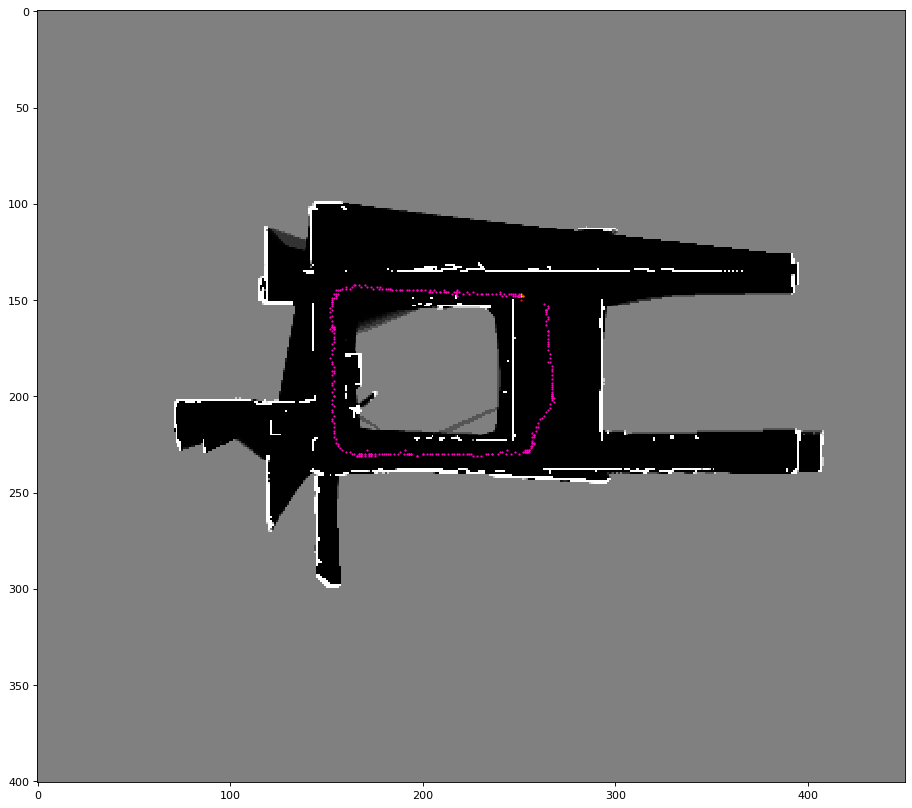

In [33]:
import pylab
print(states[0])
indices = slam.coordinate_to_map_index(np.array(states))
print(indices[0, :])
print(slam.map_prob.shape)
plot_map(slam.map_prob, [indices[::100, 0], indices[::100, 1]], 20)

In [35]:
# fig = plt.figure(figsize=(8, 8))
# plt.imshow(np.transpose(slam.map_texture, (1, 0, 2)))
# plt.show()
t = Transform()
t.rTo

array([[ 0.,  0.,  1.,  0.],
       [-1., -0., -0., -0.],
       [-0., -1., -0., -0.],
       [ 0.,  0.,  0.,  1.]])

In [ ]:
# fig = plt.figure(figsize=(8, 8))
# plt.imshow(slam.map_texture_trimmed)
# plt.show()